#### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classification on imbalanced data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use [Keras](https://www.tensorflow.org/guide/keras/overview) to define the model and [class weights](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) to help the model learn from the imbalanced data. .

This tutorial contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Select a threshold for a probabilistic classifier to get a deterministic classifier.
* Try and compare with class weighted modelling and oversampling.

В этом руководстве показано, как классифицировать сильно несбалансированный набор данных, в котором количество примеров в одном классе значительно превышает количество примеров в другом. Вы будете работать с набором данных по обнаружению мошенничества с кредитными картами, размещенным на Kaggle. Цель состоит в том, чтобы выявить всего 492 мошеннические транзакции из 284 807 транзакций в целом. Вы будете использовать Keras для определения модели и весовых коэффициентов классов, чтобы помочь модели извлечь уроки из несбалансированных данных.

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

### Download the Kaggle Credit Card Fraud data set

Pandas is a Python library with many helpful utilities for loading and working with structured data. It can be used to download CSVs into a Pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame).

Note: This dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available [here](https://www.researchgate.net/project/Fraud-detection-5) and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project

In [3]:
file = tf.keras.utils
raw_df = pd.read_csv('creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Examine the class label imbalance

Let's look at the dataset imbalance:

In [5]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



This shows the small fraction of positive samples.

### Clean, split and normalize the data

The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.  


С исходными данными есть несколько проблем. Во-первых, столбцы "Время" и "Сумма" слишком изменчивы, чтобы использовать их напрямую. Удалите столбец "Время" (поскольку неясно, что он означает) и возьмите логарифм столбца "Сумма", чтобы уменьшить его диапазон.

In [6]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.  


Разделите набор данных на обучающий, проверочный и тестовый наборы. Проверочный набор используется во время подгонки модели для оценки потерь и любых показателей, однако модель не соответствует этим данным. Тестовый набор полностью не используется на этапе обучения и используется только в конце, чтобы оценить, насколько хорошо модель обобщается на новые данные. Это особенно важно для несбалансированных наборов данных, где из-за нехватки обучающих данных возникает серьезная проблема с переобучением.

In [7]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

We check whether the distribution of the classes in the three sets is about the same or not.  

Мы проверяем, является ли распределение классов в трех наборах примерно одинаковым или нет.

In [8]:
print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.0018
Average class probability in validation set: 0.0015
Average class probability in test set:       0.0017


Given the small number of positive labels, this seems about right.

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 



Учитывая небольшое количество положительных меток, это кажется правильным.

Нормализуйте входные параметры с помощью sklearn StandardScaler. При этом среднее значение будет равно 0, а стандартное отклонение - 1.

Примечание: StandardScaler подходит только для использования train_features, чтобы убедиться, что модель не просматривает проверочные или тестовые наборы.

In [9]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


### Look at the data distribution

Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

* Do these distributions make sense? 
    * Yes. You've normalized the input and these are mostly concentrated in the `+/- 2` range.
* Can you see the difference between the distributions?
    * Yes the positive examples contain a much higher rate of extreme values.

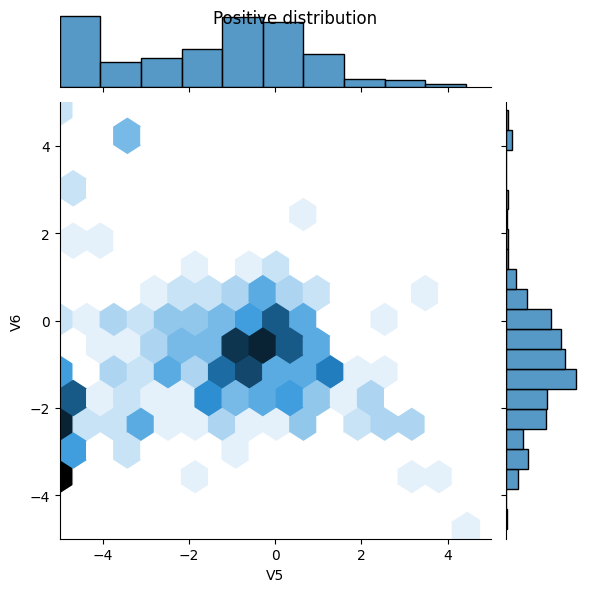

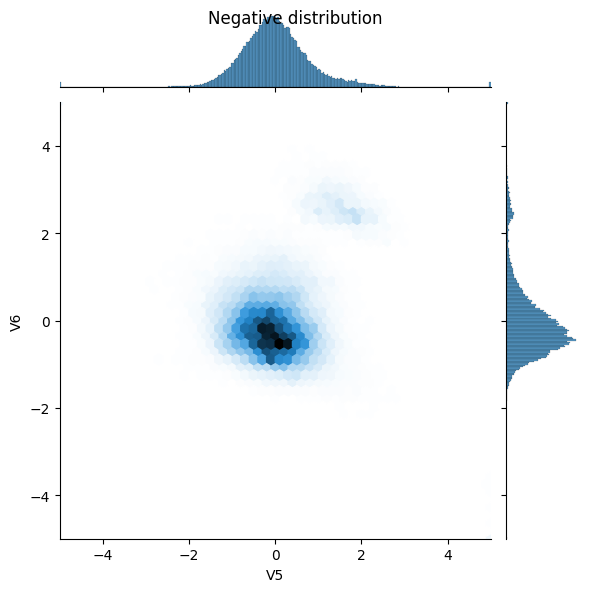

In [10]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [11]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.
These can be divided into three groups.  


Понимание полезных показателей  
Обратите внимание, что есть несколько показателей, определенных выше, которые могут быть вычислены с помощью модели и которые будут полезны при оценке производительности. Их можно разделить на три группы.

#### Metrics for probability predictions

As we train our network with the cross entropy as a loss function, it is fully capable of predicting class probabilities, i.e., it is a probabilistic classifier.
Good metrics to assess probabilistic predictions are, in fact, **proper scoring rules**. Their key property is that predicting the true probability is optimal. We give two well-known examples:

*   **cross entropy** also known as log los --- перекрестная энтропия, также известная как логарифмическая потеряаs
*   **Mean squared error** also known as the Brier sco --- Среднеквадратическая ошибка, также известная как оценка Брайераr

Метрики для вероятностных прогнозов  
Поскольку мы обучаем нашу сеть, используя перекрестную энтропию в качестве функции потерь, она полностью способна предсказывать вероятности классов, т.е. это вероятностный классификатор. Хорошими метриками для оценки вероятностных прогнозов являются, по сути, правильные правила подсчета очков. Их ключевое свойство заключается в том, что оптимальным является прогнозирование истинной вероятности. Мы приводим два хорошо известных примера:e

#### Metrics for deterministic 0/1 predictions

In the end, one often wants to predict a class label, 0 or 1, *no fraud* or *fraud*.
This is called a deterministic classifier.
To get a label prediction from our probabilistic classifier, one needs to choose a probability threshold $t$.
The default is to predict label 1 (fraud) if the predicted probability is larger than $t=50\%$ and all the following metrics implicitly use this default

В конце концов, часто требуется предсказать метку класса, 0 или 1, без обмана. Это называется детерминированным классификатором. Чтобы получить прогноз по метке из нашего вероятностного классификатора, необходимо выбрать пороговое значение вероятности   По умолчанию прогнозируется метка 1 (мошенничество), если прогнозируемая вероятность больш
, и все следующие показатели неявно используют это значение по умолчани  



. 

*   **False** negatives and **false** positives are samples that were **incorrectly** class --- Ложноотрицательные и ложноположительные результаты - это образцы, которые были неправильно классифицированыified
*   **True** negatives and **true** positives are samples that were **correctly** class --- Истинно отрицательные и истинно положительные результаты - это образцы, которые были правильно классифицированыified
*   **Accuracy** is the percentage of examples correctly class --- Точность - это процент правильно классифицированных примеровified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly class --- Прецизионность - это процент предсказанных положительных результатов, которые были правильно классифицированыified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly class --- Повторение - это процент фактических положительных результатов, которые были правильно классифицированыified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$

**Note:** Accuracy is not a helpful metric for this task. You can have 99.8%+ accuracy on this task by predicting False all the  --- Точность не является полезным показателем для этой задачи. Вы можете достичь точности более 99,8% в этой задаче, постоянно предсказывая ложные результаты.me.  

#### Other metrices

The following metrics take into account all possible choices of thresholds
Следующие показатели учитывают все возможные варианты пороговых значений  сти. $t$.

*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negativ --- AUC относится к площади под кривой рабочей характеристической кривой приемника (ROC-AUC). Этот показатель равен вероятности того, что классификатор оценит случайную положительную выборку выше, чем случайную отрицательную выборку.e sample.
*   **AUPRC** refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thr--- AUPRC относится к площади под кривой зависимости точности от отзыва. Этот показатель вычисляет пары точности от отзыва для различных пороговых значений вероятности.esholds. 


#### Read more:
*   [Strictly Proper Scoring Rules, Prediction, and Estimation](https://www.stat.washington.edu/people/raftery/Research/PDF/Gneiting2007jasa.pdf)
*   [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*   [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [Relationship between Precision-Recall and ROC Curves](https://www.biostat.wisc.edu/~page/rocpr.pdf)

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: Fitting this model will not handle the class imbalance efficiently. You will improve it later in this tutorial.

Теперь создайте и обучите свою модель, используя функцию, которая была определена ранее. Обратите внимание, что модель рассчитана на использование пакета, размер которого больше, чем по умолчанию, - 2048, это важно для обеспечения того, чтобы в каждом пакете было несколько положительных образцов. Если бы размер пакета был слишком мал, у них, скорее всего, не было бы возможности извлечь уроки из мошеннических транзакций.

Примечание: Использование этой модели не позволит эффективно устранить дисбаланс классов. Вы улучшите ее позже в этом руководстве.

In [12]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                480       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 497 (1.94 KB)
Trainable params: 497 (1.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 16)                480       


 dropout (Dropout)           (None, 16)                0         


 dense_1 (Dense)             (None, 1)                 17        


Total params: 497 (1.94 KB)


Trainable params: 497 (1.94 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Test run the model:

In [14]:
model.predict(train_features[:10])

1/1 [==============================] - 0s 200ms/step


array([[0.53011554],
       [0.3747262 ],
       [0.35435885],
       [0.28175738],
       [0.59433067],
       [0.5335352 ],
       [0.54290915],
       [0.3270297 ],
       [0.41316578],
       [0.28109217]], dtype=float32)

### Optional: Set the correct initial bias.

These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that, see [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314` 

Необязательно: Задайте правильное начальное смещение.
Эти первоначальные предположения не очень хороши. Вы знаете, что набор данных несбалансирован. Задайте смещение выходного слоя, чтобы отразить это, см. Рецепт для обучения нейронных сетей: "хорошо работать с этим". Это может помочь в начальной конвергенции.

При инициализации смещения по умолчанию потери должны составлять около `math.log(2) = 0.69314`

In [15]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))


Loss: 0.5072


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Set that as the initial bias, and the model will give much more reasonable initial guesses. 

It should be near: `pos/total = 0.0018`


Установите это в качестве начального значения, и модель выдаст гораздо более обоснованные первоначальные предположения.

In [17]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 [==============================] - 0s 40ms/step


array([[0.00064598],
       [0.00086819],
       [0.00017902],
       [0.0029677 ],
       [0.00346883],
       [0.00137399],
       [0.00060827],
       [0.00385995],
       [0.0003368 ],
       [0.03575136]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0130


This initial loss is about 50 times less than it would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. It also makes it easier to read plots of the loss during training.  


Таким образом, модели не нужно тратить первые несколько эпох на то, чтобы просто понять, что положительные примеры маловероятны. Это также облегчает чтение графиков потерь во время обучения.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training:  


Чтобы сделать различные тренировочные прогоны более сопоставимыми, сохраните значения веса исходной модели в файле контрольных точек и загружайте их в каждую модель перед тренировкой:

In [19]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 


Прежде чем двигаться дальше, быстро убедитесь, что тщательная инициализация смещения действительно помогла.

Подготовьте модель для 20 периодов, с такой тщательной инициализацией и без нее, и сравните потери:

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [21]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [26]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

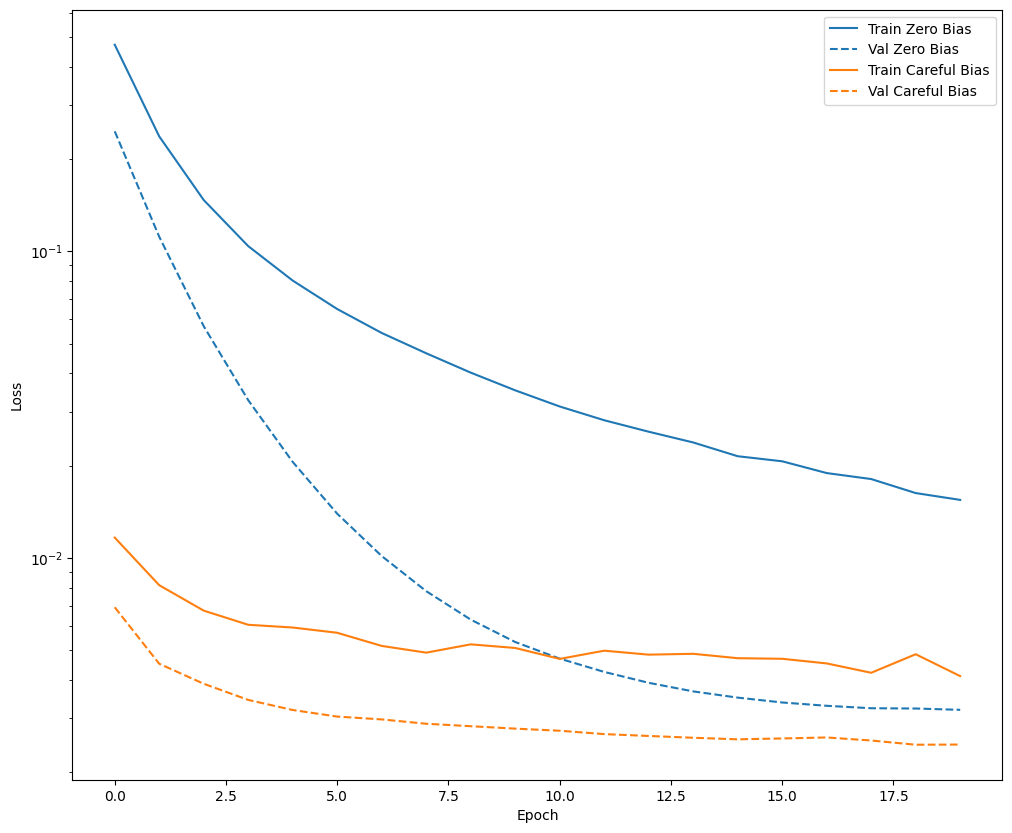

In [27]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 


Приведенный выше рисунок ясно показывает: с точки зрения потери валидации, в данной проблеме такая тщательная инициализация дает явное преимущество.

### Train the model

In [28]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 2s 8ms/step - loss: 0.0111 - cross entropy: 0.0094 - Brier score: 0.0015 - tp: 81.0000 - fp: 37.0000 - tn: 227410.0000 - fn: 317.0000 - accuracy: 0.9984 - precision: 0.6864 - recall: 0.2035 - auc: 0.7909 - prc: 0.2467 - val_loss: 0.0066 - val_cross entropy: 0.0066 - val_Brier score: 0.0013 - val_tp: 2.0000 - val_fp: 1.0000 - val_tn: 45500.0000 - val_fn: 66.0000 - val_accuracy: 0.9985 - val_precision: 0.6667 - val_recall: 0.0294 - val_auc: 0.9467 - val_prc: 0.5762
Epoch 2/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0078 - cross entropy: 0.0078 - Brier score: 0.0013 - tp: 92.0000 - fp: 22.0000 - tn: 181924.0000 - fn: 238.0000 - accuracy: 0.9986 - precision: 0.8070 - recall: 0.2788 - auc: 0.8561 - prc: 0.4027 - val_loss: 0.0046 - val_cross entropy: 0.0046 - val_Brier score: 9.9292e-04 - val_tp: 17.0000 - val_fp: 6.0000 - val_tn: 45495.0000 - val_fn: 51.0000 - val_accuracy: 0.9987 - val_precision: 0.7391 - val_reca

15/90 [====>.........................] - ETA: 0s - loss: 0.0149 - cross entropy: 0.0077 - Brier score: 0.0012 - tp: 90.0000 - fp: 52.0000 - tn: 76103.0000 - fn: 44.0000 - accuracy: 0.9987 - precision: 0.6338 - recall: 0.6716 - auc: 0.9110 - prc: 0.6003     

29/90 [========>.....................] - ETA: 0s - loss: 0.0139 - cross entropy: 0.0091 - Brier score: 0.0014 - tp: 107.0000 - fp: 80.0000 - tn: 104699.0000 - fn: 75.0000 - accuracy: 0.9985 - precision: 0.5722 - recall: 0.5879 - auc: 0.8913 - prc: 0.5043

43/90 [=============>................] - ETA: 0s - loss: 0.0129 - cross entropy: 0.0095 - Brier score: 0.0014 - tp: 115.0000 - fp: 99.0000 - tn: 133310.0000 - fn: 109.0000 - accuracy: 0.9984 - precision: 0.5374 - recall: 0.5134 - auc: 0.8813 - prc: 0.4443

58/90 [==================>...........] - ETA: 0s - loss: 0.0120 - cross entropy: 0.0094 - Brier score: 0.0014 - tp: 129.0000 - fp: 111.0000 - tn: 163976.0000 - fn: 137.0000 - accuracy: 0.9985 - precision: 0.5375 - recall: 0.4850 - auc: 0.8724 - prc: 0.4212

73/90 [=======================>......] - ETA: 0s - loss: 0.0113 - cross entropy: 0.0093 - Brier score: 0.0013 - tp: 155.0000 - fp: 120.0000 - tn: 194633.0000 - fn: 165.0000 - accuracy: 0.9985 - precision: 0.5636 - recall: 0.4844 - auc: 0.8741 - prc: 0.4292

88/90 [============================>.] - ETA: 0s - loss: 0.0109 - cross entropy: 0.0093 - Brier score: 0.0013 - tp: 178.0000 - fp: 128.0000 - tn: 225286.0000 - fn: 201.0000 - accuracy: 0.9985 - precision: 0.5817 - recall: 0.4697 - auc: 0.8752 - prc: 0.4232

90/90 [==============================] - 2s 11ms/step - loss: 0.0109 - cross entropy: 0.0092 - Brier score: 0.0013 - tp: 179.0000 - fp: 128.0000 - tn: 227336.0000 - fn: 202.0000 - accuracy: 0.9986 - precision: 0.5831 - recall: 0.4698 - auc: 0.8759 - prc: 0.4240 - val_loss: 0.0053 - val_cross entropy: 0.0053 - val_Brier score: 7.6563e-04 - val_tp: 44.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 38.0000 - val_accuracy: 0.9991 - val_precision: 0.8980 - val_recall: 0.5366 - val_auc: 0.9188 - val_prc: 0.7535


Epoch 2/100


 1/90 [..............................] - ETA: 0s - loss: 0.0053 - cross entropy: 0.0053 - Brier score: 5.7561e-04 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8000 - auc: 0.9946 - prc: 0.8154

16/90 [====>.........................] - ETA: 0s - loss: 0.0084 - cross entropy: 0.0084 - Brier score: 0.0012 - tp: 19.0000 - fp: 7.0000 - tn: 32707.0000 - fn: 35.0000 - accuracy: 0.9987 - precision: 0.7308 - recall: 0.3519 - auc: 0.8688 - prc: 0.4091     

31/90 [=========>....................] - ETA: 0s - loss: 0.0077 - cross entropy: 0.0077 - Brier score: 0.0011 - tp: 49.0000 - fp: 13.0000 - tn: 63367.0000 - fn: 59.0000 - accuracy: 0.9989 - precision: 0.7903 - recall: 0.4537 - auc: 0.8675 - prc: 0.5190

46/90 [==============>...............] - ETA: 0s - loss: 0.0073 - cross entropy: 0.0073 - Brier score: 0.0010 - tp: 77.0000 - fp: 18.0000 - tn: 94027.0000 - fn: 86.0000 - accuracy: 0.9989 - precision: 0.8105 - recall: 0.4724 - auc: 0.8848 - prc: 0.5372

61/90 [===================>..........] - ETA: 0s - loss: 0.0071 - cross entropy: 0.0071 - Brier score: 9.9375e-04 - tp: 94.0000 - fp: 20.0000 - tn: 124700.0000 - fn: 114.0000 - accuracy: 0.9989 - precision: 0.8246 - recall: 0.4519 - auc: 0.8783 - prc: 0.5393

75/90 [========================>.....] - ETA: 0s - loss: 0.0070 - cross entropy: 0.0070 - Brier score: 9.8045e-04 - tp: 120.0000 - fp: 29.0000 - tn: 153317.0000 - fn: 134.0000 - accuracy: 0.9989 - precision: 0.8054 - recall: 0.4724 - auc: 0.8824 - prc: 0.5376

90/90 [==============================] - ETA: 0s - loss: 0.0070 - cross entropy: 0.0070 - Brier score: 9.7767e-04 - tp: 137.0000 - fp: 31.0000 - tn: 181946.0000 - fn: 162.0000 - accuracy: 0.9989 - precision: 0.8155 - recall: 0.4582 - auc: 0.8800 - prc: 0.5341

90/90 [==============================] - 0s 5ms/step - loss: 0.0070 - cross entropy: 0.0070 - Brier score: 9.7767e-04 - tp: 137.0000 - fp: 31.0000 - tn: 181946.0000 - fn: 162.0000 - accuracy: 0.9989 - precision: 0.8155 - recall: 0.4582 - auc: 0.8800 - prc: 0.5341 - val_loss: 0.0044 - val_cross entropy: 0.0044 - val_Brier score: 6.3545e-04 - val_tp: 54.0000 - val_fp: 7.0000 - val_tn: 45480.0000 - val_fn: 28.0000 - val_accuracy: 0.9992 - val_precision: 0.8852 - val_recall: 0.6585 - val_auc: 0.9263 - val_prc: 0.7737


Epoch 3/100


 1/90 [..............................] - ETA: 0s - loss: 0.0068 - cross entropy: 0.0068 - Brier score: 9.8711e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.8658 - prc: 0.5494

15/90 [====>.........................] - ETA: 0s - loss: 0.0051 - cross entropy: 0.0051 - Brier score: 7.2899e-04 - tp: 27.0000 - fp: 5.0000 - tn: 30667.0000 - fn: 21.0000 - accuracy: 0.9992 - precision: 0.8438 - recall: 0.5625 - auc: 0.9322 - prc: 0.6912 

29/90 [========>.....................] - ETA: 0s - loss: 0.0052 - cross entropy: 0.0052 - Brier score: 7.3622e-04 - tp: 55.0000 - fp: 9.0000 - tn: 59286.0000 - fn: 42.0000 - accuracy: 0.9991 - precision: 0.8594 - recall: 0.5670 - auc: 0.9386 - prc: 0.6833

44/90 [=============>................] - ETA: 0s - loss: 0.0057 - cross entropy: 0.0057 - Brier score: 8.2313e-04 - tp: 83.0000 - fp: 14.0000 - tn: 89943.0000 - fn: 72.0000 - accuracy: 0.9990 - precision: 0.8557 - recall: 0.5355 - auc: 0.9234 - prc: 0.6561

58/90 [==================>...........] - ETA: 0s - loss: 0.0056 - cross entropy: 0.0056 - Brier score: 8.1488e-04 - tp: 100.0000 - fp: 19.0000 - tn: 118573.0000 - fn: 92.0000 - accuracy: 0.9991 - precision: 0.8403 - recall: 0.5208 - auc: 0.9160 - prc: 0.6298

72/90 [=======================>......] - ETA: 0s - loss: 0.0059 - cross entropy: 0.0059 - Brier score: 8.5071e-04 - tp: 116.0000 - fp: 26.0000 - tn: 147196.0000 - fn: 118.0000 - accuracy: 0.9990 - precision: 0.8169 - recall: 0.4957 - auc: 0.9064 - prc: 0.5996

86/90 [===========================>..] - ETA: 0s - loss: 0.0061 - cross entropy: 0.0061 - Brier score: 8.9999e-04 - tp: 137.0000 - fp: 33.0000 - tn: 175810.0000 - fn: 148.0000 - accuracy: 0.9990 - precision: 0.8059 - recall: 0.4807 - auc: 0.9040 - prc: 0.5701

90/90 [==============================] - 0s 5ms/step - loss: 0.0061 - cross entropy: 0.0061 - Brier score: 8.9642e-04 - tp: 146.0000 - fp: 33.0000 - tn: 181944.0000 - fn: 153.0000 - accuracy: 0.9990 - precision: 0.8156 - recall: 0.4883 - auc: 0.9033 - prc: 0.5771 - val_loss: 0.0040 - val_cross entropy: 0.0040 - val_Brier score: 6.0828e-04 - val_tp: 55.0000 - val_fp: 6.0000 - val_tn: 45481.0000 - val_fn: 27.0000 - val_accuracy: 0.9993 - val_precision: 0.9016 - val_recall: 0.6707 - val_auc: 0.9266 - val_prc: 0.7869


Epoch 4/100


 1/90 [..............................] - ETA: 0s - loss: 0.0047 - cross entropy: 0.0047 - Brier score: 5.3611e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.8283 - prc: 0.6680

15/90 [====>.........................] - ETA: 0s - loss: 0.0061 - cross entropy: 0.0061 - Brier score: 9.1208e-04 - tp: 20.0000 - fp: 6.0000 - tn: 30668.0000 - fn: 26.0000 - accuracy: 0.9990 - precision: 0.7692 - recall: 0.4348 - auc: 0.8758 - prc: 0.5327 

29/90 [========>.....................] - ETA: 0s - loss: 0.0054 - cross entropy: 0.0054 - Brier score: 8.1668e-04 - tp: 47.0000 - fp: 12.0000 - tn: 59291.0000 - fn: 42.0000 - accuracy: 0.9991 - precision: 0.7966 - recall: 0.5281 - auc: 0.9121 - prc: 0.5968

43/90 [=============>................] - ETA: 0s - loss: 0.0057 - cross entropy: 0.0057 - Brier score: 8.7736e-04 - tp: 68.0000 - fp: 17.0000 - tn: 87909.0000 - fn: 70.0000 - accuracy: 0.9990 - precision: 0.8000 - recall: 0.4928 - auc: 0.9091 - prc: 0.5844

57/90 [==================>...........] - ETA: 0s - loss: 0.0060 - cross entropy: 0.0060 - Brier score: 9.3898e-04 - tp: 94.0000 - fp: 21.0000 - tn: 116519.0000 - fn: 102.0000 - accuracy: 0.9989 - precision: 0.8174 - recall: 0.4796 - auc: 0.9016 - prc: 0.5914

71/90 [======================>.......] - ETA: 0s - loss: 0.0058 - cross entropy: 0.0058 - Brier score: 9.2113e-04 - tp: 118.0000 - fp: 24.0000 - tn: 145139.0000 - fn: 127.0000 - accuracy: 0.9990 - precision: 0.8310 - recall: 0.4816 - auc: 0.9045 - prc: 0.6166

85/90 [===========================>..] - ETA: 0s - loss: 0.0058 - cross entropy: 0.0058 - Brier score: 9.0614e-04 - tp: 143.0000 - fp: 29.0000 - tn: 173760.0000 - fn: 148.0000 - accuracy: 0.9990 - precision: 0.8314 - recall: 0.4914 - auc: 0.9054 - prc: 0.6140

90/90 [==============================] - 0s 5ms/step - loss: 0.0057 - cross entropy: 0.0057 - Brier score: 8.9241e-04 - tp: 147.0000 - fp: 30.0000 - tn: 181947.0000 - fn: 152.0000 - accuracy: 0.9990 - precision: 0.8305 - recall: 0.4916 - auc: 0.9045 - prc: 0.6121 - val_loss: 0.0037 - val_cross entropy: 0.0037 - val_Brier score: 5.6512e-04 - val_tp: 58.0000 - val_fp: 7.0000 - val_tn: 45480.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8923 - val_recall: 0.7073 - val_auc: 0.9327 - val_prc: 0.7996


Epoch 5/100


 1/90 [..............................] - ETA: 0s - loss: 0.0046 - cross entropy: 0.0046 - Brier score: 7.1316e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.8725 - prc: 0.7516

15/90 [====>.........................] - ETA: 0s - loss: 0.0054 - cross entropy: 0.0054 - Brier score: 8.6995e-04 - tp: 17.0000 - fp: 5.0000 - tn: 30671.0000 - fn: 27.0000 - accuracy: 0.9990 - precision: 0.7727 - recall: 0.3864 - auc: 0.8945 - prc: 0.5607 

29/90 [========>.....................] - ETA: 0s - loss: 0.0048 - cross entropy: 0.0048 - Brier score: 8.0269e-04 - tp: 48.0000 - fp: 10.0000 - tn: 59288.0000 - fn: 46.0000 - accuracy: 0.9991 - precision: 0.8276 - recall: 0.5106 - auc: 0.9125 - prc: 0.6649

43/90 [=============>................] - ETA: 0s - loss: 0.0050 - cross entropy: 0.0050 - Brier score: 8.2230e-04 - tp: 70.0000 - fp: 19.0000 - tn: 87911.0000 - fn: 64.0000 - accuracy: 0.9991 - precision: 0.7865 - recall: 0.5224 - auc: 0.9117 - prc: 0.6178

57/90 [==================>...........] - ETA: 0s - loss: 0.0050 - cross entropy: 0.0050 - Brier score: 8.1646e-04 - tp: 102.0000 - fp: 24.0000 - tn: 116527.0000 - fn: 83.0000 - accuracy: 0.9991 - precision: 0.8095 - recall: 0.5514 - auc: 0.9166 - prc: 0.6377

71/90 [======================>.......] - ETA: 0s - loss: 0.0052 - cross entropy: 0.0052 - Brier score: 8.3901e-04 - tp: 127.0000 - fp: 29.0000 - tn: 145143.0000 - fn: 109.0000 - accuracy: 0.9991 - precision: 0.8141 - recall: 0.5381 - auc: 0.9086 - prc: 0.6386

85/90 [===========================>..] - ETA: 0s - loss: 0.0051 - cross entropy: 0.0051 - Brier score: 8.1558e-04 - tp: 158.0000 - fp: 30.0000 - tn: 173761.0000 - fn: 131.0000 - accuracy: 0.9991 - precision: 0.8404 - recall: 0.5467 - auc: 0.9112 - prc: 0.6597

90/90 [==============================] - 0s 5ms/step - loss: 0.0050 - cross entropy: 0.0050 - Brier score: 8.0944e-04 - tp: 163.0000 - fp: 31.0000 - tn: 181946.0000 - fn: 136.0000 - accuracy: 0.9991 - precision: 0.8402 - recall: 0.5452 - auc: 0.9091 - prc: 0.6557 - val_loss: 0.0035 - val_cross entropy: 0.0035 - val_Brier score: 5.4862e-04 - val_tp: 58.0000 - val_fp: 7.0000 - val_tn: 45480.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8923 - val_recall: 0.7073 - val_auc: 0.9327 - val_prc: 0.8041


Epoch 6/100


 1/90 [..............................] - ETA: 0s - loss: 0.0010 - cross entropy: 0.0010 - Brier score: 3.1781e-06 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

15/90 [====>.........................] - ETA: 0s - loss: 0.0042 - cross entropy: 0.0042 - Brier score: 6.6701e-04 - tp: 30.0000 - fp: 7.0000 - tn: 30666.0000 - fn: 17.0000 - accuracy: 0.9992 - precision: 0.8108 - recall: 0.6383 - auc: 0.9456 - prc: 0.7403     

29/90 [========>.....................] - ETA: 0s - loss: 0.0046 - cross entropy: 0.0046 - Brier score: 7.6023e-04 - tp: 51.0000 - fp: 12.0000 - tn: 59290.0000 - fn: 39.0000 - accuracy: 0.9991 - precision: 0.8095 - recall: 0.5667 - auc: 0.9204 - prc: 0.6766

43/90 [=============>................] - ETA: 0s - loss: 0.0047 - cross entropy: 0.0047 - Brier score: 7.7119e-04 - tp: 77.0000 - fp: 17.0000 - tn: 87911.0000 - fn: 59.0000 - accuracy: 0.9991 - precision: 0.8191 - recall: 0.5662 - auc: 0.9246 - prc: 0.6776

57/90 [==================>...........] - ETA: 0s - loss: 0.0048 - cross entropy: 0.0048 - Brier score: 7.9680e-04 - tp: 98.0000 - fp: 19.0000 - tn: 116533.0000 - fn: 86.0000 - accuracy: 0.9991 - precision: 0.8376 - recall: 0.5326 - auc: 0.9194 - prc: 0.6757

71/90 [======================>.......] - ETA: 0s - loss: 0.0048 - cross entropy: 0.0048 - Brier score: 7.8546e-04 - tp: 134.0000 - fp: 23.0000 - tn: 145145.0000 - fn: 106.0000 - accuracy: 0.9991 - precision: 0.8535 - recall: 0.5583 - auc: 0.9191 - prc: 0.6928

86/90 [===========================>..] - ETA: 0s - loss: 0.0047 - cross entropy: 0.0047 - Brier score: 7.6085e-04 - tp: 158.0000 - fp: 27.0000 - tn: 175817.0000 - fn: 126.0000 - accuracy: 0.9991 - precision: 0.8541 - recall: 0.5563 - auc: 0.9208 - prc: 0.6915

90/90 [==============================] - 0s 5ms/step - loss: 0.0046 - cross entropy: 0.0046 - Brier score: 7.5796e-04 - tp: 168.0000 - fp: 27.0000 - tn: 181950.0000 - fn: 131.0000 - accuracy: 0.9991 - precision: 0.8615 - recall: 0.5619 - auc: 0.9214 - prc: 0.6995 - val_loss: 0.0034 - val_cross entropy: 0.0034 - val_Brier score: 5.3008e-04 - val_tp: 60.0000 - val_fp: 7.0000 - val_tn: 45480.0000 - val_fn: 22.0000 - val_accuracy: 0.9994 - val_precision: 0.8955 - val_recall: 0.7317 - val_auc: 0.9388 - val_prc: 0.8149


Epoch 7/100


 1/90 [..............................] - ETA: 0s - loss: 9.0016e-04 - cross entropy: 9.0016e-04 - Brier score: 2.7718e-06 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

15/90 [====>.........................] - ETA: 0s - loss: 0.0047 - cross entropy: 0.0047 - Brier score: 7.0024e-04 - tp: 34.0000 - fp: 7.0000 - tn: 30660.0000 - fn: 19.0000 - accuracy: 0.9992 - precision: 0.8293 - recall: 0.6415 - auc: 0.9328 - prc: 0.7086             

29/90 [========>.....................] - ETA: 0s - loss: 0.0045 - cross entropy: 0.0045 - Brier score: 6.8385e-04 - tp: 75.0000 - fp: 12.0000 - tn: 59269.0000 - fn: 36.0000 - accuracy: 0.9992 - precision: 0.8621 - recall: 0.6757 - auc: 0.9403 - prc: 0.7392

43/90 [=============>................] - ETA: 0s - loss: 0.0044 - cross entropy: 0.0044 - Brier score: 7.0019e-04 - tp: 106.0000 - fp: 14.0000 - tn: 87885.0000 - fn: 59.0000 - accuracy: 0.9992 - precision: 0.8833 - recall: 0.6424 - auc: 0.9382 - prc: 0.7498

57/90 [==================>...........] - ETA: 0s - loss: 0.0047 - cross entropy: 0.0047 - Brier score: 7.4059e-04 - tp: 137.0000 - fp: 21.0000 - tn: 116499.0000 - fn: 79.0000 - accuracy: 0.9991 - precision: 0.8671 - recall: 0.6343 - auc: 0.9292 - prc: 0.7194

71/90 [======================>.......] - ETA: 0s - loss: 0.0048 - cross entropy: 0.0048 - Brier score: 7.5284e-04 - tp: 160.0000 - fp: 29.0000 - tn: 145123.0000 - fn: 96.0000 - accuracy: 0.9991 - precision: 0.8466 - recall: 0.6250 - auc: 0.9145 - prc: 0.6919

85/90 [===========================>..] - ETA: 0s - loss: 0.0045 - cross entropy: 0.0045 - Brier score: 7.0737e-04 - tp: 178.0000 - fp: 31.0000 - tn: 173761.0000 - fn: 110.0000 - accuracy: 0.9992 - precision: 0.8517 - recall: 0.6181 - auc: 0.9135 - prc: 0.6948

90/90 [==============================] - 0s 5ms/step - loss: 0.0045 - cross entropy: 0.0045 - Brier score: 7.0728e-04 - tp: 183.0000 - fp: 33.0000 - tn: 181944.0000 - fn: 116.0000 - accuracy: 0.9992 - precision: 0.8472 - recall: 0.6120 - auc: 0.9133 - prc: 0.6901 - val_loss: 0.0033 - val_cross entropy: 0.0033 - val_Brier score: 5.3596e-04 - val_tp: 58.0000 - val_fp: 6.0000 - val_tn: 45481.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.9062 - val_recall: 0.7073 - val_auc: 0.9388 - val_prc: 0.8227


Epoch 8/100


 1/90 [..............................] - ETA: 0s - loss: 0.0011 - cross entropy: 0.0011 - Brier score: 7.6400e-05 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

15/90 [====>.........................] - ETA: 0s - loss: 0.0053 - cross entropy: 0.0053 - Brier score: 9.7915e-04 - tp: 26.0000 - fp: 4.0000 - tn: 30659.0000 - fn: 31.0000 - accuracy: 0.9989 - precision: 0.8667 - recall: 0.4561 - auc: 0.9286 - prc: 0.7026     

29/90 [========>.....................] - ETA: 0s - loss: 0.0052 - cross entropy: 0.0052 - Brier score: 9.2169e-04 - tp: 57.0000 - fp: 6.0000 - tn: 59273.0000 - fn: 56.0000 - accuracy: 0.9990 - precision: 0.9048 - recall: 0.5044 - auc: 0.9234 - prc: 0.7091

43/90 [=============>................] - ETA: 0s - loss: 0.0049 - cross entropy: 0.0049 - Brier score: 8.4603e-04 - tp: 83.0000 - fp: 12.0000 - tn: 87899.0000 - fn: 70.0000 - accuracy: 0.9991 - precision: 0.8737 - recall: 0.5425 - auc: 0.9169 - prc: 0.6683

57/90 [==================>...........] - ETA: 0s - loss: 0.0047 - cross entropy: 0.0047 - Brier score: 7.7790e-04 - tp: 104.0000 - fp: 17.0000 - tn: 116530.0000 - fn: 85.0000 - accuracy: 0.9991 - precision: 0.8595 - recall: 0.5503 - auc: 0.9219 - prc: 0.6712

71/90 [======================>.......] - ETA: 0s - loss: 0.0045 - cross entropy: 0.0045 - Brier score: 7.5564e-04 - tp: 139.0000 - fp: 27.0000 - tn: 145146.0000 - fn: 96.0000 - accuracy: 0.9992 - precision: 0.8373 - recall: 0.5915 - auc: 0.9306 - prc: 0.6828

85/90 [===========================>..] - ETA: 0s - loss: 0.0047 - cross entropy: 0.0047 - Brier score: 7.9561e-04 - tp: 165.0000 - fp: 35.0000 - tn: 173760.0000 - fn: 120.0000 - accuracy: 0.9991 - precision: 0.8250 - recall: 0.5789 - auc: 0.9214 - prc: 0.6639

90/90 [==============================] - 0s 5ms/step - loss: 0.0048 - cross entropy: 0.0048 - Brier score: 8.0575e-04 - tp: 169.0000 - fp: 35.0000 - tn: 181942.0000 - fn: 130.0000 - accuracy: 0.9991 - precision: 0.8284 - recall: 0.5652 - auc: 0.9183 - prc: 0.6610 - val_loss: 0.0032 - val_cross entropy: 0.0032 - val_Brier score: 5.4781e-04 - val_tp: 58.0000 - val_fp: 6.0000 - val_tn: 45481.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.9062 - val_recall: 0.7073 - val_auc: 0.9389 - val_prc: 0.8321


Epoch 9/100


 1/90 [..............................] - ETA: 0s - loss: 0.0082 - cross entropy: 0.0082 - Brier score: 0.0012 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.7471 - prc: 0.5026

15/90 [====>.........................] - ETA: 0s - loss: 0.0058 - cross entropy: 0.0058 - Brier score: 9.8162e-04 - tp: 23.0000 - fp: 3.0000 - tn: 30665.0000 - fn: 29.0000 - accuracy: 0.9990 - precision: 0.8846 - recall: 0.4423 - auc: 0.8923 - prc: 0.5626

29/90 [========>.....................] - ETA: 0s - loss: 0.0047 - cross entropy: 0.0047 - Brier score: 8.1071e-04 - tp: 53.0000 - fp: 6.0000 - tn: 59284.0000 - fn: 49.0000 - accuracy: 0.9991 - precision: 0.8983 - recall: 0.5196 - auc: 0.9153 - prc: 0.6860

43/90 [=============>................] - ETA: 0s - loss: 0.0040 - cross entropy: 0.0040 - Brier score: 6.8037e-04 - tp: 75.0000 - fp: 7.0000 - tn: 87919.0000 - fn: 63.0000 - accuracy: 0.9992 - precision: 0.9146 - recall: 0.5435 - auc: 0.9228 - prc: 0.7244

57/90 [==================>...........] - ETA: 0s - loss: 0.0042 - cross entropy: 0.0042 - Brier score: 7.3167e-04 - tp: 99.0000 - fp: 15.0000 - tn: 116536.0000 - fn: 86.0000 - accuracy: 0.9991 - precision: 0.8684 - recall: 0.5351 - auc: 0.9150 - prc: 0.7053

71/90 [======================>.......] - ETA: 0s - loss: 0.0043 - cross entropy: 0.0043 - Brier score: 7.4750e-04 - tp: 135.0000 - fp: 21.0000 - tn: 145148.0000 - fn: 104.0000 - accuracy: 0.9991 - precision: 0.8654 - recall: 0.5649 - auc: 0.9151 - prc: 0.7088

85/90 [===========================>..] - ETA: 0s - loss: 0.0043 - cross entropy: 0.0043 - Brier score: 7.4467e-04 - tp: 162.0000 - fp: 25.0000 - tn: 173769.0000 - fn: 124.0000 - accuracy: 0.9991 - precision: 0.8663 - recall: 0.5664 - auc: 0.9166 - prc: 0.7090

90/90 [==============================] - 0s 5ms/step - loss: 0.0043 - cross entropy: 0.0043 - Brier score: 7.4602e-04 - tp: 170.0000 - fp: 27.0000 - tn: 181950.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8629 - recall: 0.5686 - auc: 0.9186 - prc: 0.7075 - val_loss: 0.0031 - val_cross entropy: 0.0031 - val_Brier score: 5.1218e-04 - val_tp: 58.0000 - val_fp: 6.0000 - val_tn: 45481.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.9062 - val_recall: 0.7073 - val_auc: 0.9388 - val_prc: 0.8314


Epoch 10/100


 1/90 [..............................] - ETA: 0s - loss: 0.0141 - cross entropy: 0.0141 - Brier score: 0.0019 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 4.0000 - accuracy: 0.9980 - precision: 1.0000 - recall: 0.2000 - auc: 0.6971 - prc: 0.3225

15/90 [====>.........................] - ETA: 0s - loss: 0.0049 - cross entropy: 0.0049 - Brier score: 8.6339e-04 - tp: 27.0000 - fp: 9.0000 - tn: 30662.0000 - fn: 22.0000 - accuracy: 0.9990 - precision: 0.7500 - recall: 0.5510 - auc: 0.9172 - prc: 0.5983

29/90 [========>.....................] - ETA: 0s - loss: 0.0048 - cross entropy: 0.0048 - Brier score: 8.0296e-04 - tp: 67.0000 - fp: 10.0000 - tn: 59268.0000 - fn: 47.0000 - accuracy: 0.9990 - precision: 0.8701 - recall: 0.5877 - auc: 0.9156 - prc: 0.7084

43/90 [=============>................] - ETA: 0s - loss: 0.0042 - cross entropy: 0.0042 - Brier score: 7.1956e-04 - tp: 99.0000 - fp: 16.0000 - tn: 87889.0000 - fn: 60.0000 - accuracy: 0.9991 - precision: 0.8609 - recall: 0.6226 - auc: 0.9203 - prc: 0.7307

57/90 [==================>...........] - ETA: 0s - loss: 0.0040 - cross entropy: 0.0040 - Brier score: 6.7088e-04 - tp: 116.0000 - fp: 21.0000 - tn: 116525.0000 - fn: 74.0000 - accuracy: 0.9992 - precision: 0.8467 - recall: 0.6105 - auc: 0.9200 - prc: 0.7285

71/90 [======================>.......] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.0766e-04 - tp: 141.0000 - fp: 21.0000 - tn: 145160.0000 - fn: 86.0000 - accuracy: 0.9993 - precision: 0.8704 - recall: 0.6211 - auc: 0.9285 - prc: 0.7527

85/90 [===========================>..] - ETA: 0s - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 6.6002e-04 - tp: 171.0000 - fp: 24.0000 - tn: 173771.0000 - fn: 114.0000 - accuracy: 0.9992 - precision: 0.8769 - recall: 0.6000 - auc: 0.9235 - prc: 0.7418

90/90 [==============================] - 0s 5ms/step - loss: 0.0040 - cross entropy: 0.0040 - Brier score: 6.7102e-04 - tp: 178.0000 - fp: 25.0000 - tn: 181952.0000 - fn: 121.0000 - accuracy: 0.9992 - precision: 0.8768 - recall: 0.5953 - auc: 0.9203 - prc: 0.7351 - val_loss: 0.0030 - val_cross entropy: 0.0030 - val_Brier score: 4.8812e-04 - val_tp: 65.0000 - val_fp: 6.0000 - val_tn: 45481.0000 - val_fn: 17.0000 - val_accuracy: 0.9995 - val_precision: 0.9155 - val_recall: 0.7927 - val_auc: 0.9388 - val_prc: 0.8293


Epoch 11/100


 1/90 [..............................] - ETA: 0s - loss: 7.5753e-04 - cross entropy: 7.5753e-04 - Brier score: 7.6389e-06 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0024 - cross entropy: 0.0024 - Brier score: 3.4542e-04 - tp: 36.0000 - fp: 3.0000 - tn: 28625.0000 - fn: 8.0000 - accuracy: 0.9996 - precision: 0.9231 - recall: 0.8182 - auc: 0.9655 - prc: 0.8512              

27/90 [========>.....................] - ETA: 0s - loss: 0.0025 - cross entropy: 0.0025 - Brier score: 3.9026e-04 - tp: 66.0000 - fp: 5.0000 - tn: 55206.0000 - fn: 19.0000 - accuracy: 0.9996 - precision: 0.9296 - recall: 0.7765 - auc: 0.9642 - prc: 0.8400

40/90 [============>.................] - ETA: 0s - loss: 0.0031 - cross entropy: 0.0031 - Brier score: 4.8022e-04 - tp: 85.0000 - fp: 7.0000 - tn: 81791.0000 - fn: 37.0000 - accuracy: 0.9995 - precision: 0.9239 - recall: 0.6967 - auc: 0.9336 - prc: 0.7796

54/90 [=================>............] - ETA: 0s - loss: 0.0032 - cross entropy: 0.0032 - Brier score: 5.0804e-04 - tp: 114.0000 - fp: 13.0000 - tn: 110414.0000 - fn: 51.0000 - accuracy: 0.9994 - precision: 0.8976 - recall: 0.6909 - auc: 0.9325 - prc: 0.7608

67/90 [=====================>........] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 5.6222e-04 - tp: 142.0000 - fp: 18.0000 - tn: 136984.0000 - fn: 72.0000 - accuracy: 0.9993 - precision: 0.8875 - recall: 0.6636 - auc: 0.9266 - prc: 0.7487

81/90 [==========================>...] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.0617e-04 - tp: 179.0000 - fp: 19.0000 - tn: 165594.0000 - fn: 96.0000 - accuracy: 0.9993 - precision: 0.9040 - recall: 0.6509 - auc: 0.9208 - prc: 0.7467

90/90 [==============================] - 0s 5ms/step - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 6.3325e-04 - tp: 191.0000 - fp: 25.0000 - tn: 181952.0000 - fn: 108.0000 - accuracy: 0.9993 - precision: 0.8843 - recall: 0.6388 - auc: 0.9170 - prc: 0.7323 - val_loss: 0.0030 - val_cross entropy: 0.0030 - val_Brier score: 4.8228e-04 - val_tp: 66.0000 - val_fp: 6.0000 - val_tn: 45481.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.9167 - val_recall: 0.8049 - val_auc: 0.9388 - val_prc: 0.8301


Epoch 12/100


 1/90 [..............................] - ETA: 0s - loss: 0.0080 - cross entropy: 0.0080 - Brier score: 0.0014 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6632 - prc: 0.1044

15/90 [====>.........................] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 5.8304e-04 - tp: 23.0000 - fp: 4.0000 - tn: 30677.0000 - fn: 16.0000 - accuracy: 0.9993 - precision: 0.8519 - recall: 0.5897 - auc: 0.8963 - prc: 0.6521         

29/90 [========>.....................] - ETA: 0s - loss: 0.0043 - cross entropy: 0.0043 - Brier score: 7.7984e-04 - tp: 61.0000 - fp: 7.0000 - tn: 59280.0000 - fn: 44.0000 - accuracy: 0.9991 - precision: 0.8971 - recall: 0.5810 - auc: 0.9180 - prc: 0.7257

43/90 [=============>................] - ETA: 0s - loss: 0.0045 - cross entropy: 0.0045 - Brier score: 8.1202e-04 - tp: 95.0000 - fp: 17.0000 - tn: 87889.0000 - fn: 63.0000 - accuracy: 0.9991 - precision: 0.8482 - recall: 0.6013 - auc: 0.9262 - prc: 0.7155

57/90 [==================>...........] - ETA: 0s - loss: 0.0046 - cross entropy: 0.0046 - Brier score: 8.2841e-04 - tp: 123.0000 - fp: 21.0000 - tn: 116502.0000 - fn: 90.0000 - accuracy: 0.9990 - precision: 0.8542 - recall: 0.5775 - auc: 0.9216 - prc: 0.7117

71/90 [======================>.......] - ETA: 0s - loss: 0.0043 - cross entropy: 0.0043 - Brier score: 7.7832e-04 - tp: 150.0000 - fp: 27.0000 - tn: 145127.0000 - fn: 104.0000 - accuracy: 0.9991 - precision: 0.8475 - recall: 0.5906 - auc: 0.9262 - prc: 0.7241

85/90 [===========================>..] - ETA: 0s - loss: 0.0042 - cross entropy: 0.0042 - Brier score: 7.6383e-04 - tp: 168.0000 - fp: 33.0000 - tn: 173757.0000 - fn: 122.0000 - accuracy: 0.9991 - precision: 0.8358 - recall: 0.5793 - auc: 0.9232 - prc: 0.7150

90/90 [==============================] - 0s 5ms/step - loss: 0.0042 - cross entropy: 0.0042 - Brier score: 7.6081e-04 - tp: 173.0000 - fp: 35.0000 - tn: 181942.0000 - fn: 126.0000 - accuracy: 0.9991 - precision: 0.8317 - recall: 0.5786 - auc: 0.9254 - prc: 0.7097 - val_loss: 0.0029 - val_cross entropy: 0.0029 - val_Brier score: 4.7943e-04 - val_tp: 66.0000 - val_fp: 6.0000 - val_tn: 45481.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.9167 - val_recall: 0.8049 - val_auc: 0.9388 - val_prc: 0.8330


Epoch 13/100


 1/90 [..............................] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.8039e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.9974 - prc: 0.5633

15/90 [====>.........................] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.4525e-04 - tp: 16.0000 - fp: 3.0000 - tn: 30681.0000 - fn: 20.0000 - accuracy: 0.9993 - precision: 0.8421 - recall: 0.4444 - auc: 0.9154 - prc: 0.5950 

29/90 [========>.....................] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.3626e-04 - tp: 43.0000 - fp: 7.0000 - tn: 59305.0000 - fn: 37.0000 - accuracy: 0.9993 - precision: 0.8600 - recall: 0.5375 - auc: 0.9178 - prc: 0.6767

43/90 [=============>................] - ETA: 0s - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 6.6116e-04 - tp: 77.0000 - fp: 10.0000 - tn: 87921.0000 - fn: 56.0000 - accuracy: 0.9993 - precision: 0.8851 - recall: 0.5789 - auc: 0.9238 - prc: 0.7067

57/90 [==================>...........] - ETA: 0s - loss: 0.0042 - cross entropy: 0.0042 - Brier score: 7.1711e-04 - tp: 108.0000 - fp: 19.0000 - tn: 116533.0000 - fn: 76.0000 - accuracy: 0.9992 - precision: 0.8504 - recall: 0.5870 - auc: 0.9229 - prc: 0.6806

71/90 [======================>.......] - ETA: 0s - loss: 0.0041 - cross entropy: 0.0041 - Brier score: 7.0610e-04 - tp: 140.0000 - fp: 21.0000 - tn: 145152.0000 - fn: 95.0000 - accuracy: 0.9992 - precision: 0.8696 - recall: 0.5957 - auc: 0.9289 - prc: 0.7035

85/90 [===========================>..] - ETA: 0s - loss: 0.0043 - cross entropy: 0.0043 - Brier score: 7.4633e-04 - tp: 166.0000 - fp: 28.0000 - tn: 173768.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8557 - recall: 0.5845 - auc: 0.9233 - prc: 0.6860

90/90 [==============================] - 0s 5ms/step - loss: 0.0043 - cross entropy: 0.0043 - Brier score: 7.4700e-04 - tp: 175.0000 - fp: 29.0000 - tn: 181948.0000 - fn: 124.0000 - accuracy: 0.9992 - precision: 0.8578 - recall: 0.5853 - auc: 0.9238 - prc: 0.6897 - val_loss: 0.0029 - val_cross entropy: 0.0029 - val_Brier score: 4.7884e-04 - val_tp: 66.0000 - val_fp: 6.0000 - val_tn: 45481.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.9167 - val_recall: 0.8049 - val_auc: 0.9388 - val_prc: 0.8350


Epoch 14/100


 1/90 [..............................] - ETA: 0s - loss: 0.0024 - cross entropy: 0.0024 - Brier score: 5.1770e-04 - tp: 4.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.8000 - recall: 1.0000 - auc: 0.9998 - prc: 0.8723

15/90 [====>.........................] - ETA: 0s - loss: 0.0030 - cross entropy: 0.0030 - Brier score: 4.5984e-04 - tp: 34.0000 - fp: 5.0000 - tn: 30671.0000 - fn: 10.0000 - accuracy: 0.9995 - precision: 0.8718 - recall: 0.7727 - auc: 0.9310 - prc: 0.7510 

30/90 [=========>....................] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.3856e-04 - tp: 59.0000 - fp: 7.0000 - tn: 61335.0000 - fn: 39.0000 - accuracy: 0.9993 - precision: 0.8939 - recall: 0.6020 - auc: 0.9329 - prc: 0.7572

45/90 [==============>...............] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.5127e-04 - tp: 80.0000 - fp: 11.0000 - tn: 92010.0000 - fn: 59.0000 - accuracy: 0.9992 - precision: 0.8791 - recall: 0.5755 - auc: 0.9235 - prc: 0.7330

60/90 [===================>..........] - ETA: 0s - loss: 0.0041 - cross entropy: 0.0041 - Brier score: 7.3839e-04 - tp: 112.0000 - fp: 16.0000 - tn: 122665.0000 - fn: 87.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.5628 - auc: 0.9136 - prc: 0.7067

74/90 [=======================>......] - ETA: 0s - loss: 0.0040 - cross entropy: 0.0040 - Brier score: 7.1160e-04 - tp: 141.0000 - fp: 22.0000 - tn: 151287.0000 - fn: 102.0000 - accuracy: 0.9992 - precision: 0.8650 - recall: 0.5802 - auc: 0.9167 - prc: 0.7074

89/90 [============================>.] - ETA: 0s - loss: 0.0040 - cross entropy: 0.0040 - Brier score: 7.1933e-04 - tp: 177.0000 - fp: 30.0000 - tn: 181943.0000 - fn: 122.0000 - accuracy: 0.9992 - precision: 0.8551 - recall: 0.5920 - auc: 0.9171 - prc: 0.7144

90/90 [==============================] - 0s 5ms/step - loss: 0.0040 - cross entropy: 0.0040 - Brier score: 7.1931e-04 - tp: 177.0000 - fp: 30.0000 - tn: 181947.0000 - fn: 122.0000 - accuracy: 0.9992 - precision: 0.8551 - recall: 0.5920 - auc: 0.9171 - prc: 0.7144 - val_loss: 0.0029 - val_cross entropy: 0.0029 - val_Brier score: 4.8724e-04 - val_tp: 64.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9275 - val_recall: 0.7805 - val_auc: 0.9388 - val_prc: 0.8409


Epoch 15/100


 1/90 [..............................] - ETA: 0s - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 8.6128e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6000 - auc: 0.9997 - prc: 0.9207

15/90 [====>.........................] - ETA: 0s - loss: 0.0049 - cross entropy: 0.0049 - Brier score: 9.1922e-04 - tp: 31.0000 - fp: 7.0000 - tn: 30657.0000 - fn: 25.0000 - accuracy: 0.9990 - precision: 0.8158 - recall: 0.5536 - auc: 0.9276 - prc: 0.6194 

29/90 [========>.....................] - ETA: 0s - loss: 0.0044 - cross entropy: 0.0044 - Brier score: 8.0396e-04 - tp: 61.0000 - fp: 13.0000 - tn: 59275.0000 - fn: 43.0000 - accuracy: 0.9991 - precision: 0.8243 - recall: 0.5865 - auc: 0.9222 - prc: 0.6891

43/90 [=============>................] - ETA: 0s - loss: 0.0041 - cross entropy: 0.0041 - Brier score: 7.4837e-04 - tp: 82.0000 - fp: 17.0000 - tn: 87906.0000 - fn: 59.0000 - accuracy: 0.9991 - precision: 0.8283 - recall: 0.5816 - auc: 0.9282 - prc: 0.6836

57/90 [==================>...........] - ETA: 0s - loss: 0.0040 - cross entropy: 0.0040 - Brier score: 7.5617e-04 - tp: 107.0000 - fp: 20.0000 - tn: 116524.0000 - fn: 85.0000 - accuracy: 0.9991 - precision: 0.8425 - recall: 0.5573 - auc: 0.9288 - prc: 0.7011

71/90 [======================>.......] - ETA: 0s - loss: 0.0040 - cross entropy: 0.0040 - Brier score: 7.4583e-04 - tp: 134.0000 - fp: 24.0000 - tn: 145146.0000 - fn: 104.0000 - accuracy: 0.9991 - precision: 0.8481 - recall: 0.5630 - auc: 0.9277 - prc: 0.7032

85/90 [===========================>..] - ETA: 0s - loss: 0.0041 - cross entropy: 0.0041 - Brier score: 7.4135e-04 - tp: 162.0000 - fp: 26.0000 - tn: 173768.0000 - fn: 124.0000 - accuracy: 0.9991 - precision: 0.8617 - recall: 0.5664 - auc: 0.9257 - prc: 0.7072

90/90 [==============================] - 0s 5ms/step - loss: 0.0042 - cross entropy: 0.0042 - Brier score: 7.5652e-04 - tp: 167.0000 - fp: 27.0000 - tn: 181950.0000 - fn: 132.0000 - accuracy: 0.9991 - precision: 0.8608 - recall: 0.5585 - auc: 0.9238 - prc: 0.6964 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.7200e-04 - val_tp: 66.0000 - val_fp: 6.0000 - val_tn: 45481.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.9167 - val_recall: 0.8049 - val_auc: 0.9388 - val_prc: 0.8410


Epoch 16/100


 1/90 [..............................] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 8.1860e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.9998 - prc: 0.9088

14/90 [===>..........................] - ETA: 0s - loss: 0.0050 - cross entropy: 0.0050 - Brier score: 8.6951e-04 - tp: 23.0000 - fp: 5.0000 - tn: 28620.0000 - fn: 24.0000 - accuracy: 0.9990 - precision: 0.8214 - recall: 0.4894 - auc: 0.8817 - prc: 0.6457 

28/90 [========>.....................] - ETA: 0s - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 6.6402e-04 - tp: 59.0000 - fp: 6.0000 - tn: 57241.0000 - fn: 38.0000 - accuracy: 0.9992 - precision: 0.9077 - recall: 0.6082 - auc: 0.9166 - prc: 0.7614

42/90 [=============>................] - ETA: 0s - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 6.9154e-04 - tp: 79.0000 - fp: 15.0000 - tn: 85865.0000 - fn: 57.0000 - accuracy: 0.9992 - precision: 0.8404 - recall: 0.5809 - auc: 0.9256 - prc: 0.7345

56/90 [=================>............] - ETA: 0s - loss: 0.0040 - cross entropy: 0.0040 - Brier score: 7.2358e-04 - tp: 106.0000 - fp: 21.0000 - tn: 114482.0000 - fn: 79.0000 - accuracy: 0.9991 - precision: 0.8346 - recall: 0.5730 - auc: 0.9207 - prc: 0.7127

70/90 [======================>.......] - ETA: 0s - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 6.9853e-04 - tp: 136.0000 - fp: 24.0000 - tn: 143104.0000 - fn: 96.0000 - accuracy: 0.9992 - precision: 0.8500 - recall: 0.5862 - auc: 0.9172 - prc: 0.7213

84/90 [===========================>..] - ETA: 0s - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 7.1012e-04 - tp: 167.0000 - fp: 31.0000 - tn: 171719.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.8434 - recall: 0.5922 - auc: 0.9229 - prc: 0.7247

90/90 [==============================] - 0s 5ms/step - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 7.1767e-04 - tp: 177.0000 - fp: 34.0000 - tn: 181943.0000 - fn: 122.0000 - accuracy: 0.9991 - precision: 0.8389 - recall: 0.5920 - auc: 0.9239 - prc: 0.7223 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.6891e-04 - val_tp: 65.0000 - val_fp: 6.0000 - val_tn: 45481.0000 - val_fn: 17.0000 - val_accuracy: 0.9995 - val_precision: 0.9155 - val_recall: 0.7927 - val_auc: 0.9388 - val_prc: 0.8418


Epoch 17/100


 1/90 [..............................] - ETA: 0s - loss: 0.0052 - cross entropy: 0.0052 - Brier score: 4.9231e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 0.8739 - prc: 0.7518

15/90 [====>.........................] - ETA: 0s - loss: 0.0044 - cross entropy: 0.0044 - Brier score: 7.9049e-04 - tp: 32.0000 - fp: 5.0000 - tn: 30660.0000 - fn: 23.0000 - accuracy: 0.9991 - precision: 0.8649 - recall: 0.5818 - auc: 0.9083 - prc: 0.7451 

29/90 [========>.....................] - ETA: 0s - loss: 0.0043 - cross entropy: 0.0043 - Brier score: 7.4874e-04 - tp: 55.0000 - fp: 8.0000 - tn: 59287.0000 - fn: 42.0000 - accuracy: 0.9992 - precision: 0.8730 - recall: 0.5670 - auc: 0.9165 - prc: 0.6927

43/90 [=============>................] - ETA: 0s - loss: 0.0040 - cross entropy: 0.0040 - Brier score: 7.1012e-04 - tp: 80.0000 - fp: 11.0000 - tn: 87912.0000 - fn: 61.0000 - accuracy: 0.9992 - precision: 0.8791 - recall: 0.5674 - auc: 0.9175 - prc: 0.7124

57/90 [==================>...........] - ETA: 0s - loss: 0.0040 - cross entropy: 0.0040 - Brier score: 7.1968e-04 - tp: 106.0000 - fp: 17.0000 - tn: 116532.0000 - fn: 81.0000 - accuracy: 0.9992 - precision: 0.8618 - recall: 0.5668 - auc: 0.9216 - prc: 0.7104

71/90 [======================>.......] - ETA: 0s - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 7.1198e-04 - tp: 131.0000 - fp: 21.0000 - tn: 145157.0000 - fn: 99.0000 - accuracy: 0.9992 - precision: 0.8618 - recall: 0.5696 - auc: 0.9252 - prc: 0.7076

85/90 [===========================>..] - ETA: 0s - loss: 0.0041 - cross entropy: 0.0041 - Brier score: 7.5275e-04 - tp: 160.0000 - fp: 27.0000 - tn: 173768.0000 - fn: 125.0000 - accuracy: 0.9991 - precision: 0.8556 - recall: 0.5614 - auc: 0.9272 - prc: 0.7044

90/90 [==============================] - 0s 5ms/step - loss: 0.0041 - cross entropy: 0.0041 - Brier score: 7.5757e-04 - tp: 166.0000 - fp: 27.0000 - tn: 181950.0000 - fn: 133.0000 - accuracy: 0.9991 - precision: 0.8601 - recall: 0.5552 - auc: 0.9255 - prc: 0.7017 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.6881e-04 - val_tp: 64.0000 - val_fp: 6.0000 - val_tn: 45481.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9143 - val_recall: 0.7805 - val_auc: 0.9388 - val_prc: 0.8419


Epoch 18/100


 1/90 [..............................] - ETA: 0s - loss: 0.0099 - cross entropy: 0.0099 - Brier score: 0.0018 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 4.0000 - accuracy: 0.9980 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7478 - prc: 0.5028

15/90 [====>.........................] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.5408e-04 - tp: 35.0000 - fp: 4.0000 - tn: 30662.0000 - fn: 19.0000 - accuracy: 0.9993 - precision: 0.8974 - recall: 0.6481 - auc: 0.9622 - prc: 0.7581         

29/90 [========>.....................] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.2572e-04 - tp: 64.0000 - fp: 7.0000 - tn: 59284.0000 - fn: 37.0000 - accuracy: 0.9993 - precision: 0.9014 - recall: 0.6337 - auc: 0.9548 - prc: 0.7853

43/90 [=============>................] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.7587e-04 - tp: 85.0000 - fp: 15.0000 - tn: 87909.0000 - fn: 55.0000 - accuracy: 0.9992 - precision: 0.8500 - recall: 0.6071 - auc: 0.9348 - prc: 0.7219

57/90 [==================>...........] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.6206e-04 - tp: 116.0000 - fp: 18.0000 - tn: 116530.0000 - fn: 72.0000 - accuracy: 0.9992 - precision: 0.8657 - recall: 0.6170 - auc: 0.9327 - prc: 0.7349

71/90 [======================>.......] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.8583e-04 - tp: 143.0000 - fp: 25.0000 - tn: 145148.0000 - fn: 92.0000 - accuracy: 0.9992 - precision: 0.8512 - recall: 0.6085 - auc: 0.9332 - prc: 0.7305

85/90 [===========================>..] - ETA: 0s - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 6.8895e-04 - tp: 176.0000 - fp: 28.0000 - tn: 173766.0000 - fn: 110.0000 - accuracy: 0.9992 - precision: 0.8627 - recall: 0.6154 - auc: 0.9292 - prc: 0.7285

90/90 [==============================] - 0s 5ms/step - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 6.7869e-04 - tp: 185.0000 - fp: 28.0000 - tn: 181949.0000 - fn: 114.0000 - accuracy: 0.9992 - precision: 0.8685 - recall: 0.6187 - auc: 0.9289 - prc: 0.7328 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.5812e-04 - val_tp: 67.0000 - val_fp: 6.0000 - val_tn: 45481.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.9178 - val_recall: 0.8171 - val_auc: 0.9449 - val_prc: 0.8473


Epoch 19/100


 1/90 [..............................] - ETA: 0s - loss: 7.0792e-04 - cross entropy: 7.0792e-04 - Brier score: 7.1331e-05 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

15/90 [====>.........................] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.6722e-04 - tp: 37.0000 - fp: 4.0000 - tn: 30658.0000 - fn: 21.0000 - accuracy: 0.9992 - precision: 0.9024 - recall: 0.6379 - auc: 0.9303 - prc: 0.7884             

29/90 [========>.....................] - ETA: 0s - loss: 0.0044 - cross entropy: 0.0044 - Brier score: 7.6829e-04 - tp: 65.0000 - fp: 8.0000 - tn: 59274.0000 - fn: 45.0000 - accuracy: 0.9991 - precision: 0.8904 - recall: 0.5909 - auc: 0.9127 - prc: 0.7111

43/90 [=============>................] - ETA: 0s - loss: 0.0041 - cross entropy: 0.0041 - Brier score: 7.2674e-04 - tp: 94.0000 - fp: 11.0000 - tn: 87898.0000 - fn: 61.0000 - accuracy: 0.9992 - precision: 0.8952 - recall: 0.6065 - auc: 0.9217 - prc: 0.7272

57/90 [==================>...........] - ETA: 0s - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 6.8821e-04 - tp: 112.0000 - fp: 17.0000 - tn: 116533.0000 - fn: 74.0000 - accuracy: 0.9992 - precision: 0.8682 - recall: 0.6022 - auc: 0.9184 - prc: 0.7019

71/90 [======================>.......] - ETA: 0s - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 6.6004e-04 - tp: 147.0000 - fp: 20.0000 - tn: 145153.0000 - fn: 88.0000 - accuracy: 0.9993 - precision: 0.8802 - recall: 0.6255 - auc: 0.9246 - prc: 0.7302

85/90 [===========================>..] - ETA: 0s - loss: 0.0040 - cross entropy: 0.0040 - Brier score: 7.0201e-04 - tp: 177.0000 - fp: 30.0000 - tn: 173762.0000 - fn: 111.0000 - accuracy: 0.9992 - precision: 0.8551 - recall: 0.6146 - auc: 0.9227 - prc: 0.7156

90/90 [==============================] - 0s 5ms/step - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 6.9306e-04 - tp: 184.0000 - fp: 31.0000 - tn: 181946.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.8558 - recall: 0.6154 - auc: 0.9222 - prc: 0.7129 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.7472e-04 - val_tp: 64.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9275 - val_recall: 0.7805 - val_auc: 0.9389 - val_prc: 0.8439


Epoch 20/100


 1/90 [..............................] - ETA: 0s - loss: 3.9996e-04 - cross entropy: 3.9996e-04 - Brier score: 1.6031e-06 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2048.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

15/90 [====>.........................] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.3058e-04 - tp: 29.0000 - fp: 4.0000 - tn: 30669.0000 - fn: 18.0000 - accuracy: 0.9993 - precision: 0.8788 - recall: 0.6170 - auc: 0.9248 - prc: 0.7508                                 

29/90 [========>.....................] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.8175e-04 - tp: 45.0000 - fp: 12.0000 - tn: 59300.0000 - fn: 35.0000 - accuracy: 0.9992 - precision: 0.7895 - recall: 0.5625 - auc: 0.9054 - prc: 0.6535

42/90 [=============>................] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.6973e-04 - tp: 86.0000 - fp: 15.0000 - tn: 85864.0000 - fn: 51.0000 - accuracy: 0.9992 - precision: 0.8515 - recall: 0.6277 - auc: 0.9226 - prc: 0.7183

56/90 [=================>............] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.5568e-04 - tp: 115.0000 - fp: 22.0000 - tn: 114487.0000 - fn: 64.0000 - accuracy: 0.9993 - precision: 0.8394 - recall: 0.6425 - auc: 0.9210 - prc: 0.7166

70/90 [======================>.......] - ETA: 0s - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 6.9393e-04 - tp: 154.0000 - fp: 26.0000 - tn: 143092.0000 - fn: 88.0000 - accuracy: 0.9992 - precision: 0.8556 - recall: 0.6364 - auc: 0.9207 - prc: 0.7253

84/90 [===========================>..] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.6510e-04 - tp: 177.0000 - fp: 30.0000 - tn: 171723.0000 - fn: 102.0000 - accuracy: 0.9992 - precision: 0.8551 - recall: 0.6344 - auc: 0.9204 - prc: 0.7249

90/90 [==============================] - 0s 5ms/step - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.5706e-04 - tp: 191.0000 - fp: 31.0000 - tn: 181946.0000 - fn: 108.0000 - accuracy: 0.9992 - precision: 0.8604 - recall: 0.6388 - auc: 0.9240 - prc: 0.7368 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.8355e-04 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 45483.0000 - val_fn: 22.0000 - val_accuracy: 0.9994 - val_precision: 0.9375 - val_recall: 0.7317 - val_auc: 0.9388 - val_prc: 0.8442


Epoch 21/100


 1/90 [..............................] - ETA: 0s - loss: 6.8278e-04 - cross entropy: 6.8278e-04 - Brier score: 9.8541e-05 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

15/90 [====>.........................] - ETA: 0s - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 6.8909e-04 - tp: 23.0000 - fp: 9.0000 - tn: 30673.0000 - fn: 15.0000 - accuracy: 0.9992 - precision: 0.7188 - recall: 0.6053 - auc: 0.9069 - prc: 0.6454             

29/90 [========>.....................] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.0926e-04 - tp: 51.0000 - fp: 11.0000 - tn: 59301.0000 - fn: 29.0000 - accuracy: 0.9993 - precision: 0.8226 - recall: 0.6375 - auc: 0.9053 - prc: 0.6739

43/90 [=============>................] - ETA: 0s - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 6.9874e-04 - tp: 79.0000 - fp: 17.0000 - tn: 87915.0000 - fn: 53.0000 - accuracy: 0.9992 - precision: 0.8229 - recall: 0.5985 - auc: 0.9082 - prc: 0.6860

57/90 [==================>...........] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 7.0393e-04 - tp: 110.0000 - fp: 23.0000 - tn: 116531.0000 - fn: 72.0000 - accuracy: 0.9992 - precision: 0.8271 - recall: 0.6044 - auc: 0.9196 - prc: 0.7125

71/90 [======================>.......] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.8635e-04 - tp: 137.0000 - fp: 28.0000 - tn: 145157.0000 - fn: 86.0000 - accuracy: 0.9992 - precision: 0.8303 - recall: 0.6143 - auc: 0.9207 - prc: 0.7125

85/90 [===========================>..] - ETA: 0s - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 7.1014e-04 - tp: 169.0000 - fp: 30.0000 - tn: 173770.0000 - fn: 111.0000 - accuracy: 0.9992 - precision: 0.8492 - recall: 0.6036 - auc: 0.9188 - prc: 0.7159

90/90 [==============================] - 0s 5ms/step - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 7.2760e-04 - tp: 180.0000 - fp: 33.0000 - tn: 181944.0000 - fn: 119.0000 - accuracy: 0.9992 - precision: 0.8451 - recall: 0.6020 - auc: 0.9223 - prc: 0.7170 - val_loss: 0.0029 - val_cross entropy: 0.0029 - val_Brier score: 4.9822e-04 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 45483.0000 - val_fn: 23.0000 - val_accuracy: 0.9994 - val_precision: 0.9365 - val_recall: 0.7195 - val_auc: 0.9388 - val_prc: 0.8441


Epoch 22/100


 1/90 [..............................] - ETA: 0s - loss: 0.0044 - cross entropy: 0.0044 - Brier score: 0.0014 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.4000 - auc: 0.9990 - prc: 0.7039

15/90 [====>.........................] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 7.6724e-04 - tp: 30.0000 - fp: 4.0000 - tn: 30662.0000 - fn: 24.0000 - accuracy: 0.9991 - precision: 0.8824 - recall: 0.5556 - auc: 0.9345 - prc: 0.7474

29/90 [========>.....................] - ETA: 0s - loss: 0.0031 - cross entropy: 0.0031 - Brier score: 6.2442e-04 - tp: 64.0000 - fp: 10.0000 - tn: 59285.0000 - fn: 33.0000 - accuracy: 0.9993 - precision: 0.8649 - recall: 0.6598 - auc: 0.9427 - prc: 0.7761

43/90 [=============>................] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.4658e-04 - tp: 90.0000 - fp: 15.0000 - tn: 87906.0000 - fn: 53.0000 - accuracy: 0.9992 - precision: 0.8571 - recall: 0.6294 - auc: 0.9294 - prc: 0.7529

57/90 [==================>...........] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.3115e-04 - tp: 120.0000 - fp: 18.0000 - tn: 116525.0000 - fn: 73.0000 - accuracy: 0.9992 - precision: 0.8696 - recall: 0.6218 - auc: 0.9267 - prc: 0.7569

71/90 [======================>.......] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.3601e-04 - tp: 146.0000 - fp: 21.0000 - tn: 145148.0000 - fn: 93.0000 - accuracy: 0.9992 - precision: 0.8743 - recall: 0.6109 - auc: 0.9344 - prc: 0.7575

85/90 [===========================>..] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.5085e-04 - tp: 174.0000 - fp: 27.0000 - tn: 173769.0000 - fn: 110.0000 - accuracy: 0.9992 - precision: 0.8657 - recall: 0.6127 - auc: 0.9270 - prc: 0.7394

90/90 [==============================] - 0s 5ms/step - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.5225e-04 - tp: 181.0000 - fp: 28.0000 - tn: 181949.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8660 - recall: 0.6054 - auc: 0.9273 - prc: 0.7439 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.8637e-04 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 45483.0000 - val_fn: 22.0000 - val_accuracy: 0.9994 - val_precision: 0.9375 - val_recall: 0.7317 - val_auc: 0.9388 - val_prc: 0.8438


Epoch 23/100


 1/90 [..............................] - ETA: 0s - loss: 0.0011 - cross entropy: 0.0011 - Brier score: 2.2777e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 1.0000 - prc: 1.0000

15/90 [====>.........................] - ETA: 0s - loss: 0.0030 - cross entropy: 0.0030 - Brier score: 4.9610e-04 - tp: 37.0000 - fp: 5.0000 - tn: 30665.0000 - fn: 13.0000 - accuracy: 0.9994 - precision: 0.8810 - recall: 0.7400 - auc: 0.9493 - prc: 0.7942 

29/90 [========>.....................] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.3315e-04 - tp: 59.0000 - fp: 9.0000 - tn: 59288.0000 - fn: 36.0000 - accuracy: 0.9992 - precision: 0.8676 - recall: 0.6211 - auc: 0.9307 - prc: 0.7523

43/90 [=============>................] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.0327e-04 - tp: 84.0000 - fp: 12.0000 - tn: 87918.0000 - fn: 50.0000 - accuracy: 0.9993 - precision: 0.8750 - recall: 0.6269 - auc: 0.9394 - prc: 0.7631

56/90 [=================>............] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.2873e-04 - tp: 113.0000 - fp: 18.0000 - tn: 114488.0000 - fn: 69.0000 - accuracy: 0.9992 - precision: 0.8626 - recall: 0.6209 - auc: 0.9415 - prc: 0.7683

69/90 [======================>.......] - ETA: 0s - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 6.8461e-04 - tp: 141.0000 - fp: 21.0000 - tn: 141057.0000 - fn: 93.0000 - accuracy: 0.9992 - precision: 0.8704 - recall: 0.6026 - auc: 0.9371 - prc: 0.7383

83/90 [==========================>...] - ETA: 0s - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 6.7201e-04 - tp: 170.0000 - fp: 26.0000 - tn: 169680.0000 - fn: 108.0000 - accuracy: 0.9992 - precision: 0.8673 - recall: 0.6115 - auc: 0.9361 - prc: 0.7311

90/90 [==============================] - 0s 5ms/step - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.5348e-04 - tp: 186.0000 - fp: 26.0000 - tn: 181951.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8774 - recall: 0.6221 - auc: 0.9355 - prc: 0.7402 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.6483e-04 - val_tp: 65.0000 - val_fp: 6.0000 - val_tn: 45481.0000 - val_fn: 17.0000 - val_accuracy: 0.9995 - val_precision: 0.9155 - val_recall: 0.7927 - val_auc: 0.9388 - val_prc: 0.8427


Epoch 24/100


 1/90 [..............................] - ETA: 0s - loss: 3.9223e-04 - cross entropy: 3.9223e-04 - Brier score: 5.7929e-06 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

15/90 [====>.........................] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 5.4619e-04 - tp: 35.0000 - fp: 5.0000 - tn: 30666.0000 - fn: 14.0000 - accuracy: 0.9994 - precision: 0.8750 - recall: 0.7143 - auc: 0.9381 - prc: 0.7684             

29/90 [========>.....................] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 7.0361e-04 - tp: 57.0000 - fp: 12.0000 - tn: 59287.0000 - fn: 36.0000 - accuracy: 0.9992 - precision: 0.8261 - recall: 0.6129 - auc: 0.9347 - prc: 0.7176

43/90 [=============>................] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.3057e-04 - tp: 87.0000 - fp: 17.0000 - tn: 87911.0000 - fn: 49.0000 - accuracy: 0.9993 - precision: 0.8365 - recall: 0.6397 - auc: 0.9479 - prc: 0.7573

57/90 [==================>...........] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.2824e-04 - tp: 115.0000 - fp: 20.0000 - tn: 116535.0000 - fn: 66.0000 - accuracy: 0.9993 - precision: 0.8519 - recall: 0.6354 - auc: 0.9468 - prc: 0.7524

71/90 [======================>.......] - ETA: 0s - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 7.2634e-04 - tp: 156.0000 - fp: 27.0000 - tn: 145132.0000 - fn: 93.0000 - accuracy: 0.9992 - precision: 0.8525 - recall: 0.6265 - auc: 0.9309 - prc: 0.7222

85/90 [===========================>..] - ETA: 0s - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 6.8379e-04 - tp: 187.0000 - fp: 34.0000 - tn: 173757.0000 - fn: 102.0000 - accuracy: 0.9992 - precision: 0.8462 - recall: 0.6471 - auc: 0.9335 - prc: 0.7292

90/90 [==============================] - 0s 5ms/step - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.7939e-04 - tp: 193.0000 - fp: 35.0000 - tn: 181942.0000 - fn: 106.0000 - accuracy: 0.9992 - precision: 0.8465 - recall: 0.6455 - auc: 0.9340 - prc: 0.7279 - val_loss: 0.0029 - val_cross entropy: 0.0029 - val_Brier score: 5.1275e-04 - val_tp: 58.0000 - val_fp: 4.0000 - val_tn: 45483.0000 - val_fn: 24.0000 - val_accuracy: 0.9994 - val_precision: 0.9355 - val_recall: 0.7073 - val_auc: 0.9449 - val_prc: 0.8509


Epoch 25/100


 1/90 [..............................] - ETA: 0s - loss: 0.0040 - cross entropy: 0.0040 - Brier score: 7.2705e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.8743 - prc: 0.7519

15/90 [====>.........................] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.4870e-04 - tp: 29.0000 - fp: 2.0000 - tn: 30668.0000 - fn: 21.0000 - accuracy: 0.9993 - precision: 0.9355 - recall: 0.5800 - auc: 0.9494 - prc: 0.7803 

29/90 [========>.....................] - ETA: 0s - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 7.6928e-04 - tp: 59.0000 - fp: 9.0000 - tn: 59278.0000 - fn: 46.0000 - accuracy: 0.9991 - precision: 0.8676 - recall: 0.5619 - auc: 0.9374 - prc: 0.7424

43/90 [=============>................] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 7.2287e-04 - tp: 85.0000 - fp: 14.0000 - tn: 87899.0000 - fn: 66.0000 - accuracy: 0.9991 - precision: 0.8586 - recall: 0.5629 - auc: 0.9397 - prc: 0.7555

57/90 [==================>...........] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 7.0246e-04 - tp: 113.0000 - fp: 17.0000 - tn: 116521.0000 - fn: 85.0000 - accuracy: 0.9991 - precision: 0.8692 - recall: 0.5707 - auc: 0.9336 - prc: 0.7563

71/90 [======================>.......] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.9313e-04 - tp: 140.0000 - fp: 22.0000 - tn: 145145.0000 - fn: 101.0000 - accuracy: 0.9992 - precision: 0.8642 - recall: 0.5809 - auc: 0.9287 - prc: 0.7425

85/90 [===========================>..] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.8530e-04 - tp: 170.0000 - fp: 28.0000 - tn: 173767.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.8586 - recall: 0.5965 - auc: 0.9291 - prc: 0.7329

90/90 [==============================] - 0s 5ms/step - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.7560e-04 - tp: 180.0000 - fp: 28.0000 - tn: 181949.0000 - fn: 119.0000 - accuracy: 0.9992 - precision: 0.8654 - recall: 0.6020 - auc: 0.9290 - prc: 0.7396 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.8990e-04 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 45483.0000 - val_fn: 23.0000 - val_accuracy: 0.9994 - val_precision: 0.9365 - val_recall: 0.7195 - val_auc: 0.9449 - val_prc: 0.8503


Epoch 26/100


 1/90 [..............................] - ETA: 0s - loss: 0.0101 - cross entropy: 0.0101 - Brier score: 9.7782e-04 - tp: 1.0000 - fp: 2.0000 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 0.9990 - precision: 0.3333 - recall: 1.0000 - auc: 0.9995 - prc: 0.3333

15/90 [====>.........................] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.0178e-04 - tp: 40.0000 - fp: 4.0000 - tn: 30660.0000 - fn: 16.0000 - accuracy: 0.9993 - precision: 0.9091 - recall: 0.7143 - auc: 0.9547 - prc: 0.7704 

29/90 [========>.....................] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.2138e-04 - tp: 71.0000 - fp: 6.0000 - tn: 59280.0000 - fn: 35.0000 - accuracy: 0.9993 - precision: 0.9221 - recall: 0.6698 - auc: 0.9380 - prc: 0.7694

43/90 [=============>................] - ETA: 0s - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 6.6613e-04 - tp: 93.0000 - fp: 9.0000 - tn: 87905.0000 - fn: 57.0000 - accuracy: 0.9993 - precision: 0.9118 - recall: 0.6200 - auc: 0.9292 - prc: 0.7494

57/90 [==================>...........] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.3110e-04 - tp: 125.0000 - fp: 17.0000 - tn: 116526.0000 - fn: 68.0000 - accuracy: 0.9993 - precision: 0.8803 - recall: 0.6477 - auc: 0.9293 - prc: 0.7598

71/90 [======================>.......] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.2328e-04 - tp: 155.0000 - fp: 21.0000 - tn: 145149.0000 - fn: 83.0000 - accuracy: 0.9993 - precision: 0.8807 - recall: 0.6513 - auc: 0.9299 - prc: 0.7609

86/90 [===========================>..] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.5227e-04 - tp: 182.0000 - fp: 28.0000 - tn: 175811.0000 - fn: 107.0000 - accuracy: 0.9992 - precision: 0.8667 - recall: 0.6298 - auc: 0.9335 - prc: 0.7612

90/90 [==============================] - 0s 5ms/step - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.4978e-04 - tp: 188.0000 - fp: 28.0000 - tn: 181949.0000 - fn: 111.0000 - accuracy: 0.9992 - precision: 0.8704 - recall: 0.6288 - auc: 0.9307 - prc: 0.7594 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.7567e-04 - val_tp: 63.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 19.0000 - val_accuracy: 0.9995 - val_precision: 0.9265 - val_recall: 0.7683 - val_auc: 0.9388 - val_prc: 0.8439


Epoch 27/100


 1/90 [..............................] - ETA: 0s - loss: 0.0063 - cross entropy: 0.0063 - Brier score: 0.0013 - tp: 2.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.6667 - recall: 0.5000 - auc: 0.8737 - prc: 0.6236

15/90 [====>.........................] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.9237e-04 - tp: 25.0000 - fp: 11.0000 - tn: 30669.0000 - fn: 15.0000 - accuracy: 0.9992 - precision: 0.6944 - recall: 0.6250 - auc: 0.9619 - prc: 0.6747

30/90 [=========>....................] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 7.0266e-04 - tp: 61.0000 - fp: 16.0000 - tn: 61328.0000 - fn: 35.0000 - accuracy: 0.9992 - precision: 0.7922 - recall: 0.6354 - auc: 0.9473 - prc: 0.7321

44/90 [=============>................] - ETA: 0s - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 7.4345e-04 - tp: 96.0000 - fp: 21.0000 - tn: 89940.0000 - fn: 55.0000 - accuracy: 0.9992 - precision: 0.8205 - recall: 0.6358 - auc: 0.9364 - prc: 0.7112

58/90 [==================>...........] - ETA: 0s - loss: 0.0040 - cross entropy: 0.0040 - Brier score: 7.6313e-04 - tp: 126.0000 - fp: 25.0000 - tn: 118555.0000 - fn: 78.0000 - accuracy: 0.9991 - precision: 0.8344 - recall: 0.6176 - auc: 0.9305 - prc: 0.7122

72/90 [=======================>......] - ETA: 0s - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 7.3739e-04 - tp: 156.0000 - fp: 27.0000 - tn: 147178.0000 - fn: 95.0000 - accuracy: 0.9992 - precision: 0.8525 - recall: 0.6215 - auc: 0.9334 - prc: 0.7238

86/90 [===========================>..] - ETA: 0s - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 7.3369e-04 - tp: 179.0000 - fp: 29.0000 - tn: 175806.0000 - fn: 114.0000 - accuracy: 0.9992 - precision: 0.8606 - recall: 0.6109 - auc: 0.9274 - prc: 0.7150

90/90 [==============================] - 0s 5ms/step - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 7.1788e-04 - tp: 183.0000 - fp: 29.0000 - tn: 181948.0000 - fn: 116.0000 - accuracy: 0.9992 - precision: 0.8632 - recall: 0.6120 - auc: 0.9289 - prc: 0.7194 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.6391e-04 - val_tp: 65.0000 - val_fp: 6.0000 - val_tn: 45481.0000 - val_fn: 17.0000 - val_accuracy: 0.9995 - val_precision: 0.9155 - val_recall: 0.7927 - val_auc: 0.9388 - val_prc: 0.8454


Epoch 28/100


 1/90 [..............................] - ETA: 0s - loss: 5.3786e-04 - cross entropy: 5.3786e-04 - Brier score: 2.3608e-05 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

15/90 [====>.........................] - ETA: 0s - loss: 0.0027 - cross entropy: 0.0027 - Brier score: 4.7010e-04 - tp: 35.0000 - fp: 3.0000 - tn: 30669.0000 - fn: 13.0000 - accuracy: 0.9995 - precision: 0.9211 - recall: 0.7292 - auc: 0.9367 - prc: 0.7977             

30/90 [=========>....................] - ETA: 0s - loss: 0.0025 - cross entropy: 0.0025 - Brier score: 4.5537e-04 - tp: 63.0000 - fp: 4.0000 - tn: 61346.0000 - fn: 27.0000 - accuracy: 0.9995 - precision: 0.9403 - recall: 0.7000 - auc: 0.9382 - prc: 0.8082

44/90 [=============>................] - ETA: 0s - loss: 0.0027 - cross entropy: 0.0027 - Brier score: 4.7792e-04 - tp: 102.0000 - fp: 9.0000 - tn: 89963.0000 - fn: 38.0000 - accuracy: 0.9995 - precision: 0.9189 - recall: 0.7286 - auc: 0.9422 - prc: 0.8024

58/90 [==================>...........] - ETA: 0s - loss: 0.0029 - cross entropy: 0.0029 - Brier score: 5.1905e-04 - tp: 130.0000 - fp: 14.0000 - tn: 118584.0000 - fn: 56.0000 - accuracy: 0.9994 - precision: 0.9028 - recall: 0.6989 - auc: 0.9482 - prc: 0.7850

72/90 [=======================>......] - ETA: 0s - loss: 0.0030 - cross entropy: 0.0030 - Brier score: 5.3959e-04 - tp: 162.0000 - fp: 22.0000 - tn: 147204.0000 - fn: 68.0000 - accuracy: 0.9994 - precision: 0.8804 - recall: 0.7043 - auc: 0.9449 - prc: 0.7676

86/90 [===========================>..] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.0183e-04 - tp: 192.0000 - fp: 28.0000 - tn: 175817.0000 - fn: 91.0000 - accuracy: 0.9993 - precision: 0.8727 - recall: 0.6784 - auc: 0.9374 - prc: 0.7524

90/90 [==============================] - 0s 5ms/step - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.2664e-04 - tp: 200.0000 - fp: 29.0000 - tn: 181948.0000 - fn: 99.0000 - accuracy: 0.9993 - precision: 0.8734 - recall: 0.6689 - auc: 0.9306 - prc: 0.7426 - val_loss: 0.0029 - val_cross entropy: 0.0029 - val_Brier score: 5.1824e-04 - val_tp: 58.0000 - val_fp: 4.0000 - val_tn: 45483.0000 - val_fn: 24.0000 - val_accuracy: 0.9994 - val_precision: 0.9355 - val_recall: 0.7073 - val_auc: 0.9388 - val_prc: 0.8435


Epoch 29/100


 1/90 [..............................] - ETA: 0s - loss: 0.0124 - cross entropy: 0.0124 - Brier score: 0.0023 - tp: 0.0000e+00 - fp: 1.0000 - tn: 2043.0000 - fn: 4.0000 - accuracy: 0.9976 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7469 - prc: 0.0820

15/90 [====>.........................] - ETA: 0s - loss: 0.0043 - cross entropy: 0.0043 - Brier score: 8.0043e-04 - tp: 29.0000 - fp: 3.0000 - tn: 30660.0000 - fn: 28.0000 - accuracy: 0.9990 - precision: 0.9062 - recall: 0.5088 - auc: 0.9290 - prc: 0.7620     

29/90 [========>.....................] - ETA: 0s - loss: 0.0047 - cross entropy: 0.0047 - Brier score: 8.6103e-04 - tp: 54.0000 - fp: 9.0000 - tn: 59277.0000 - fn: 52.0000 - accuracy: 0.9990 - precision: 0.8571 - recall: 0.5094 - auc: 0.9141 - prc: 0.6803

43/90 [=============>................] - ETA: 0s - loss: 0.0043 - cross entropy: 0.0043 - Brier score: 7.9515e-04 - tp: 86.0000 - fp: 17.0000 - tn: 87895.0000 - fn: 66.0000 - accuracy: 0.9991 - precision: 0.8350 - recall: 0.5658 - auc: 0.9233 - prc: 0.6925

57/90 [==================>...........] - ETA: 0s - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 7.1668e-04 - tp: 112.0000 - fp: 18.0000 - tn: 116527.0000 - fn: 79.0000 - accuracy: 0.9992 - precision: 0.8615 - recall: 0.5864 - auc: 0.9231 - prc: 0.7127

71/90 [======================>.......] - ETA: 0s - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 7.0616e-04 - tp: 147.0000 - fp: 20.0000 - tn: 145144.0000 - fn: 97.0000 - accuracy: 0.9992 - precision: 0.8802 - recall: 0.6025 - auc: 0.9253 - prc: 0.7279

85/90 [===========================>..] - ETA: 0s - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 7.0556e-04 - tp: 175.0000 - fp: 27.0000 - tn: 173766.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8663 - recall: 0.6098 - auc: 0.9259 - prc: 0.7187

90/90 [==============================] - 0s 5ms/step - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 6.9012e-04 - tp: 185.0000 - fp: 28.0000 - tn: 181949.0000 - fn: 114.0000 - accuracy: 0.9992 - precision: 0.8685 - recall: 0.6187 - auc: 0.9289 - prc: 0.7251 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.7472e-04 - val_tp: 60.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 22.0000 - val_accuracy: 0.9994 - val_precision: 0.9231 - val_recall: 0.7317 - val_auc: 0.9449 - val_prc: 0.8510


Epoch 30/100


 1/90 [..............................] - ETA: 0s - loss: 3.3892e-04 - cross entropy: 3.3892e-04 - Brier score: 1.2111e-06 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

15/90 [====>.........................] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 5.3309e-04 - tp: 28.0000 - fp: 5.0000 - tn: 30672.0000 - fn: 15.0000 - accuracy: 0.9993 - precision: 0.8485 - recall: 0.6512 - auc: 0.9411 - prc: 0.7004             

29/90 [========>.....................] - ETA: 0s - loss: 0.0027 - cross entropy: 0.0027 - Brier score: 4.8183e-04 - tp: 54.0000 - fp: 9.0000 - tn: 59303.0000 - fn: 26.0000 - accuracy: 0.9994 - precision: 0.8571 - recall: 0.6750 - auc: 0.9556 - prc: 0.7404

43/90 [=============>................] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.0824e-04 - tp: 94.0000 - fp: 12.0000 - tn: 87907.0000 - fn: 51.0000 - accuracy: 0.9993 - precision: 0.8868 - recall: 0.6483 - auc: 0.9407 - prc: 0.7475

57/90 [==================>...........] - ETA: 0s - loss: 0.0032 - cross entropy: 0.0032 - Brier score: 5.5616e-04 - tp: 121.0000 - fp: 16.0000 - tn: 116538.0000 - fn: 61.0000 - accuracy: 0.9993 - precision: 0.8832 - recall: 0.6648 - auc: 0.9416 - prc: 0.7564

71/90 [======================>.......] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.0698e-04 - tp: 155.0000 - fp: 20.0000 - tn: 145150.0000 - fn: 83.0000 - accuracy: 0.9993 - precision: 0.8857 - recall: 0.6513 - auc: 0.9299 - prc: 0.7360

85/90 [===========================>..] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.1201e-04 - tp: 185.0000 - fp: 24.0000 - tn: 173772.0000 - fn: 99.0000 - accuracy: 0.9993 - precision: 0.8852 - recall: 0.6514 - auc: 0.9253 - prc: 0.7254

90/90 [==============================] - 0s 5ms/step - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.0173e-04 - tp: 197.0000 - fp: 25.0000 - tn: 181952.0000 - fn: 102.0000 - accuracy: 0.9993 - precision: 0.8874 - recall: 0.6589 - auc: 0.9290 - prc: 0.7333 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.8578e-04 - val_tp: 59.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 23.0000 - val_accuracy: 0.9994 - val_precision: 0.9219 - val_recall: 0.7195 - val_auc: 0.9510 - val_prc: 0.8570


Epoch 31/100


 1/90 [..............................] - ETA: 0s - loss: 0.0056 - cross entropy: 0.0056 - Brier score: 7.0299e-04 - tp: 1.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.5000 - recall: 0.5000 - auc: 0.7479 - prc: 0.5014

15/90 [====>.........................] - ETA: 0s - loss: 0.0043 - cross entropy: 0.0043 - Brier score: 7.5069e-04 - tp: 29.0000 - fp: 3.0000 - tn: 30665.0000 - fn: 23.0000 - accuracy: 0.9992 - precision: 0.9062 - recall: 0.5577 - auc: 0.9029 - prc: 0.6914

30/90 [=========>....................] - ETA: 0s - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 7.6797e-04 - tp: 63.0000 - fp: 13.0000 - tn: 61324.0000 - fn: 40.0000 - accuracy: 0.9991 - precision: 0.8289 - recall: 0.6117 - auc: 0.9312 - prc: 0.7125

44/90 [=============>................] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 7.1541e-04 - tp: 92.0000 - fp: 18.0000 - tn: 89945.0000 - fn: 57.0000 - accuracy: 0.9992 - precision: 0.8364 - recall: 0.6174 - auc: 0.9422 - prc: 0.7383

59/90 [==================>...........] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.8282e-04 - tp: 118.0000 - fp: 24.0000 - tn: 120617.0000 - fn: 73.0000 - accuracy: 0.9992 - precision: 0.8310 - recall: 0.6178 - auc: 0.9364 - prc: 0.7313

74/90 [=======================>......] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 7.0536e-04 - tp: 147.0000 - fp: 29.0000 - tn: 151280.0000 - fn: 96.0000 - accuracy: 0.9992 - precision: 0.8352 - recall: 0.6049 - auc: 0.9354 - prc: 0.7234

88/90 [============================>.] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.9422e-04 - tp: 187.0000 - fp: 34.0000 - tn: 179891.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8462 - recall: 0.6254 - auc: 0.9374 - prc: 0.7344

90/90 [==============================] - 0s 5ms/step - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.9174e-04 - tp: 187.0000 - fp: 35.0000 - tn: 181942.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8423 - recall: 0.6254 - auc: 0.9373 - prc: 0.7320 - val_loss: 0.0029 - val_cross entropy: 0.0029 - val_Brier score: 5.2550e-04 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 45484.0000 - val_fn: 24.0000 - val_accuracy: 0.9994 - val_precision: 0.9508 - val_recall: 0.7073 - val_auc: 0.9510 - val_prc: 0.8546


Epoch 32/100


 1/90 [..............................] - ETA: 0s - loss: 0.0055 - cross entropy: 0.0055 - Brier score: 9.7451e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.8742 - prc: 0.7519

15/90 [====>.........................] - ETA: 0s - loss: 0.0031 - cross entropy: 0.0031 - Brier score: 5.5895e-04 - tp: 29.0000 - fp: 2.0000 - tn: 30672.0000 - fn: 17.0000 - accuracy: 0.9994 - precision: 0.9355 - recall: 0.6304 - auc: 0.9667 - prc: 0.7535 

29/90 [========>.....................] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 5.9832e-04 - tp: 60.0000 - fp: 5.0000 - tn: 59292.0000 - fn: 35.0000 - accuracy: 0.9993 - precision: 0.9231 - recall: 0.6316 - auc: 0.9308 - prc: 0.7505

44/90 [=============>................] - ETA: 0s - loss: 0.0032 - cross entropy: 0.0032 - Brier score: 5.7001e-04 - tp: 92.0000 - fp: 9.0000 - tn: 89962.0000 - fn: 49.0000 - accuracy: 0.9994 - precision: 0.9109 - recall: 0.6525 - auc: 0.9390 - prc: 0.7660

58/90 [==================>...........] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.2735e-04 - tp: 116.0000 - fp: 13.0000 - tn: 118583.0000 - fn: 72.0000 - accuracy: 0.9993 - precision: 0.8992 - recall: 0.6170 - auc: 0.9354 - prc: 0.7397

72/90 [=======================>......] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.5478e-04 - tp: 148.0000 - fp: 17.0000 - tn: 147199.0000 - fn: 92.0000 - accuracy: 0.9993 - precision: 0.8970 - recall: 0.6167 - auc: 0.9304 - prc: 0.7355

86/90 [===========================>..] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.5558e-04 - tp: 175.0000 - fp: 21.0000 - tn: 175821.0000 - fn: 111.0000 - accuracy: 0.9993 - precision: 0.8929 - recall: 0.6119 - auc: 0.9345 - prc: 0.7413

90/90 [==============================] - 0s 5ms/step - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.6040e-04 - tp: 183.0000 - fp: 21.0000 - tn: 181956.0000 - fn: 116.0000 - accuracy: 0.9992 - precision: 0.8971 - recall: 0.6120 - auc: 0.9356 - prc: 0.7430 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.9123e-04 - val_tp: 59.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 23.0000 - val_accuracy: 0.9994 - val_precision: 0.9219 - val_recall: 0.7195 - val_auc: 0.9510 - val_prc: 0.8581


Epoch 33/100


 1/90 [..............................] - ETA: 0s - loss: 0.0017 - cross entropy: 0.0017 - Brier score: 4.6523e-04 - tp: 3.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.7500 - recall: 1.0000 - auc: 0.9998 - prc: 0.8290

15/90 [====>.........................] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.3907e-04 - tp: 31.0000 - fp: 2.0000 - tn: 30669.0000 - fn: 18.0000 - accuracy: 0.9993 - precision: 0.9394 - recall: 0.6327 - auc: 0.9277 - prc: 0.7586 

29/90 [========>.....................] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.2001e-04 - tp: 56.0000 - fp: 7.0000 - tn: 59296.0000 - fn: 33.0000 - accuracy: 0.9993 - precision: 0.8889 - recall: 0.6292 - auc: 0.9260 - prc: 0.7370

43/90 [=============>................] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 5.8696e-04 - tp: 94.0000 - fp: 11.0000 - tn: 87913.0000 - fn: 46.0000 - accuracy: 0.9994 - precision: 0.8952 - recall: 0.6714 - auc: 0.9349 - prc: 0.7687

57/90 [==================>...........] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 5.9158e-04 - tp: 128.0000 - fp: 13.0000 - tn: 116532.0000 - fn: 63.0000 - accuracy: 0.9993 - precision: 0.9078 - recall: 0.6702 - auc: 0.9416 - prc: 0.7724

71/90 [======================>.......] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.1240e-04 - tp: 160.0000 - fp: 22.0000 - tn: 145150.0000 - fn: 76.0000 - accuracy: 0.9993 - precision: 0.8791 - recall: 0.6780 - auc: 0.9419 - prc: 0.7562

85/90 [===========================>..] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.2799e-04 - tp: 191.0000 - fp: 27.0000 - tn: 173767.0000 - fn: 95.0000 - accuracy: 0.9993 - precision: 0.8761 - recall: 0.6678 - auc: 0.9379 - prc: 0.7534

90/90 [==============================] - 0s 5ms/step - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.3240e-04 - tp: 198.0000 - fp: 27.0000 - tn: 181950.0000 - fn: 101.0000 - accuracy: 0.9993 - precision: 0.8800 - recall: 0.6622 - auc: 0.9339 - prc: 0.7473 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 5.0220e-04 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 24.0000 - val_accuracy: 0.9994 - val_precision: 0.9206 - val_recall: 0.7073 - val_auc: 0.9510 - val_prc: 0.8544


Epoch 34/100


 1/90 [..............................] - ETA: 0s - loss: 8.7839e-04 - cross entropy: 8.7839e-04 - Brier score: 1.4166e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 1.0000 - prc: 1.0000

15/90 [====>.........................] - ETA: 0s - loss: 0.0041 - cross entropy: 0.0041 - Brier score: 8.4902e-04 - tp: 32.0000 - fp: 5.0000 - tn: 30657.0000 - fn: 26.0000 - accuracy: 0.9990 - precision: 0.8649 - recall: 0.5517 - auc: 0.9472 - prc: 0.7343         

29/90 [========>.....................] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.7723e-04 - tp: 59.0000 - fp: 9.0000 - tn: 59286.0000 - fn: 38.0000 - accuracy: 0.9992 - precision: 0.8676 - recall: 0.6082 - auc: 0.9423 - prc: 0.7322

43/90 [=============>................] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.4390e-04 - tp: 86.0000 - fp: 12.0000 - tn: 87913.0000 - fn: 53.0000 - accuracy: 0.9993 - precision: 0.8776 - recall: 0.6187 - auc: 0.9379 - prc: 0.7282

57/90 [==================>...........] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.1981e-04 - tp: 123.0000 - fp: 18.0000 - tn: 116529.0000 - fn: 66.0000 - accuracy: 0.9993 - precision: 0.8723 - recall: 0.6508 - auc: 0.9436 - prc: 0.7589

71/90 [======================>.......] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.2662e-04 - tp: 154.0000 - fp: 21.0000 - tn: 145149.0000 - fn: 84.0000 - accuracy: 0.9993 - precision: 0.8800 - recall: 0.6471 - auc: 0.9362 - prc: 0.7539

85/90 [===========================>..] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.2642e-04 - tp: 184.0000 - fp: 27.0000 - tn: 173768.0000 - fn: 101.0000 - accuracy: 0.9993 - precision: 0.8720 - recall: 0.6456 - auc: 0.9378 - prc: 0.7560

90/90 [==============================] - 0s 5ms/step - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.3294e-04 - tp: 193.0000 - fp: 29.0000 - tn: 181948.0000 - fn: 106.0000 - accuracy: 0.9993 - precision: 0.8694 - recall: 0.6455 - auc: 0.9373 - prc: 0.7536 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.8504e-04 - val_tp: 59.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 23.0000 - val_accuracy: 0.9994 - val_precision: 0.9219 - val_recall: 0.7195 - val_auc: 0.9449 - val_prc: 0.8489


Epoch 35/100


 1/90 [..............................] - ETA: 0s - loss: 0.0017 - cross entropy: 0.0017 - Brier score: 4.3421e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 0.9999 - prc: 0.9442

15/90 [====>.........................] - ETA: 0s - loss: 0.0040 - cross entropy: 0.0040 - Brier score: 7.2440e-04 - tp: 33.0000 - fp: 8.0000 - tn: 30662.0000 - fn: 17.0000 - accuracy: 0.9992 - precision: 0.8049 - recall: 0.6600 - auc: 0.9191 - prc: 0.7064 

29/90 [========>.....................] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.8486e-04 - tp: 61.0000 - fp: 12.0000 - tn: 59284.0000 - fn: 35.0000 - accuracy: 0.9992 - precision: 0.8356 - recall: 0.6354 - auc: 0.9210 - prc: 0.7325

43/90 [=============>................] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.3790e-04 - tp: 91.0000 - fp: 17.0000 - tn: 87907.0000 - fn: 49.0000 - accuracy: 0.9993 - precision: 0.8426 - recall: 0.6500 - auc: 0.9350 - prc: 0.7649

57/90 [==================>...........] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.7144e-04 - tp: 115.0000 - fp: 21.0000 - tn: 116531.0000 - fn: 69.0000 - accuracy: 0.9992 - precision: 0.8456 - recall: 0.6250 - auc: 0.9340 - prc: 0.7449

71/90 [======================>.......] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 7.0437e-04 - tp: 148.0000 - fp: 27.0000 - tn: 145143.0000 - fn: 90.0000 - accuracy: 0.9992 - precision: 0.8457 - recall: 0.6218 - auc: 0.9319 - prc: 0.7394

85/90 [===========================>..] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.8441e-04 - tp: 179.0000 - fp: 29.0000 - tn: 173765.0000 - fn: 107.0000 - accuracy: 0.9992 - precision: 0.8606 - recall: 0.6259 - auc: 0.9275 - prc: 0.7451

90/90 [==============================] - 0s 5ms/step - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.8906e-04 - tp: 184.0000 - fp: 29.0000 - tn: 181948.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.8638 - recall: 0.6154 - auc: 0.9239 - prc: 0.7403 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.9829e-04 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 24.0000 - val_accuracy: 0.9994 - val_precision: 0.9206 - val_recall: 0.7073 - val_auc: 0.9449 - val_prc: 0.8482


Epoch 36/100


 1/90 [..............................] - ETA: 0s - loss: 0.0019 - cross entropy: 0.0019 - Brier score: 6.0284e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 0.9997 - prc: 0.7690

15/90 [====>.........................] - ETA: 0s - loss: 0.0024 - cross entropy: 0.0024 - Brier score: 4.8674e-04 - tp: 44.0000 - fp: 2.0000 - tn: 30659.0000 - fn: 15.0000 - accuracy: 0.9994 - precision: 0.9565 - recall: 0.7458 - auc: 0.9657 - prc: 0.8646 

29/90 [========>.....................] - ETA: 0s - loss: 0.0027 - cross entropy: 0.0027 - Brier score: 4.8568e-04 - tp: 70.0000 - fp: 5.0000 - tn: 59291.0000 - fn: 26.0000 - accuracy: 0.9995 - precision: 0.9333 - recall: 0.7292 - auc: 0.9473 - prc: 0.8046

42/90 [=============>................] - ETA: 0s - loss: 0.0031 - cross entropy: 0.0031 - Brier score: 5.8224e-04 - tp: 96.0000 - fp: 10.0000 - tn: 85864.0000 - fn: 46.0000 - accuracy: 0.9993 - precision: 0.9057 - recall: 0.6761 - auc: 0.9430 - prc: 0.7794

56/90 [=================>............] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.1970e-04 - tp: 122.0000 - fp: 22.0000 - tn: 114484.0000 - fn: 60.0000 - accuracy: 0.9993 - precision: 0.8472 - recall: 0.6703 - auc: 0.9388 - prc: 0.7334

70/90 [======================>.......] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.2430e-04 - tp: 151.0000 - fp: 26.0000 - tn: 143107.0000 - fn: 76.0000 - accuracy: 0.9993 - precision: 0.8531 - recall: 0.6652 - auc: 0.9376 - prc: 0.7301

84/90 [===========================>..] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.7023e-04 - tp: 184.0000 - fp: 29.0000 - tn: 171718.0000 - fn: 101.0000 - accuracy: 0.9992 - precision: 0.8638 - recall: 0.6456 - auc: 0.9343 - prc: 0.7263

90/90 [==============================] - 0s 5ms/step - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.5897e-04 - tp: 193.0000 - fp: 30.0000 - tn: 181947.0000 - fn: 106.0000 - accuracy: 0.9993 - precision: 0.8655 - recall: 0.6455 - auc: 0.9340 - prc: 0.7307 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.9601e-04 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 24.0000 - val_accuracy: 0.9994 - val_precision: 0.9206 - val_recall: 0.7073 - val_auc: 0.9449 - val_prc: 0.8474


Epoch 37/100


 1/90 [..............................] - ETA: 0s - loss: 0.0066 - cross entropy: 0.0066 - Brier score: 0.0017 - tp: 0.0000e+00 - fp: 1.0000 - tn: 2044.0000 - fn: 3.0000 - accuracy: 0.9980 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9979 - prc: 0.3654

15/90 [====>.........................] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.8587e-04 - tp: 38.0000 - fp: 8.0000 - tn: 30657.0000 - fn: 17.0000 - accuracy: 0.9992 - precision: 0.8261 - recall: 0.6909 - auc: 0.9812 - prc: 0.7782     

29/90 [========>.....................] - ETA: 0s - loss: 0.0031 - cross entropy: 0.0031 - Brier score: 6.0456e-04 - tp: 75.0000 - fp: 9.0000 - tn: 59277.0000 - fn: 31.0000 - accuracy: 0.9993 - precision: 0.8929 - recall: 0.7075 - auc: 0.9665 - prc: 0.8105

43/90 [=============>................] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.3891e-04 - tp: 100.0000 - fp: 13.0000 - tn: 87900.0000 - fn: 51.0000 - accuracy: 0.9993 - precision: 0.8850 - recall: 0.6623 - auc: 0.9529 - prc: 0.7640

57/90 [==================>...........] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.7201e-04 - tp: 126.0000 - fp: 21.0000 - tn: 116521.0000 - fn: 68.0000 - accuracy: 0.9992 - precision: 0.8571 - recall: 0.6495 - auc: 0.9399 - prc: 0.7329

71/90 [======================>.......] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.3147e-04 - tp: 151.0000 - fp: 24.0000 - tn: 145150.0000 - fn: 83.0000 - accuracy: 0.9993 - precision: 0.8629 - recall: 0.6453 - auc: 0.9437 - prc: 0.7463

85/90 [===========================>..] - ETA: 0s - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 6.9497e-04 - tp: 172.0000 - fp: 31.0000 - tn: 173770.0000 - fn: 107.0000 - accuracy: 0.9992 - precision: 0.8473 - recall: 0.6165 - auc: 0.9364 - prc: 0.7043

90/90 [==============================] - 0s 5ms/step - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 7.0205e-04 - tp: 184.0000 - fp: 31.0000 - tn: 181946.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.8558 - recall: 0.6154 - auc: 0.9373 - prc: 0.7124 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.9088e-04 - val_tp: 59.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 23.0000 - val_accuracy: 0.9994 - val_precision: 0.9219 - val_recall: 0.7195 - val_auc: 0.9449 - val_prc: 0.8476


Epoch 38/100


 1/90 [..............................] - ETA: 0s - loss: 0.0017 - cross entropy: 0.0017 - Brier score: 4.4232e-04 - tp: 3.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.7500 - recall: 1.0000 - auc: 0.9997 - prc: 0.7690

15/90 [====>.........................] - ETA: 0s - loss: 0.0026 - cross entropy: 0.0026 - Brier score: 5.5234e-04 - tp: 31.0000 - fp: 4.0000 - tn: 30670.0000 - fn: 15.0000 - accuracy: 0.9994 - precision: 0.8857 - recall: 0.6739 - auc: 0.9669 - prc: 0.8286 

29/90 [========>.....................] - ETA: 0s - loss: 0.0031 - cross entropy: 0.0031 - Brier score: 6.0179e-04 - tp: 61.0000 - fp: 7.0000 - tn: 59291.0000 - fn: 33.0000 - accuracy: 0.9993 - precision: 0.8971 - recall: 0.6489 - auc: 0.9461 - prc: 0.7908

43/90 [=============>................] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.1026e-04 - tp: 96.0000 - fp: 10.0000 - tn: 87909.0000 - fn: 49.0000 - accuracy: 0.9993 - precision: 0.9057 - recall: 0.6621 - auc: 0.9372 - prc: 0.7737

57/90 [==================>...........] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.3601e-04 - tp: 116.0000 - fp: 17.0000 - tn: 116536.0000 - fn: 67.0000 - accuracy: 0.9993 - precision: 0.8722 - recall: 0.6339 - auc: 0.9337 - prc: 0.7410

71/90 [======================>.......] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.6217e-04 - tp: 154.0000 - fp: 22.0000 - tn: 145146.0000 - fn: 86.0000 - accuracy: 0.9993 - precision: 0.8750 - recall: 0.6417 - auc: 0.9326 - prc: 0.7491

85/90 [===========================>..] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.4137e-04 - tp: 188.0000 - fp: 26.0000 - tn: 173767.0000 - fn: 99.0000 - accuracy: 0.9993 - precision: 0.8785 - recall: 0.6551 - auc: 0.9418 - prc: 0.7706

90/90 [==============================] - 0s 5ms/step - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.4066e-04 - tp: 195.0000 - fp: 26.0000 - tn: 181951.0000 - fn: 104.0000 - accuracy: 0.9993 - precision: 0.8824 - recall: 0.6522 - auc: 0.9374 - prc: 0.7656 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.8218e-04 - val_tp: 59.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 23.0000 - val_accuracy: 0.9994 - val_precision: 0.9219 - val_recall: 0.7195 - val_auc: 0.9449 - val_prc: 0.8483


Epoch 39/100


 1/90 [..............................] - ETA: 0s - loss: 0.0047 - cross entropy: 0.0047 - Brier score: 8.3242e-04 - tp: 0.0000e+00 - fp: 1.0000 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7474 - prc: 0.1548

15/90 [====>.........................] - ETA: 0s - loss: 0.0044 - cross entropy: 0.0044 - Brier score: 8.2011e-04 - tp: 29.0000 - fp: 8.0000 - tn: 30662.0000 - fn: 21.0000 - accuracy: 0.9991 - precision: 0.7838 - recall: 0.5800 - auc: 0.8989 - prc: 0.6583         

29/90 [========>.....................] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.7158e-04 - tp: 60.0000 - fp: 10.0000 - tn: 59284.0000 - fn: 38.0000 - accuracy: 0.9992 - precision: 0.8571 - recall: 0.6122 - auc: 0.9227 - prc: 0.7478

43/90 [=============>................] - ETA: 0s - loss: 0.0036 - cross entropy: 0.0036 - Brier score: 6.5057e-04 - tp: 93.0000 - fp: 12.0000 - tn: 87905.0000 - fn: 54.0000 - accuracy: 0.9993 - precision: 0.8857 - recall: 0.6327 - auc: 0.9210 - prc: 0.7505

57/90 [==================>...........] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.2552e-04 - tp: 128.0000 - fp: 18.0000 - tn: 116524.0000 - fn: 66.0000 - accuracy: 0.9993 - precision: 0.8767 - recall: 0.6598 - auc: 0.9297 - prc: 0.7700

71/90 [======================>.......] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.2850e-04 - tp: 157.0000 - fp: 21.0000 - tn: 145146.0000 - fn: 84.0000 - accuracy: 0.9993 - precision: 0.8820 - recall: 0.6515 - auc: 0.9308 - prc: 0.7686

85/90 [===========================>..] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.1635e-04 - tp: 185.0000 - fp: 25.0000 - tn: 173771.0000 - fn: 99.0000 - accuracy: 0.9993 - precision: 0.8810 - recall: 0.6514 - auc: 0.9306 - prc: 0.7704

90/90 [==============================] - 0s 5ms/step - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.2081e-04 - tp: 195.0000 - fp: 28.0000 - tn: 181949.0000 - fn: 104.0000 - accuracy: 0.9993 - precision: 0.8744 - recall: 0.6522 - auc: 0.9274 - prc: 0.7673 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.7334e-04 - val_tp: 59.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 23.0000 - val_accuracy: 0.9994 - val_precision: 0.9219 - val_recall: 0.7195 - val_auc: 0.9449 - val_prc: 0.8511


Epoch 40/100


 1/90 [..............................] - ETA: 0s - loss: 0.0050 - cross entropy: 0.0050 - Brier score: 9.5472e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.8741 - prc: 0.6800

15/90 [====>.........................] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.2344e-04 - tp: 30.0000 - fp: 2.0000 - tn: 30669.0000 - fn: 19.0000 - accuracy: 0.9993 - precision: 0.9375 - recall: 0.6122 - auc: 0.9175 - prc: 0.7209 

29/90 [========>.....................] - ETA: 0s - loss: 0.0038 - cross entropy: 0.0038 - Brier score: 7.0402e-04 - tp: 68.0000 - fp: 9.0000 - tn: 59278.0000 - fn: 37.0000 - accuracy: 0.9992 - precision: 0.8831 - recall: 0.6476 - auc: 0.9278 - prc: 0.7425

44/90 [=============>................] - ETA: 0s - loss: 0.0034 - cross entropy: 0.0034 - Brier score: 6.0811e-04 - tp: 91.0000 - fp: 10.0000 - tn: 89961.0000 - fn: 50.0000 - accuracy: 0.9993 - precision: 0.9010 - recall: 0.6454 - auc: 0.9212 - prc: 0.7444

58/90 [==================>...........] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 5.8631e-04 - tp: 123.0000 - fp: 16.0000 - tn: 118585.0000 - fn: 60.0000 - accuracy: 0.9994 - precision: 0.8849 - recall: 0.6721 - auc: 0.9310 - prc: 0.7520

72/90 [=======================>......] - ETA: 0s - loss: 0.0031 - cross entropy: 0.0031 - Brier score: 5.6709e-04 - tp: 157.0000 - fp: 19.0000 - tn: 147206.0000 - fn: 74.0000 - accuracy: 0.9994 - precision: 0.8920 - recall: 0.6797 - auc: 0.9366 - prc: 0.7731

86/90 [===========================>..] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.1056e-04 - tp: 193.0000 - fp: 26.0000 - tn: 175813.0000 - fn: 96.0000 - accuracy: 0.9993 - precision: 0.8813 - recall: 0.6678 - auc: 0.9353 - prc: 0.7714

90/90 [==============================] - 0s 5ms/step - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.0397e-04 - tp: 202.0000 - fp: 28.0000 - tn: 181949.0000 - fn: 97.0000 - accuracy: 0.9993 - precision: 0.8783 - recall: 0.6756 - auc: 0.9358 - prc: 0.7739 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.7153e-04 - val_tp: 62.0000 - val_fp: 4.0000 - val_tn: 45483.0000 - val_fn: 20.0000 - val_accuracy: 0.9995 - val_precision: 0.9394 - val_recall: 0.7561 - val_auc: 0.9449 - val_prc: 0.8499


Epoch 41/100


 1/90 [..............................] - ETA: 0s - loss: 0.0067 - cross entropy: 0.0067 - Brier score: 0.0012 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.5000 - auc: 0.9161 - prc: 0.8196

15/90 [====>.........................] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.5989e-04 - tp: 33.0000 - fp: 5.0000 - tn: 30662.0000 - fn: 20.0000 - accuracy: 0.9992 - precision: 0.8684 - recall: 0.6226 - auc: 0.9333 - prc: 0.7705

30/90 [=========>....................] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.5161e-04 - tp: 53.0000 - fp: 10.0000 - tn: 61338.0000 - fn: 39.0000 - accuracy: 0.9992 - precision: 0.8413 - recall: 0.5761 - auc: 0.9287 - prc: 0.7328

44/90 [=============>................] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.8708e-04 - tp: 80.0000 - fp: 14.0000 - tn: 89959.0000 - fn: 59.0000 - accuracy: 0.9992 - precision: 0.8511 - recall: 0.5755 - auc: 0.9201 - prc: 0.7168

59/90 [==================>...........] - ETA: 0s - loss: 0.0037 - cross entropy: 0.0037 - Brier score: 6.7696e-04 - tp: 118.0000 - fp: 16.0000 - tn: 120619.0000 - fn: 79.0000 - accuracy: 0.9992 - precision: 0.8806 - recall: 0.5990 - auc: 0.9231 - prc: 0.7332

73/90 [=======================>......] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.5535e-04 - tp: 143.0000 - fp: 19.0000 - tn: 149248.0000 - fn: 94.0000 - accuracy: 0.9992 - precision: 0.8827 - recall: 0.6034 - auc: 0.9339 - prc: 0.7467

88/90 [============================>.] - ETA: 0s - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.6530e-04 - tp: 186.0000 - fp: 24.0000 - tn: 179902.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8857 - recall: 0.6242 - auc: 0.9406 - prc: 0.7589

90/90 [==============================] - 0s 5ms/step - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 6.6866e-04 - tp: 186.0000 - fp: 25.0000 - tn: 181952.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8815 - recall: 0.6221 - auc: 0.9407 - prc: 0.7539 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.6169e-04 - val_tp: 66.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.9296 - val_recall: 0.8049 - val_auc: 0.9510 - val_prc: 0.8571


Epoch 42/100


 1/90 [..............................] - ETA: 0s - loss: 0.0023 - cross entropy: 0.0023 - Brier score: 6.8943e-04 - tp: 7.0000 - fp: 1.0000 - tn: 2038.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.8750 - recall: 0.7778 - auc: 0.9999 - prc: 0.9752

15/90 [====>.........................] - ETA: 0s - loss: 0.0030 - cross entropy: 0.0030 - Brier score: 5.2772e-04 - tp: 38.0000 - fp: 3.0000 - tn: 30662.0000 - fn: 17.0000 - accuracy: 0.9993 - precision: 0.9268 - recall: 0.6909 - auc: 0.9631 - prc: 0.8487

29/90 [========>.....................] - ETA: 0s - loss: 0.0039 - cross entropy: 0.0039 - Brier score: 7.3727e-04 - tp: 69.0000 - fp: 7.0000 - tn: 59272.0000 - fn: 44.0000 - accuracy: 0.9991 - precision: 0.9079 - recall: 0.6106 - auc: 0.9373 - prc: 0.7744

43/90 [=============>................] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.1992e-04 - tp: 102.0000 - fp: 13.0000 - tn: 87898.0000 - fn: 51.0000 - accuracy: 0.9993 - precision: 0.8870 - recall: 0.6667 - auc: 0.9470 - prc: 0.7892

57/90 [==================>...........] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.2821e-04 - tp: 133.0000 - fp: 20.0000 - tn: 116515.0000 - fn: 68.0000 - accuracy: 0.9992 - precision: 0.8693 - recall: 0.6617 - auc: 0.9545 - prc: 0.7823

71/90 [======================>.......] - ETA: 0s - loss: 0.0032 - cross entropy: 0.0032 - Brier score: 6.1273e-04 - tp: 160.0000 - fp: 24.0000 - tn: 145143.0000 - fn: 81.0000 - accuracy: 0.9993 - precision: 0.8696 - recall: 0.6639 - auc: 0.9475 - prc: 0.7778

86/90 [===========================>..] - ETA: 0s - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.4029e-04 - tp: 188.0000 - fp: 30.0000 - tn: 175806.0000 - fn: 104.0000 - accuracy: 0.9992 - precision: 0.8624 - recall: 0.6438 - auc: 0.9445 - prc: 0.7663

Restoring model weights from the end of the best epoch: 32.


90/90 [==============================] - 0s 5ms/step - loss: 0.0033 - cross entropy: 0.0033 - Brier score: 6.3642e-04 - tp: 193.0000 - fp: 32.0000 - tn: 181945.0000 - fn: 106.0000 - accuracy: 0.9992 - precision: 0.8578 - recall: 0.6455 - auc: 0.9441 - prc: 0.7655 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 4.7751e-04 - val_tp: 59.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 23.0000 - val_accuracy: 0.9994 - val_precision: 0.9219 - val_recall: 0.7195 - val_auc: 0.9510 - val_prc: 0.8563


Epoch 42: early stopping


### Check training history

In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in the [Overfit and underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) tutorial.

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [29]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

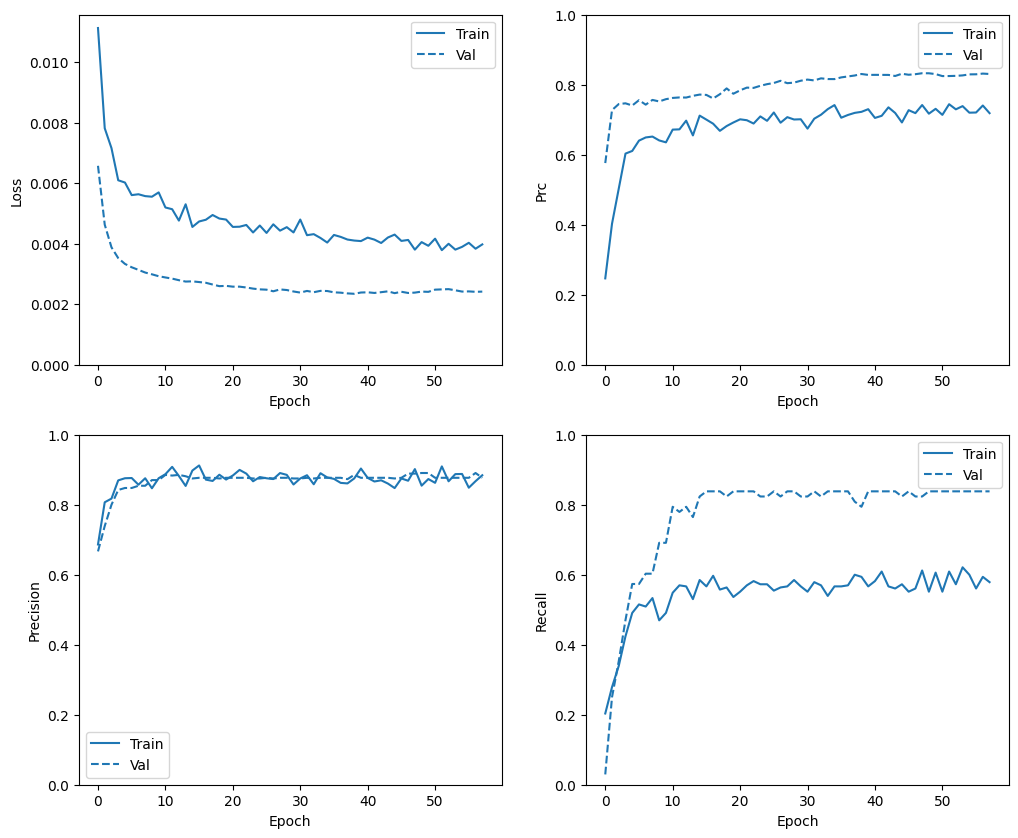

In [30]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.  


Обратите внимание: кривая проверки, как правило, работает лучше, чем кривая обучения. В основном это связано с тем, что при оценке модели неактивен уровень отсева.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label:

In [31]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 1ms/step


74/90 [=======================>......] - ETA: 0s

90/90 [==============================] - 0s 1ms/step


 1/28 [>.............................] - ETA: 1s

28/28 [==============================] - 0s 1ms/step


In [32]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above:

loss :  0.003087446792051196
cross entropy :  0.003087446792051196
Brier score :  0.0005103583098389208
tp :  71.0
fp :  11.0
tn :  56857.0
fn :  23.0
accuracy :  0.9994031190872192
precision :  0.8658536672592163
recall :  0.7553191781044006
auc :  0.9305511116981506
prc :  0.8059941530227661

Legitimate Transactions Detected (True Negatives):  56857
Legitimate Transactions Incorrectly Detected (False Positives):  11
Fraudulent Transactions Missed (False Negatives):  23
Fraudulent Transactions Detected (True Positives):  71
Total Fraudulent Transactions:  94


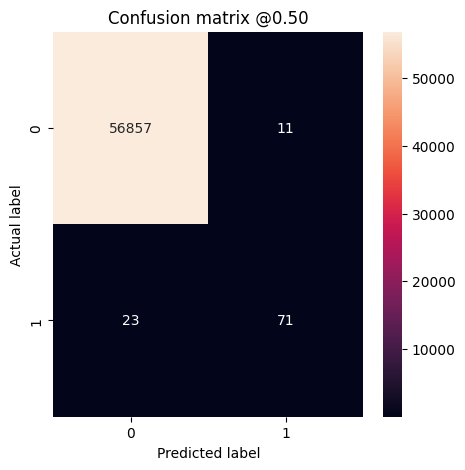

In [33]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly (impossible with true randomness), this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case, the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged.  


Если бы модель предсказала все идеально (что невозможно при истинной случайности), это была бы диагональная матрица, в которой значения вне главной диагонали, указывающие на неверные прогнозы, были бы равны нулю. В этом случае матрица показывает, что у вас относительно мало ложных срабатываний, а это означает, что было относительно немного законных транзакций, которые были неправильно помечены.

### Changing the threshold

The default threshold of $t=50\%$ corresponds to equal costs of false negatives and false positives.
In the case of fraud detection, however, you would likely associate higher costs to false negatives than to false positives.
This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

By decreasing the threshold, we attribute higher cost to false negatives, thereby increasing missed transactions at the price of more false positives.
We test thresholds at 10% and at 1%.

Пороговое значение по умолчанию, равное $t=50\%$, соответствует равной стоимости ложноотрицательных и ложноположительных результатов.
Однако в случае обнаружения мошенничества вы, скорее всего, будете связывать более высокие затраты с ложноотрицательными результатами, чем с ложноположительными результатами.
Этот компромисс может быть предпочтительнее, поскольку ложноотрицательные результаты могут привести к мошенническим транзакциям, в то время как ложноположительные результаты могут привести к отправке клиенту электронного письма с просьбой подтвердить активность своей карты.

Снижая порог, мы увеличиваем стоимость ложных срабатываний, тем самым увеличивая количество пропущенных транзакций ценой большего количества ложных срабатываний.
Мы тестируем пороговые значения на уровне 10% и 1% соответственно.

Legitimate Transactions Detected (True Negatives):  56849
Legitimate Transactions Incorrectly Detected (False Positives):  19
Fraudulent Transactions Missed (False Negatives):  18
Fraudulent Transactions Detected (True Positives):  76
Total Fraudulent Transactions:  94
Legitimate Transactions Detected (True Negatives):  56794
Legitimate Transactions Incorrectly Detected (False Positives):  74
Fraudulent Transactions Missed (False Negatives):  14
Fraudulent Transactions Detected (True Positives):  80
Total Fraudulent Transactions:  94


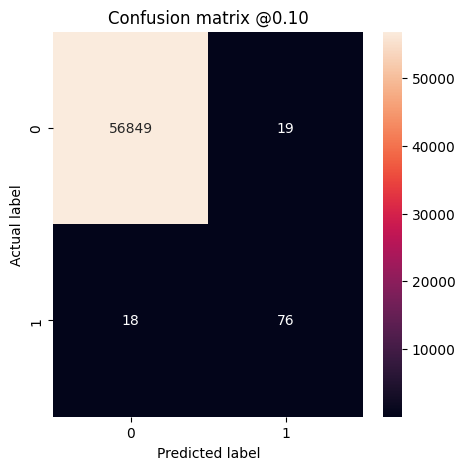

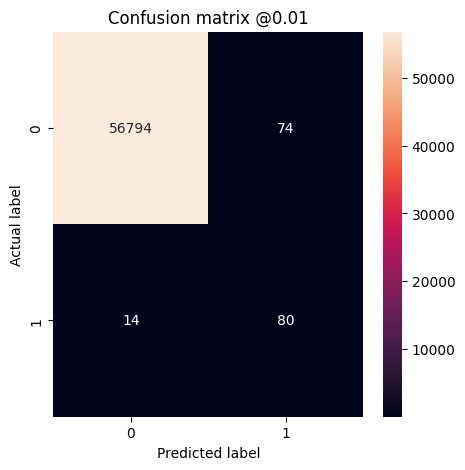

In [34]:
plot_cm(test_labels, test_predictions_baseline, threshold=0.1)
plot_cm(test_labels, test_predictions_baseline, threshold=0.01)

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach by tuning the output threshold over its full range (0 to 1). So each point corresponds to a single value of the threshold.  


Этот график полезен тем, что он сразу показывает диапазон производительности, которого может достичь модель, настроив выходной порог в полном диапазоне (от 0 до 1). Таким образом, каждая точка соответствует отдельному значению порога.

In [35]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

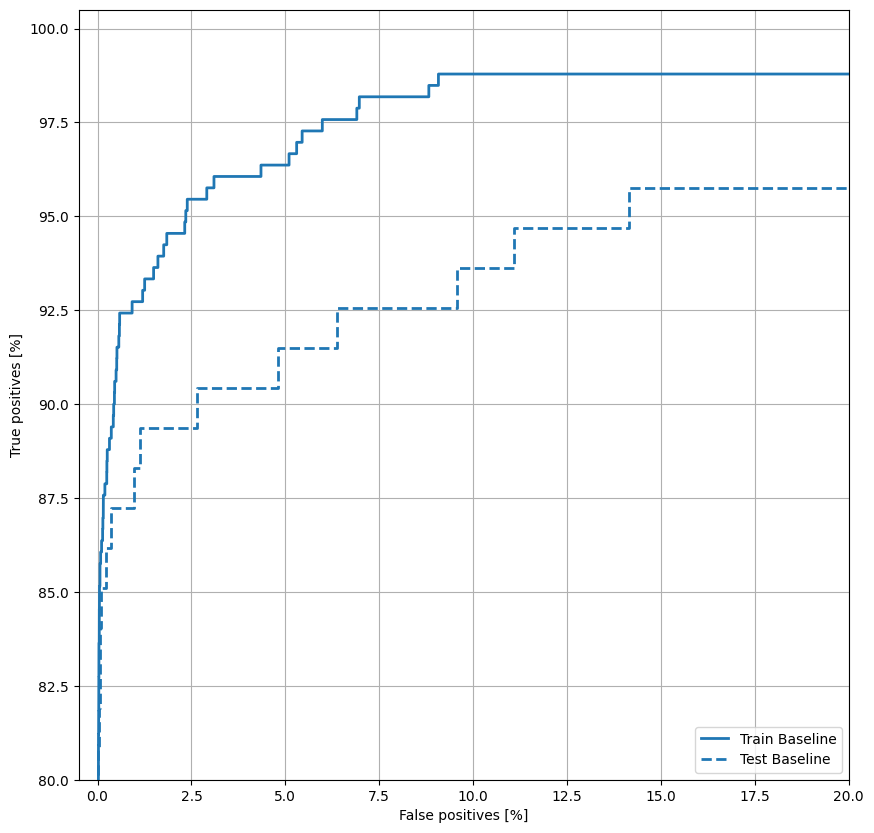

In [36]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

### Plot the PRC

Now plot the [AUPRC](https://developers.google.com/machine-learning/glossary?hl=en#PR_AUC). Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.  


Площадь под интерполированной кривой зависимости точности от повторения, полученной путем построения точек (повторение, точность) для различных значений порога классификации. В зависимости от способа расчета, PR AUC может быть эквивалентен средней точности модели.

In [37]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

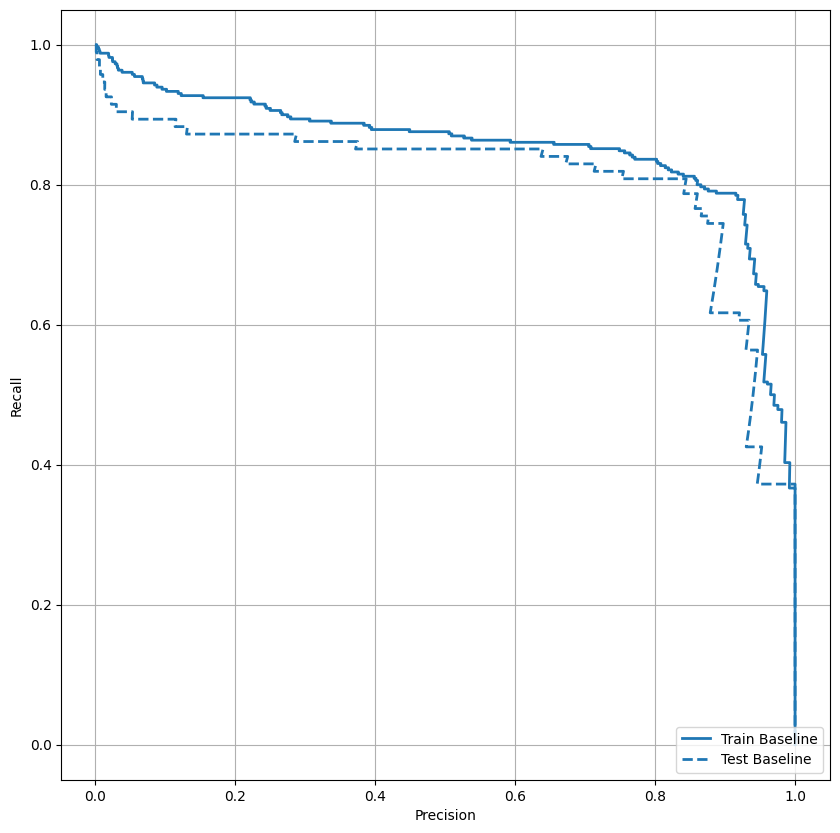

In [38]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

Похоже, что точность относительно высока, но коэффициент запоминания и площадь под кривой ROC (AUC) не так велики, как хотелось бы. Классификаторы часто сталкиваются с трудностями при попытке максимизировать как точность, так и запоминание, что особенно актуально при работе с несбалансированными наборами данных. Важно учитывать стоимость различных типов ошибок в контексте интересующей вас проблемы. В этом примере ложноотрицательный результат (пропущена мошенническая транзакция) может повлечь за собой финансовые издержки, в то время как ложноположительный результат (транзакция неправильно помечена как мошенническая) может снизить удовлетворенность пользователей.

## Class weights

### Calculate class weights

The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class. Note, however, that this does not increase in any way the amount of information of your dataset. In the end, using class weights is more or less equivalent to changing the output bias or to changing the threshold. Let's see how it works out.  


Цель состоит в том, чтобы выявить мошеннические транзакции, но у вас не так много положительных примеров для работы, поэтому вам бы хотелось, чтобы классификатор сильно взвешивал те несколько примеров, которые доступны. Вы можете сделать это, передав значения Keras для каждого класса через параметр. Это заставит модель "уделять больше внимания" примерам из недостаточно представленного класса. Однако обратите внимание, что это никоим образом не увеличивает объем информации в вашем наборе данных. В конечном счете, использование весов классов более или менее эквивалентно изменению смещения выходного сигнала или порогового значения. Давайте посмотрим, что из этого выйдет.

In [39]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `tf.keras.optimizers.SGD`, may fail. The optimizer used here, `tf.keras.optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

Теперь попробуйте провести повторное обучение и оценить модель с использованием весов классов, чтобы увидеть, как это повлияет на прогнозы.


Примечание: Использование class_weights изменяет диапазон потерь. Это может повлиять на стабильность обучения в зависимости от оптимизатора. Оптимизаторы, размер шага которых зависит от величины градиента, такие как tf.keras.optimizers.SGD, могут не работать. Используемый здесь оптимизатор, tf.keras.optimizers.Adam, не подвержен изменению масштабирования. Также обратите внимание, что из-за увеличения веса общие потери между двумя моделями несопоставимы.

In [40]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
90/90 [==============================] - 2s 8ms/step - loss: 2.1653 - cross entropy: 0.0112 - Brier score: 0.0020 - tp: 110.0000 - fp: 215.0000 - tn: 238599.0000 - fn: 314.0000 - accuracy: 0.9978 - precision: 0.3385 - recall: 0.2594 - auc: 0.8036 - prc: 0.2200 - val_loss: 0.0070 - val_cross entropy: 0.0070 - val_Brier score: 0.0012 - val_tp: 15.0000 - val_fp: 10.0000 - val_tn: 45491.0000 - val_fn: 53.0000 - val_accuracy: 0.9986 - val_precision: 0.6000 - val_recall: 0.2206 - val_auc: 0.9544 - val_prc: 0.3822
Epoch 2/100
90/90 [==============================] - 0s 3ms/step - loss: 1.1861 - cross entropy: 0.0172 - Brier score: 0.0033 - tp: 150.0000 - fp: 539.0000 - tn: 181407.0000 - fn: 180.0000 - accuracy: 0.9961 - precision: 0.2177 - recall: 0.4545 - auc: 0.8784 - prc: 0.2809 - val_loss: 0.0080 - val_cross entropy: 0.0080 - val_Brier score: 9.5818e-04 - val_tp: 46.0000 - val_fp: 23.0000 - val_tn: 45478.0000 - val_fn: 22.0000 - val_accuracy: 0.9990 - val_precision: 0.6667 - v

14/90 [===>..........................] - ETA: 0s - loss: 0.9940 - cross entropy: 0.0084 - Brier score: 0.0013 - tp: 98.0000 - fp: 76.0000 - tn: 85406.0000 - fn: 54.0000 - accuracy: 0.9985 - precision: 0.5632 - recall: 0.6447 - auc: 0.8905 - prc: 0.5830      

28/90 [========>.....................] - ETA: 0s - loss: 1.0722 - cross entropy: 0.0108 - Brier score: 0.0017 - tp: 113.0000 - fp: 133.0000 - tn: 113974.0000 - fn: 86.0000 - accuracy: 0.9981 - precision: 0.4593 - recall: 0.5678 - auc: 0.8806 - prc: 0.4900

42/90 [=============>................] - ETA: 0s - loss: 1.0613 - cross entropy: 0.0127 - Brier score: 0.0020 - tp: 131.0000 - fp: 214.0000 - tn: 142520.0000 - fn: 113.0000 - accuracy: 0.9977 - precision: 0.3797 - recall: 0.5369 - auc: 0.8741 - prc: 0.4288

56/90 [=================>............] - ETA: 0s - loss: 1.0522 - cross entropy: 0.0139 - Brier score: 0.0023 - tp: 155.0000 - fp: 298.0000 - tn: 171063.0000 - fn: 134.0000 - accuracy: 0.9975 - precision: 0.3422 - recall: 0.5363 - auc: 0.8677 - prc: 0.4198

69/90 [======================>.......] - ETA: 0s - loss: 1.0039 - cross entropy: 0.0149 - Brier score: 0.0024 - tp: 188.0000 - fp: 369.0000 - tn: 197561.0000 - fn: 156.0000 - accuracy: 0.9974 - precision: 0.3375 - recall: 0.5465 - auc: 0.8797 - prc: 0.4339

82/90 [==========================>...] - ETA: 0s - loss: 0.9389 - cross entropy: 0.0160 - Brier score: 0.0026 - tp: 221.0000 - fp: 475.0000 - tn: 224033.0000 - fn: 169.0000 - accuracy: 0.9971 - precision: 0.3175 - recall: 0.5667 - auc: 0.8832 - prc: 0.4355

90/90 [==============================] - 2s 11ms/step - loss: 0.9262 - cross entropy: 0.0166 - Brier score: 0.0027 - tp: 233.0000 - fp: 530.0000 - tn: 238298.0000 - fn: 177.0000 - accuracy: 0.9970 - precision: 0.3054 - recall: 0.5683 - auc: 0.8803 - prc: 0.4222 - val_loss: 0.0116 - val_cross entropy: 0.0116 - val_Brier score: 0.0011 - val_tp: 67.0000 - val_fp: 35.0000 - val_tn: 45452.0000 - val_fn: 15.0000 - val_accuracy: 0.9989 - val_precision: 0.6569 - val_recall: 0.8171 - val_auc: 0.9519 - val_prc: 0.7255


Epoch 2/100


 1/90 [..............................] - ETA: 0s - loss: 0.5303 - cross entropy: 0.0199 - Brier score: 0.0035 - tp: 3.0000 - fp: 8.0000 - tn: 2036.0000 - fn: 1.0000 - accuracy: 0.9956 - precision: 0.2727 - recall: 0.7500 - auc: 0.9760 - prc: 0.7544

14/90 [===>..........................] - ETA: 0s - loss: 0.8011 - cross entropy: 0.0262 - Brier score: 0.0044 - tp: 39.0000 - fp: 113.0000 - tn: 28500.0000 - fn: 20.0000 - accuracy: 0.9954 - precision: 0.2566 - recall: 0.6610 - auc: 0.9234 - prc: 0.4593

27/90 [========>.....................] - ETA: 0s - loss: 0.6340 - cross entropy: 0.0268 - Brier score: 0.0045 - tp: 63.0000 - fp: 233.0000 - tn: 54969.0000 - fn: 31.0000 - accuracy: 0.9952 - precision: 0.2128 - recall: 0.6702 - auc: 0.9165 - prc: 0.4187

40/90 [============>.................] - ETA: 0s - loss: 0.7264 - cross entropy: 0.0287 - Brier score: 0.0050 - tp: 92.0000 - fp: 387.0000 - tn: 81391.0000 - fn: 50.0000 - accuracy: 0.9947 - precision: 0.1921 - recall: 0.6479 - auc: 0.8954 - prc: 0.4130

53/90 [================>.............] - ETA: 0s - loss: 0.7214 - cross entropy: 0.0293 - Brier score: 0.0052 - tp: 121.0000 - fp: 556.0000 - tn: 107799.0000 - fn: 68.0000 - accuracy: 0.9943 - precision: 0.1787 - recall: 0.6402 - auc: 0.9000 - prc: 0.4210

66/90 [=====================>........] - ETA: 0s - loss: 0.6745 - cross entropy: 0.0301 - Brier score: 0.0055 - tp: 159.0000 - fp: 747.0000 - tn: 134183.0000 - fn: 79.0000 - accuracy: 0.9939 - precision: 0.1755 - recall: 0.6681 - auc: 0.9052 - prc: 0.4546

79/90 [=========================>....] - ETA: 0s - loss: 0.6444 - cross entropy: 0.0312 - Brier score: 0.0058 - tp: 186.0000 - fp: 952.0000 - tn: 160565.0000 - fn: 89.0000 - accuracy: 0.9936 - precision: 0.1634 - recall: 0.6764 - auc: 0.9031 - prc: 0.4457

90/90 [==============================] - 0s 5ms/step - loss: 0.6152 - cross entropy: 0.0319 - Brier score: 0.0059 - tp: 202.0000 - fp: 1117.0000 - tn: 180860.0000 - fn: 97.0000 - accuracy: 0.9933 - precision: 0.1531 - recall: 0.6756 - auc: 0.9051 - prc: 0.4410 - val_loss: 0.0172 - val_cross entropy: 0.0172 - val_Brier score: 0.0019 - val_tp: 69.0000 - val_fp: 72.0000 - val_tn: 45415.0000 - val_fn: 13.0000 - val_accuracy: 0.9981 - val_precision: 0.4894 - val_recall: 0.8415 - val_auc: 0.9577 - val_prc: 0.7220


Epoch 3/100


 1/90 [..............................] - ETA: 0s - loss: 0.0217 - cross entropy: 0.0386 - Brier score: 0.0077 - tp: 4.0000 - fp: 16.0000 - tn: 2028.0000 - fn: 0.0000e+00 - accuracy: 0.9922 - precision: 0.2000 - recall: 1.0000 - auc: 0.9994 - prc: 0.6088

15/90 [====>.........................] - ETA: 0s - loss: 0.2510 - cross entropy: 0.0384 - Brier score: 0.0076 - tp: 38.0000 - fp: 259.0000 - tn: 30414.0000 - fn: 9.0000 - accuracy: 0.9913 - precision: 0.1279 - recall: 0.8085 - auc: 0.9722 - prc: 0.4797 

28/90 [========>.....................] - ETA: 0s - loss: 0.2889 - cross entropy: 0.0402 - Brier score: 0.0078 - tp: 66.0000 - fp: 489.0000 - tn: 56770.0000 - fn: 19.0000 - accuracy: 0.9911 - precision: 0.1189 - recall: 0.7765 - auc: 0.9632 - prc: 0.4072

42/90 [=============>................] - ETA: 0s - loss: 0.4322 - cross entropy: 0.0421 - Brier score: 0.0083 - tp: 111.0000 - fp: 785.0000 - tn: 85085.0000 - fn: 35.0000 - accuracy: 0.9905 - precision: 0.1239 - recall: 0.7603 - auc: 0.9364 - prc: 0.4071

55/90 [=================>............] - ETA: 0s - loss: 0.4096 - cross entropy: 0.0428 - Brier score: 0.0086 - tp: 144.0000 - fp: 1083.0000 - tn: 111370.0000 - fn: 43.0000 - accuracy: 0.9900 - precision: 0.1174 - recall: 0.7701 - auc: 0.9398 - prc: 0.4145

69/90 [======================>.......] - ETA: 0s - loss: 0.4212 - cross entropy: 0.0444 - Brier score: 0.0090 - tp: 185.0000 - fp: 1428.0000 - tn: 139645.0000 - fn: 54.0000 - accuracy: 0.9895 - precision: 0.1147 - recall: 0.7741 - auc: 0.9384 - prc: 0.4218

82/90 [==========================>...] - ETA: 0s - loss: 0.4110 - cross entropy: 0.0453 - Brier score: 0.0093 - tp: 214.0000 - fp: 1756.0000 - tn: 165905.0000 - fn: 61.0000 - accuracy: 0.9892 - precision: 0.1086 - recall: 0.7782 - auc: 0.9360 - prc: 0.4193

90/90 [==============================] - 0s 5ms/step - loss: 0.4397 - cross entropy: 0.0461 - Brier score: 0.0095 - tp: 229.0000 - fp: 1929.0000 - tn: 180048.0000 - fn: 70.0000 - accuracy: 0.9890 - precision: 0.1061 - recall: 0.7659 - auc: 0.9307 - prc: 0.4134 - val_loss: 0.0236 - val_cross entropy: 0.0236 - val_Brier score: 0.0029 - val_tp: 69.0000 - val_fp: 106.0000 - val_tn: 45381.0000 - val_fn: 13.0000 - val_accuracy: 0.9974 - val_precision: 0.3943 - val_recall: 0.8415 - val_auc: 0.9662 - val_prc: 0.7291


Epoch 4/100


 1/90 [..............................] - ETA: 0s - loss: 0.7905 - cross entropy: 0.0650 - Brier score: 0.0155 - tp: 2.0000 - fp: 39.0000 - tn: 2006.0000 - fn: 1.0000 - accuracy: 0.9805 - precision: 0.0488 - recall: 0.6667 - auc: 0.7368 - prc: 0.3339

14/90 [===>..........................] - ETA: 0s - loss: 0.3572 - cross entropy: 0.0557 - Brier score: 0.0121 - tp: 40.0000 - fp: 397.0000 - tn: 28225.0000 - fn: 10.0000 - accuracy: 0.9858 - precision: 0.0915 - recall: 0.8000 - auc: 0.9503 - prc: 0.3879

27/90 [========>.....................] - ETA: 0s - loss: 0.2894 - cross entropy: 0.0547 - Brier score: 0.0116 - tp: 59.0000 - fp: 729.0000 - tn: 54492.0000 - fn: 16.0000 - accuracy: 0.9865 - precision: 0.0749 - recall: 0.7867 - auc: 0.9480 - prc: 0.3778

40/90 [============>.................] - ETA: 0s - loss: 0.3045 - cross entropy: 0.0555 - Brier score: 0.0120 - tp: 92.0000 - fp: 1123.0000 - tn: 80681.0000 - fn: 24.0000 - accuracy: 0.9860 - precision: 0.0757 - recall: 0.7931 - auc: 0.9458 - prc: 0.3813

53/90 [================>.............] - ETA: 0s - loss: 0.3684 - cross entropy: 0.0579 - Brier score: 0.0124 - tp: 137.0000 - fp: 1554.0000 - tn: 106816.0000 - fn: 37.0000 - accuracy: 0.9853 - precision: 0.0810 - recall: 0.7874 - auc: 0.9363 - prc: 0.3819

67/90 [=====================>........] - ETA: 0s - loss: 0.3743 - cross entropy: 0.0594 - Brier score: 0.0130 - tp: 173.0000 - fp: 2080.0000 - tn: 134915.0000 - fn: 48.0000 - accuracy: 0.9845 - precision: 0.0768 - recall: 0.7828 - auc: 0.9375 - prc: 0.3904

80/90 [=========================>....] - ETA: 0s - loss: 0.3658 - cross entropy: 0.0606 - Brier score: 0.0133 - tp: 211.0000 - fp: 2539.0000 - tn: 161033.0000 - fn: 57.0000 - accuracy: 0.9842 - precision: 0.0767 - recall: 0.7873 - auc: 0.9396 - prc: 0.3997

90/90 [==============================] - 0s 5ms/step - loss: 0.4155 - cross entropy: 0.0619 - Brier score: 0.0136 - tp: 231.0000 - fp: 2898.0000 - tn: 179079.0000 - fn: 68.0000 - accuracy: 0.9837 - precision: 0.0738 - recall: 0.7726 - auc: 0.9272 - prc: 0.3804 - val_loss: 0.0319 - val_cross entropy: 0.0319 - val_Brier score: 0.0046 - val_tp: 70.0000 - val_fp: 188.0000 - val_tn: 45299.0000 - val_fn: 12.0000 - val_accuracy: 0.9956 - val_precision: 0.2713 - val_recall: 0.8537 - val_auc: 0.9697 - val_prc: 0.7095


Epoch 5/100


 1/90 [..............................] - ETA: 0s - loss: 0.0342 - cross entropy: 0.0615 - Brier score: 0.0154 - tp: 1.0000 - fp: 40.0000 - tn: 2007.0000 - fn: 0.0000e+00 - accuracy: 0.9805 - precision: 0.0244 - recall: 1.0000 - auc: 0.9990 - prc: 0.1891

14/90 [===>..........................] - ETA: 0s - loss: 0.3195 - cross entropy: 0.0728 - Brier score: 0.0166 - tp: 41.0000 - fp: 558.0000 - tn: 28065.0000 - fn: 8.0000 - accuracy: 0.9803 - precision: 0.0684 - recall: 0.8367 - auc: 0.9453 - prc: 0.4517 

28/90 [========>.....................] - ETA: 0s - loss: 0.3319 - cross entropy: 0.0744 - Brier score: 0.0168 - tp: 78.0000 - fp: 1141.0000 - tn: 56109.0000 - fn: 16.0000 - accuracy: 0.9798 - precision: 0.0640 - recall: 0.8298 - auc: 0.9396 - prc: 0.3985

41/90 [============>.................] - ETA: 0s - loss: 0.3072 - cross entropy: 0.0738 - Brier score: 0.0168 - tp: 111.0000 - fp: 1679.0000 - tn: 82153.0000 - fn: 25.0000 - accuracy: 0.9797 - precision: 0.0620 - recall: 0.8162 - auc: 0.9482 - prc: 0.3973

54/90 [=================>............] - ETA: 0s - loss: 0.2795 - cross entropy: 0.0748 - Brier score: 0.0172 - tp: 150.0000 - fp: 2276.0000 - tn: 108137.0000 - fn: 29.0000 - accuracy: 0.9792 - precision: 0.0618 - recall: 0.8380 - auc: 0.9541 - prc: 0.3929

67/90 [=====================>........] - ETA: 0s - loss: 0.3005 - cross entropy: 0.0760 - Brier score: 0.0175 - tp: 181.0000 - fp: 2873.0000 - tn: 134123.0000 - fn: 39.0000 - accuracy: 0.9788 - precision: 0.0593 - recall: 0.8227 - auc: 0.9501 - prc: 0.3887

80/90 [=========================>....] - ETA: 0s - loss: 0.3032 - cross entropy: 0.0768 - Brier score: 0.0177 - tp: 221.0000 - fp: 3464.0000 - tn: 160106.0000 - fn: 49.0000 - accuracy: 0.9786 - precision: 0.0600 - recall: 0.8185 - auc: 0.9518 - prc: 0.3843

90/90 [==============================] - 0s 5ms/step - loss: 0.3247 - cross entropy: 0.0773 - Brier score: 0.0178 - tp: 241.0000 - fp: 3872.0000 - tn: 178105.0000 - fn: 58.0000 - accuracy: 0.9784 - precision: 0.0586 - recall: 0.8060 - auc: 0.9471 - prc: 0.3673 - val_loss: 0.0405 - val_cross entropy: 0.0405 - val_Brier score: 0.0068 - val_tp: 71.0000 - val_fp: 334.0000 - val_tn: 45153.0000 - val_fn: 11.0000 - val_accuracy: 0.9924 - val_precision: 0.1753 - val_recall: 0.8659 - val_auc: 0.9714 - val_prc: 0.6518


Epoch 6/100


 1/90 [..............................] - ETA: 0s - loss: 0.0522 - cross entropy: 0.1042 - Brier score: 0.0213 - tp: 2.0000 - fp: 47.0000 - tn: 1999.0000 - fn: 0.0000e+00 - accuracy: 0.9771 - precision: 0.0408 - recall: 1.0000 - auc: 0.9993 - prc: 0.4000

14/90 [===>..........................] - ETA: 0s - loss: 0.3362 - cross entropy: 0.0899 - Brier score: 0.0206 - tp: 53.0000 - fp: 704.0000 - tn: 27908.0000 - fn: 7.0000 - accuracy: 0.9752 - precision: 0.0700 - recall: 0.8833 - auc: 0.9490 - prc: 0.3941 

27/90 [========>.....................] - ETA: 0s - loss: 0.3299 - cross entropy: 0.0916 - Brier score: 0.0212 - tp: 92.0000 - fp: 1401.0000 - tn: 53788.0000 - fn: 15.0000 - accuracy: 0.9744 - precision: 0.0616 - recall: 0.8598 - auc: 0.9513 - prc: 0.3898

40/90 [============>.................] - ETA: 0s - loss: 0.3560 - cross entropy: 0.0935 - Brier score: 0.0215 - tp: 124.0000 - fp: 2089.0000 - tn: 79683.0000 - fn: 24.0000 - accuracy: 0.9742 - precision: 0.0560 - recall: 0.8378 - auc: 0.9387 - prc: 0.3511

53/90 [================>.............] - ETA: 0s - loss: 0.3469 - cross entropy: 0.0948 - Brier score: 0.0218 - tp: 154.0000 - fp: 2825.0000 - tn: 105534.0000 - fn: 31.0000 - accuracy: 0.9737 - precision: 0.0517 - recall: 0.8324 - auc: 0.9385 - prc: 0.3267

66/90 [=====================>........] - ETA: 0s - loss: 0.3257 - cross entropy: 0.0964 - Brier score: 0.0221 - tp: 199.0000 - fp: 3543.0000 - tn: 131390.0000 - fn: 36.0000 - accuracy: 0.9735 - precision: 0.0532 - recall: 0.8468 - auc: 0.9449 - prc: 0.3375

79/90 [=========================>....] - ETA: 0s - loss: 0.3322 - cross entropy: 0.0973 - Brier score: 0.0224 - tp: 222.0000 - fp: 4314.0000 - tn: 157212.0000 - fn: 44.0000 - accuracy: 0.9731 - precision: 0.0489 - recall: 0.8346 - auc: 0.9402 - prc: 0.3187

90/90 [==============================] - 0s 6ms/step - loss: 0.3481 - cross entropy: 0.0976 - Brier score: 0.0225 - tp: 248.0000 - fp: 4880.0000 - tn: 177097.0000 - fn: 51.0000 - accuracy: 0.9729 - precision: 0.0484 - recall: 0.8294 - auc: 0.9351 - prc: 0.3069 - val_loss: 0.0494 - val_cross entropy: 0.0494 - val_Brier score: 0.0093 - val_tp: 73.0000 - val_fp: 511.0000 - val_tn: 44976.0000 - val_fn: 9.0000 - val_accuracy: 0.9886 - val_precision: 0.1250 - val_recall: 0.8902 - val_auc: 0.9742 - val_prc: 0.6313


Epoch 7/100


 1/90 [..............................] - ETA: 0s - loss: 0.0729 - cross entropy: 0.0888 - Brier score: 0.0209 - tp: 3.0000 - fp: 52.0000 - tn: 1993.0000 - fn: 0.0000e+00 - accuracy: 0.9746 - precision: 0.0545 - recall: 1.0000 - auc: 0.9954 - prc: 0.1723

14/90 [===>..........................] - ETA: 0s - loss: 0.2449 - cross entropy: 0.1034 - Brier score: 0.0235 - tp: 39.0000 - fp: 812.0000 - tn: 27815.0000 - fn: 6.0000 - accuracy: 0.9715 - precision: 0.0458 - recall: 0.8667 - auc: 0.9623 - prc: 0.2725 

27/90 [========>.....................] - ETA: 0s - loss: 0.3127 - cross entropy: 0.1060 - Brier score: 0.0245 - tp: 75.0000 - fp: 1647.0000 - tn: 53560.0000 - fn: 14.0000 - accuracy: 0.9700 - precision: 0.0436 - recall: 0.8427 - auc: 0.9460 - prc: 0.2709

40/90 [============>.................] - ETA: 0s - loss: 0.2494 - cross entropy: 0.1050 - Brier score: 0.0247 - tp: 111.0000 - fp: 2481.0000 - tn: 79310.0000 - fn: 18.0000 - accuracy: 0.9695 - precision: 0.0428 - recall: 0.8605 - auc: 0.9602 - prc: 0.2886

54/90 [=================>............] - ETA: 0s - loss: 0.2536 - cross entropy: 0.1051 - Brier score: 0.0247 - tp: 146.0000 - fp: 3359.0000 - tn: 107062.0000 - fn: 25.0000 - accuracy: 0.9694 - precision: 0.0417 - recall: 0.8538 - auc: 0.9582 - prc: 0.2867

67/90 [=====================>........] - ETA: 0s - loss: 0.2671 - cross entropy: 0.1073 - Brier score: 0.0252 - tp: 183.0000 - fp: 4249.0000 - tn: 132753.0000 - fn: 31.0000 - accuracy: 0.9688 - precision: 0.0413 - recall: 0.8551 - auc: 0.9547 - prc: 0.2818

80/90 [=========================>....] - ETA: 0s - loss: 0.2768 - cross entropy: 0.1074 - Brier score: 0.0252 - tp: 230.0000 - fp: 5078.0000 - tn: 158495.0000 - fn: 37.0000 - accuracy: 0.9688 - precision: 0.0433 - recall: 0.8614 - auc: 0.9538 - prc: 0.2890

90/90 [==============================] - 0s 5ms/step - loss: 0.2719 - cross entropy: 0.1078 - Brier score: 0.0253 - tp: 257.0000 - fp: 5673.0000 - tn: 176304.0000 - fn: 42.0000 - accuracy: 0.9686 - precision: 0.0433 - recall: 0.8595 - auc: 0.9564 - prc: 0.2894 - val_loss: 0.0565 - val_cross entropy: 0.0565 - val_Brier score: 0.0112 - val_tp: 73.0000 - val_fp: 633.0000 - val_tn: 44854.0000 - val_fn: 9.0000 - val_accuracy: 0.9859 - val_precision: 0.1034 - val_recall: 0.8902 - val_auc: 0.9757 - val_prc: 0.6267


Epoch 8/100


 1/90 [..............................] - ETA: 0s - loss: 0.0599 - cross entropy: 0.1195 - Brier score: 0.0272 - tp: 0.0000e+00 - fp: 69.0000 - tn: 1979.0000 - fn: 0.0000e+00 - accuracy: 0.9663 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

14/90 [===>..........................] - ETA: 0s - loss: 0.2047 - cross entropy: 0.1191 - Brier score: 0.0279 - tp: 37.0000 - fp: 973.0000 - tn: 27658.0000 - fn: 4.0000 - accuracy: 0.9659 - precision: 0.0366 - recall: 0.9024 - auc: 0.9582 - prc: 0.2579                     

27/90 [========>.....................] - ETA: 0s - loss: 0.2056 - cross entropy: 0.1170 - Brier score: 0.0273 - tp: 76.0000 - fp: 1847.0000 - tn: 53365.0000 - fn: 8.0000 - accuracy: 0.9665 - precision: 0.0395 - recall: 0.9048 - auc: 0.9648 - prc: 0.2822

40/90 [============>.................] - ETA: 0s - loss: 0.2763 - cross entropy: 0.1157 - Brier score: 0.0272 - tp: 121.0000 - fp: 2730.0000 - tn: 79053.0000 - fn: 16.0000 - accuracy: 0.9665 - precision: 0.0424 - recall: 0.8832 - auc: 0.9536 - prc: 0.2848

53/90 [================>.............] - ETA: 0s - loss: 0.3031 - cross entropy: 0.1176 - Brier score: 0.0274 - tp: 167.0000 - fp: 3620.0000 - tn: 104732.0000 - fn: 25.0000 - accuracy: 0.9664 - precision: 0.0441 - recall: 0.8698 - auc: 0.9504 - prc: 0.2817

66/90 [=====================>........] - ETA: 0s - loss: 0.2716 - cross entropy: 0.1183 - Brier score: 0.0275 - tp: 198.0000 - fp: 4526.0000 - tn: 130416.0000 - fn: 28.0000 - accuracy: 0.9663 - precision: 0.0419 - recall: 0.8761 - auc: 0.9553 - prc: 0.2646

79/90 [=========================>....] - ETA: 0s - loss: 0.2598 - cross entropy: 0.1183 - Brier score: 0.0276 - tp: 234.0000 - fp: 5455.0000 - tn: 156071.0000 - fn: 32.0000 - accuracy: 0.9661 - precision: 0.0411 - recall: 0.8797 - auc: 0.9557 - prc: 0.2618

90/90 [==============================] - 0s 6ms/step - loss: 0.2623 - cross entropy: 0.1179 - Brier score: 0.0275 - tp: 262.0000 - fp: 6123.0000 - tn: 175854.0000 - fn: 37.0000 - accuracy: 0.9662 - precision: 0.0410 - recall: 0.8763 - auc: 0.9554 - prc: 0.2609 - val_loss: 0.0607 - val_cross entropy: 0.0607 - val_Brier score: 0.0124 - val_tp: 73.0000 - val_fp: 686.0000 - val_tn: 44801.0000 - val_fn: 9.0000 - val_accuracy: 0.9847 - val_precision: 0.0962 - val_recall: 0.8902 - val_auc: 0.9754 - val_prc: 0.6069


Epoch 9/100


 1/90 [..............................] - ETA: 0s - loss: 0.0662 - cross entropy: 0.1258 - Brier score: 0.0290 - tp: 4.0000 - fp: 79.0000 - tn: 1965.0000 - fn: 0.0000e+00 - accuracy: 0.9614 - precision: 0.0482 - recall: 1.0000 - auc: 0.9975 - prc: 0.2897

15/90 [====>.........................] - ETA: 0s - loss: 0.2339 - cross entropy: 0.1266 - Brier score: 0.0294 - tp: 43.0000 - fp: 1125.0000 - tn: 29548.0000 - fn: 4.0000 - accuracy: 0.9632 - precision: 0.0368 - recall: 0.9149 - auc: 0.9515 - prc: 0.2391

28/90 [========>.....................] - ETA: 0s - loss: 0.2905 - cross entropy: 0.1221 - Brier score: 0.0286 - tp: 72.0000 - fp: 2042.0000 - tn: 55220.0000 - fn: 10.0000 - accuracy: 0.9642 - precision: 0.0341 - recall: 0.8780 - auc: 0.9350 - prc: 0.2257

41/90 [============>.................] - ETA: 0s - loss: 0.2432 - cross entropy: 0.1206 - Brier score: 0.0283 - tp: 117.0000 - fp: 2936.0000 - tn: 80903.0000 - fn: 12.0000 - accuracy: 0.9649 - precision: 0.0383 - recall: 0.9070 - auc: 0.9508 - prc: 0.2659

54/90 [=================>............] - ETA: 0s - loss: 0.3018 - cross entropy: 0.1197 - Brier score: 0.0280 - tp: 153.0000 - fp: 3826.0000 - tn: 106589.0000 - fn: 24.0000 - accuracy: 0.9652 - precision: 0.0385 - recall: 0.8644 - auc: 0.9417 - prc: 0.2628

67/90 [=====================>........] - ETA: 0s - loss: 0.2870 - cross entropy: 0.1181 - Brier score: 0.0278 - tp: 191.0000 - fp: 4707.0000 - tn: 132289.0000 - fn: 29.0000 - accuracy: 0.9655 - precision: 0.0390 - recall: 0.8682 - auc: 0.9475 - prc: 0.2607

81/90 [==========================>...] - ETA: 0s - loss: 0.2732 - cross entropy: 0.1185 - Brier score: 0.0279 - tp: 234.0000 - fp: 5715.0000 - tn: 159903.0000 - fn: 36.0000 - accuracy: 0.9653 - precision: 0.0393 - recall: 0.8667 - auc: 0.9540 - prc: 0.2618

90/90 [==============================] - 0s 5ms/step - loss: 0.2915 - cross entropy: 0.1184 - Brier score: 0.0280 - tp: 257.0000 - fp: 6295.0000 - tn: 175682.0000 - fn: 42.0000 - accuracy: 0.9652 - precision: 0.0392 - recall: 0.8595 - auc: 0.9494 - prc: 0.2652 - val_loss: 0.0653 - val_cross entropy: 0.0653 - val_Brier score: 0.0135 - val_tp: 74.0000 - val_fp: 742.0000 - val_tn: 44745.0000 - val_fn: 8.0000 - val_accuracy: 0.9835 - val_precision: 0.0907 - val_recall: 0.9024 - val_auc: 0.9773 - val_prc: 0.5856


Epoch 10/100


 1/90 [..............................] - ETA: 0s - loss: 0.0564 - cross entropy: 0.1126 - Brier score: 0.0305 - tp: 4.0000 - fp: 84.0000 - tn: 1960.0000 - fn: 0.0000e+00 - accuracy: 0.9590 - precision: 0.0455 - recall: 1.0000 - auc: 0.9995 - prc: 0.6667

14/90 [===>..........................] - ETA: 0s - loss: 0.2057 - cross entropy: 0.1256 - Brier score: 0.0300 - tp: 42.0000 - fp: 1068.0000 - tn: 27556.0000 - fn: 6.0000 - accuracy: 0.9625 - precision: 0.0378 - recall: 0.8750 - auc: 0.9742 - prc: 0.3016

27/90 [========>.....................] - ETA: 0s - loss: 0.2650 - cross entropy: 0.1283 - Brier score: 0.0305 - tp: 75.0000 - fp: 2065.0000 - tn: 53141.0000 - fn: 15.0000 - accuracy: 0.9624 - precision: 0.0350 - recall: 0.8333 - auc: 0.9617 - prc: 0.2623

40/90 [============>.................] - ETA: 0s - loss: 0.2633 - cross entropy: 0.1289 - Brier score: 0.0306 - tp: 116.0000 - fp: 3071.0000 - tn: 78712.0000 - fn: 21.0000 - accuracy: 0.9623 - precision: 0.0364 - recall: 0.8467 - auc: 0.9644 - prc: 0.2490

53/90 [================>.............] - ETA: 0s - loss: 0.2632 - cross entropy: 0.1311 - Brier score: 0.0310 - tp: 147.0000 - fp: 4110.0000 - tn: 104260.0000 - fn: 27.0000 - accuracy: 0.9619 - precision: 0.0345 - recall: 0.8448 - auc: 0.9589 - prc: 0.2367

66/90 [=====================>........] - ETA: 0s - loss: 0.2627 - cross entropy: 0.1322 - Brier score: 0.0312 - tp: 184.0000 - fp: 5132.0000 - tn: 129821.0000 - fn: 31.0000 - accuracy: 0.9618 - precision: 0.0346 - recall: 0.8558 - auc: 0.9561 - prc: 0.2383

79/90 [=========================>....] - ETA: 0s - loss: 0.2724 - cross entropy: 0.1329 - Brier score: 0.0313 - tp: 235.0000 - fp: 6183.0000 - tn: 155337.0000 - fn: 37.0000 - accuracy: 0.9616 - precision: 0.0366 - recall: 0.8640 - auc: 0.9546 - prc: 0.2476

90/90 [==============================] - 0s 6ms/step - loss: 0.2632 - cross entropy: 0.1336 - Brier score: 0.0313 - tp: 259.0000 - fp: 6976.0000 - tn: 175001.0000 - fn: 40.0000 - accuracy: 0.9615 - precision: 0.0358 - recall: 0.8662 - auc: 0.9561 - prc: 0.2365 - val_loss: 0.0700 - val_cross entropy: 0.0700 - val_Brier score: 0.0146 - val_tp: 76.0000 - val_fp: 801.0000 - val_tn: 44686.0000 - val_fn: 6.0000 - val_accuracy: 0.9823 - val_precision: 0.0867 - val_recall: 0.9268 - val_auc: 0.9773 - val_prc: 0.5876


Epoch 11/100


 1/90 [..............................] - ETA: 0s - loss: 0.0667 - cross entropy: 0.1329 - Brier score: 0.0324 - tp: 1.0000 - fp: 77.0000 - tn: 1970.0000 - fn: 0.0000e+00 - accuracy: 0.9624 - precision: 0.0128 - recall: 1.0000 - auc: 0.9988 - prc: 0.1667

14/90 [===>..........................] - ETA: 0s - loss: 0.3013 - cross entropy: 0.1255 - Brier score: 0.0303 - tp: 40.0000 - fp: 1066.0000 - tn: 27560.0000 - fn: 6.0000 - accuracy: 0.9626 - precision: 0.0362 - recall: 0.8696 - auc: 0.9384 - prc: 0.2439

27/90 [========>.....................] - ETA: 0s - loss: 0.2414 - cross entropy: 0.1266 - Brier score: 0.0302 - tp: 77.0000 - fp: 2039.0000 - tn: 53170.0000 - fn: 10.0000 - accuracy: 0.9629 - precision: 0.0364 - recall: 0.8851 - auc: 0.9563 - prc: 0.2411

40/90 [============>.................] - ETA: 0s - loss: 0.2574 - cross entropy: 0.1284 - Brier score: 0.0305 - tp: 110.0000 - fp: 3063.0000 - tn: 78733.0000 - fn: 14.0000 - accuracy: 0.9624 - precision: 0.0347 - recall: 0.8871 - auc: 0.9461 - prc: 0.2214

53/90 [================>.............] - ETA: 0s - loss: 0.2421 - cross entropy: 0.1287 - Brier score: 0.0304 - tp: 152.0000 - fp: 4041.0000 - tn: 104334.0000 - fn: 17.0000 - accuracy: 0.9626 - precision: 0.0363 - recall: 0.8994 - auc: 0.9515 - prc: 0.2331

66/90 [=====================>........] - ETA: 0s - loss: 0.2238 - cross entropy: 0.1289 - Brier score: 0.0303 - tp: 191.0000 - fp: 5008.0000 - tn: 129949.0000 - fn: 20.0000 - accuracy: 0.9628 - precision: 0.0367 - recall: 0.9052 - auc: 0.9576 - prc: 0.2392

79/90 [=========================>....] - ETA: 0s - loss: 0.2255 - cross entropy: 0.1282 - Brier score: 0.0300 - tp: 235.0000 - fp: 5956.0000 - tn: 155576.0000 - fn: 25.0000 - accuracy: 0.9630 - precision: 0.0380 - recall: 0.9038 - auc: 0.9595 - prc: 0.2481

90/90 [==============================] - 1s 6ms/step - loss: 0.2336 - cross entropy: 0.1282 - Brier score: 0.0299 - tp: 269.0000 - fp: 6690.0000 - tn: 175287.0000 - fn: 30.0000 - accuracy: 0.9631 - precision: 0.0387 - recall: 0.8997 - auc: 0.9586 - prc: 0.2494 - val_loss: 0.0679 - val_cross entropy: 0.0679 - val_Brier score: 0.0140 - val_tp: 76.0000 - val_fp: 757.0000 - val_tn: 44730.0000 - val_fn: 6.0000 - val_accuracy: 0.9833 - val_precision: 0.0912 - val_recall: 0.9268 - val_auc: 0.9777 - val_prc: 0.5891


Epoch 12/100


 1/90 [..............................] - ETA: 0s - loss: 0.4784 - cross entropy: 0.1336 - Brier score: 0.0310 - tp: 0.0000e+00 - fp: 74.0000 - tn: 1972.0000 - fn: 2.0000 - accuracy: 0.9629 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9174 - prc: 0.0061

14/90 [===>..........................] - ETA: 0s - loss: 0.2320 - cross entropy: 0.1245 - Brier score: 0.0296 - tp: 27.0000 - fp: 1041.0000 - tn: 27596.0000 - fn: 8.0000 - accuracy: 0.9634 - precision: 0.0253 - recall: 0.7714 - auc: 0.9605 - prc: 0.1987        

27/90 [========>.....................] - ETA: 0s - loss: 0.2441 - cross entropy: 0.1275 - Brier score: 0.0299 - tp: 68.0000 - fp: 2051.0000 - tn: 53164.0000 - fn: 13.0000 - accuracy: 0.9627 - precision: 0.0321 - recall: 0.8395 - auc: 0.9610 - prc: 0.2322

40/90 [============>.................] - ETA: 0s - loss: 0.2469 - cross entropy: 0.1293 - Brier score: 0.0301 - tp: 105.0000 - fp: 3023.0000 - tn: 78774.0000 - fn: 18.0000 - accuracy: 0.9629 - precision: 0.0336 - recall: 0.8537 - auc: 0.9604 - prc: 0.2284

53/90 [================>.............] - ETA: 0s - loss: 0.2245 - cross entropy: 0.1313 - Brier score: 0.0303 - tp: 136.0000 - fp: 4028.0000 - tn: 104359.0000 - fn: 21.0000 - accuracy: 0.9627 - precision: 0.0327 - recall: 0.8662 - auc: 0.9632 - prc: 0.2235

65/90 [====================>.........] - ETA: 0s - loss: 0.2408 - cross entropy: 0.1315 - Brier score: 0.0304 - tp: 166.0000 - fp: 4944.0000 - tn: 127984.0000 - fn: 26.0000 - accuracy: 0.9627 - precision: 0.0325 - recall: 0.8646 - auc: 0.9557 - prc: 0.2181

78/90 [=========================>....] - ETA: 0s - loss: 0.2257 - cross entropy: 0.1299 - Brier score: 0.0301 - tp: 208.0000 - fp: 5893.0000 - tn: 153615.0000 - fn: 28.0000 - accuracy: 0.9629 - precision: 0.0341 - recall: 0.8814 - auc: 0.9595 - prc: 0.2348

90/90 [==============================] - 1s 6ms/step - loss: 0.2399 - cross entropy: 0.1289 - Brier score: 0.0298 - tp: 265.0000 - fp: 6654.0000 - tn: 175323.0000 - fn: 34.0000 - accuracy: 0.9633 - precision: 0.0383 - recall: 0.8863 - auc: 0.9602 - prc: 0.2601 - val_loss: 0.0684 - val_cross entropy: 0.0684 - val_Brier score: 0.0141 - val_tp: 76.0000 - val_fp: 762.0000 - val_tn: 44725.0000 - val_fn: 6.0000 - val_accuracy: 0.9831 - val_precision: 0.0907 - val_recall: 0.9268 - val_auc: 0.9784 - val_prc: 0.5848


Epoch 13/100


 1/90 [..............................] - ETA: 0s - loss: 0.0556 - cross entropy: 0.1110 - Brier score: 0.0280 - tp: 2.0000 - fp: 73.0000 - tn: 1973.0000 - fn: 0.0000e+00 - accuracy: 0.9644 - precision: 0.0267 - recall: 1.0000 - auc: 0.9990 - prc: 0.3333

14/90 [===>..........................] - ETA: 0s - loss: 0.2314 - cross entropy: 0.1289 - Brier score: 0.0299 - tp: 44.0000 - fp: 1032.0000 - tn: 27592.0000 - fn: 4.0000 - accuracy: 0.9639 - precision: 0.0409 - recall: 0.9167 - auc: 0.9651 - prc: 0.3002

27/90 [========>.....................] - ETA: 0s - loss: 0.1991 - cross entropy: 0.1266 - Brier score: 0.0295 - tp: 86.0000 - fp: 1991.0000 - tn: 53212.0000 - fn: 7.0000 - accuracy: 0.9639 - precision: 0.0414 - recall: 0.9247 - auc: 0.9732 - prc: 0.3105

40/90 [============>.................] - ETA: 0s - loss: 0.2023 - cross entropy: 0.1258 - Brier score: 0.0294 - tp: 122.0000 - fp: 2947.0000 - tn: 78836.0000 - fn: 15.0000 - accuracy: 0.9638 - precision: 0.0398 - recall: 0.8905 - auc: 0.9760 - prc: 0.2958

53/90 [================>.............] - ETA: 0s - loss: 0.2163 - cross entropy: 0.1244 - Brier score: 0.0291 - tp: 165.0000 - fp: 3854.0000 - tn: 104502.0000 - fn: 23.0000 - accuracy: 0.9643 - precision: 0.0411 - recall: 0.8777 - auc: 0.9731 - prc: 0.2994

66/90 [=====================>........] - ETA: 0s - loss: 0.2148 - cross entropy: 0.1253 - Brier score: 0.0293 - tp: 196.0000 - fp: 4846.0000 - tn: 130100.0000 - fn: 26.0000 - accuracy: 0.9640 - precision: 0.0389 - recall: 0.8829 - auc: 0.9712 - prc: 0.2749

79/90 [=========================>....] - ETA: 0s - loss: 0.2286 - cross entropy: 0.1265 - Brier score: 0.0295 - tp: 237.0000 - fp: 5838.0000 - tn: 155684.0000 - fn: 33.0000 - accuracy: 0.9637 - precision: 0.0390 - recall: 0.8778 - auc: 0.9696 - prc: 0.2645

Restoring model weights from the end of the best epoch: 3.


90/90 [==============================] - 1s 6ms/step - loss: 0.2341 - cross entropy: 0.1275 - Brier score: 0.0297 - tp: 262.0000 - fp: 6631.0000 - tn: 175346.0000 - fn: 37.0000 - accuracy: 0.9634 - precision: 0.0380 - recall: 0.8763 - auc: 0.9665 - prc: 0.2538 - val_loss: 0.0757 - val_cross entropy: 0.0757 - val_Brier score: 0.0159 - val_tp: 76.0000 - val_fp: 834.0000 - val_tn: 44653.0000 - val_fn: 6.0000 - val_accuracy: 0.9816 - val_precision: 0.0835 - val_recall: 0.9268 - val_auc: 0.9789 - val_prc: 0.5709


Epoch 13: early stopping


### Check training history

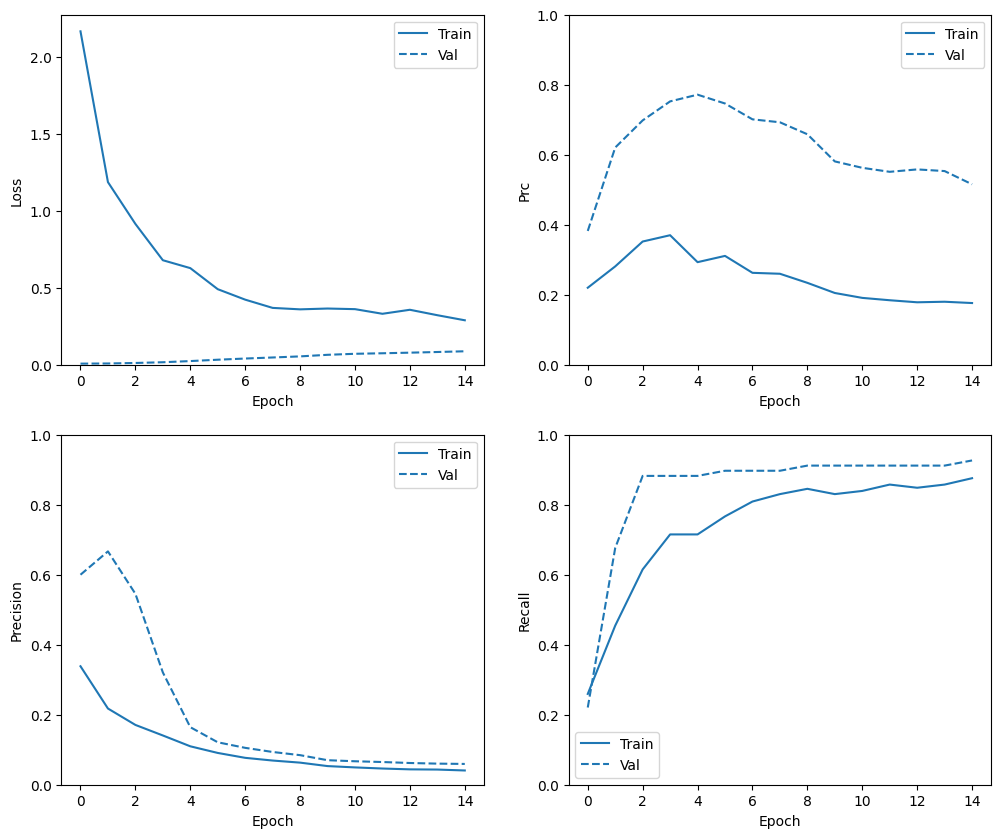

In [41]:
plot_metrics(weighted_history)

### Evaluate metrics

In [42]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 1ms/step


73/90 [=======================>......] - ETA: 0s

90/90 [==============================] - 0s 1ms/step


 1/28 [>.............................] - ETA: 1s

28/28 [==============================] - 0s 1ms/step


loss :  0.024976838380098343
cross entropy :  0.024976838380098343
Brier score :  0.00452674413099885
tp :  79.0
fp :  344.0
tn :  56524.0
fn :  15.0
accuracy :  0.9936975240707397
precision :  0.18676123023033142
recall :  0.8404255509376526
auc :  0.9709666967391968
prc :  0.6714684963226318

Legitimate Transactions Detected (True Negatives):  56524
Legitimate Transactions Incorrectly Detected (False Positives):  344
Fraudulent Transactions Missed (False Negatives):  15
Fraudulent Transactions Detected (True Positives):  79
Total Fraudulent Transactions:  94


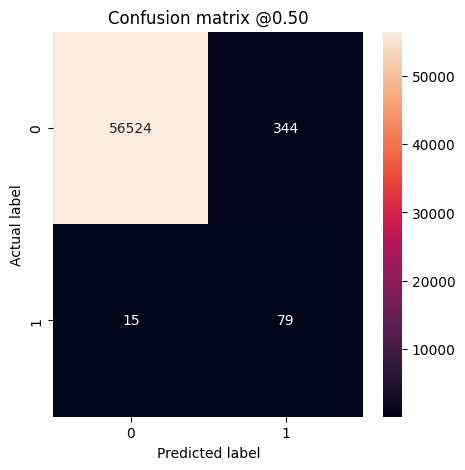

In [43]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions than the baseline model at threshold 50%). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

Compared to the baseline model with changed threshold, the class weighted model is clearly inferior. The superiority of the baseline model is further confirmed by the lower test loss value (cross entropy and mean squared error) and additionally can be seen by plotting the ROC curves of both models together.

Здесь вы можете видеть, что при использовании весовых коэффициентов классов точность ниже, потому что больше ложных срабатываний, но, наоборот, отзыв и AUC выше, потому что модель также обнаружила больше истинных срабатываний. Несмотря на меньшую точность, эта модель лучше запоминается (и выявляет больше мошеннических транзакций, чем базовая модель, при пороговом значении 50%). Конечно, за оба типа ошибок приходится платить (вы же не хотите, чтобы пользователи ошибались, помечая слишком много законных транзакций как мошеннические). Тщательно продумайте возможные компромиссы между этими различными типами ошибок для вашего приложения.


По сравнению с базовой моделью с измененным пороговым значением модель, взвешенная по классу, явно уступает. Превосходство базовой модели дополнительно подтверждается более низким значением потерь при тестировании (перекрестная энтропия и среднеквадратичная ошибка), что дополнительно можно увидеть, построив ROC-кривые для обеих моделей вместе.

### Plot the ROC

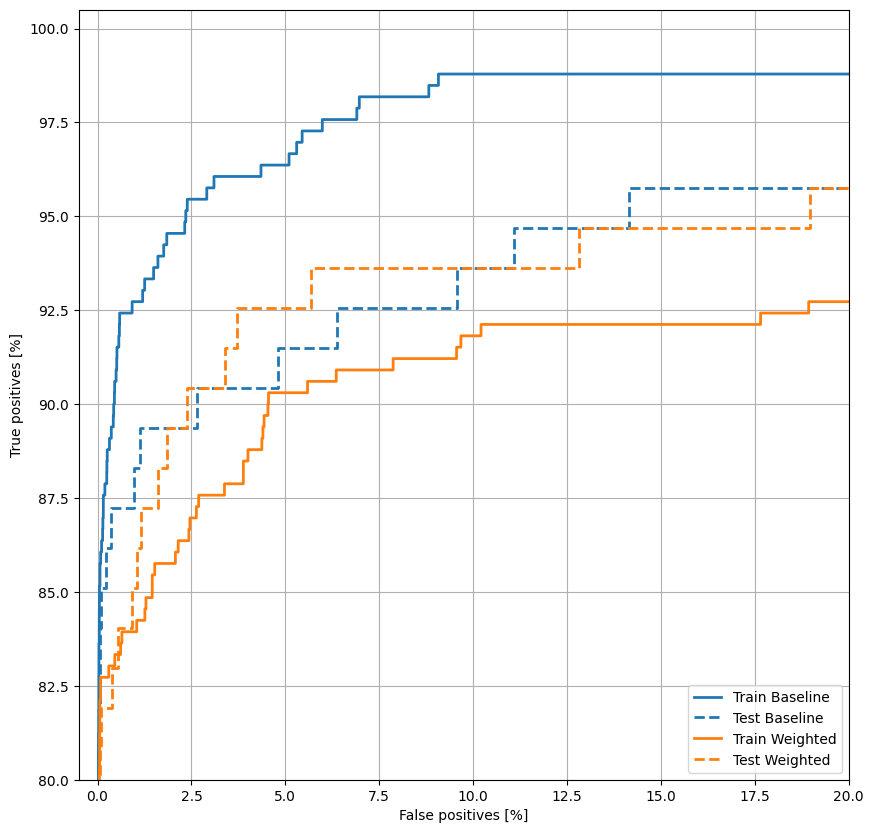

In [44]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

### Plot the PRC

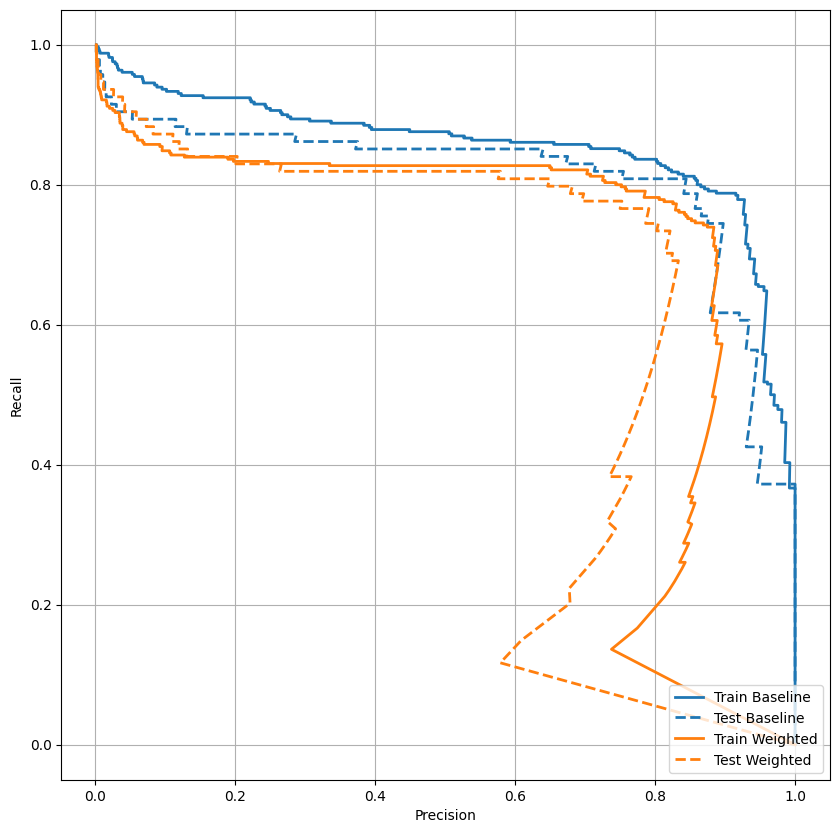

In [45]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.


Аналогичный подход мог бы заключаться в повторной выборке набора данных путем повторной выборки класса меньшинств.

In [46]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### Using NumPy

You can balance the dataset manually by choosing the right number of random 
indices from the positive examples:


Вы можете сбалансировать набор данных вручную, выбрав нужное количество случайных индексов из положительных примеров:

In [47]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181946, 29)

In [48]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363892, 29)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [49]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [52]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-0.47243817  2.06572067 -4.22803972  3.47451242 -1.59520424 -1.70986607
 -4.49874941  1.10513175 -3.92523091 -5.          5.         -5.
 -0.31717929 -5.         -0.14779525 -5.         -5.         -4.57978919
  1.23710114  1.43068024  1.42857761 -0.71860439 -0.49631881 -0.66867631
  1.73087599  2.4185055   3.35089525  2.16094822 -4.87208297]

Label:  1


Merge the two together using `tf.data.Dataset.sample_from_datasets`:

In [53]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [54]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.5126953125


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [55]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 


Теперь попробуйте обучить модель с помощью набора данных с повторной выборкой вместо использования весовых коэффициентов классов, чтобы увидеть, как сравниваются эти методы.

Примечание: Поскольку данные были сбалансированы путем воспроизведения положительных примеров, общий размер набора данных увеличился, и каждая эпоха требует большего количества этапов обучения.

In [56]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 5s 15ms/step - loss: 0.3613 - cross entropy: 0.3307 - Brier score: 0.1064 - tp: 236451.0000 - fp: 46910.0000 - tn: 294460.0000 - fn: 48485.0000 - accuracy: 0.8477 - precision: 0.8345 - recall: 0.8298 - auc: 0.9287 - prc: 0.9338 - val_loss: 0.1867 - val_cross entropy: 0.1867 - val_Brier score: 0.0415 - val_tp: 64.0000 - val_fp: 1336.0000 - val_tn: 44165.0000 - val_fn: 4.0000 - val_accuracy: 0.9706 - val_precision: 0.0457 - val_recall: 0.9412 - val_auc: 0.9779 - val_prc: 0.7465
Epoch 2/100
278/278 [==============================] - 4s 13ms/step - loss: 0.2023 - cross entropy: 0.2023 - Brier score: 0.0610 - tp: 250751.0000 - fp: 13240.0000 - tn: 271387.0000 - fn: 33966.0000 - accuracy: 0.9171 - precision: 0.9498 - recall: 0.8807 - auc: 0.9734 - prc: 0.9781 - val_loss: 0.1077 - val_cross entropy: 0.1077 - val_Brier score: 0.0228 - val_tp: 63.0000 - val_fp: 959.0000 - val_tn: 44542.0000 - val_fn: 5.0000 - val_accuracy: 0.9788 - val_prec

  5/278 [..............................] - ETA: 3s - loss: 0.7286 - cross entropy: 0.1320 - Brier score: 0.0412 - tp: 4604.0000 - fp: 3754.0000 - tn: 58159.0000 - fn: 685.0000 - accuracy: 0.9339 - precision: 0.5508 - recall: 0.8705 - auc: 0.9818 - prc: 0.8537

  8/278 [..............................] - ETA: 4s - loss: 0.7176 - cross entropy: 0.1795 - Brier score: 0.0583 - tp: 7398.0000 - fp: 5889.0000 - tn: 59021.0000 - fn: 1038.0000 - accuracy: 0.9056 - precision: 0.5568 - recall: 0.8770 - auc: 0.9749 - prc: 0.8635

 11/278 [>.............................] - ETA: 5s - loss: 0.7100 - cross entropy: 0.2189 - Brier score: 0.0725 - tp: 10116.0000 - fp: 8029.0000 - tn: 59941.0000 - fn: 1404.0000 - accuracy: 0.8813 - precision: 0.5575 - recall: 0.8781 - auc: 0.9685 - prc: 0.8678

 14/278 [>.............................] - ETA: 5s - loss: 0.6957 - cross entropy: 0.2494 - Brier score: 0.0837 - tp: 12913.0000 - fp: 10062.0000 - tn: 60929.0000 - fn: 1730.0000 - accuracy: 0.8623 - precision: 0.5620 - recall: 0.8819 - auc: 0.9636 - prc: 0.8739

 17/278 [>.............................] - ETA: 5s - loss: 0.6869 - cross entropy: 0.2759 - Brier score: 0.0934 - tp: 15650.0000 - fp: 12093.0000 - tn: 61958.0000 - fn: 2077.0000 - accuracy: 0.8456 - precision: 0.5641 - recall: 0.8828 - auc: 0.9588 - prc: 0.8772

 20/278 [=>............................] - ETA: 5s - loss: 0.6796 - cross entropy: 0.2986 - Brier score: 0.1017 - tp: 18384.0000 - fp: 14142.0000 - tn: 63014.0000 - fn: 2382.0000 - accuracy: 0.8313 - precision: 0.5652 - recall: 0.8853 - auc: 0.9547 - prc: 0.8801

 23/278 [=>............................] - ETA: 4s - loss: 0.6697 - cross entropy: 0.3166 - Brier score: 0.1084 - tp: 21193.0000 - fp: 16082.0000 - tn: 64105.0000 - fn: 2686.0000 - accuracy: 0.8197 - precision: 0.5686 - recall: 0.8875 - auc: 0.9515 - prc: 0.8836

 26/278 [=>............................] - ETA: 4s - loss: 0.6619 - cross entropy: 0.3326 - Brier score: 0.1142 - tp: 23941.0000 - fp: 17992.0000 - tn: 65265.0000 - fn: 3012.0000 - accuracy: 0.8094 - precision: 0.5709 - recall: 0.8882 - auc: 0.9482 - prc: 0.8859

 29/278 [==>...........................] - ETA: 4s - loss: 0.6555 - cross entropy: 0.3467 - Brier score: 0.1194 - tp: 26734.0000 - fp: 19935.0000 - tn: 66369.0000 - fn: 3316.0000 - accuracy: 0.8002 - precision: 0.5728 - recall: 0.8897 - auc: 0.9454 - prc: 0.8882

 32/278 [==>...........................] - ETA: 4s - loss: 0.6488 - cross entropy: 0.3586 - Brier score: 0.1239 - tp: 29480.0000 - fp: 21839.0000 - tn: 67551.0000 - fn: 3628.0000 - accuracy: 0.7921 - precision: 0.5744 - recall: 0.8904 - auc: 0.9429 - prc: 0.8904

 35/278 [==>...........................] - ETA: 4s - loss: 0.6415 - cross entropy: 0.3684 - Brier score: 0.1276 - tp: 32224.0000 - fp: 23706.0000 - tn: 68816.0000 - fn: 3896.0000 - accuracy: 0.7854 - precision: 0.5761 - recall: 0.8921 - auc: 0.9411 - prc: 0.8928

 38/278 [===>..........................] - ETA: 4s - loss: 0.6354 - cross entropy: 0.3773 - Brier score: 0.1310 - tp: 34998.0000 - fp: 25518.0000 - tn: 70087.0000 - fn: 4183.0000 - accuracy: 0.7796 - precision: 0.5783 - recall: 0.8932 - auc: 0.9392 - prc: 0.8948

 41/278 [===>..........................] - ETA: 4s - loss: 0.6285 - cross entropy: 0.3845 - Brier score: 0.1336 - tp: 37772.0000 - fp: 27229.0000 - tn: 71474.0000 - fn: 4455.0000 - accuracy: 0.7752 - precision: 0.5811 - recall: 0.8945 - auc: 0.9379 - prc: 0.8970

 44/278 [===>..........................] - ETA: 4s - loss: 0.6231 - cross entropy: 0.3913 - Brier score: 0.1361 - tp: 40522.0000 - fp: 28939.0000 - tn: 72868.0000 - fn: 4745.0000 - accuracy: 0.7710 - precision: 0.5834 - recall: 0.8952 - auc: 0.9365 - prc: 0.8986

 47/278 [====>.........................] - ETA: 4s - loss: 0.6166 - cross entropy: 0.3965 - Brier score: 0.1380 - tp: 43303.0000 - fp: 30556.0000 - tn: 74324.0000 - fn: 5035.0000 - accuracy: 0.7677 - precision: 0.5863 - recall: 0.8958 - auc: 0.9353 - prc: 0.9004

 50/278 [====>.........................] - ETA: 4s - loss: 0.6106 - cross entropy: 0.4012 - Brier score: 0.1397 - tp: 46041.0000 - fp: 32185.0000 - tn: 75835.0000 - fn: 5301.0000 - accuracy: 0.7648 - precision: 0.5886 - recall: 0.8968 - auc: 0.9344 - prc: 0.9021

 53/278 [====>.........................] - ETA: 4s - loss: 0.6044 - cross entropy: 0.4049 - Brier score: 0.1412 - tp: 48835.0000 - fp: 33753.0000 - tn: 77326.0000 - fn: 5592.0000 - accuracy: 0.7623 - precision: 0.5913 - recall: 0.8973 - auc: 0.9334 - prc: 0.9037

 56/278 [=====>........................] - ETA: 4s - loss: 0.5977 - cross entropy: 0.4076 - Brier score: 0.1422 - tp: 51632.0000 - fp: 35227.0000 - tn: 78923.0000 - fn: 5868.0000 - accuracy: 0.7606 - precision: 0.5944 - recall: 0.8979 - auc: 0.9327 - prc: 0.9053

 59/278 [=====>........................] - ETA: 4s - loss: 0.5912 - cross entropy: 0.4097 - Brier score: 0.1430 - tp: 54428.0000 - fp: 36650.0000 - tn: 80587.0000 - fn: 6129.0000 - accuracy: 0.7594 - precision: 0.5976 - recall: 0.8988 - auc: 0.9324 - prc: 0.9071

 62/278 [=====>........................] - ETA: 4s - loss: 0.5853 - cross entropy: 0.4117 - Brier score: 0.1437 - tp: 57221.0000 - fp: 38054.0000 - tn: 82283.0000 - fn: 6380.0000 - accuracy: 0.7584 - precision: 0.6006 - recall: 0.8997 - auc: 0.9320 - prc: 0.9087

 65/278 [======>.......................] - ETA: 4s - loss: 0.5791 - cross entropy: 0.4130 - Brier score: 0.1442 - tp: 60031.0000 - fp: 39389.0000 - tn: 84000.0000 - fn: 6662.0000 - accuracy: 0.7577 - precision: 0.6038 - recall: 0.9001 - auc: 0.9316 - prc: 0.9101

 68/278 [======>.......................] - ETA: 4s - loss: 0.5736 - cross entropy: 0.4143 - Brier score: 0.1446 - tp: 62772.0000 - fp: 40630.0000 - tn: 85852.0000 - fn: 6972.0000 - accuracy: 0.7574 - precision: 0.6071 - recall: 0.9000 - auc: 0.9312 - prc: 0.9113

 71/278 [======>.......................] - ETA: 3s - loss: 0.5679 - cross entropy: 0.4150 - Brier score: 0.1448 - tp: 65544.0000 - fp: 41842.0000 - tn: 87713.0000 - fn: 7271.0000 - accuracy: 0.7573 - precision: 0.6104 - recall: 0.9001 - auc: 0.9308 - prc: 0.9125

 74/278 [======>.......................] - ETA: 3s - loss: 0.5622 - cross entropy: 0.4154 - Brier score: 0.1449 - tp: 68335.0000 - fp: 43025.0000 - tn: 89613.0000 - fn: 7541.0000 - accuracy: 0.7575 - precision: 0.6136 - recall: 0.9006 - auc: 0.9307 - prc: 0.9139

 77/278 [=======>......................] - ETA: 3s - loss: 0.5570 - cross entropy: 0.4157 - Brier score: 0.1450 - tp: 71070.0000 - fp: 44209.0000 - tn: 91554.0000 - fn: 7825.0000 - accuracy: 0.7576 - precision: 0.6165 - recall: 0.9008 - auc: 0.9306 - prc: 0.9150

 80/278 [=======>......................] - ETA: 3s - loss: 0.5516 - cross entropy: 0.4157 - Brier score: 0.1449 - tp: 73875.0000 - fp: 45315.0000 - tn: 93524.0000 - fn: 8088.0000 - accuracy: 0.7581 - precision: 0.6198 - recall: 0.9013 - auc: 0.9306 - prc: 0.9163

 83/278 [=======>......................] - ETA: 3s - loss: 0.5466 - cross entropy: 0.4156 - Brier score: 0.1449 - tp: 76640.0000 - fp: 46408.0000 - tn: 95528.0000 - fn: 8370.0000 - accuracy: 0.7586 - precision: 0.6228 - recall: 0.9015 - auc: 0.9306 - prc: 0.9174

 86/278 [========>.....................] - ETA: 3s - loss: 0.5415 - cross entropy: 0.4152 - Brier score: 0.1447 - tp: 79455.0000 - fp: 47477.0000 - tn: 97518.0000 - fn: 8640.0000 - accuracy: 0.7592 - precision: 0.6260 - recall: 0.9019 - auc: 0.9307 - prc: 0.9186

 89/278 [========>.....................] - ETA: 3s - loss: 0.5365 - cross entropy: 0.4146 - Brier score: 0.1443 - tp: 82276.0000 - fp: 48443.0000 - tn: 99591.0000 - fn: 8924.0000 - accuracy: 0.7602 - precision: 0.6294 - recall: 0.9021 - auc: 0.9307 - prc: 0.9197

 92/278 [========>.....................] - ETA: 3s - loss: 0.5319 - cross entropy: 0.4142 - Brier score: 0.1441 - tp: 85045.0000 - fp: 49398.0000 - tn: 101716.0000 - fn: 9219.0000 - accuracy: 0.7611 - precision: 0.6326 - recall: 0.9022 - auc: 0.9308 - prc: 0.9206

 95/278 [=========>....................] - ETA: 3s - loss: 0.5270 - cross entropy: 0.4133 - Brier score: 0.1437 - tp: 87819.0000 - fp: 50277.0000 - tn: 103902.0000 - fn: 9524.0000 - accuracy: 0.7622 - precision: 0.6359 - recall: 0.9022 - auc: 0.9309 - prc: 0.9216

 98/278 [=========>....................] - ETA: 3s - loss: 0.5224 - cross entropy: 0.4124 - Brier score: 0.1433 - tp: 90606.0000 - fp: 51158.0000 - tn: 106089.0000 - fn: 9813.0000 - accuracy: 0.7634 - precision: 0.6391 - recall: 0.9023 - auc: 0.9309 - prc: 0.9225

101/278 [=========>....................] - ETA: 3s - loss: 0.5179 - cross entropy: 0.4114 - Brier score: 0.1428 - tp: 93365.0000 - fp: 51995.0000 - tn: 108350.0000 - fn: 10100.0000 - accuracy: 0.7646 - precision: 0.6423 - recall: 0.9024 - auc: 0.9311 - prc: 0.9233

103/278 [==========>...................] - ETA: 3s - loss: 0.5150 - cross entropy: 0.4108 - Brier score: 0.1425 - tp: 95215.0000 - fp: 52548.0000 - tn: 109850.0000 - fn: 10293.0000 - accuracy: 0.7654 - precision: 0.6444 - recall: 0.9024 - auc: 0.9312 - prc: 0.9240

106/278 [==========>...................] - ETA: 3s - loss: 0.5106 - cross entropy: 0.4096 - Brier score: 0.1420 - tp: 98021.0000 - fp: 53362.0000 - tn: 112107.0000 - fn: 10560.0000 - accuracy: 0.7668 - precision: 0.6475 - recall: 0.9027 - auc: 0.9315 - prc: 0.9249

109/278 [==========>...................] - ETA: 3s - loss: 0.5065 - cross entropy: 0.4085 - Brier score: 0.1416 - tp: 100774.0000 - fp: 54170.0000 - tn: 114403.0000 - fn: 10847.0000 - accuracy: 0.7680 - precision: 0.6504 - recall: 0.9028 - auc: 0.9317 - prc: 0.9258

112/278 [===========>..................] - ETA: 3s - loss: 0.5023 - cross entropy: 0.4073 - Brier score: 0.1410 - tp: 103601.0000 - fp: 54891.0000 - tn: 116724.0000 - fn: 11122.0000 - accuracy: 0.7695 - precision: 0.6537 - recall: 0.9031 - auc: 0.9319 - prc: 0.9266

115/278 [===========>..................] - ETA: 3s - loss: 0.4986 - cross entropy: 0.4063 - Brier score: 0.1406 - tp: 106347.0000 - fp: 55654.0000 - tn: 119061.0000 - fn: 11420.0000 - accuracy: 0.7707 - precision: 0.6565 - recall: 0.9030 - auc: 0.9320 - prc: 0.9273

118/278 [===========>..................] - ETA: 3s - loss: 0.4945 - cross entropy: 0.4049 - Brier score: 0.1400 - tp: 109159.0000 - fp: 56355.0000 - tn: 121411.0000 - fn: 11701.0000 - accuracy: 0.7721 - precision: 0.6595 - recall: 0.9032 - auc: 0.9323 - prc: 0.9281

121/278 [============>.................] - ETA: 3s - loss: 0.4908 - cross entropy: 0.4037 - Brier score: 0.1395 - tp: 111903.0000 - fp: 57066.0000 - tn: 123814.0000 - fn: 11987.0000 - accuracy: 0.7734 - precision: 0.6623 - recall: 0.9032 - auc: 0.9325 - prc: 0.9288

124/278 [============>.................] - ETA: 3s - loss: 0.4869 - cross entropy: 0.4022 - Brier score: 0.1388 - tp: 114723.0000 - fp: 57693.0000 - tn: 126249.0000 - fn: 12249.0000 - accuracy: 0.7750 - precision: 0.6654 - recall: 0.9035 - auc: 0.9329 - prc: 0.9296

127/278 [============>.................] - ETA: 3s - loss: 0.4831 - cross entropy: 0.4008 - Brier score: 0.1382 - tp: 117590.0000 - fp: 58319.0000 - tn: 128615.0000 - fn: 12534.0000 - accuracy: 0.7765 - precision: 0.6685 - recall: 0.9037 - auc: 0.9332 - prc: 0.9304

130/278 [=============>................] - ETA: 2s - loss: 0.4796 - cross entropy: 0.3994 - Brier score: 0.1376 - tp: 120358.0000 - fp: 58965.0000 - tn: 131058.0000 - fn: 12821.0000 - accuracy: 0.7779 - precision: 0.6712 - recall: 0.9037 - auc: 0.9334 - prc: 0.9311

133/278 [=============>................] - ETA: 2s - loss: 0.4761 - cross entropy: 0.3981 - Brier score: 0.1370 - tp: 123163.0000 - fp: 59556.0000 - tn: 133515.0000 - fn: 13112.0000 - accuracy: 0.7794 - precision: 0.6741 - recall: 0.9038 - auc: 0.9337 - prc: 0.9318

136/278 [=============>................] - ETA: 2s - loss: 0.4724 - cross entropy: 0.3964 - Brier score: 0.1363 - tp: 125984.0000 - fp: 60125.0000 - tn: 136016.0000 - fn: 13365.0000 - accuracy: 0.7809 - precision: 0.6769 - recall: 0.9041 - auc: 0.9341 - prc: 0.9326

139/278 [==============>...............] - ETA: 2s - loss: 0.4689 - cross entropy: 0.3948 - Brier score: 0.1357 - tp: 128823.0000 - fp: 60659.0000 - tn: 138508.0000 - fn: 13644.0000 - accuracy: 0.7825 - precision: 0.6799 - recall: 0.9042 - auc: 0.9345 - prc: 0.9333

142/278 [==============>...............] - ETA: 2s - loss: 0.4656 - cross entropy: 0.3934 - Brier score: 0.1351 - tp: 131651.0000 - fp: 61224.0000 - tn: 140979.0000 - fn: 13924.0000 - accuracy: 0.7839 - precision: 0.6826 - recall: 0.9044 - auc: 0.9348 - prc: 0.9339

145/278 [==============>...............] - ETA: 2s - loss: 0.4624 - cross entropy: 0.3920 - Brier score: 0.1345 - tp: 134402.0000 - fp: 61814.0000 - tn: 143513.0000 - fn: 14193.0000 - accuracy: 0.7852 - precision: 0.6850 - recall: 0.9045 - auc: 0.9351 - prc: 0.9345

148/278 [==============>...............] - ETA: 2s - loss: 0.4592 - cross entropy: 0.3905 - Brier score: 0.1338 - tp: 137197.0000 - fp: 62332.0000 - tn: 146053.0000 - fn: 14484.0000 - accuracy: 0.7867 - precision: 0.6876 - recall: 0.9045 - auc: 0.9354 - prc: 0.9351

151/278 [===============>..............] - ETA: 2s - loss: 0.4561 - cross entropy: 0.3890 - Brier score: 0.1332 - tp: 139999.0000 - fp: 62849.0000 - tn: 148585.0000 - fn: 14777.0000 - accuracy: 0.7880 - precision: 0.6902 - recall: 0.9045 - auc: 0.9357 - prc: 0.9357

154/278 [===============>..............] - ETA: 2s - loss: 0.4529 - cross entropy: 0.3874 - Brier score: 0.1326 - tp: 142805.0000 - fp: 63370.0000 - tn: 151130.0000 - fn: 15049.0000 - accuracy: 0.7894 - precision: 0.6926 - recall: 0.9047 - auc: 0.9360 - prc: 0.9364

157/278 [===============>..............] - ETA: 2s - loss: 0.4499 - cross entropy: 0.3859 - Brier score: 0.1319 - tp: 145574.0000 - fp: 63835.0000 - tn: 153756.0000 - fn: 15333.0000 - accuracy: 0.7908 - precision: 0.6952 - recall: 0.9047 - auc: 0.9364 - prc: 0.9369

160/278 [================>.............] - ETA: 2s - loss: 0.4469 - cross entropy: 0.3844 - Brier score: 0.1313 - tp: 148313.0000 - fp: 64289.0000 - tn: 156432.0000 - fn: 15608.0000 - accuracy: 0.7923 - precision: 0.6976 - recall: 0.9048 - auc: 0.9367 - prc: 0.9375

163/278 [================>.............] - ETA: 2s - loss: 0.4440 - cross entropy: 0.3829 - Brier score: 0.1307 - tp: 151142.0000 - fp: 64771.0000 - tn: 158989.0000 - fn: 15884.0000 - accuracy: 0.7936 - precision: 0.7000 - recall: 0.9049 - auc: 0.9370 - prc: 0.9381

166/278 [================>.............] - ETA: 2s - loss: 0.4413 - cross entropy: 0.3815 - Brier score: 0.1301 - tp: 153938.0000 - fp: 65223.0000 - tn: 161597.0000 - fn: 16172.0000 - accuracy: 0.7949 - precision: 0.7024 - recall: 0.9049 - auc: 0.9373 - prc: 0.9386

169/278 [=================>............] - ETA: 2s - loss: 0.4384 - cross entropy: 0.3800 - Brier score: 0.1294 - tp: 156745.0000 - fp: 65666.0000 - tn: 164213.0000 - fn: 16450.0000 - accuracy: 0.7963 - precision: 0.7048 - recall: 0.9050 - auc: 0.9377 - prc: 0.9391

172/278 [=================>............] - ETA: 2s - loss: 0.4357 - cross entropy: 0.3785 - Brier score: 0.1288 - tp: 159576.0000 - fp: 66132.0000 - tn: 166798.0000 - fn: 16712.0000 - accuracy: 0.7976 - precision: 0.7070 - recall: 0.9052 - auc: 0.9380 - prc: 0.9397

175/278 [=================>............] - ETA: 2s - loss: 0.4330 - cross entropy: 0.3770 - Brier score: 0.1282 - tp: 162364.0000 - fp: 66564.0000 - tn: 169446.0000 - fn: 16988.0000 - accuracy: 0.7988 - precision: 0.7092 - recall: 0.9053 - auc: 0.9383 - prc: 0.9402

178/278 [==================>...........] - ETA: 2s - loss: 0.4302 - cross entropy: 0.3754 - Brier score: 0.1276 - tp: 165116.0000 - fp: 66962.0000 - tn: 172182.0000 - fn: 17246.0000 - accuracy: 0.8002 - precision: 0.7115 - recall: 0.9054 - auc: 0.9387 - prc: 0.9407

181/278 [==================>...........] - ETA: 1s - loss: 0.4276 - cross entropy: 0.3739 - Brier score: 0.1269 - tp: 167848.0000 - fp: 67357.0000 - tn: 174908.0000 - fn: 17537.0000 - accuracy: 0.8015 - precision: 0.7136 - recall: 0.9054 - auc: 0.9390 - prc: 0.9412

184/278 [==================>...........] - ETA: 1s - loss: 0.4249 - cross entropy: 0.3724 - Brier score: 0.1263 - tp: 170685.0000 - fp: 67725.0000 - tn: 177563.0000 - fn: 17821.0000 - accuracy: 0.8028 - precision: 0.7159 - recall: 0.9055 - auc: 0.9394 - prc: 0.9417

187/278 [===================>..........] - ETA: 1s - loss: 0.4224 - cross entropy: 0.3709 - Brier score: 0.1257 - tp: 173478.0000 - fp: 68101.0000 - tn: 180282.0000 - fn: 18077.0000 - accuracy: 0.8041 - precision: 0.7181 - recall: 0.9056 - auc: 0.9397 - prc: 0.9422

190/278 [===================>..........] - ETA: 1s - loss: 0.4199 - cross entropy: 0.3694 - Brier score: 0.1251 - tp: 176320.0000 - fp: 68473.0000 - tn: 182928.0000 - fn: 18361.0000 - accuracy: 0.8053 - precision: 0.7203 - recall: 0.9057 - auc: 0.9400 - prc: 0.9426

193/278 [===================>..........] - ETA: 1s - loss: 0.4173 - cross entropy: 0.3678 - Brier score: 0.1245 - tp: 179134.0000 - fp: 68820.0000 - tn: 185654.0000 - fn: 18618.0000 - accuracy: 0.8066 - precision: 0.7224 - recall: 0.9059 - auc: 0.9404 - prc: 0.9432

196/278 [====================>.........] - ETA: 1s - loss: 0.4148 - cross entropy: 0.3663 - Brier score: 0.1238 - tp: 181995.0000 - fp: 69174.0000 - tn: 188311.0000 - fn: 18890.0000 - accuracy: 0.8079 - precision: 0.7246 - recall: 0.9060 - auc: 0.9408 - prc: 0.9436

199/278 [====================>.........] - ETA: 1s - loss: 0.4125 - cross entropy: 0.3650 - Brier score: 0.1233 - tp: 184762.0000 - fp: 69573.0000 - tn: 191019.0000 - fn: 19160.0000 - accuracy: 0.8090 - precision: 0.7265 - recall: 0.9060 - auc: 0.9411 - prc: 0.9440

202/278 [====================>.........] - ETA: 1s - loss: 0.4102 - cross entropy: 0.3635 - Brier score: 0.1227 - tp: 187534.0000 - fp: 69903.0000 - tn: 193809.0000 - fn: 19412.0000 - accuracy: 0.8102 - precision: 0.7285 - recall: 0.9062 - auc: 0.9414 - prc: 0.9445

205/278 [=====================>........] - ETA: 1s - loss: 0.4078 - cross entropy: 0.3620 - Brier score: 0.1221 - tp: 190327.0000 - fp: 70250.0000 - tn: 196551.0000 - fn: 19674.0000 - accuracy: 0.8114 - precision: 0.7304 - recall: 0.9063 - auc: 0.9418 - prc: 0.9449

208/278 [=====================>........] - ETA: 1s - loss: 0.4055 - cross entropy: 0.3606 - Brier score: 0.1215 - tp: 193166.0000 - fp: 70591.0000 - tn: 199256.0000 - fn: 19933.0000 - accuracy: 0.8126 - precision: 0.7324 - recall: 0.9065 - auc: 0.9421 - prc: 0.9454

211/278 [=====================>........] - ETA: 1s - loss: 0.4034 - cross entropy: 0.3593 - Brier score: 0.1210 - tp: 195867.0000 - fp: 70933.0000 - tn: 202077.0000 - fn: 20213.0000 - accuracy: 0.8136 - precision: 0.7341 - recall: 0.9065 - auc: 0.9424 - prc: 0.9458

214/278 [======================>.......] - ETA: 1s - loss: 0.4012 - cross entropy: 0.3579 - Brier score: 0.1204 - tp: 198716.0000 - fp: 71270.0000 - tn: 204776.0000 - fn: 20472.0000 - accuracy: 0.8148 - precision: 0.7360 - recall: 0.9066 - auc: 0.9428 - prc: 0.9462

217/278 [======================>.......] - ETA: 1s - loss: 0.3990 - cross entropy: 0.3565 - Brier score: 0.1199 - tp: 201514.0000 - fp: 71560.0000 - tn: 207551.0000 - fn: 20753.0000 - accuracy: 0.8159 - precision: 0.7379 - recall: 0.9066 - auc: 0.9431 - prc: 0.9466

220/278 [======================>.......] - ETA: 1s - loss: 0.3969 - cross entropy: 0.3551 - Brier score: 0.1193 - tp: 204370.0000 - fp: 71866.0000 - tn: 210286.0000 - fn: 21000.0000 - accuracy: 0.8170 - precision: 0.7398 - recall: 0.9068 - auc: 0.9434 - prc: 0.9470

223/278 [=======================>......] - ETA: 1s - loss: 0.3948 - cross entropy: 0.3538 - Brier score: 0.1188 - tp: 207126.0000 - fp: 72187.0000 - tn: 213076.0000 - fn: 21277.0000 - accuracy: 0.8180 - precision: 0.7416 - recall: 0.9068 - auc: 0.9437 - prc: 0.9474

226/278 [=======================>......] - ETA: 1s - loss: 0.3928 - cross entropy: 0.3525 - Brier score: 0.1183 - tp: 209889.0000 - fp: 72478.0000 - tn: 215883.0000 - fn: 21560.0000 - accuracy: 0.8191 - precision: 0.7433 - recall: 0.9068 - auc: 0.9440 - prc: 0.9478

229/278 [=======================>......] - ETA: 0s - loss: 0.3908 - cross entropy: 0.3511 - Brier score: 0.1177 - tp: 212701.0000 - fp: 72742.0000 - tn: 218677.0000 - fn: 21834.0000 - accuracy: 0.8202 - precision: 0.7452 - recall: 0.9069 - auc: 0.9443 - prc: 0.9481

232/278 [========================>.....] - ETA: 0s - loss: 0.3887 - cross entropy: 0.3498 - Brier score: 0.1172 - tp: 215469.0000 - fp: 73032.0000 - tn: 221500.0000 - fn: 22097.0000 - accuracy: 0.8212 - precision: 0.7469 - recall: 0.9070 - auc: 0.9446 - prc: 0.9485

235/278 [========================>.....] - ETA: 0s - loss: 0.3867 - cross entropy: 0.3484 - Brier score: 0.1166 - tp: 218303.0000 - fp: 73313.0000 - tn: 224272.0000 - fn: 22354.0000 - accuracy: 0.8223 - precision: 0.7486 - recall: 0.9071 - auc: 0.9449 - prc: 0.9489

238/278 [========================>.....] - ETA: 0s - loss: 0.3847 - cross entropy: 0.3471 - Brier score: 0.1161 - tp: 221128.0000 - fp: 73575.0000 - tn: 227076.0000 - fn: 22607.0000 - accuracy: 0.8233 - precision: 0.7503 - recall: 0.9072 - auc: 0.9453 - prc: 0.9493

241/278 [=========================>....] - ETA: 0s - loss: 0.3828 - cross entropy: 0.3458 - Brier score: 0.1156 - tp: 223994.0000 - fp: 73857.0000 - tn: 229796.0000 - fn: 22883.0000 - accuracy: 0.8243 - precision: 0.7520 - recall: 0.9073 - auc: 0.9455 - prc: 0.9496

244/278 [=========================>....] - ETA: 0s - loss: 0.3809 - cross entropy: 0.3445 - Brier score: 0.1151 - tp: 226810.0000 - fp: 74113.0000 - tn: 232599.0000 - fn: 23152.0000 - accuracy: 0.8253 - precision: 0.7537 - recall: 0.9074 - auc: 0.9458 - prc: 0.9500

247/278 [=========================>....] - ETA: 0s - loss: 0.3790 - cross entropy: 0.3431 - Brier score: 0.1145 - tp: 229597.0000 - fp: 74386.0000 - tn: 235437.0000 - fn: 23398.0000 - accuracy: 0.8263 - precision: 0.7553 - recall: 0.9075 - auc: 0.9461 - prc: 0.9503

250/278 [=========================>....] - ETA: 0s - loss: 0.3773 - cross entropy: 0.3420 - Brier score: 0.1141 - tp: 232408.0000 - fp: 74681.0000 - tn: 238191.0000 - fn: 23682.0000 - accuracy: 0.8271 - precision: 0.7568 - recall: 0.9075 - auc: 0.9464 - prc: 0.9506

253/278 [==========================>...] - ETA: 0s - loss: 0.3754 - cross entropy: 0.3407 - Brier score: 0.1136 - tp: 235249.0000 - fp: 74915.0000 - tn: 241003.0000 - fn: 23939.0000 - accuracy: 0.8281 - precision: 0.7585 - recall: 0.9076 - auc: 0.9467 - prc: 0.9510

256/278 [==========================>...] - ETA: 0s - loss: 0.3736 - cross entropy: 0.3394 - Brier score: 0.1131 - tp: 238090.0000 - fp: 75175.0000 - tn: 243779.0000 - fn: 24206.0000 - accuracy: 0.8290 - precision: 0.7600 - recall: 0.9077 - auc: 0.9470 - prc: 0.9513

259/278 [==========================>...] - ETA: 0s - loss: 0.3719 - cross entropy: 0.3382 - Brier score: 0.1126 - tp: 240921.0000 - fp: 75417.0000 - tn: 246583.0000 - fn: 24473.0000 - accuracy: 0.8299 - precision: 0.7616 - recall: 0.9078 - auc: 0.9473 - prc: 0.9517

262/278 [===========================>..] - ETA: 0s - loss: 0.3701 - cross entropy: 0.3370 - Brier score: 0.1121 - tp: 243760.0000 - fp: 75674.0000 - tn: 249390.0000 - fn: 24714.0000 - accuracy: 0.8309 - precision: 0.7631 - recall: 0.9079 - auc: 0.9476 - prc: 0.9520

265/278 [===========================>..] - ETA: 0s - loss: 0.3684 - cross entropy: 0.3358 - Brier score: 0.1116 - tp: 246572.0000 - fp: 75910.0000 - tn: 252222.0000 - fn: 24978.0000 - accuracy: 0.8318 - precision: 0.7646 - recall: 0.9080 - auc: 0.9478 - prc: 0.9523

268/278 [===========================>..] - ETA: 0s - loss: 0.3668 - cross entropy: 0.3346 - Brier score: 0.1112 - tp: 249366.0000 - fp: 76183.0000 - tn: 255030.0000 - fn: 25247.0000 - accuracy: 0.8326 - precision: 0.7660 - recall: 0.9081 - auc: 0.9481 - prc: 0.9526

271/278 [============================>.] - ETA: 0s - loss: 0.3651 - cross entropy: 0.3334 - Brier score: 0.1107 - tp: 252226.0000 - fp: 76416.0000 - tn: 257837.0000 - fn: 25491.0000 - accuracy: 0.8335 - precision: 0.7675 - recall: 0.9082 - auc: 0.9484 - prc: 0.9529

274/278 [============================>.] - ETA: 0s - loss: 0.3634 - cross entropy: 0.3322 - Brier score: 0.1102 - tp: 255013.0000 - fp: 76648.0000 - tn: 260703.0000 - fn: 25750.0000 - accuracy: 0.8343 - precision: 0.7689 - recall: 0.9083 - auc: 0.9487 - prc: 0.9532

277/278 [============================>.] - ETA: 0s - loss: 0.3618 - cross entropy: 0.3310 - Brier score: 0.1097 - tp: 257809.0000 - fp: 76881.0000 - tn: 263576.0000 - fn: 25992.0000 - accuracy: 0.8352 - precision: 0.7703 - recall: 0.9084 - auc: 0.9490 - prc: 0.9535

278/278 [==============================] - 8s 22ms/step - loss: 0.3612 - cross entropy: 0.3306 - Brier score: 0.1096 - tp: 258749.0000 - fp: 76958.0000 - tn: 264513.0000 - fn: 26086.0000 - accuracy: 0.8355 - precision: 0.7708 - recall: 0.9084 - auc: 0.9490 - prc: 0.9536 - val_loss: 0.2021 - val_cross entropy: 0.2021 - val_Brier score: 0.0446 - val_tp: 75.0000 - val_fp: 1144.0000 - val_tn: 44343.0000 - val_fn: 7.0000 - val_accuracy: 0.9747 - val_precision: 0.0615 - val_recall: 0.9146 - val_auc: 0.9741 - val_prc: 0.7919


Epoch 2/100


  1/278 [..............................] - ETA: 1s - loss: 0.2209 - cross entropy: 0.2209 - Brier score: 0.0649 - tp: 944.0000 - fp: 95.0000 - tn: 945.0000 - fn: 64.0000 - accuracy: 0.9224 - precision: 0.9086 - recall: 0.9365 - auc: 0.9744 - prc: 0.9796

  5/278 [..............................] - ETA: 4s - loss: 0.2112 - cross entropy: 0.2112 - Brier score: 0.0629 - tp: 4757.0000 - fp: 418.0000 - tn: 4675.0000 - fn: 390.0000 - accuracy: 0.9211 - precision: 0.9192 - recall: 0.9242 - auc: 0.9749 - prc: 0.9805

  8/278 [..............................] - ETA: 4s - loss: 0.2106 - cross entropy: 0.2106 - Brier score: 0.0628 - tp: 7620.0000 - fp: 641.0000 - tn: 7462.0000 - fn: 661.0000 - accuracy: 0.9205 - precision: 0.9224 - recall: 0.9202 - auc: 0.9747 - prc: 0.9806

 11/278 [>.............................] - ETA: 4s - loss: 0.2095 - cross entropy: 0.2095 - Brier score: 0.0625 - tp: 10436.0000 - fp: 866.0000 - tn: 10315.0000 - fn: 911.0000 - accuracy: 0.9211 - precision: 0.9234 - recall: 0.9197 - auc: 0.9750 - prc: 0.9808

 14/278 [>.............................] - ETA: 4s - loss: 0.2114 - cross entropy: 0.2114 - Brier score: 0.0629 - tp: 13229.0000 - fp: 1123.0000 - tn: 13161.0000 - fn: 1159.0000 - accuracy: 0.9204 - precision: 0.9218 - recall: 0.9194 - auc: 0.9746 - prc: 0.9803

 17/278 [>.............................] - ETA: 4s - loss: 0.2114 - cross entropy: 0.2114 - Brier score: 0.0629 - tp: 16019.0000 - fp: 1341.0000 - tn: 16039.0000 - fn: 1417.0000 - accuracy: 0.9208 - precision: 0.9228 - recall: 0.9187 - auc: 0.9744 - prc: 0.9801

 20/278 [=>............................] - ETA: 4s - loss: 0.2101 - cross entropy: 0.2101 - Brier score: 0.0625 - tp: 18849.0000 - fp: 1568.0000 - tn: 18884.0000 - fn: 1659.0000 - accuracy: 0.9212 - precision: 0.9232 - recall: 0.9191 - auc: 0.9747 - prc: 0.9804

 23/278 [=>............................] - ETA: 4s - loss: 0.2090 - cross entropy: 0.2090 - Brier score: 0.0621 - tp: 21695.0000 - fp: 1768.0000 - tn: 21720.0000 - fn: 1921.0000 - accuracy: 0.9217 - precision: 0.9246 - recall: 0.9187 - auc: 0.9750 - prc: 0.9806

 26/278 [=>............................] - ETA: 4s - loss: 0.2088 - cross entropy: 0.2088 - Brier score: 0.0620 - tp: 24467.0000 - fp: 1994.0000 - tn: 24623.0000 - fn: 2164.0000 - accuracy: 0.9219 - precision: 0.9246 - recall: 0.9187 - auc: 0.9750 - prc: 0.9805

 29/278 [==>...........................] - ETA: 4s - loss: 0.2081 - cross entropy: 0.2081 - Brier score: 0.0618 - tp: 27284.0000 - fp: 2201.0000 - tn: 27481.0000 - fn: 2426.0000 - accuracy: 0.9221 - precision: 0.9254 - recall: 0.9183 - auc: 0.9751 - prc: 0.9806

 32/278 [==>...........................] - ETA: 4s - loss: 0.2077 - cross entropy: 0.2077 - Brier score: 0.0617 - tp: 30126.0000 - fp: 2423.0000 - tn: 30320.0000 - fn: 2667.0000 - accuracy: 0.9223 - precision: 0.9256 - recall: 0.9187 - auc: 0.9753 - prc: 0.9807

 35/278 [==>...........................] - ETA: 4s - loss: 0.2067 - cross entropy: 0.2067 - Brier score: 0.0614 - tp: 32893.0000 - fp: 2640.0000 - tn: 33234.0000 - fn: 2913.0000 - accuracy: 0.9225 - precision: 0.9257 - recall: 0.9186 - auc: 0.9756 - prc: 0.9809

 38/278 [===>..........................] - ETA: 4s - loss: 0.2059 - cross entropy: 0.2059 - Brier score: 0.0611 - tp: 35769.0000 - fp: 2849.0000 - tn: 36065.0000 - fn: 3141.0000 - accuracy: 0.9230 - precision: 0.9262 - recall: 0.9193 - auc: 0.9758 - prc: 0.9811

 41/278 [===>..........................] - ETA: 4s - loss: 0.2051 - cross entropy: 0.2051 - Brier score: 0.0609 - tp: 38599.0000 - fp: 3051.0000 - tn: 38920.0000 - fn: 3398.0000 - accuracy: 0.9232 - precision: 0.9267 - recall: 0.9191 - auc: 0.9760 - prc: 0.9812

 44/278 [===>..........................] - ETA: 4s - loss: 0.2049 - cross entropy: 0.2049 - Brier score: 0.0608 - tp: 41431.0000 - fp: 3268.0000 - tn: 41761.0000 - fn: 3652.0000 - accuracy: 0.9232 - precision: 0.9269 - recall: 0.9190 - auc: 0.9759 - prc: 0.9812

 47/278 [====>.........................] - ETA: 4s - loss: 0.2044 - cross entropy: 0.2044 - Brier score: 0.0606 - tp: 44213.0000 - fp: 3467.0000 - tn: 44684.0000 - fn: 3892.0000 - accuracy: 0.9235 - precision: 0.9273 - recall: 0.9191 - auc: 0.9761 - prc: 0.9813

 50/278 [====>.........................] - ETA: 4s - loss: 0.2038 - cross entropy: 0.2038 - Brier score: 0.0605 - tp: 47039.0000 - fp: 3677.0000 - tn: 47549.0000 - fn: 4135.0000 - accuracy: 0.9237 - precision: 0.9275 - recall: 0.9192 - auc: 0.9762 - prc: 0.9814

 53/278 [====>.........................] - ETA: 4s - loss: 0.2034 - cross entropy: 0.2034 - Brier score: 0.0603 - tp: 49802.0000 - fp: 3896.0000 - tn: 50448.0000 - fn: 4398.0000 - accuracy: 0.9236 - precision: 0.9274 - recall: 0.9189 - auc: 0.9762 - prc: 0.9814

 56/278 [=====>........................] - ETA: 4s - loss: 0.2027 - cross entropy: 0.2027 - Brier score: 0.0601 - tp: 52602.0000 - fp: 4079.0000 - tn: 53364.0000 - fn: 4643.0000 - accuracy: 0.9240 - precision: 0.9280 - recall: 0.9189 - auc: 0.9764 - prc: 0.9815

 59/278 [=====>........................] - ETA: 4s - loss: 0.2022 - cross entropy: 0.2022 - Brier score: 0.0599 - tp: 55405.0000 - fp: 4287.0000 - tn: 56237.0000 - fn: 4903.0000 - accuracy: 0.9239 - precision: 0.9282 - recall: 0.9187 - auc: 0.9765 - prc: 0.9815

 62/278 [=====>........................] - ETA: 4s - loss: 0.2020 - cross entropy: 0.2020 - Brier score: 0.0598 - tp: 58259.0000 - fp: 4495.0000 - tn: 59082.0000 - fn: 5140.0000 - accuracy: 0.9241 - precision: 0.9284 - recall: 0.9189 - auc: 0.9765 - prc: 0.9816

 65/278 [======>.......................] - ETA: 4s - loss: 0.2016 - cross entropy: 0.2016 - Brier score: 0.0597 - tp: 61061.0000 - fp: 4679.0000 - tn: 62005.0000 - fn: 5375.0000 - accuracy: 0.9245 - precision: 0.9288 - recall: 0.9191 - auc: 0.9766 - prc: 0.9816

 68/278 [======>.......................] - ETA: 3s - loss: 0.2014 - cross entropy: 0.2014 - Brier score: 0.0596 - tp: 63865.0000 - fp: 4879.0000 - tn: 64901.0000 - fn: 5619.0000 - accuracy: 0.9246 - precision: 0.9290 - recall: 0.9191 - auc: 0.9766 - prc: 0.9816

 71/278 [======>.......................] - ETA: 3s - loss: 0.2013 - cross entropy: 0.2013 - Brier score: 0.0595 - tp: 66667.0000 - fp: 5083.0000 - tn: 67794.0000 - fn: 5864.0000 - accuracy: 0.9247 - precision: 0.9292 - recall: 0.9192 - auc: 0.9766 - prc: 0.9816

 74/278 [======>.......................] - ETA: 3s - loss: 0.2010 - cross entropy: 0.2010 - Brier score: 0.0594 - tp: 69421.0000 - fp: 5275.0000 - tn: 70729.0000 - fn: 6127.0000 - accuracy: 0.9248 - precision: 0.9294 - recall: 0.9189 - auc: 0.9766 - prc: 0.9816

 77/278 [=======>......................] - ETA: 3s - loss: 0.2003 - cross entropy: 0.2003 - Brier score: 0.0592 - tp: 72287.0000 - fp: 5465.0000 - tn: 73581.0000 - fn: 6363.0000 - accuracy: 0.9250 - precision: 0.9297 - recall: 0.9191 - auc: 0.9768 - prc: 0.9817

 80/278 [=======>......................] - ETA: 3s - loss: 0.2000 - cross entropy: 0.2000 - Brier score: 0.0591 - tp: 75083.0000 - fp: 5673.0000 - tn: 76480.0000 - fn: 6604.0000 - accuracy: 0.9251 - precision: 0.9298 - recall: 0.9192 - auc: 0.9768 - prc: 0.9817

 83/278 [=======>......................] - ETA: 3s - loss: 0.1993 - cross entropy: 0.1993 - Brier score: 0.0589 - tp: 77973.0000 - fp: 5841.0000 - tn: 79323.0000 - fn: 6847.0000 - accuracy: 0.9254 - precision: 0.9303 - recall: 0.9193 - auc: 0.9769 - prc: 0.9818

 86/278 [========>.....................] - ETA: 3s - loss: 0.1991 - cross entropy: 0.1991 - Brier score: 0.0588 - tp: 80772.0000 - fp: 6013.0000 - tn: 82248.0000 - fn: 7095.0000 - accuracy: 0.9256 - precision: 0.9307 - recall: 0.9193 - auc: 0.9770 - prc: 0.9818

 89/278 [========>.....................] - ETA: 3s - loss: 0.1987 - cross entropy: 0.1987 - Brier score: 0.0586 - tp: 83529.0000 - fp: 6201.0000 - tn: 85210.0000 - fn: 7332.0000 - accuracy: 0.9258 - precision: 0.9309 - recall: 0.9193 - auc: 0.9770 - prc: 0.9818

 92/278 [========>.....................] - ETA: 3s - loss: 0.1981 - cross entropy: 0.1981 - Brier score: 0.0584 - tp: 86407.0000 - fp: 6384.0000 - tn: 88056.0000 - fn: 7569.0000 - accuracy: 0.9259 - precision: 0.9312 - recall: 0.9195 - auc: 0.9772 - prc: 0.9820

 95/278 [=========>....................] - ETA: 3s - loss: 0.1980 - cross entropy: 0.1980 - Brier score: 0.0584 - tp: 89154.0000 - fp: 6576.0000 - tn: 90995.0000 - fn: 7835.0000 - accuracy: 0.9259 - precision: 0.9313 - recall: 0.9192 - auc: 0.9772 - prc: 0.9819

 98/278 [=========>....................] - ETA: 3s - loss: 0.1975 - cross entropy: 0.1975 - Brier score: 0.0582 - tp: 92044.0000 - fp: 6771.0000 - tn: 93847.0000 - fn: 8042.0000 - accuracy: 0.9262 - precision: 0.9315 - recall: 0.9196 - auc: 0.9773 - prc: 0.9820

101/278 [=========>....................] - ETA: 3s - loss: 0.1970 - cross entropy: 0.1970 - Brier score: 0.0581 - tp: 94857.0000 - fp: 6959.0000 - tn: 96743.0000 - fn: 8289.0000 - accuracy: 0.9263 - precision: 0.9317 - recall: 0.9196 - auc: 0.9774 - prc: 0.9821

104/278 [==========>...................] - ETA: 3s - loss: 0.1965 - cross entropy: 0.1965 - Brier score: 0.0579 - tp: 97723.0000 - fp: 7122.0000 - tn: 99622.0000 - fn: 8525.0000 - accuracy: 0.9265 - precision: 0.9321 - recall: 0.9198 - auc: 0.9775 - prc: 0.9822

107/278 [==========>...................] - ETA: 3s - loss: 0.1960 - cross entropy: 0.1960 - Brier score: 0.0578 - tp: 100523.0000 - fp: 7292.0000 - tn: 102542.0000 - fn: 8779.0000 - accuracy: 0.9267 - precision: 0.9324 - recall: 0.9197 - auc: 0.9776 - prc: 0.9822

110/278 [==========>...................] - ETA: 3s - loss: 0.1957 - cross entropy: 0.1957 - Brier score: 0.0577 - tp: 103355.0000 - fp: 7462.0000 - tn: 105449.0000 - fn: 9014.0000 - accuracy: 0.9269 - precision: 0.9327 - recall: 0.9198 - auc: 0.9777 - prc: 0.9823

113/278 [===========>..................] - ETA: 3s - loss: 0.1952 - cross entropy: 0.1952 - Brier score: 0.0575 - tp: 106199.0000 - fp: 7626.0000 - tn: 108349.0000 - fn: 9250.0000 - accuracy: 0.9271 - precision: 0.9330 - recall: 0.9199 - auc: 0.9778 - prc: 0.9823

116/278 [===========>..................] - ETA: 3s - loss: 0.1947 - cross entropy: 0.1947 - Brier score: 0.0573 - tp: 109082.0000 - fp: 7783.0000 - tn: 111215.0000 - fn: 9488.0000 - accuracy: 0.9273 - precision: 0.9334 - recall: 0.9200 - auc: 0.9778 - prc: 0.9824

119/278 [===========>..................] - ETA: 3s - loss: 0.1944 - cross entropy: 0.1944 - Brier score: 0.0572 - tp: 111842.0000 - fp: 7954.0000 - tn: 114188.0000 - fn: 9728.0000 - accuracy: 0.9274 - precision: 0.9336 - recall: 0.9200 - auc: 0.9779 - prc: 0.9825

122/278 [============>.................] - ETA: 2s - loss: 0.1939 - cross entropy: 0.1939 - Brier score: 0.0570 - tp: 114596.0000 - fp: 8132.0000 - tn: 117182.0000 - fn: 9946.0000 - accuracy: 0.9276 - precision: 0.9337 - recall: 0.9201 - auc: 0.9781 - prc: 0.9825

125/278 [============>.................] - ETA: 2s - loss: 0.1934 - cross entropy: 0.1934 - Brier score: 0.0569 - tp: 117385.0000 - fp: 8311.0000 - tn: 120118.0000 - fn: 10186.0000 - accuracy: 0.9277 - precision: 0.9339 - recall: 0.9202 - auc: 0.9782 - prc: 0.9826

128/278 [============>.................] - ETA: 2s - loss: 0.1930 - cross entropy: 0.1930 - Brier score: 0.0568 - tp: 120273.0000 - fp: 8474.0000 - tn: 122982.0000 - fn: 10415.0000 - accuracy: 0.9279 - precision: 0.9342 - recall: 0.9203 - auc: 0.9782 - prc: 0.9827

131/278 [=============>................] - ETA: 2s - loss: 0.1925 - cross entropy: 0.1925 - Brier score: 0.0566 - tp: 123187.0000 - fp: 8623.0000 - tn: 125857.0000 - fn: 10621.0000 - accuracy: 0.9283 - precision: 0.9346 - recall: 0.9206 - auc: 0.9784 - prc: 0.9828

134/278 [=============>................] - ETA: 2s - loss: 0.1920 - cross entropy: 0.1920 - Brier score: 0.0565 - tp: 126057.0000 - fp: 8796.0000 - tn: 128736.0000 - fn: 10843.0000 - accuracy: 0.9284 - precision: 0.9348 - recall: 0.9208 - auc: 0.9785 - prc: 0.9828

137/278 [=============>................] - ETA: 2s - loss: 0.1917 - cross entropy: 0.1917 - Brier score: 0.0564 - tp: 128878.0000 - fp: 8974.0000 - tn: 131660.0000 - fn: 11064.0000 - accuracy: 0.9286 - precision: 0.9349 - recall: 0.9209 - auc: 0.9786 - prc: 0.9829

140/278 [==============>...............] - ETA: 2s - loss: 0.1913 - cross entropy: 0.1913 - Brier score: 0.0563 - tp: 131745.0000 - fp: 9142.0000 - tn: 134532.0000 - fn: 11301.0000 - accuracy: 0.9287 - precision: 0.9351 - recall: 0.9210 - auc: 0.9786 - prc: 0.9829

143/278 [==============>...............] - ETA: 2s - loss: 0.1909 - cross entropy: 0.1909 - Brier score: 0.0561 - tp: 134603.0000 - fp: 9319.0000 - tn: 137423.0000 - fn: 11519.0000 - accuracy: 0.9288 - precision: 0.9352 - recall: 0.9212 - auc: 0.9787 - prc: 0.9830

146/278 [==============>...............] - ETA: 2s - loss: 0.1904 - cross entropy: 0.1904 - Brier score: 0.0560 - tp: 137470.0000 - fp: 9468.0000 - tn: 140333.0000 - fn: 11737.0000 - accuracy: 0.9291 - precision: 0.9356 - recall: 0.9213 - auc: 0.9788 - prc: 0.9831

149/278 [===============>..............] - ETA: 2s - loss: 0.1899 - cross entropy: 0.1899 - Brier score: 0.0558 - tp: 140305.0000 - fp: 9615.0000 - tn: 143263.0000 - fn: 11969.0000 - accuracy: 0.9293 - precision: 0.9359 - recall: 0.9214 - auc: 0.9789 - prc: 0.9832

152/278 [===============>..............] - ETA: 2s - loss: 0.1894 - cross entropy: 0.1894 - Brier score: 0.0557 - tp: 143170.0000 - fp: 9764.0000 - tn: 146171.0000 - fn: 12191.0000 - accuracy: 0.9295 - precision: 0.9362 - recall: 0.9215 - auc: 0.9790 - prc: 0.9832

155/278 [===============>..............] - ETA: 2s - loss: 0.1890 - cross entropy: 0.1890 - Brier score: 0.0555 - tp: 146096.0000 - fp: 9920.0000 - tn: 149005.0000 - fn: 12419.0000 - accuracy: 0.9296 - precision: 0.9364 - recall: 0.9217 - auc: 0.9791 - prc: 0.9833

158/278 [================>.............] - ETA: 2s - loss: 0.1885 - cross entropy: 0.1885 - Brier score: 0.0554 - tp: 148928.0000 - fp: 10070.0000 - tn: 151931.0000 - fn: 12655.0000 - accuracy: 0.9298 - precision: 0.9367 - recall: 0.9217 - auc: 0.9792 - prc: 0.9834

161/278 [================>.............] - ETA: 2s - loss: 0.1881 - cross entropy: 0.1881 - Brier score: 0.0553 - tp: 151817.0000 - fp: 10221.0000 - tn: 154814.0000 - fn: 12876.0000 - accuracy: 0.9300 - precision: 0.9369 - recall: 0.9218 - auc: 0.9792 - prc: 0.9834

164/278 [================>.............] - ETA: 2s - loss: 0.1878 - cross entropy: 0.1878 - Brier score: 0.0552 - tp: 154658.0000 - fp: 10372.0000 - tn: 157741.0000 - fn: 13101.0000 - accuracy: 0.9301 - precision: 0.9372 - recall: 0.9219 - auc: 0.9793 - prc: 0.9835

167/278 [=================>............] - ETA: 2s - loss: 0.1874 - cross entropy: 0.1874 - Brier score: 0.0550 - tp: 157508.0000 - fp: 10517.0000 - tn: 160676.0000 - fn: 13315.0000 - accuracy: 0.9303 - precision: 0.9374 - recall: 0.9221 - auc: 0.9794 - prc: 0.9836

170/278 [=================>............] - ETA: 2s - loss: 0.1871 - cross entropy: 0.1871 - Brier score: 0.0549 - tp: 160379.0000 - fp: 10688.0000 - tn: 163568.0000 - fn: 13525.0000 - accuracy: 0.9305 - precision: 0.9375 - recall: 0.9222 - auc: 0.9795 - prc: 0.9836

173/278 [=================>............] - ETA: 2s - loss: 0.1868 - cross entropy: 0.1868 - Brier score: 0.0548 - tp: 163196.0000 - fp: 10871.0000 - tn: 166480.0000 - fn: 13757.0000 - accuracy: 0.9305 - precision: 0.9375 - recall: 0.9223 - auc: 0.9795 - prc: 0.9836

176/278 [=================>............] - ETA: 1s - loss: 0.1865 - cross entropy: 0.1865 - Brier score: 0.0547 - tp: 166092.0000 - fp: 11037.0000 - tn: 169353.0000 - fn: 13966.0000 - accuracy: 0.9306 - precision: 0.9377 - recall: 0.9224 - auc: 0.9796 - prc: 0.9837

179/278 [==================>...........] - ETA: 1s - loss: 0.1860 - cross entropy: 0.1860 - Brier score: 0.0546 - tp: 168976.0000 - fp: 11177.0000 - tn: 172241.0000 - fn: 14198.0000 - accuracy: 0.9308 - precision: 0.9380 - recall: 0.9225 - auc: 0.9797 - prc: 0.9838

182/278 [==================>...........] - ETA: 1s - loss: 0.1856 - cross entropy: 0.1856 - Brier score: 0.0545 - tp: 171824.0000 - fp: 11332.0000 - tn: 175150.0000 - fn: 14430.0000 - accuracy: 0.9309 - precision: 0.9381 - recall: 0.9225 - auc: 0.9798 - prc: 0.9838

185/278 [==================>...........] - ETA: 1s - loss: 0.1854 - cross entropy: 0.1854 - Brier score: 0.0544 - tp: 174708.0000 - fp: 11492.0000 - tn: 178034.0000 - fn: 14646.0000 - accuracy: 0.9310 - precision: 0.9383 - recall: 0.9227 - auc: 0.9798 - prc: 0.9839

188/278 [===================>..........] - ETA: 1s - loss: 0.1850 - cross entropy: 0.1850 - Brier score: 0.0543 - tp: 177606.0000 - fp: 11639.0000 - tn: 180904.0000 - fn: 14875.0000 - accuracy: 0.9311 - precision: 0.9385 - recall: 0.9227 - auc: 0.9799 - prc: 0.9839

191/278 [===================>..........] - ETA: 1s - loss: 0.1847 - cross entropy: 0.1847 - Brier score: 0.0542 - tp: 180477.0000 - fp: 11817.0000 - tn: 183780.0000 - fn: 15094.0000 - accuracy: 0.9312 - precision: 0.9385 - recall: 0.9228 - auc: 0.9800 - prc: 0.9840

194/278 [===================>..........] - ETA: 1s - loss: 0.1844 - cross entropy: 0.1844 - Brier score: 0.0541 - tp: 183242.0000 - fp: 11963.0000 - tn: 186773.0000 - fn: 15334.0000 - accuracy: 0.9313 - precision: 0.9387 - recall: 0.9228 - auc: 0.9800 - prc: 0.9840

197/278 [====================>.........] - ETA: 1s - loss: 0.1841 - cross entropy: 0.1841 - Brier score: 0.0540 - tp: 186110.0000 - fp: 12122.0000 - tn: 189673.0000 - fn: 15551.0000 - accuracy: 0.9314 - precision: 0.9388 - recall: 0.9229 - auc: 0.9801 - prc: 0.9840

200/278 [====================>.........] - ETA: 1s - loss: 0.1837 - cross entropy: 0.1837 - Brier score: 0.0539 - tp: 188947.0000 - fp: 12257.0000 - tn: 192630.0000 - fn: 15766.0000 - accuracy: 0.9316 - precision: 0.9391 - recall: 0.9230 - auc: 0.9802 - prc: 0.9841

203/278 [====================>.........] - ETA: 1s - loss: 0.1833 - cross entropy: 0.1833 - Brier score: 0.0538 - tp: 191723.0000 - fp: 12378.0000 - tn: 195652.0000 - fn: 15991.0000 - accuracy: 0.9318 - precision: 0.9394 - recall: 0.9230 - auc: 0.9802 - prc: 0.9841

206/278 [=====================>........] - ETA: 1s - loss: 0.1829 - cross entropy: 0.1829 - Brier score: 0.0537 - tp: 194604.0000 - fp: 12519.0000 - tn: 198573.0000 - fn: 16192.0000 - accuracy: 0.9319 - precision: 0.9396 - recall: 0.9232 - auc: 0.9803 - prc: 0.9842

209/278 [=====================>........] - ETA: 1s - loss: 0.1826 - cross entropy: 0.1826 - Brier score: 0.0536 - tp: 197468.0000 - fp: 12666.0000 - tn: 201478.0000 - fn: 16420.0000 - accuracy: 0.9320 - precision: 0.9397 - recall: 0.9232 - auc: 0.9804 - prc: 0.9842

212/278 [=====================>........] - ETA: 1s - loss: 0.1823 - cross entropy: 0.1823 - Brier score: 0.0535 - tp: 200298.0000 - fp: 12793.0000 - tn: 204430.0000 - fn: 16655.0000 - accuracy: 0.9322 - precision: 0.9400 - recall: 0.9232 - auc: 0.9805 - prc: 0.9843

215/278 [======================>.......] - ETA: 1s - loss: 0.1819 - cross entropy: 0.1819 - Brier score: 0.0534 - tp: 203208.0000 - fp: 12925.0000 - tn: 207300.0000 - fn: 16887.0000 - accuracy: 0.9323 - precision: 0.9402 - recall: 0.9233 - auc: 0.9805 - prc: 0.9843

218/278 [======================>.......] - ETA: 1s - loss: 0.1816 - cross entropy: 0.1816 - Brier score: 0.0533 - tp: 206007.0000 - fp: 13045.0000 - tn: 210299.0000 - fn: 17113.0000 - accuracy: 0.9325 - precision: 0.9404 - recall: 0.9233 - auc: 0.9806 - prc: 0.9844

221/278 [======================>.......] - ETA: 1s - loss: 0.1812 - cross entropy: 0.1812 - Brier score: 0.0532 - tp: 208818.0000 - fp: 13183.0000 - tn: 213278.0000 - fn: 17329.0000 - accuracy: 0.9326 - precision: 0.9406 - recall: 0.9234 - auc: 0.9807 - prc: 0.9844

224/278 [=======================>......] - ETA: 1s - loss: 0.1810 - cross entropy: 0.1810 - Brier score: 0.0531 - tp: 211678.0000 - fp: 13336.0000 - tn: 216199.0000 - fn: 17539.0000 - accuracy: 0.9327 - precision: 0.9407 - recall: 0.9235 - auc: 0.9807 - prc: 0.9845

227/278 [=======================>......] - ETA: 0s - loss: 0.1807 - cross entropy: 0.1807 - Brier score: 0.0530 - tp: 214534.0000 - fp: 13486.0000 - tn: 219118.0000 - fn: 17758.0000 - accuracy: 0.9328 - precision: 0.9409 - recall: 0.9236 - auc: 0.9808 - prc: 0.9845

230/278 [=======================>......] - ETA: 0s - loss: 0.1804 - cross entropy: 0.1804 - Brier score: 0.0529 - tp: 217334.0000 - fp: 13629.0000 - tn: 222120.0000 - fn: 17957.0000 - accuracy: 0.9329 - precision: 0.9410 - recall: 0.9237 - auc: 0.9808 - prc: 0.9845

233/278 [========================>.....] - ETA: 0s - loss: 0.1801 - cross entropy: 0.1801 - Brier score: 0.0528 - tp: 220158.0000 - fp: 13794.0000 - tn: 225051.0000 - fn: 18181.0000 - accuracy: 0.9330 - precision: 0.9410 - recall: 0.9237 - auc: 0.9809 - prc: 0.9846

236/278 [========================>.....] - ETA: 0s - loss: 0.1798 - cross entropy: 0.1798 - Brier score: 0.0527 - tp: 222981.0000 - fp: 13942.0000 - tn: 228012.0000 - fn: 18393.0000 - accuracy: 0.9331 - precision: 0.9412 - recall: 0.9238 - auc: 0.9809 - prc: 0.9846

239/278 [========================>.....] - ETA: 0s - loss: 0.1795 - cross entropy: 0.1795 - Brier score: 0.0526 - tp: 225806.0000 - fp: 14077.0000 - tn: 230969.0000 - fn: 18620.0000 - accuracy: 0.9332 - precision: 0.9413 - recall: 0.9238 - auc: 0.9810 - prc: 0.9846

242/278 [=========================>....] - ETA: 0s - loss: 0.1792 - cross entropy: 0.1792 - Brier score: 0.0525 - tp: 228657.0000 - fp: 14219.0000 - tn: 233921.0000 - fn: 18819.0000 - accuracy: 0.9333 - precision: 0.9415 - recall: 0.9240 - auc: 0.9810 - prc: 0.9847

245/278 [=========================>....] - ETA: 0s - loss: 0.1789 - cross entropy: 0.1789 - Brier score: 0.0524 - tp: 231471.0000 - fp: 14363.0000 - tn: 236877.0000 - fn: 19049.0000 - accuracy: 0.9334 - precision: 0.9416 - recall: 0.9240 - auc: 0.9811 - prc: 0.9847

248/278 [=========================>....] - ETA: 0s - loss: 0.1787 - cross entropy: 0.1787 - Brier score: 0.0524 - tp: 234305.0000 - fp: 14506.0000 - tn: 239813.0000 - fn: 19280.0000 - accuracy: 0.9335 - precision: 0.9417 - recall: 0.9240 - auc: 0.9811 - prc: 0.9848

251/278 [==========================>...] - ETA: 0s - loss: 0.1784 - cross entropy: 0.1784 - Brier score: 0.0523 - tp: 237179.0000 - fp: 14641.0000 - tn: 242711.0000 - fn: 19517.0000 - accuracy: 0.9336 - precision: 0.9419 - recall: 0.9240 - auc: 0.9812 - prc: 0.9848

254/278 [==========================>...] - ETA: 0s - loss: 0.1781 - cross entropy: 0.1781 - Brier score: 0.0522 - tp: 240013.0000 - fp: 14785.0000 - tn: 245663.0000 - fn: 19731.0000 - accuracy: 0.9336 - precision: 0.9420 - recall: 0.9240 - auc: 0.9812 - prc: 0.9848

257/278 [==========================>...] - ETA: 0s - loss: 0.1778 - cross entropy: 0.1778 - Brier score: 0.0521 - tp: 242885.0000 - fp: 14907.0000 - tn: 248607.0000 - fn: 19937.0000 - accuracy: 0.9338 - precision: 0.9422 - recall: 0.9241 - auc: 0.9813 - prc: 0.9849

260/278 [===========================>..] - ETA: 0s - loss: 0.1775 - cross entropy: 0.1775 - Brier score: 0.0520 - tp: 245816.0000 - fp: 15055.0000 - tn: 251467.0000 - fn: 20142.0000 - accuracy: 0.9339 - precision: 0.9423 - recall: 0.9243 - auc: 0.9814 - prc: 0.9849

263/278 [===========================>..] - ETA: 0s - loss: 0.1772 - cross entropy: 0.1772 - Brier score: 0.0519 - tp: 248643.0000 - fp: 15199.0000 - tn: 254430.0000 - fn: 20352.0000 - accuracy: 0.9340 - precision: 0.9424 - recall: 0.9243 - auc: 0.9814 - prc: 0.9849

266/278 [===========================>..] - ETA: 0s - loss: 0.1769 - cross entropy: 0.1769 - Brier score: 0.0518 - tp: 251483.0000 - fp: 15332.0000 - tn: 257403.0000 - fn: 20550.0000 - accuracy: 0.9341 - precision: 0.9425 - recall: 0.9245 - auc: 0.9815 - prc: 0.9850

269/278 [============================>.] - ETA: 0s - loss: 0.1766 - cross entropy: 0.1766 - Brier score: 0.0517 - tp: 254389.0000 - fp: 15463.0000 - tn: 260310.0000 - fn: 20750.0000 - accuracy: 0.9343 - precision: 0.9427 - recall: 0.9246 - auc: 0.9815 - prc: 0.9850

272/278 [============================>.] - ETA: 0s - loss: 0.1763 - cross entropy: 0.1763 - Brier score: 0.0516 - tp: 257239.0000 - fp: 15598.0000 - tn: 263256.0000 - fn: 20963.0000 - accuracy: 0.9344 - precision: 0.9428 - recall: 0.9246 - auc: 0.9816 - prc: 0.9851

275/278 [============================>.] - ETA: 0s - loss: 0.1760 - cross entropy: 0.1760 - Brier score: 0.0516 - tp: 260104.0000 - fp: 15742.0000 - tn: 266188.0000 - fn: 21166.0000 - accuracy: 0.9345 - precision: 0.9429 - recall: 0.9247 - auc: 0.9816 - prc: 0.9851

278/278 [==============================] - ETA: 0s - loss: 0.1757 - cross entropy: 0.1757 - Brier score: 0.0515 - tp: 262968.0000 - fp: 15885.0000 - tn: 269124.0000 - fn: 21367.0000 - accuracy: 0.9346 - precision: 0.9430 - recall: 0.9249 - auc: 0.9817 - prc: 0.9852

278/278 [==============================] - 5s 20ms/step - loss: 0.1757 - cross entropy: 0.1757 - Brier score: 0.0515 - tp: 262968.0000 - fp: 15885.0000 - tn: 269124.0000 - fn: 21367.0000 - accuracy: 0.9346 - precision: 0.9430 - recall: 0.9249 - auc: 0.9817 - prc: 0.9852 - val_loss: 0.1003 - val_cross entropy: 0.1003 - val_Brier score: 0.0205 - val_tp: 76.0000 - val_fp: 858.0000 - val_tn: 44629.0000 - val_fn: 6.0000 - val_accuracy: 0.9810 - val_precision: 0.0814 - val_recall: 0.9268 - val_auc: 0.9777 - val_prc: 0.7702


Epoch 3/100


  1/278 [..............................] - ETA: 1s - loss: 0.1495 - cross entropy: 0.1495 - Brier score: 0.0440 - tp: 932.0000 - fp: 38.0000 - tn: 1002.0000 - fn: 76.0000 - accuracy: 0.9443 - precision: 0.9608 - recall: 0.9246 - auc: 0.9857 - prc: 0.9880

  5/278 [..............................] - ETA: 4s - loss: 0.1545 - cross entropy: 0.1545 - Brier score: 0.0449 - tp: 4686.0000 - fp: 214.0000 - tn: 4952.0000 - fn: 388.0000 - accuracy: 0.9412 - precision: 0.9563 - recall: 0.9235 - auc: 0.9854 - prc: 0.9872

  8/278 [..............................] - ETA: 4s - loss: 0.1537 - cross entropy: 0.1537 - Brier score: 0.0448 - tp: 7509.0000 - fp: 340.0000 - tn: 7917.0000 - fn: 618.0000 - accuracy: 0.9415 - precision: 0.9567 - recall: 0.9240 - auc: 0.9855 - prc: 0.9874

 11/278 [>.............................] - ETA: 4s - loss: 0.1527 - cross entropy: 0.1527 - Brier score: 0.0444 - tp: 10353.0000 - fp: 465.0000 - tn: 10901.0000 - fn: 809.0000 - accuracy: 0.9434 - precision: 0.9570 - recall: 0.9275 - auc: 0.9857 - prc: 0.9875

 14/278 [>.............................] - ETA: 4s - loss: 0.1515 - cross entropy: 0.1515 - Brier score: 0.0440 - tp: 13255.0000 - fp: 580.0000 - tn: 13817.0000 - fn: 1020.0000 - accuracy: 0.9442 - precision: 0.9581 - recall: 0.9285 - auc: 0.9860 - prc: 0.9879

 17/278 [>.............................] - ETA: 4s - loss: 0.1506 - cross entropy: 0.1506 - Brier score: 0.0439 - tp: 16108.0000 - fp: 724.0000 - tn: 16758.0000 - fn: 1226.0000 - accuracy: 0.9440 - precision: 0.9570 - recall: 0.9293 - auc: 0.9862 - prc: 0.9880

 20/278 [=>............................] - ETA: 4s - loss: 0.1500 - cross entropy: 0.1500 - Brier score: 0.0435 - tp: 19048.0000 - fp: 825.0000 - tn: 19659.0000 - fn: 1428.0000 - accuracy: 0.9450 - precision: 0.9585 - recall: 0.9303 - auc: 0.9864 - prc: 0.9882

 23/278 [=>............................] - ETA: 5s - loss: 0.1499 - cross entropy: 0.1499 - Brier score: 0.0436 - tp: 21866.0000 - fp: 955.0000 - tn: 22633.0000 - fn: 1650.0000 - accuracy: 0.9447 - precision: 0.9582 - recall: 0.9298 - auc: 0.9864 - prc: 0.9883

 26/278 [=>............................] - ETA: 5s - loss: 0.1490 - cross entropy: 0.1490 - Brier score: 0.0433 - tp: 24745.0000 - fp: 1083.0000 - tn: 25567.0000 - fn: 1853.0000 - accuracy: 0.9449 - precision: 0.9581 - recall: 0.9303 - auc: 0.9866 - prc: 0.9885

 29/278 [==>...........................] - ETA: 4s - loss: 0.1491 - cross entropy: 0.1491 - Brier score: 0.0434 - tp: 27603.0000 - fp: 1216.0000 - tn: 28511.0000 - fn: 2062.0000 - accuracy: 0.9448 - precision: 0.9578 - recall: 0.9305 - auc: 0.9866 - prc: 0.9885

 32/278 [==>...........................] - ETA: 4s - loss: 0.1484 - cross entropy: 0.1484 - Brier score: 0.0432 - tp: 30523.0000 - fp: 1342.0000 - tn: 31415.0000 - fn: 2256.0000 - accuracy: 0.9451 - precision: 0.9579 - recall: 0.9312 - auc: 0.9868 - prc: 0.9886

 35/278 [==>...........................] - ETA: 4s - loss: 0.1482 - cross entropy: 0.1482 - Brier score: 0.0432 - tp: 33392.0000 - fp: 1485.0000 - tn: 34346.0000 - fn: 2457.0000 - accuracy: 0.9450 - precision: 0.9574 - recall: 0.9315 - auc: 0.9868 - prc: 0.9887

 38/278 [===>..........................] - ETA: 4s - loss: 0.1481 - cross entropy: 0.1481 - Brier score: 0.0432 - tp: 36268.0000 - fp: 1632.0000 - tn: 37277.0000 - fn: 2647.0000 - accuracy: 0.9450 - precision: 0.9569 - recall: 0.9320 - auc: 0.9868 - prc: 0.9887

 40/278 [===>..........................] - ETA: 4s - loss: 0.1482 - cross entropy: 0.1482 - Brier score: 0.0432 - tp: 38175.0000 - fp: 1716.0000 - tn: 39249.0000 - fn: 2780.0000 - accuracy: 0.9451 - precision: 0.9570 - recall: 0.9321 - auc: 0.9868 - prc: 0.9887

 42/278 [===>..........................] - ETA: 4s - loss: 0.1481 - cross entropy: 0.1481 - Brier score: 0.0431 - tp: 40117.0000 - fp: 1800.0000 - tn: 41201.0000 - fn: 2898.0000 - accuracy: 0.9454 - precision: 0.9571 - recall: 0.9326 - auc: 0.9868 - prc: 0.9887

 44/278 [===>..........................] - ETA: 4s - loss: 0.1478 - cross entropy: 0.1478 - Brier score: 0.0430 - tp: 42048.0000 - fp: 1883.0000 - tn: 43158.0000 - fn: 3023.0000 - accuracy: 0.9456 - precision: 0.9571 - recall: 0.9329 - auc: 0.9869 - prc: 0.9888

 46/278 [===>..........................] - ETA: 4s - loss: 0.1477 - cross entropy: 0.1477 - Brier score: 0.0429 - tp: 43947.0000 - fp: 1962.0000 - tn: 45131.0000 - fn: 3168.0000 - accuracy: 0.9455 - precision: 0.9573 - recall: 0.9328 - auc: 0.9869 - prc: 0.9888

 49/278 [====>.........................] - ETA: 4s - loss: 0.1470 - cross entropy: 0.1470 - Brier score: 0.0428 - tp: 46784.0000 - fp: 2076.0000 - tn: 48123.0000 - fn: 3369.0000 - accuracy: 0.9457 - precision: 0.9575 - recall: 0.9328 - auc: 0.9871 - prc: 0.9889

 52/278 [====>.........................] - ETA: 4s - loss: 0.1473 - cross entropy: 0.1473 - Brier score: 0.0428 - tp: 49647.0000 - fp: 2215.0000 - tn: 51053.0000 - fn: 3581.0000 - accuracy: 0.9456 - precision: 0.9573 - recall: 0.9327 - auc: 0.9870 - prc: 0.9888

 55/278 [====>.........................] - ETA: 4s - loss: 0.1470 - cross entropy: 0.1470 - Brier score: 0.0427 - tp: 52483.0000 - fp: 2336.0000 - tn: 54036.0000 - fn: 3785.0000 - accuracy: 0.9457 - precision: 0.9574 - recall: 0.9327 - auc: 0.9870 - prc: 0.9889

 58/278 [=====>........................] - ETA: 4s - loss: 0.1468 - cross entropy: 0.1468 - Brier score: 0.0427 - tp: 55326.0000 - fp: 2453.0000 - tn: 57007.0000 - fn: 3998.0000 - accuracy: 0.9457 - precision: 0.9575 - recall: 0.9326 - auc: 0.9871 - prc: 0.9889

 61/278 [=====>........................] - ETA: 4s - loss: 0.1467 - cross entropy: 0.1467 - Brier score: 0.0427 - tp: 58198.0000 - fp: 2598.0000 - tn: 59925.0000 - fn: 4207.0000 - accuracy: 0.9455 - precision: 0.9573 - recall: 0.9326 - auc: 0.9871 - prc: 0.9889

 64/278 [=====>........................] - ETA: 4s - loss: 0.1465 - cross entropy: 0.1465 - Brier score: 0.0427 - tp: 61100.0000 - fp: 2709.0000 - tn: 62844.0000 - fn: 4419.0000 - accuracy: 0.9456 - precision: 0.9575 - recall: 0.9326 - auc: 0.9871 - prc: 0.9890

 67/278 [======>.......................] - ETA: 4s - loss: 0.1461 - cross entropy: 0.1461 - Brier score: 0.0425 - tp: 63961.0000 - fp: 2829.0000 - tn: 65812.0000 - fn: 4614.0000 - accuracy: 0.9458 - precision: 0.9576 - recall: 0.9327 - auc: 0.9872 - prc: 0.9890

 70/278 [======>.......................] - ETA: 4s - loss: 0.1460 - cross entropy: 0.1460 - Brier score: 0.0425 - tp: 66818.0000 - fp: 2953.0000 - tn: 68756.0000 - fn: 4833.0000 - accuracy: 0.9457 - precision: 0.9577 - recall: 0.9325 - auc: 0.9872 - prc: 0.9890

 73/278 [======>.......................] - ETA: 4s - loss: 0.1460 - cross entropy: 0.1460 - Brier score: 0.0425 - tp: 69700.0000 - fp: 3090.0000 - tn: 71688.0000 - fn: 5026.0000 - accuracy: 0.9457 - precision: 0.9575 - recall: 0.9327 - auc: 0.9872 - prc: 0.9890

 76/278 [=======>......................] - ETA: 4s - loss: 0.1457 - cross entropy: 0.1457 - Brier score: 0.0424 - tp: 72523.0000 - fp: 3192.0000 - tn: 74709.0000 - fn: 5224.0000 - accuracy: 0.9459 - precision: 0.9578 - recall: 0.9328 - auc: 0.9873 - prc: 0.9891

 79/278 [=======>......................] - ETA: 4s - loss: 0.1454 - cross entropy: 0.1454 - Brier score: 0.0424 - tp: 75387.0000 - fp: 3332.0000 - tn: 77653.0000 - fn: 5420.0000 - accuracy: 0.9459 - precision: 0.9577 - recall: 0.9329 - auc: 0.9873 - prc: 0.9891

 82/278 [=======>......................] - ETA: 4s - loss: 0.1451 - cross entropy: 0.1451 - Brier score: 0.0423 - tp: 78308.0000 - fp: 3456.0000 - tn: 80570.0000 - fn: 5602.0000 - accuracy: 0.9461 - precision: 0.9577 - recall: 0.9332 - auc: 0.9873 - prc: 0.9892

 85/278 [========>.....................] - ETA: 3s - loss: 0.1449 - cross entropy: 0.1449 - Brier score: 0.0422 - tp: 81141.0000 - fp: 3568.0000 - tn: 83572.0000 - fn: 5799.0000 - accuracy: 0.9462 - precision: 0.9579 - recall: 0.9333 - auc: 0.9874 - prc: 0.9892

 88/278 [========>.....................] - ETA: 3s - loss: 0.1449 - cross entropy: 0.1449 - Brier score: 0.0422 - tp: 84012.0000 - fp: 3704.0000 - tn: 86503.0000 - fn: 6005.0000 - accuracy: 0.9461 - precision: 0.9578 - recall: 0.9333 - auc: 0.9874 - prc: 0.9892

 91/278 [========>.....................] - ETA: 3s - loss: 0.1448 - cross entropy: 0.1448 - Brier score: 0.0422 - tp: 86905.0000 - fp: 3816.0000 - tn: 89435.0000 - fn: 6212.0000 - accuracy: 0.9462 - precision: 0.9579 - recall: 0.9333 - auc: 0.9874 - prc: 0.9892

 94/278 [=========>....................] - ETA: 3s - loss: 0.1447 - cross entropy: 0.1447 - Brier score: 0.0421 - tp: 89782.0000 - fp: 3935.0000 - tn: 92387.0000 - fn: 6408.0000 - accuracy: 0.9463 - precision: 0.9580 - recall: 0.9334 - auc: 0.9874 - prc: 0.9892

 97/278 [=========>....................] - ETA: 3s - loss: 0.1444 - cross entropy: 0.1444 - Brier score: 0.0421 - tp: 92680.0000 - fp: 4049.0000 - tn: 95328.0000 - fn: 6599.0000 - accuracy: 0.9464 - precision: 0.9581 - recall: 0.9335 - auc: 0.9874 - prc: 0.9893

100/278 [=========>....................] - ETA: 3s - loss: 0.1441 - cross entropy: 0.1441 - Brier score: 0.0420 - tp: 95599.0000 - fp: 4160.0000 - tn: 98239.0000 - fn: 6802.0000 - accuracy: 0.9465 - precision: 0.9583 - recall: 0.9336 - auc: 0.9875 - prc: 0.9893

103/278 [==========>...................] - ETA: 3s - loss: 0.1439 - cross entropy: 0.1439 - Brier score: 0.0419 - tp: 98483.0000 - fp: 4266.0000 - tn: 101191.0000 - fn: 7004.0000 - accuracy: 0.9466 - precision: 0.9585 - recall: 0.9336 - auc: 0.9875 - prc: 0.9893

106/278 [==========>...................] - ETA: 3s - loss: 0.1437 - cross entropy: 0.1437 - Brier score: 0.0419 - tp: 101347.0000 - fp: 4381.0000 - tn: 104166.0000 - fn: 7194.0000 - accuracy: 0.9467 - precision: 0.9586 - recall: 0.9337 - auc: 0.9876 - prc: 0.9894

109/278 [==========>...................] - ETA: 3s - loss: 0.1436 - cross entropy: 0.1436 - Brier score: 0.0419 - tp: 104248.0000 - fp: 4509.0000 - tn: 107079.0000 - fn: 7396.0000 - accuracy: 0.9467 - precision: 0.9585 - recall: 0.9338 - auc: 0.9876 - prc: 0.9894

112/278 [===========>..................] - ETA: 3s - loss: 0.1435 - cross entropy: 0.1435 - Brier score: 0.0418 - tp: 107094.0000 - fp: 4636.0000 - tn: 110059.0000 - fn: 7587.0000 - accuracy: 0.9467 - precision: 0.9585 - recall: 0.9338 - auc: 0.9876 - prc: 0.9894

115/278 [===========>..................] - ETA: 3s - loss: 0.1432 - cross entropy: 0.1432 - Brier score: 0.0418 - tp: 109969.0000 - fp: 4762.0000 - tn: 113027.0000 - fn: 7762.0000 - accuracy: 0.9468 - precision: 0.9585 - recall: 0.9341 - auc: 0.9877 - prc: 0.9894

118/278 [===========>..................] - ETA: 3s - loss: 0.1430 - cross entropy: 0.1430 - Brier score: 0.0417 - tp: 112835.0000 - fp: 4880.0000 - tn: 115987.0000 - fn: 7962.0000 - accuracy: 0.9469 - precision: 0.9585 - recall: 0.9341 - auc: 0.9877 - prc: 0.9895

121/278 [============>.................] - ETA: 3s - loss: 0.1428 - cross entropy: 0.1428 - Brier score: 0.0417 - tp: 115705.0000 - fp: 5002.0000 - tn: 118953.0000 - fn: 8148.0000 - accuracy: 0.9469 - precision: 0.9586 - recall: 0.9342 - auc: 0.9877 - prc: 0.9895

124/278 [============>.................] - ETA: 3s - loss: 0.1428 - cross entropy: 0.1428 - Brier score: 0.0417 - tp: 118571.0000 - fp: 5123.0000 - tn: 121901.0000 - fn: 8357.0000 - accuracy: 0.9469 - precision: 0.9586 - recall: 0.9342 - auc: 0.9877 - prc: 0.9895

127/278 [============>.................] - ETA: 3s - loss: 0.1426 - cross entropy: 0.1426 - Brier score: 0.0416 - tp: 121433.0000 - fp: 5232.0000 - tn: 124873.0000 - fn: 8558.0000 - accuracy: 0.9470 - precision: 0.9587 - recall: 0.9342 - auc: 0.9878 - prc: 0.9895

130/278 [=============>................] - ETA: 2s - loss: 0.1423 - cross entropy: 0.1423 - Brier score: 0.0416 - tp: 124357.0000 - fp: 5350.0000 - tn: 127787.0000 - fn: 8746.0000 - accuracy: 0.9471 - precision: 0.9588 - recall: 0.9343 - auc: 0.9878 - prc: 0.9896

133/278 [=============>................] - ETA: 2s - loss: 0.1422 - cross entropy: 0.1422 - Brier score: 0.0415 - tp: 127223.0000 - fp: 5473.0000 - tn: 130731.0000 - fn: 8957.0000 - accuracy: 0.9470 - precision: 0.9588 - recall: 0.9342 - auc: 0.9879 - prc: 0.9896

136/278 [=============>................] - ETA: 2s - loss: 0.1420 - cross entropy: 0.1420 - Brier score: 0.0415 - tp: 130196.0000 - fp: 5585.0000 - tn: 133596.0000 - fn: 9151.0000 - accuracy: 0.9471 - precision: 0.9589 - recall: 0.9343 - auc: 0.9879 - prc: 0.9896

139/278 [==============>...............] - ETA: 2s - loss: 0.1418 - cross entropy: 0.1418 - Brier score: 0.0415 - tp: 133045.0000 - fp: 5717.0000 - tn: 136564.0000 - fn: 9346.0000 - accuracy: 0.9471 - precision: 0.9588 - recall: 0.9344 - auc: 0.9879 - prc: 0.9896

142/278 [==============>...............] - ETA: 2s - loss: 0.1417 - cross entropy: 0.1417 - Brier score: 0.0414 - tp: 135939.0000 - fp: 5837.0000 - tn: 139479.0000 - fn: 9561.0000 - accuracy: 0.9471 - precision: 0.9588 - recall: 0.9343 - auc: 0.9879 - prc: 0.9896

145/278 [==============>...............] - ETA: 2s - loss: 0.1416 - cross entropy: 0.1416 - Brier score: 0.0414 - tp: 138835.0000 - fp: 5952.0000 - tn: 142407.0000 - fn: 9766.0000 - accuracy: 0.9471 - precision: 0.9589 - recall: 0.9343 - auc: 0.9879 - prc: 0.9896

148/278 [==============>...............] - ETA: 2s - loss: 0.1416 - cross entropy: 0.1416 - Brier score: 0.0414 - tp: 141664.0000 - fp: 6079.0000 - tn: 145376.0000 - fn: 9985.0000 - accuracy: 0.9470 - precision: 0.9589 - recall: 0.9342 - auc: 0.9879 - prc: 0.9896

151/278 [===============>..............] - ETA: 2s - loss: 0.1414 - cross entropy: 0.1414 - Brier score: 0.0414 - tp: 144553.0000 - fp: 6196.0000 - tn: 148321.0000 - fn: 10178.0000 - accuracy: 0.9471 - precision: 0.9589 - recall: 0.9342 - auc: 0.9880 - prc: 0.9896

154/278 [===============>..............] - ETA: 2s - loss: 0.1412 - cross entropy: 0.1412 - Brier score: 0.0413 - tp: 147414.0000 - fp: 6299.0000 - tn: 151317.0000 - fn: 10362.0000 - accuracy: 0.9472 - precision: 0.9590 - recall: 0.9343 - auc: 0.9880 - prc: 0.9897

157/278 [===============>..............] - ETA: 2s - loss: 0.1411 - cross entropy: 0.1411 - Brier score: 0.0413 - tp: 150284.0000 - fp: 6426.0000 - tn: 154278.0000 - fn: 10548.0000 - accuracy: 0.9472 - precision: 0.9590 - recall: 0.9344 - auc: 0.9880 - prc: 0.9897

160/278 [================>.............] - ETA: 2s - loss: 0.1410 - cross entropy: 0.1410 - Brier score: 0.0412 - tp: 153139.0000 - fp: 6553.0000 - tn: 157248.0000 - fn: 10740.0000 - accuracy: 0.9472 - precision: 0.9590 - recall: 0.9345 - auc: 0.9880 - prc: 0.9897

163/278 [================>.............] - ETA: 2s - loss: 0.1408 - cross entropy: 0.1408 - Brier score: 0.0412 - tp: 156046.0000 - fp: 6642.0000 - tn: 160194.0000 - fn: 10942.0000 - accuracy: 0.9473 - precision: 0.9592 - recall: 0.9345 - auc: 0.9881 - prc: 0.9897

166/278 [================>.............] - ETA: 2s - loss: 0.1406 - cross entropy: 0.1406 - Brier score: 0.0411 - tp: 158932.0000 - fp: 6760.0000 - tn: 163157.0000 - fn: 11119.0000 - accuracy: 0.9474 - precision: 0.9592 - recall: 0.9346 - auc: 0.9881 - prc: 0.9897

169/278 [=================>............] - ETA: 2s - loss: 0.1405 - cross entropy: 0.1405 - Brier score: 0.0411 - tp: 161768.0000 - fp: 6874.0000 - tn: 166155.0000 - fn: 11315.0000 - accuracy: 0.9474 - precision: 0.9592 - recall: 0.9346 - auc: 0.9881 - prc: 0.9897

172/278 [=================>............] - ETA: 2s - loss: 0.1404 - cross entropy: 0.1404 - Brier score: 0.0411 - tp: 164671.0000 - fp: 7000.0000 - tn: 169072.0000 - fn: 11513.0000 - accuracy: 0.9474 - precision: 0.9592 - recall: 0.9347 - auc: 0.9882 - prc: 0.9898

175/278 [=================>............] - ETA: 2s - loss: 0.1403 - cross entropy: 0.1403 - Brier score: 0.0411 - tp: 167498.0000 - fp: 7112.0000 - tn: 172055.0000 - fn: 11735.0000 - accuracy: 0.9474 - precision: 0.9593 - recall: 0.9345 - auc: 0.9882 - prc: 0.9898

178/278 [==================>...........] - ETA: 2s - loss: 0.1402 - cross entropy: 0.1402 - Brier score: 0.0410 - tp: 170391.0000 - fp: 7241.0000 - tn: 174988.0000 - fn: 11924.0000 - accuracy: 0.9474 - precision: 0.9592 - recall: 0.9346 - auc: 0.9882 - prc: 0.9898

181/278 [==================>...........] - ETA: 1s - loss: 0.1403 - cross entropy: 0.1403 - Brier score: 0.0410 - tp: 173246.0000 - fp: 7356.0000 - tn: 177956.0000 - fn: 12130.0000 - accuracy: 0.9474 - precision: 0.9593 - recall: 0.9346 - auc: 0.9882 - prc: 0.9898

184/278 [==================>...........] - ETA: 1s - loss: 0.1401 - cross entropy: 0.1401 - Brier score: 0.0410 - tp: 176127.0000 - fp: 7488.0000 - tn: 180915.0000 - fn: 12302.0000 - accuracy: 0.9475 - precision: 0.9592 - recall: 0.9347 - auc: 0.9882 - prc: 0.9898

187/278 [===================>..........] - ETA: 1s - loss: 0.1400 - cross entropy: 0.1400 - Brier score: 0.0409 - tp: 179051.0000 - fp: 7598.0000 - tn: 183819.0000 - fn: 12508.0000 - accuracy: 0.9475 - precision: 0.9593 - recall: 0.9347 - auc: 0.9883 - prc: 0.9898

190/278 [===================>..........] - ETA: 1s - loss: 0.1398 - cross entropy: 0.1398 - Brier score: 0.0409 - tp: 181950.0000 - fp: 7704.0000 - tn: 186749.0000 - fn: 12717.0000 - accuracy: 0.9475 - precision: 0.9594 - recall: 0.9347 - auc: 0.9883 - prc: 0.9898

193/278 [===================>..........] - ETA: 1s - loss: 0.1398 - cross entropy: 0.1398 - Brier score: 0.0409 - tp: 184828.0000 - fp: 7836.0000 - tn: 189687.0000 - fn: 12913.0000 - accuracy: 0.9475 - precision: 0.9593 - recall: 0.9347 - auc: 0.9883 - prc: 0.9898

196/278 [====================>.........] - ETA: 1s - loss: 0.1396 - cross entropy: 0.1396 - Brier score: 0.0409 - tp: 187691.0000 - fp: 7967.0000 - tn: 192639.0000 - fn: 13111.0000 - accuracy: 0.9475 - precision: 0.9593 - recall: 0.9347 - auc: 0.9883 - prc: 0.9898

199/278 [====================>.........] - ETA: 1s - loss: 0.1395 - cross entropy: 0.1395 - Brier score: 0.0408 - tp: 190631.0000 - fp: 8071.0000 - tn: 195551.0000 - fn: 13299.0000 - accuracy: 0.9476 - precision: 0.9594 - recall: 0.9348 - auc: 0.9883 - prc: 0.9899

202/278 [====================>.........] - ETA: 1s - loss: 0.1394 - cross entropy: 0.1394 - Brier score: 0.0408 - tp: 193524.0000 - fp: 8195.0000 - tn: 198484.0000 - fn: 13493.0000 - accuracy: 0.9476 - precision: 0.9594 - recall: 0.9348 - auc: 0.9884 - prc: 0.9899

205/278 [=====================>........] - ETA: 1s - loss: 0.1393 - cross entropy: 0.1393 - Brier score: 0.0408 - tp: 196382.0000 - fp: 8309.0000 - tn: 201466.0000 - fn: 13683.0000 - accuracy: 0.9476 - precision: 0.9594 - recall: 0.9349 - auc: 0.9884 - prc: 0.9899

208/278 [=====================>........] - ETA: 1s - loss: 0.1392 - cross entropy: 0.1392 - Brier score: 0.0407 - tp: 199289.0000 - fp: 8421.0000 - tn: 204400.0000 - fn: 13874.0000 - accuracy: 0.9477 - precision: 0.9595 - recall: 0.9349 - auc: 0.9884 - prc: 0.9899

211/278 [=====================>........] - ETA: 1s - loss: 0.1389 - cross entropy: 0.1389 - Brier score: 0.0407 - tp: 202184.0000 - fp: 8530.0000 - tn: 207366.0000 - fn: 14048.0000 - accuracy: 0.9478 - precision: 0.9595 - recall: 0.9350 - auc: 0.9885 - prc: 0.9900

214/278 [======================>.......] - ETA: 1s - loss: 0.1388 - cross entropy: 0.1388 - Brier score: 0.0406 - tp: 205063.0000 - fp: 8633.0000 - tn: 210332.0000 - fn: 14244.0000 - accuracy: 0.9478 - precision: 0.9596 - recall: 0.9350 - auc: 0.9885 - prc: 0.9900

217/278 [======================>.......] - ETA: 1s - loss: 0.1385 - cross entropy: 0.1385 - Brier score: 0.0406 - tp: 207945.0000 - fp: 8736.0000 - tn: 213297.0000 - fn: 14438.0000 - accuracy: 0.9479 - precision: 0.9597 - recall: 0.9351 - auc: 0.9885 - prc: 0.9900

220/278 [======================>.......] - ETA: 1s - loss: 0.1384 - cross entropy: 0.1384 - Brier score: 0.0405 - tp: 210821.0000 - fp: 8843.0000 - tn: 216274.0000 - fn: 14622.0000 - accuracy: 0.9479 - precision: 0.9597 - recall: 0.9351 - auc: 0.9886 - prc: 0.9900

223/278 [=======================>......] - ETA: 1s - loss: 0.1383 - cross entropy: 0.1383 - Brier score: 0.0405 - tp: 213669.0000 - fp: 8962.0000 - tn: 219265.0000 - fn: 14808.0000 - accuracy: 0.9480 - precision: 0.9597 - recall: 0.9352 - auc: 0.9886 - prc: 0.9900

226/278 [=======================>......] - ETA: 1s - loss: 0.1381 - cross entropy: 0.1381 - Brier score: 0.0405 - tp: 216577.0000 - fp: 9072.0000 - tn: 222216.0000 - fn: 14983.0000 - accuracy: 0.9480 - precision: 0.9598 - recall: 0.9353 - auc: 0.9886 - prc: 0.9901

229/278 [=======================>......] - ETA: 0s - loss: 0.1379 - cross entropy: 0.1379 - Brier score: 0.0404 - tp: 219441.0000 - fp: 9178.0000 - tn: 225197.0000 - fn: 15176.0000 - accuracy: 0.9481 - precision: 0.9599 - recall: 0.9353 - auc: 0.9886 - prc: 0.9901

232/278 [========================>.....] - ETA: 0s - loss: 0.1378 - cross entropy: 0.1378 - Brier score: 0.0404 - tp: 222272.0000 - fp: 9304.0000 - tn: 228211.0000 - fn: 15349.0000 - accuracy: 0.9481 - precision: 0.9598 - recall: 0.9354 - auc: 0.9887 - prc: 0.9901

235/278 [========================>.....] - ETA: 0s - loss: 0.1376 - cross entropy: 0.1376 - Brier score: 0.0403 - tp: 225185.0000 - fp: 9410.0000 - tn: 231139.0000 - fn: 15546.0000 - accuracy: 0.9481 - precision: 0.9599 - recall: 0.9354 - auc: 0.9887 - prc: 0.9901

237/278 [========================>.....] - ETA: 0s - loss: 0.1375 - cross entropy: 0.1375 - Brier score: 0.0403 - tp: 227143.0000 - fp: 9490.0000 - tn: 233082.0000 - fn: 15661.0000 - accuracy: 0.9482 - precision: 0.9599 - recall: 0.9355 - auc: 0.9887 - prc: 0.9901

240/278 [========================>.....] - ETA: 0s - loss: 0.1374 - cross entropy: 0.1374 - Brier score: 0.0403 - tp: 230037.0000 - fp: 9604.0000 - tn: 236027.0000 - fn: 15852.0000 - accuracy: 0.9482 - precision: 0.9599 - recall: 0.9355 - auc: 0.9887 - prc: 0.9902

243/278 [=========================>....] - ETA: 0s - loss: 0.1374 - cross entropy: 0.1374 - Brier score: 0.0403 - tp: 232918.0000 - fp: 9728.0000 - tn: 238973.0000 - fn: 16045.0000 - accuracy: 0.9482 - precision: 0.9599 - recall: 0.9356 - auc: 0.9887 - prc: 0.9902

246/278 [=========================>....] - ETA: 0s - loss: 0.1373 - cross entropy: 0.1373 - Brier score: 0.0403 - tp: 235847.0000 - fp: 9829.0000 - tn: 241882.0000 - fn: 16250.0000 - accuracy: 0.9482 - precision: 0.9600 - recall: 0.9355 - auc: 0.9888 - prc: 0.9902

249/278 [=========================>....] - ETA: 0s - loss: 0.1372 - cross entropy: 0.1372 - Brier score: 0.0402 - tp: 238686.0000 - fp: 9936.0000 - tn: 244898.0000 - fn: 16432.0000 - accuracy: 0.9483 - precision: 0.9600 - recall: 0.9356 - auc: 0.9888 - prc: 0.9902

252/278 [==========================>...] - ETA: 0s - loss: 0.1370 - cross entropy: 0.1370 - Brier score: 0.0402 - tp: 241608.0000 - fp: 10059.0000 - tn: 247811.0000 - fn: 16618.0000 - accuracy: 0.9483 - precision: 0.9600 - recall: 0.9356 - auc: 0.9888 - prc: 0.9902

255/278 [==========================>...] - ETA: 0s - loss: 0.1369 - cross entropy: 0.1369 - Brier score: 0.0402 - tp: 244479.0000 - fp: 10174.0000 - tn: 250779.0000 - fn: 16808.0000 - accuracy: 0.9483 - precision: 0.9600 - recall: 0.9357 - auc: 0.9888 - prc: 0.9902

258/278 [==========================>...] - ETA: 0s - loss: 0.1367 - cross entropy: 0.1367 - Brier score: 0.0401 - tp: 247431.0000 - fp: 10273.0000 - tn: 253694.0000 - fn: 16986.0000 - accuracy: 0.9484 - precision: 0.9601 - recall: 0.9358 - auc: 0.9889 - prc: 0.9902

261/278 [===========================>..] - ETA: 0s - loss: 0.1366 - cross entropy: 0.1366 - Brier score: 0.0401 - tp: 250273.0000 - fp: 10369.0000 - tn: 256703.0000 - fn: 17183.0000 - accuracy: 0.9485 - precision: 0.9602 - recall: 0.9358 - auc: 0.9889 - prc: 0.9903

264/278 [===========================>..] - ETA: 0s - loss: 0.1365 - cross entropy: 0.1365 - Brier score: 0.0400 - tp: 253180.0000 - fp: 10507.0000 - tn: 259630.0000 - fn: 17355.0000 - accuracy: 0.9485 - precision: 0.9602 - recall: 0.9358 - auc: 0.9889 - prc: 0.9903

267/278 [===========================>..] - ETA: 0s - loss: 0.1364 - cross entropy: 0.1364 - Brier score: 0.0400 - tp: 256071.0000 - fp: 10612.0000 - tn: 262602.0000 - fn: 17531.0000 - accuracy: 0.9485 - precision: 0.9602 - recall: 0.9359 - auc: 0.9889 - prc: 0.9903

270/278 [============================>.] - ETA: 0s - loss: 0.1362 - cross entropy: 0.1362 - Brier score: 0.0399 - tp: 258947.0000 - fp: 10732.0000 - tn: 265576.0000 - fn: 17705.0000 - accuracy: 0.9486 - precision: 0.9602 - recall: 0.9360 - auc: 0.9890 - prc: 0.9903

273/278 [============================>.] - ETA: 0s - loss: 0.1361 - cross entropy: 0.1361 - Brier score: 0.0399 - tp: 261871.0000 - fp: 10833.0000 - tn: 268514.0000 - fn: 17886.0000 - accuracy: 0.9486 - precision: 0.9603 - recall: 0.9361 - auc: 0.9890 - prc: 0.9903

276/278 [============================>.] - ETA: 0s - loss: 0.1359 - cross entropy: 0.1359 - Brier score: 0.0399 - tp: 264753.0000 - fp: 10932.0000 - tn: 271490.0000 - fn: 18073.0000 - accuracy: 0.9487 - precision: 0.9603 - recall: 0.9361 - auc: 0.9890 - prc: 0.9904

278/278 [==============================] - 6s 21ms/step - loss: 0.1358 - cross entropy: 0.1358 - Brier score: 0.0398 - tp: 266700.0000 - fp: 11006.0000 - tn: 273451.0000 - fn: 18187.0000 - accuracy: 0.9487 - precision: 0.9604 - recall: 0.9362 - auc: 0.9891 - prc: 0.9904 - val_loss: 0.0725 - val_cross entropy: 0.0725 - val_Brier score: 0.0158 - val_tp: 76.0000 - val_fp: 790.0000 - val_tn: 44697.0000 - val_fn: 6.0000 - val_accuracy: 0.9825 - val_precision: 0.0878 - val_recall: 0.9268 - val_auc: 0.9766 - val_prc: 0.7553


Epoch 4/100


  1/278 [..............................] - ETA: 1s - loss: 0.1189 - cross entropy: 0.1189 - Brier score: 0.0348 - tp: 991.0000 - fp: 31.0000 - tn: 968.0000 - fn: 58.0000 - accuracy: 0.9565 - precision: 0.9697 - recall: 0.9447 - auc: 0.9917 - prc: 0.9931

  5/278 [..............................] - ETA: 4s - loss: 0.1208 - cross entropy: 0.1208 - Brier score: 0.0357 - tp: 4871.0000 - fp: 178.0000 - tn: 4900.0000 - fn: 291.0000 - accuracy: 0.9542 - precision: 0.9647 - recall: 0.9436 - auc: 0.9918 - prc: 0.9926

  8/278 [..............................] - ETA: 4s - loss: 0.1198 - cross entropy: 0.1198 - Brier score: 0.0355 - tp: 7755.0000 - fp: 290.0000 - tn: 7869.0000 - fn: 470.0000 - accuracy: 0.9536 - precision: 0.9640 - recall: 0.9429 - auc: 0.9920 - prc: 0.9927

 11/278 [>.............................] - ETA: 4s - loss: 0.1201 - cross entropy: 0.1201 - Brier score: 0.0356 - tp: 10625.0000 - fp: 394.0000 - tn: 10839.0000 - fn: 670.0000 - accuracy: 0.9528 - precision: 0.9642 - recall: 0.9407 - auc: 0.9918 - prc: 0.9926

 14/278 [>.............................] - ETA: 4s - loss: 0.1200 - cross entropy: 0.1200 - Brier score: 0.0356 - tp: 13575.0000 - fp: 498.0000 - tn: 13757.0000 - fn: 842.0000 - accuracy: 0.9533 - precision: 0.9646 - recall: 0.9416 - auc: 0.9918 - prc: 0.9926

 17/278 [>.............................] - ETA: 4s - loss: 0.1208 - cross entropy: 0.1208 - Brier score: 0.0358 - tp: 16414.0000 - fp: 606.0000 - tn: 16762.0000 - fn: 1034.0000 - accuracy: 0.9529 - precision: 0.9644 - recall: 0.9407 - auc: 0.9917 - prc: 0.9924

 20/278 [=>............................] - ETA: 4s - loss: 0.1217 - cross entropy: 0.1217 - Brier score: 0.0361 - tp: 19298.0000 - fp: 719.0000 - tn: 19717.0000 - fn: 1226.0000 - accuracy: 0.9525 - precision: 0.9641 - recall: 0.9403 - auc: 0.9915 - prc: 0.9922

 23/278 [=>............................] - ETA: 4s - loss: 0.1229 - cross entropy: 0.1229 - Brier score: 0.0363 - tp: 22195.0000 - fp: 833.0000 - tn: 22658.0000 - fn: 1418.0000 - accuracy: 0.9522 - precision: 0.9638 - recall: 0.9399 - auc: 0.9913 - prc: 0.9920

 25/278 [=>............................] - ETA: 4s - loss: 0.1225 - cross entropy: 0.1225 - Brier score: 0.0362 - tp: 24150.0000 - fp: 907.0000 - tn: 24610.0000 - fn: 1533.0000 - accuracy: 0.9523 - precision: 0.9638 - recall: 0.9403 - auc: 0.9914 - prc: 0.9921

 28/278 [==>...........................] - ETA: 4s - loss: 0.1221 - cross entropy: 0.1221 - Brier score: 0.0360 - tp: 27025.0000 - fp: 1010.0000 - tn: 27602.0000 - fn: 1707.0000 - accuracy: 0.9526 - precision: 0.9640 - recall: 0.9406 - auc: 0.9915 - prc: 0.9921

 31/278 [==>...........................] - ETA: 4s - loss: 0.1217 - cross entropy: 0.1217 - Brier score: 0.0359 - tp: 29910.0000 - fp: 1120.0000 - tn: 30579.0000 - fn: 1879.0000 - accuracy: 0.9528 - precision: 0.9639 - recall: 0.9409 - auc: 0.9915 - prc: 0.9922

 34/278 [==>...........................] - ETA: 4s - loss: 0.1221 - cross entropy: 0.1221 - Brier score: 0.0361 - tp: 32810.0000 - fp: 1245.0000 - tn: 33515.0000 - fn: 2062.0000 - accuracy: 0.9525 - precision: 0.9634 - recall: 0.9409 - auc: 0.9915 - prc: 0.9921

 37/278 [==>...........................] - ETA: 4s - loss: 0.1220 - cross entropy: 0.1220 - Brier score: 0.0360 - tp: 35720.0000 - fp: 1360.0000 - tn: 36463.0000 - fn: 2233.0000 - accuracy: 0.9526 - precision: 0.9633 - recall: 0.9412 - auc: 0.9915 - prc: 0.9921

 40/278 [===>..........................] - ETA: 4s - loss: 0.1221 - cross entropy: 0.1221 - Brier score: 0.0361 - tp: 38608.0000 - fp: 1470.0000 - tn: 39426.0000 - fn: 2416.0000 - accuracy: 0.9526 - precision: 0.9633 - recall: 0.9411 - auc: 0.9915 - prc: 0.9921

 43/278 [===>..........................] - ETA: 4s - loss: 0.1221 - cross entropy: 0.1221 - Brier score: 0.0361 - tp: 41501.0000 - fp: 1565.0000 - tn: 42397.0000 - fn: 2601.0000 - accuracy: 0.9527 - precision: 0.9637 - recall: 0.9410 - auc: 0.9915 - prc: 0.9922

 46/278 [===>..........................] - ETA: 4s - loss: 0.1220 - cross entropy: 0.1220 - Brier score: 0.0361 - tp: 44389.0000 - fp: 1688.0000 - tn: 45355.0000 - fn: 2776.0000 - accuracy: 0.9526 - precision: 0.9634 - recall: 0.9411 - auc: 0.9915 - prc: 0.9922

 49/278 [====>.........................] - ETA: 4s - loss: 0.1218 - cross entropy: 0.1218 - Brier score: 0.0361 - tp: 47221.0000 - fp: 1811.0000 - tn: 48370.0000 - fn: 2950.0000 - accuracy: 0.9526 - precision: 0.9631 - recall: 0.9412 - auc: 0.9915 - prc: 0.9922

 52/278 [====>.........................] - ETA: 4s - loss: 0.1217 - cross entropy: 0.1217 - Brier score: 0.0360 - tp: 50116.0000 - fp: 1922.0000 - tn: 51327.0000 - fn: 3131.0000 - accuracy: 0.9526 - precision: 0.9631 - recall: 0.9412 - auc: 0.9915 - prc: 0.9922

 55/278 [====>.........................] - ETA: 4s - loss: 0.1216 - cross entropy: 0.1216 - Brier score: 0.0360 - tp: 53017.0000 - fp: 2030.0000 - tn: 54290.0000 - fn: 3303.0000 - accuracy: 0.9527 - precision: 0.9631 - recall: 0.9414 - auc: 0.9915 - prc: 0.9922

 58/278 [=====>........................] - ETA: 4s - loss: 0.1215 - cross entropy: 0.1215 - Brier score: 0.0360 - tp: 55846.0000 - fp: 2156.0000 - tn: 57319.0000 - fn: 3463.0000 - accuracy: 0.9527 - precision: 0.9628 - recall: 0.9416 - auc: 0.9915 - prc: 0.9922

 61/278 [=====>........................] - ETA: 4s - loss: 0.1215 - cross entropy: 0.1215 - Brier score: 0.0360 - tp: 58670.0000 - fp: 2274.0000 - tn: 60338.0000 - fn: 3646.0000 - accuracy: 0.9526 - precision: 0.9627 - recall: 0.9415 - auc: 0.9915 - prc: 0.9922

 64/278 [=====>........................] - ETA: 4s - loss: 0.1214 - cross entropy: 0.1214 - Brier score: 0.0359 - tp: 61525.0000 - fp: 2379.0000 - tn: 63352.0000 - fn: 3816.0000 - accuracy: 0.9527 - precision: 0.9628 - recall: 0.9416 - auc: 0.9915 - prc: 0.9922

 67/278 [======>.......................] - ETA: 4s - loss: 0.1212 - cross entropy: 0.1212 - Brier score: 0.0359 - tp: 64377.0000 - fp: 2478.0000 - tn: 66356.0000 - fn: 4005.0000 - accuracy: 0.9528 - precision: 0.9629 - recall: 0.9414 - auc: 0.9916 - prc: 0.9922

 70/278 [======>.......................] - ETA: 4s - loss: 0.1211 - cross entropy: 0.1211 - Brier score: 0.0358 - tp: 67208.0000 - fp: 2592.0000 - tn: 69393.0000 - fn: 4167.0000 - accuracy: 0.9529 - precision: 0.9629 - recall: 0.9416 - auc: 0.9916 - prc: 0.9922

 73/278 [======>.......................] - ETA: 3s - loss: 0.1212 - cross entropy: 0.1212 - Brier score: 0.0358 - tp: 70121.0000 - fp: 2720.0000 - tn: 72319.0000 - fn: 4344.0000 - accuracy: 0.9528 - precision: 0.9627 - recall: 0.9417 - auc: 0.9916 - prc: 0.9922

 76/278 [=======>......................] - ETA: 3s - loss: 0.1211 - cross entropy: 0.1211 - Brier score: 0.0358 - tp: 73042.0000 - fp: 2829.0000 - tn: 75265.0000 - fn: 4512.0000 - accuracy: 0.9528 - precision: 0.9627 - recall: 0.9418 - auc: 0.9916 - prc: 0.9922

 79/278 [=======>......................] - ETA: 3s - loss: 0.1215 - cross entropy: 0.1215 - Brier score: 0.0358 - tp: 75955.0000 - fp: 2931.0000 - tn: 78214.0000 - fn: 4692.0000 - accuracy: 0.9529 - precision: 0.9628 - recall: 0.9418 - auc: 0.9916 - prc: 0.9921

 82/278 [=======>......................] - ETA: 3s - loss: 0.1213 - cross entropy: 0.1213 - Brier score: 0.0358 - tp: 78877.0000 - fp: 3035.0000 - tn: 81159.0000 - fn: 4865.0000 - accuracy: 0.9530 - precision: 0.9629 - recall: 0.9419 - auc: 0.9916 - prc: 0.9922

 85/278 [========>.....................] - ETA: 3s - loss: 0.1213 - cross entropy: 0.1213 - Brier score: 0.0358 - tp: 81790.0000 - fp: 3133.0000 - tn: 84116.0000 - fn: 5041.0000 - accuracy: 0.9530 - precision: 0.9631 - recall: 0.9419 - auc: 0.9916 - prc: 0.9922

 88/278 [========>.....................] - ETA: 3s - loss: 0.1211 - cross entropy: 0.1211 - Brier score: 0.0357 - tp: 84708.0000 - fp: 3244.0000 - tn: 87064.0000 - fn: 5208.0000 - accuracy: 0.9531 - precision: 0.9631 - recall: 0.9421 - auc: 0.9916 - prc: 0.9922

 91/278 [========>.....................] - ETA: 3s - loss: 0.1209 - cross entropy: 0.1209 - Brier score: 0.0357 - tp: 87509.0000 - fp: 3360.0000 - tn: 90128.0000 - fn: 5371.0000 - accuracy: 0.9532 - precision: 0.9630 - recall: 0.9422 - auc: 0.9917 - prc: 0.9922

 94/278 [=========>....................] - ETA: 3s - loss: 0.1207 - cross entropy: 0.1207 - Brier score: 0.0356 - tp: 90467.0000 - fp: 3455.0000 - tn: 93039.0000 - fn: 5551.0000 - accuracy: 0.9532 - precision: 0.9632 - recall: 0.9422 - auc: 0.9917 - prc: 0.9922

 97/278 [=========>....................] - ETA: 3s - loss: 0.1206 - cross entropy: 0.1206 - Brier score: 0.0356 - tp: 93376.0000 - fp: 3559.0000 - tn: 95974.0000 - fn: 5747.0000 - accuracy: 0.9532 - precision: 0.9633 - recall: 0.9420 - auc: 0.9917 - prc: 0.9923

100/278 [=========>....................] - ETA: 3s - loss: 0.1203 - cross entropy: 0.1203 - Brier score: 0.0355 - tp: 96348.0000 - fp: 3663.0000 - tn: 98863.0000 - fn: 5926.0000 - accuracy: 0.9532 - precision: 0.9634 - recall: 0.9421 - auc: 0.9917 - prc: 0.9923

103/278 [==========>...................] - ETA: 3s - loss: 0.1202 - cross entropy: 0.1202 - Brier score: 0.0355 - tp: 99218.0000 - fp: 3781.0000 - tn: 101845.0000 - fn: 6100.0000 - accuracy: 0.9532 - precision: 0.9633 - recall: 0.9421 - auc: 0.9917 - prc: 0.9923

106/278 [==========>...................] - ETA: 3s - loss: 0.1202 - cross entropy: 0.1202 - Brier score: 0.0355 - tp: 102115.0000 - fp: 3902.0000 - tn: 104788.0000 - fn: 6283.0000 - accuracy: 0.9531 - precision: 0.9632 - recall: 0.9420 - auc: 0.9917 - prc: 0.9923

109/278 [==========>...................] - ETA: 3s - loss: 0.1203 - cross entropy: 0.1203 - Brier score: 0.0355 - tp: 104973.0000 - fp: 4020.0000 - tn: 107787.0000 - fn: 6452.0000 - accuracy: 0.9531 - precision: 0.9631 - recall: 0.9421 - auc: 0.9917 - prc: 0.9923

112/278 [===========>..................] - ETA: 3s - loss: 0.1201 - cross entropy: 0.1201 - Brier score: 0.0355 - tp: 107901.0000 - fp: 4129.0000 - tn: 110718.0000 - fn: 6628.0000 - accuracy: 0.9531 - precision: 0.9631 - recall: 0.9421 - auc: 0.9917 - prc: 0.9923

115/278 [===========>..................] - ETA: 3s - loss: 0.1203 - cross entropy: 0.1203 - Brier score: 0.0355 - tp: 110786.0000 - fp: 4252.0000 - tn: 113671.0000 - fn: 6811.0000 - accuracy: 0.9530 - precision: 0.9630 - recall: 0.9421 - auc: 0.9917 - prc: 0.9923

118/278 [===========>..................] - ETA: 3s - loss: 0.1200 - cross entropy: 0.1200 - Brier score: 0.0354 - tp: 113711.0000 - fp: 4344.0000 - tn: 116634.0000 - fn: 6975.0000 - accuracy: 0.9532 - precision: 0.9632 - recall: 0.9422 - auc: 0.9918 - prc: 0.9923

121/278 [============>.................] - ETA: 3s - loss: 0.1200 - cross entropy: 0.1200 - Brier score: 0.0354 - tp: 116610.0000 - fp: 4467.0000 - tn: 119586.0000 - fn: 7145.0000 - accuracy: 0.9531 - precision: 0.9631 - recall: 0.9423 - auc: 0.9918 - prc: 0.9923

124/278 [============>.................] - ETA: 2s - loss: 0.1198 - cross entropy: 0.1198 - Brier score: 0.0354 - tp: 119503.0000 - fp: 4585.0000 - tn: 122560.0000 - fn: 7304.0000 - accuracy: 0.9532 - precision: 0.9631 - recall: 0.9424 - auc: 0.9918 - prc: 0.9923

127/278 [============>.................] - ETA: 2s - loss: 0.1198 - cross entropy: 0.1198 - Brier score: 0.0354 - tp: 122426.0000 - fp: 4695.0000 - tn: 125498.0000 - fn: 7477.0000 - accuracy: 0.9532 - precision: 0.9631 - recall: 0.9424 - auc: 0.9918 - prc: 0.9923

130/278 [=============>................] - ETA: 2s - loss: 0.1198 - cross entropy: 0.1198 - Brier score: 0.0354 - tp: 125418.0000 - fp: 4809.0000 - tn: 128370.0000 - fn: 7643.0000 - accuracy: 0.9532 - precision: 0.9631 - recall: 0.9426 - auc: 0.9918 - prc: 0.9923

133/278 [=============>................] - ETA: 2s - loss: 0.1197 - cross entropy: 0.1197 - Brier score: 0.0354 - tp: 128281.0000 - fp: 4927.0000 - tn: 131362.0000 - fn: 7814.0000 - accuracy: 0.9532 - precision: 0.9630 - recall: 0.9426 - auc: 0.9918 - prc: 0.9924

136/278 [=============>................] - ETA: 2s - loss: 0.1196 - cross entropy: 0.1196 - Brier score: 0.0353 - tp: 131207.0000 - fp: 5023.0000 - tn: 134301.0000 - fn: 7997.0000 - accuracy: 0.9533 - precision: 0.9631 - recall: 0.9426 - auc: 0.9918 - prc: 0.9924

139/278 [==============>...............] - ETA: 2s - loss: 0.1194 - cross entropy: 0.1194 - Brier score: 0.0353 - tp: 134185.0000 - fp: 5124.0000 - tn: 137200.0000 - fn: 8163.0000 - accuracy: 0.9533 - precision: 0.9632 - recall: 0.9427 - auc: 0.9919 - prc: 0.9924

142/278 [==============>...............] - ETA: 2s - loss: 0.1192 - cross entropy: 0.1192 - Brier score: 0.0353 - tp: 137071.0000 - fp: 5213.0000 - tn: 140189.0000 - fn: 8343.0000 - accuracy: 0.9534 - precision: 0.9634 - recall: 0.9426 - auc: 0.9919 - prc: 0.9924

145/278 [==============>...............] - ETA: 2s - loss: 0.1191 - cross entropy: 0.1191 - Brier score: 0.0352 - tp: 140019.0000 - fp: 5316.0000 - tn: 143106.0000 - fn: 8519.0000 - accuracy: 0.9534 - precision: 0.9634 - recall: 0.9426 - auc: 0.9919 - prc: 0.9924

148/278 [==============>...............] - ETA: 2s - loss: 0.1189 - cross entropy: 0.1189 - Brier score: 0.0352 - tp: 142940.0000 - fp: 5419.0000 - tn: 146066.0000 - fn: 8679.0000 - accuracy: 0.9535 - precision: 0.9635 - recall: 0.9428 - auc: 0.9919 - prc: 0.9925

151/278 [===============>..............] - ETA: 2s - loss: 0.1188 - cross entropy: 0.1188 - Brier score: 0.0351 - tp: 145887.0000 - fp: 5523.0000 - tn: 148993.0000 - fn: 8845.0000 - accuracy: 0.9535 - precision: 0.9635 - recall: 0.9428 - auc: 0.9919 - prc: 0.9925

154/278 [===============>..............] - ETA: 2s - loss: 0.1188 - cross entropy: 0.1188 - Brier score: 0.0351 - tp: 148774.0000 - fp: 5632.0000 - tn: 151974.0000 - fn: 9012.0000 - accuracy: 0.9536 - precision: 0.9635 - recall: 0.9429 - auc: 0.9920 - prc: 0.9925

157/278 [===============>..............] - ETA: 2s - loss: 0.1187 - cross entropy: 0.1187 - Brier score: 0.0351 - tp: 151670.0000 - fp: 5732.0000 - tn: 154961.0000 - fn: 9173.0000 - accuracy: 0.9536 - precision: 0.9636 - recall: 0.9430 - auc: 0.9920 - prc: 0.9925

160/278 [================>.............] - ETA: 2s - loss: 0.1186 - cross entropy: 0.1186 - Brier score: 0.0351 - tp: 154549.0000 - fp: 5831.0000 - tn: 157964.0000 - fn: 9336.0000 - accuracy: 0.9537 - precision: 0.9636 - recall: 0.9430 - auc: 0.9920 - prc: 0.9925

163/278 [================>.............] - ETA: 2s - loss: 0.1185 - cross entropy: 0.1185 - Brier score: 0.0350 - tp: 157392.0000 - fp: 5927.0000 - tn: 161008.0000 - fn: 9497.0000 - accuracy: 0.9538 - precision: 0.9637 - recall: 0.9431 - auc: 0.9920 - prc: 0.9925

166/278 [================>.............] - ETA: 2s - loss: 0.1184 - cross entropy: 0.1184 - Brier score: 0.0350 - tp: 160310.0000 - fp: 6031.0000 - tn: 163975.0000 - fn: 9652.0000 - accuracy: 0.9539 - precision: 0.9637 - recall: 0.9432 - auc: 0.9920 - prc: 0.9925

169/278 [=================>............] - ETA: 2s - loss: 0.1182 - cross entropy: 0.1182 - Brier score: 0.0350 - tp: 163198.0000 - fp: 6133.0000 - tn: 166960.0000 - fn: 9821.0000 - accuracy: 0.9539 - precision: 0.9638 - recall: 0.9432 - auc: 0.9920 - prc: 0.9925

172/278 [=================>............] - ETA: 2s - loss: 0.1182 - cross entropy: 0.1182 - Brier score: 0.0349 - tp: 166154.0000 - fp: 6227.0000 - tn: 169874.0000 - fn: 10001.0000 - accuracy: 0.9539 - precision: 0.9639 - recall: 0.9432 - auc: 0.9920 - prc: 0.9925

175/278 [=================>............] - ETA: 1s - loss: 0.1182 - cross entropy: 0.1182 - Brier score: 0.0350 - tp: 169011.0000 - fp: 6343.0000 - tn: 172855.0000 - fn: 10191.0000 - accuracy: 0.9539 - precision: 0.9638 - recall: 0.9431 - auc: 0.9920 - prc: 0.9925

178/278 [==================>...........] - ETA: 1s - loss: 0.1181 - cross entropy: 0.1181 - Brier score: 0.0349 - tp: 171878.0000 - fp: 6438.0000 - tn: 175872.0000 - fn: 10356.0000 - accuracy: 0.9539 - precision: 0.9639 - recall: 0.9432 - auc: 0.9921 - prc: 0.9926

181/278 [==================>...........] - ETA: 1s - loss: 0.1180 - cross entropy: 0.1180 - Brier score: 0.0349 - tp: 174839.0000 - fp: 6532.0000 - tn: 178791.0000 - fn: 10526.0000 - accuracy: 0.9540 - precision: 0.9640 - recall: 0.9432 - auc: 0.9921 - prc: 0.9926

184/278 [==================>...........] - ETA: 1s - loss: 0.1180 - cross entropy: 0.1180 - Brier score: 0.0349 - tp: 177755.0000 - fp: 6645.0000 - tn: 181720.0000 - fn: 10712.0000 - accuracy: 0.9539 - precision: 0.9640 - recall: 0.9432 - auc: 0.9921 - prc: 0.9926

187/278 [===================>..........] - ETA: 1s - loss: 0.1179 - cross entropy: 0.1179 - Brier score: 0.0349 - tp: 180628.0000 - fp: 6754.0000 - tn: 184692.0000 - fn: 10902.0000 - accuracy: 0.9539 - precision: 0.9640 - recall: 0.9431 - auc: 0.9921 - prc: 0.9926

190/278 [===================>..........] - ETA: 1s - loss: 0.1179 - cross entropy: 0.1179 - Brier score: 0.0349 - tp: 183557.0000 - fp: 6864.0000 - tn: 187628.0000 - fn: 11071.0000 - accuracy: 0.9539 - precision: 0.9640 - recall: 0.9431 - auc: 0.9921 - prc: 0.9926

193/278 [===================>..........] - ETA: 1s - loss: 0.1178 - cross entropy: 0.1178 - Brier score: 0.0349 - tp: 186527.0000 - fp: 6958.0000 - tn: 190524.0000 - fn: 11255.0000 - accuracy: 0.9539 - precision: 0.9640 - recall: 0.9431 - auc: 0.9921 - prc: 0.9926

196/278 [====================>.........] - ETA: 1s - loss: 0.1176 - cross entropy: 0.1176 - Brier score: 0.0348 - tp: 189443.0000 - fp: 7043.0000 - tn: 193502.0000 - fn: 11420.0000 - accuracy: 0.9540 - precision: 0.9642 - recall: 0.9431 - auc: 0.9921 - prc: 0.9926

199/278 [====================>.........] - ETA: 1s - loss: 0.1175 - cross entropy: 0.1175 - Brier score: 0.0348 - tp: 192346.0000 - fp: 7143.0000 - tn: 196471.0000 - fn: 11592.0000 - accuracy: 0.9540 - precision: 0.9642 - recall: 0.9432 - auc: 0.9921 - prc: 0.9927

202/278 [====================>.........] - ETA: 1s - loss: 0.1173 - cross entropy: 0.1173 - Brier score: 0.0348 - tp: 195281.0000 - fp: 7256.0000 - tn: 199406.0000 - fn: 11753.0000 - accuracy: 0.9541 - precision: 0.9642 - recall: 0.9432 - auc: 0.9922 - prc: 0.9927

205/278 [=====================>........] - ETA: 1s - loss: 0.1173 - cross entropy: 0.1173 - Brier score: 0.0347 - tp: 198128.0000 - fp: 7342.0000 - tn: 202457.0000 - fn: 11913.0000 - accuracy: 0.9541 - precision: 0.9643 - recall: 0.9433 - auc: 0.9922 - prc: 0.9927

207/278 [=====================>........] - ETA: 1s - loss: 0.1172 - cross entropy: 0.1172 - Brier score: 0.0347 - tp: 200079.0000 - fp: 7413.0000 - tn: 204404.0000 - fn: 12040.0000 - accuracy: 0.9541 - precision: 0.9643 - recall: 0.9432 - auc: 0.9922 - prc: 0.9927

210/278 [=====================>........] - ETA: 1s - loss: 0.1171 - cross entropy: 0.1171 - Brier score: 0.0347 - tp: 203008.0000 - fp: 7508.0000 - tn: 207356.0000 - fn: 12208.0000 - accuracy: 0.9542 - precision: 0.9643 - recall: 0.9433 - auc: 0.9922 - prc: 0.9927

213/278 [=====================>........] - ETA: 1s - loss: 0.1170 - cross entropy: 0.1170 - Brier score: 0.0347 - tp: 205952.0000 - fp: 7618.0000 - tn: 210280.0000 - fn: 12374.0000 - accuracy: 0.9542 - precision: 0.9643 - recall: 0.9433 - auc: 0.9922 - prc: 0.9927

216/278 [======================>.......] - ETA: 1s - loss: 0.1169 - cross entropy: 0.1169 - Brier score: 0.0347 - tp: 208837.0000 - fp: 7713.0000 - tn: 213276.0000 - fn: 12542.0000 - accuracy: 0.9542 - precision: 0.9644 - recall: 0.9433 - auc: 0.9922 - prc: 0.9927

219/278 [======================>.......] - ETA: 1s - loss: 0.1168 - cross entropy: 0.1168 - Brier score: 0.0346 - tp: 211752.0000 - fp: 7813.0000 - tn: 216221.0000 - fn: 12726.0000 - accuracy: 0.9542 - precision: 0.9644 - recall: 0.9433 - auc: 0.9922 - prc: 0.9927

222/278 [======================>.......] - ETA: 1s - loss: 0.1167 - cross entropy: 0.1167 - Brier score: 0.0346 - tp: 214664.0000 - fp: 7913.0000 - tn: 219182.0000 - fn: 12897.0000 - accuracy: 0.9542 - precision: 0.9644 - recall: 0.9433 - auc: 0.9923 - prc: 0.9928

225/278 [=======================>......] - ETA: 1s - loss: 0.1166 - cross entropy: 0.1166 - Brier score: 0.0346 - tp: 217575.0000 - fp: 8010.0000 - tn: 222148.0000 - fn: 13067.0000 - accuracy: 0.9543 - precision: 0.9645 - recall: 0.9433 - auc: 0.9923 - prc: 0.9928

228/278 [=======================>......] - ETA: 1s - loss: 0.1165 - cross entropy: 0.1165 - Brier score: 0.0345 - tp: 220501.0000 - fp: 8121.0000 - tn: 225090.0000 - fn: 13232.0000 - accuracy: 0.9543 - precision: 0.9645 - recall: 0.9434 - auc: 0.9923 - prc: 0.9928

231/278 [=======================>......] - ETA: 0s - loss: 0.1163 - cross entropy: 0.1163 - Brier score: 0.0345 - tp: 223440.0000 - fp: 8207.0000 - tn: 228041.0000 - fn: 13400.0000 - accuracy: 0.9543 - precision: 0.9646 - recall: 0.9434 - auc: 0.9923 - prc: 0.9928

234/278 [========================>.....] - ETA: 0s - loss: 0.1163 - cross entropy: 0.1163 - Brier score: 0.0345 - tp: 226329.0000 - fp: 8286.0000 - tn: 231035.0000 - fn: 13582.0000 - accuracy: 0.9544 - precision: 0.9647 - recall: 0.9434 - auc: 0.9923 - prc: 0.9928

237/278 [========================>.....] - ETA: 0s - loss: 0.1162 - cross entropy: 0.1162 - Brier score: 0.0344 - tp: 229180.0000 - fp: 8378.0000 - tn: 234067.0000 - fn: 13751.0000 - accuracy: 0.9544 - precision: 0.9647 - recall: 0.9434 - auc: 0.9923 - prc: 0.9928

239/278 [========================>.....] - ETA: 0s - loss: 0.1162 - cross entropy: 0.1162 - Brier score: 0.0344 - tp: 231155.0000 - fp: 8438.0000 - tn: 236000.0000 - fn: 13879.0000 - accuracy: 0.9544 - precision: 0.9648 - recall: 0.9434 - auc: 0.9923 - prc: 0.9928

241/278 [=========================>....] - ETA: 0s - loss: 0.1162 - cross entropy: 0.1162 - Brier score: 0.0344 - tp: 233105.0000 - fp: 8514.0000 - tn: 237974.0000 - fn: 13975.0000 - accuracy: 0.9544 - precision: 0.9648 - recall: 0.9434 - auc: 0.9923 - prc: 0.9928

243/278 [=========================>....] - ETA: 0s - loss: 0.1161 - cross entropy: 0.1161 - Brier score: 0.0344 - tp: 235055.0000 - fp: 8580.0000 - tn: 239942.0000 - fn: 14087.0000 - accuracy: 0.9545 - precision: 0.9648 - recall: 0.9435 - auc: 0.9923 - prc: 0.9928

246/278 [=========================>....] - ETA: 0s - loss: 0.1160 - cross entropy: 0.1160 - Brier score: 0.0344 - tp: 238013.0000 - fp: 8685.0000 - tn: 242859.0000 - fn: 14251.0000 - accuracy: 0.9545 - precision: 0.9648 - recall: 0.9435 - auc: 0.9924 - prc: 0.9929

249/278 [=========================>....] - ETA: 0s - loss: 0.1159 - cross entropy: 0.1159 - Brier score: 0.0344 - tp: 240931.0000 - fp: 8780.0000 - tn: 245829.0000 - fn: 14412.0000 - accuracy: 0.9545 - precision: 0.9648 - recall: 0.9436 - auc: 0.9924 - prc: 0.9929

252/278 [==========================>...] - ETA: 0s - loss: 0.1158 - cross entropy: 0.1158 - Brier score: 0.0344 - tp: 243772.0000 - fp: 8892.0000 - tn: 248841.0000 - fn: 14591.0000 - accuracy: 0.9545 - precision: 0.9648 - recall: 0.9435 - auc: 0.9924 - prc: 0.9929

255/278 [==========================>...] - ETA: 0s - loss: 0.1158 - cross entropy: 0.1158 - Brier score: 0.0343 - tp: 246699.0000 - fp: 8986.0000 - tn: 251802.0000 - fn: 14753.0000 - accuracy: 0.9545 - precision: 0.9649 - recall: 0.9436 - auc: 0.9924 - prc: 0.9929

258/278 [==========================>...] - ETA: 0s - loss: 0.1157 - cross entropy: 0.1157 - Brier score: 0.0343 - tp: 249653.0000 - fp: 9084.0000 - tn: 254736.0000 - fn: 14911.0000 - accuracy: 0.9546 - precision: 0.9649 - recall: 0.9436 - auc: 0.9924 - prc: 0.9929

261/278 [===========================>..] - ETA: 0s - loss: 0.1156 - cross entropy: 0.1156 - Brier score: 0.0343 - tp: 252564.0000 - fp: 9199.0000 - tn: 257711.0000 - fn: 15054.0000 - accuracy: 0.9546 - precision: 0.9649 - recall: 0.9437 - auc: 0.9924 - prc: 0.9929

264/278 [===========================>..] - ETA: 0s - loss: 0.1155 - cross entropy: 0.1155 - Brier score: 0.0343 - tp: 255481.0000 - fp: 9283.0000 - tn: 260685.0000 - fn: 15223.0000 - accuracy: 0.9547 - precision: 0.9649 - recall: 0.9438 - auc: 0.9924 - prc: 0.9929

267/278 [===========================>..] - ETA: 0s - loss: 0.1155 - cross entropy: 0.1155 - Brier score: 0.0342 - tp: 258456.0000 - fp: 9377.0000 - tn: 263605.0000 - fn: 15378.0000 - accuracy: 0.9547 - precision: 0.9650 - recall: 0.9438 - auc: 0.9924 - prc: 0.9929

270/278 [============================>.] - ETA: 0s - loss: 0.1154 - cross entropy: 0.1154 - Brier score: 0.0342 - tp: 261376.0000 - fp: 9466.0000 - tn: 266571.0000 - fn: 15547.0000 - accuracy: 0.9548 - precision: 0.9650 - recall: 0.9439 - auc: 0.9925 - prc: 0.9929

273/278 [============================>.] - ETA: 0s - loss: 0.1152 - cross entropy: 0.1152 - Brier score: 0.0342 - tp: 264283.0000 - fp: 9545.0000 - tn: 269569.0000 - fn: 15707.0000 - accuracy: 0.9548 - precision: 0.9651 - recall: 0.9439 - auc: 0.9925 - prc: 0.9930

276/278 [============================>.] - ETA: 0s - loss: 0.1152 - cross entropy: 0.1152 - Brier score: 0.0341 - tp: 267219.0000 - fp: 9646.0000 - tn: 272500.0000 - fn: 15883.0000 - accuracy: 0.9548 - precision: 0.9652 - recall: 0.9439 - auc: 0.9925 - prc: 0.9930

278/278 [==============================] - 6s 21ms/step - loss: 0.1151 - cross entropy: 0.1151 - Brier score: 0.0341 - tp: 269190.0000 - fp: 9719.0000 - tn: 274441.0000 - fn: 15994.0000 - accuracy: 0.9548 - precision: 0.9652 - recall: 0.9439 - auc: 0.9925 - prc: 0.9930 - val_loss: 0.0596 - val_cross entropy: 0.0596 - val_Brier score: 0.0136 - val_tp: 76.0000 - val_fp: 725.0000 - val_tn: 44762.0000 - val_fn: 6.0000 - val_accuracy: 0.9840 - val_precision: 0.0949 - val_recall: 0.9268 - val_auc: 0.9726 - val_prc: 0.7292


Epoch 5/100


  1/278 [..............................] - ETA: 1s - loss: 0.1034 - cross entropy: 0.1034 - Brier score: 0.0322 - tp: 987.0000 - fp: 33.0000 - tn: 963.0000 - fn: 65.0000 - accuracy: 0.9521 - precision: 0.9676 - recall: 0.9382 - auc: 0.9937 - prc: 0.9943

  5/278 [..............................] - ETA: 4s - loss: 0.1066 - cross entropy: 0.1066 - Brier score: 0.0322 - tp: 4927.0000 - fp: 187.0000 - tn: 4861.0000 - fn: 265.0000 - accuracy: 0.9559 - precision: 0.9634 - recall: 0.9490 - auc: 0.9936 - prc: 0.9941

  8/278 [..............................] - ETA: 4s - loss: 0.1054 - cross entropy: 0.1054 - Brier score: 0.0318 - tp: 7781.0000 - fp: 281.0000 - tn: 7895.0000 - fn: 427.0000 - accuracy: 0.9568 - precision: 0.9651 - recall: 0.9480 - auc: 0.9938 - prc: 0.9942

 11/278 [>.............................] - ETA: 4s - loss: 0.1077 - cross entropy: 0.1077 - Brier score: 0.0324 - tp: 10678.0000 - fp: 384.0000 - tn: 10857.0000 - fn: 609.0000 - accuracy: 0.9559 - precision: 0.9653 - recall: 0.9460 - auc: 0.9935 - prc: 0.9938

 14/278 [>.............................] - ETA: 4s - loss: 0.1065 - cross entropy: 0.1065 - Brier score: 0.0321 - tp: 13582.0000 - fp: 465.0000 - tn: 13843.0000 - fn: 782.0000 - accuracy: 0.9565 - precision: 0.9669 - recall: 0.9456 - auc: 0.9936 - prc: 0.9940

 17/278 [>.............................] - ETA: 4s - loss: 0.1060 - cross entropy: 0.1060 - Brier score: 0.0318 - tp: 16524.0000 - fp: 557.0000 - tn: 16803.0000 - fn: 932.0000 - accuracy: 0.9572 - precision: 0.9674 - recall: 0.9466 - auc: 0.9938 - prc: 0.9941

 20/278 [=>............................] - ETA: 4s - loss: 0.1059 - cross entropy: 0.1059 - Brier score: 0.0319 - tp: 19454.0000 - fp: 660.0000 - tn: 19743.0000 - fn: 1103.0000 - accuracy: 0.9570 - precision: 0.9672 - recall: 0.9463 - auc: 0.9937 - prc: 0.9941

 23/278 [=>............................] - ETA: 4s - loss: 0.1062 - cross entropy: 0.1062 - Brier score: 0.0320 - tp: 22383.0000 - fp: 771.0000 - tn: 22686.0000 - fn: 1264.0000 - accuracy: 0.9568 - precision: 0.9667 - recall: 0.9465 - auc: 0.9937 - prc: 0.9941

 26/278 [=>............................] - ETA: 4s - loss: 0.1054 - cross entropy: 0.1054 - Brier score: 0.0318 - tp: 25294.0000 - fp: 856.0000 - tn: 25654.0000 - fn: 1444.0000 - accuracy: 0.9568 - precision: 0.9673 - recall: 0.9460 - auc: 0.9938 - prc: 0.9942

 29/278 [==>...........................] - ETA: 4s - loss: 0.1058 - cross entropy: 0.1058 - Brier score: 0.0319 - tp: 28160.0000 - fp: 978.0000 - tn: 28651.0000 - fn: 1603.0000 - accuracy: 0.9565 - precision: 0.9664 - recall: 0.9461 - auc: 0.9937 - prc: 0.9940

 32/278 [==>...........................] - ETA: 4s - loss: 0.1061 - cross entropy: 0.1061 - Brier score: 0.0320 - tp: 31070.0000 - fp: 1093.0000 - tn: 31603.0000 - fn: 1770.0000 - accuracy: 0.9563 - precision: 0.9660 - recall: 0.9461 - auc: 0.9937 - prc: 0.9940

 35/278 [==>...........................] - ETA: 4s - loss: 0.1058 - cross entropy: 0.1058 - Brier score: 0.0319 - tp: 33986.0000 - fp: 1185.0000 - tn: 34584.0000 - fn: 1925.0000 - accuracy: 0.9566 - precision: 0.9663 - recall: 0.9464 - auc: 0.9937 - prc: 0.9940

 38/278 [===>..........................] - ETA: 4s - loss: 0.1054 - cross entropy: 0.1054 - Brier score: 0.0318 - tp: 36867.0000 - fp: 1280.0000 - tn: 37601.0000 - fn: 2076.0000 - accuracy: 0.9569 - precision: 0.9664 - recall: 0.9467 - auc: 0.9937 - prc: 0.9940

 41/278 [===>..........................] - ETA: 4s - loss: 0.1051 - cross entropy: 0.1051 - Brier score: 0.0317 - tp: 39744.0000 - fp: 1379.0000 - tn: 40628.0000 - fn: 2217.0000 - accuracy: 0.9572 - precision: 0.9665 - recall: 0.9472 - auc: 0.9938 - prc: 0.9940

 44/278 [===>..........................] - ETA: 4s - loss: 0.1051 - cross entropy: 0.1051 - Brier score: 0.0317 - tp: 42599.0000 - fp: 1475.0000 - tn: 43661.0000 - fn: 2377.0000 - accuracy: 0.9573 - precision: 0.9665 - recall: 0.9471 - auc: 0.9938 - prc: 0.9941

 47/278 [====>.........................] - ETA: 4s - loss: 0.1049 - cross entropy: 0.1049 - Brier score: 0.0316 - tp: 45539.0000 - fp: 1565.0000 - tn: 46609.0000 - fn: 2543.0000 - accuracy: 0.9573 - precision: 0.9668 - recall: 0.9471 - auc: 0.9938 - prc: 0.9941

 50/278 [====>.........................] - ETA: 4s - loss: 0.1054 - cross entropy: 0.1054 - Brier score: 0.0316 - tp: 48465.0000 - fp: 1677.0000 - tn: 49552.0000 - fn: 2706.0000 - accuracy: 0.9572 - precision: 0.9666 - recall: 0.9471 - auc: 0.9938 - prc: 0.9940

 53/278 [====>.........................] - ETA: 4s - loss: 0.1060 - cross entropy: 0.1060 - Brier score: 0.0317 - tp: 51322.0000 - fp: 1781.0000 - tn: 52571.0000 - fn: 2870.0000 - accuracy: 0.9572 - precision: 0.9665 - recall: 0.9470 - auc: 0.9938 - prc: 0.9939

 56/278 [=====>........................] - ETA: 4s - loss: 0.1059 - cross entropy: 0.1059 - Brier score: 0.0317 - tp: 54194.0000 - fp: 1873.0000 - tn: 55598.0000 - fn: 3023.0000 - accuracy: 0.9573 - precision: 0.9666 - recall: 0.9472 - auc: 0.9938 - prc: 0.9939

 59/278 [=====>........................] - ETA: 4s - loss: 0.1058 - cross entropy: 0.1058 - Brier score: 0.0316 - tp: 57119.0000 - fp: 1988.0000 - tn: 58554.0000 - fn: 3171.0000 - accuracy: 0.9573 - precision: 0.9664 - recall: 0.9474 - auc: 0.9938 - prc: 0.9940

 62/278 [=====>........................] - ETA: 4s - loss: 0.1058 - cross entropy: 0.1058 - Brier score: 0.0316 - tp: 59982.0000 - fp: 2087.0000 - tn: 61569.0000 - fn: 3338.0000 - accuracy: 0.9573 - precision: 0.9664 - recall: 0.9473 - auc: 0.9938 - prc: 0.9940

 65/278 [======>.......................] - ETA: 4s - loss: 0.1057 - cross entropy: 0.1057 - Brier score: 0.0316 - tp: 62901.0000 - fp: 2188.0000 - tn: 64538.0000 - fn: 3493.0000 - accuracy: 0.9573 - precision: 0.9664 - recall: 0.9474 - auc: 0.9938 - prc: 0.9940

 68/278 [======>.......................] - ETA: 4s - loss: 0.1057 - cross entropy: 0.1057 - Brier score: 0.0316 - tp: 65793.0000 - fp: 2281.0000 - tn: 67540.0000 - fn: 3650.0000 - accuracy: 0.9574 - precision: 0.9665 - recall: 0.9474 - auc: 0.9938 - prc: 0.9940

 71/278 [======>.......................] - ETA: 4s - loss: 0.1057 - cross entropy: 0.1057 - Brier score: 0.0316 - tp: 68741.0000 - fp: 2377.0000 - tn: 70469.0000 - fn: 3821.0000 - accuracy: 0.9574 - precision: 0.9666 - recall: 0.9473 - auc: 0.9938 - prc: 0.9940

 74/278 [======>.......................] - ETA: 3s - loss: 0.1056 - cross entropy: 0.1056 - Brier score: 0.0316 - tp: 71631.0000 - fp: 2478.0000 - tn: 73460.0000 - fn: 3983.0000 - accuracy: 0.9574 - precision: 0.9666 - recall: 0.9473 - auc: 0.9938 - prc: 0.9940

 77/278 [=======>......................] - ETA: 3s - loss: 0.1055 - cross entropy: 0.1055 - Brier score: 0.0316 - tp: 74543.0000 - fp: 2573.0000 - tn: 76433.0000 - fn: 4147.0000 - accuracy: 0.9574 - precision: 0.9666 - recall: 0.9473 - auc: 0.9938 - prc: 0.9940

 80/278 [=======>......................] - ETA: 3s - loss: 0.1054 - cross entropy: 0.1054 - Brier score: 0.0315 - tp: 77445.0000 - fp: 2668.0000 - tn: 79432.0000 - fn: 4295.0000 - accuracy: 0.9575 - precision: 0.9667 - recall: 0.9475 - auc: 0.9938 - prc: 0.9940

 83/278 [=======>......................] - ETA: 3s - loss: 0.1057 - cross entropy: 0.1057 - Brier score: 0.0316 - tp: 80334.0000 - fp: 2774.0000 - tn: 82402.0000 - fn: 4474.0000 - accuracy: 0.9574 - precision: 0.9666 - recall: 0.9472 - auc: 0.9938 - prc: 0.9939

 86/278 [========>.....................] - ETA: 3s - loss: 0.1054 - cross entropy: 0.1054 - Brier score: 0.0315 - tp: 83315.0000 - fp: 2864.0000 - tn: 85319.0000 - fn: 4630.0000 - accuracy: 0.9575 - precision: 0.9668 - recall: 0.9474 - auc: 0.9938 - prc: 0.9940

 89/278 [========>.....................] - ETA: 3s - loss: 0.1054 - cross entropy: 0.1054 - Brier score: 0.0315 - tp: 86229.0000 - fp: 2968.0000 - tn: 88302.0000 - fn: 4773.0000 - accuracy: 0.9575 - precision: 0.9667 - recall: 0.9476 - auc: 0.9938 - prc: 0.9940

 92/278 [========>.....................] - ETA: 3s - loss: 0.1054 - cross entropy: 0.1054 - Brier score: 0.0315 - tp: 89106.0000 - fp: 3068.0000 - tn: 91301.0000 - fn: 4941.0000 - accuracy: 0.9575 - precision: 0.9667 - recall: 0.9475 - auc: 0.9938 - prc: 0.9940

 95/278 [=========>....................] - ETA: 3s - loss: 0.1052 - cross entropy: 0.1052 - Brier score: 0.0314 - tp: 91959.0000 - fp: 3162.0000 - tn: 94347.0000 - fn: 5092.0000 - accuracy: 0.9576 - precision: 0.9668 - recall: 0.9475 - auc: 0.9939 - prc: 0.9940

 98/278 [=========>....................] - ETA: 3s - loss: 0.1054 - cross entropy: 0.1054 - Brier score: 0.0314 - tp: 94825.0000 - fp: 3262.0000 - tn: 97376.0000 - fn: 5241.0000 - accuracy: 0.9576 - precision: 0.9667 - recall: 0.9476 - auc: 0.9939 - prc: 0.9940

101/278 [=========>....................] - ETA: 3s - loss: 0.1052 - cross entropy: 0.1052 - Brier score: 0.0314 - tp: 97814.0000 - fp: 3367.0000 - tn: 100277.0000 - fn: 5390.0000 - accuracy: 0.9577 - precision: 0.9667 - recall: 0.9478 - auc: 0.9939 - prc: 0.9940

104/278 [==========>...................] - ETA: 3s - loss: 0.1052 - cross entropy: 0.1052 - Brier score: 0.0313 - tp: 100744.0000 - fp: 3467.0000 - tn: 103246.0000 - fn: 5535.0000 - accuracy: 0.9577 - precision: 0.9667 - recall: 0.9479 - auc: 0.9939 - prc: 0.9940

107/278 [==========>...................] - ETA: 3s - loss: 0.1052 - cross entropy: 0.1052 - Brier score: 0.0313 - tp: 103675.0000 - fp: 3578.0000 - tn: 106194.0000 - fn: 5689.0000 - accuracy: 0.9577 - precision: 0.9666 - recall: 0.9480 - auc: 0.9939 - prc: 0.9940

110/278 [==========>...................] - ETA: 3s - loss: 0.1049 - cross entropy: 0.1049 - Brier score: 0.0313 - tp: 106644.0000 - fp: 3653.0000 - tn: 109153.0000 - fn: 5830.0000 - accuracy: 0.9579 - precision: 0.9669 - recall: 0.9482 - auc: 0.9939 - prc: 0.9941

113/278 [===========>..................] - ETA: 3s - loss: 0.1049 - cross entropy: 0.1049 - Brier score: 0.0312 - tp: 109579.0000 - fp: 3753.0000 - tn: 112093.0000 - fn: 5999.0000 - accuracy: 0.9579 - precision: 0.9669 - recall: 0.9481 - auc: 0.9939 - prc: 0.9941

116/278 [===========>..................] - ETA: 3s - loss: 0.1050 - cross entropy: 0.1050 - Brier score: 0.0313 - tp: 112465.0000 - fp: 3854.0000 - tn: 115098.0000 - fn: 6151.0000 - accuracy: 0.9579 - precision: 0.9669 - recall: 0.9481 - auc: 0.9939 - prc: 0.9940

119/278 [===========>..................] - ETA: 3s - loss: 0.1051 - cross entropy: 0.1051 - Brier score: 0.0313 - tp: 115387.0000 - fp: 3959.0000 - tn: 118055.0000 - fn: 6311.0000 - accuracy: 0.9579 - precision: 0.9668 - recall: 0.9481 - auc: 0.9939 - prc: 0.9940

122/278 [============>.................] - ETA: 3s - loss: 0.1049 - cross entropy: 0.1049 - Brier score: 0.0312 - tp: 118280.0000 - fp: 4050.0000 - tn: 121090.0000 - fn: 6436.0000 - accuracy: 0.9580 - precision: 0.9669 - recall: 0.9484 - auc: 0.9940 - prc: 0.9941

125/278 [============>.................] - ETA: 3s - loss: 0.1048 - cross entropy: 0.1048 - Brier score: 0.0312 - tp: 121187.0000 - fp: 4140.0000 - tn: 124087.0000 - fn: 6586.0000 - accuracy: 0.9581 - precision: 0.9670 - recall: 0.9485 - auc: 0.9940 - prc: 0.9941

128/278 [============>.................] - ETA: 2s - loss: 0.1048 - cross entropy: 0.1048 - Brier score: 0.0312 - tp: 124083.0000 - fp: 4247.0000 - tn: 127075.0000 - fn: 6739.0000 - accuracy: 0.9581 - precision: 0.9669 - recall: 0.9485 - auc: 0.9940 - prc: 0.9941

131/278 [=============>................] - ETA: 2s - loss: 0.1047 - cross entropy: 0.1047 - Brier score: 0.0312 - tp: 126969.0000 - fp: 4340.0000 - tn: 130095.0000 - fn: 6884.0000 - accuracy: 0.9582 - precision: 0.9669 - recall: 0.9486 - auc: 0.9940 - prc: 0.9941

134/278 [=============>................] - ETA: 2s - loss: 0.1046 - cross entropy: 0.1046 - Brier score: 0.0311 - tp: 129872.0000 - fp: 4436.0000 - tn: 133088.0000 - fn: 7036.0000 - accuracy: 0.9582 - precision: 0.9670 - recall: 0.9486 - auc: 0.9940 - prc: 0.9941

137/278 [=============>................] - ETA: 2s - loss: 0.1044 - cross entropy: 0.1044 - Brier score: 0.0311 - tp: 132828.0000 - fp: 4524.0000 - tn: 136048.0000 - fn: 7176.0000 - accuracy: 0.9583 - precision: 0.9671 - recall: 0.9487 - auc: 0.9940 - prc: 0.9941

140/278 [==============>...............] - ETA: 2s - loss: 0.1044 - cross entropy: 0.1044 - Brier score: 0.0311 - tp: 135753.0000 - fp: 4637.0000 - tn: 139017.0000 - fn: 7313.0000 - accuracy: 0.9583 - precision: 0.9670 - recall: 0.9489 - auc: 0.9940 - prc: 0.9941

143/278 [==============>...............] - ETA: 2s - loss: 0.1042 - cross entropy: 0.1042 - Brier score: 0.0310 - tp: 138708.0000 - fp: 4708.0000 - tn: 141993.0000 - fn: 7455.0000 - accuracy: 0.9585 - precision: 0.9672 - recall: 0.9490 - auc: 0.9940 - prc: 0.9941

146/278 [==============>...............] - ETA: 2s - loss: 0.1042 - cross entropy: 0.1042 - Brier score: 0.0310 - tp: 141589.0000 - fp: 4809.0000 - tn: 145016.0000 - fn: 7594.0000 - accuracy: 0.9585 - precision: 0.9672 - recall: 0.9491 - auc: 0.9941 - prc: 0.9941

149/278 [===============>..............] - ETA: 2s - loss: 0.1040 - cross entropy: 0.1040 - Brier score: 0.0310 - tp: 144521.0000 - fp: 4894.0000 - tn: 147992.0000 - fn: 7745.0000 - accuracy: 0.9586 - precision: 0.9672 - recall: 0.9491 - auc: 0.9941 - prc: 0.9942

152/278 [===============>..............] - ETA: 2s - loss: 0.1038 - cross entropy: 0.1038 - Brier score: 0.0309 - tp: 147448.0000 - fp: 4977.0000 - tn: 150996.0000 - fn: 7875.0000 - accuracy: 0.9587 - precision: 0.9673 - recall: 0.9493 - auc: 0.9941 - prc: 0.9942

155/278 [===============>..............] - ETA: 2s - loss: 0.1038 - cross entropy: 0.1038 - Brier score: 0.0309 - tp: 150347.0000 - fp: 5076.0000 - tn: 153992.0000 - fn: 8025.0000 - accuracy: 0.9587 - precision: 0.9673 - recall: 0.9493 - auc: 0.9941 - prc: 0.9942

158/278 [================>.............] - ETA: 2s - loss: 0.1037 - cross entropy: 0.1037 - Brier score: 0.0309 - tp: 153261.0000 - fp: 5177.0000 - tn: 156981.0000 - fn: 8165.0000 - accuracy: 0.9588 - precision: 0.9673 - recall: 0.9494 - auc: 0.9941 - prc: 0.9942

161/278 [================>.............] - ETA: 2s - loss: 0.1037 - cross entropy: 0.1037 - Brier score: 0.0309 - tp: 156222.0000 - fp: 5287.0000 - tn: 159921.0000 - fn: 8298.0000 - accuracy: 0.9588 - precision: 0.9673 - recall: 0.9496 - auc: 0.9941 - prc: 0.9942

164/278 [================>.............] - ETA: 2s - loss: 0.1035 - cross entropy: 0.1035 - Brier score: 0.0308 - tp: 159145.0000 - fp: 5363.0000 - tn: 162915.0000 - fn: 8449.0000 - accuracy: 0.9589 - precision: 0.9674 - recall: 0.9496 - auc: 0.9941 - prc: 0.9942

167/278 [=================>............] - ETA: 2s - loss: 0.1034 - cross entropy: 0.1034 - Brier score: 0.0308 - tp: 162103.0000 - fp: 5458.0000 - tn: 165891.0000 - fn: 8564.0000 - accuracy: 0.9590 - precision: 0.9674 - recall: 0.9498 - auc: 0.9942 - prc: 0.9943

170/278 [=================>............] - ETA: 2s - loss: 0.1033 - cross entropy: 0.1033 - Brier score: 0.0307 - tp: 165001.0000 - fp: 5556.0000 - tn: 168898.0000 - fn: 8705.0000 - accuracy: 0.9590 - precision: 0.9674 - recall: 0.9499 - auc: 0.9942 - prc: 0.9943

173/278 [=================>............] - ETA: 2s - loss: 0.1032 - cross entropy: 0.1032 - Brier score: 0.0307 - tp: 167956.0000 - fp: 5654.0000 - tn: 171848.0000 - fn: 8846.0000 - accuracy: 0.9591 - precision: 0.9674 - recall: 0.9500 - auc: 0.9942 - prc: 0.9943

176/278 [=================>............] - ETA: 2s - loss: 0.1032 - cross entropy: 0.1032 - Brier score: 0.0307 - tp: 170906.0000 - fp: 5756.0000 - tn: 174801.0000 - fn: 8985.0000 - accuracy: 0.9591 - precision: 0.9674 - recall: 0.9501 - auc: 0.9942 - prc: 0.9943

179/278 [==================>...........] - ETA: 1s - loss: 0.1033 - cross entropy: 0.1033 - Brier score: 0.0307 - tp: 173862.0000 - fp: 5860.0000 - tn: 177746.0000 - fn: 9124.0000 - accuracy: 0.9591 - precision: 0.9674 - recall: 0.9501 - auc: 0.9942 - prc: 0.9943

182/278 [==================>...........] - ETA: 1s - loss: 0.1034 - cross entropy: 0.1034 - Brier score: 0.0307 - tp: 176815.0000 - fp: 5971.0000 - tn: 180695.0000 - fn: 9255.0000 - accuracy: 0.9592 - precision: 0.9673 - recall: 0.9503 - auc: 0.9942 - prc: 0.9943

185/278 [==================>...........] - ETA: 1s - loss: 0.1033 - cross entropy: 0.1033 - Brier score: 0.0307 - tp: 179734.0000 - fp: 6061.0000 - tn: 183668.0000 - fn: 9417.0000 - accuracy: 0.9591 - precision: 0.9674 - recall: 0.9502 - auc: 0.9942 - prc: 0.9943

188/278 [===================>..........] - ETA: 1s - loss: 0.1033 - cross entropy: 0.1033 - Brier score: 0.0307 - tp: 182698.0000 - fp: 6144.0000 - tn: 186621.0000 - fn: 9561.0000 - accuracy: 0.9592 - precision: 0.9675 - recall: 0.9503 - auc: 0.9942 - prc: 0.9943

191/278 [===================>..........] - ETA: 1s - loss: 0.1031 - cross entropy: 0.1031 - Brier score: 0.0306 - tp: 185632.0000 - fp: 6231.0000 - tn: 189615.0000 - fn: 9690.0000 - accuracy: 0.9593 - precision: 0.9675 - recall: 0.9504 - auc: 0.9942 - prc: 0.9943

194/278 [===================>..........] - ETA: 1s - loss: 0.1030 - cross entropy: 0.1030 - Brier score: 0.0306 - tp: 188658.0000 - fp: 6331.0000 - tn: 192491.0000 - fn: 9832.0000 - accuracy: 0.9593 - precision: 0.9675 - recall: 0.9505 - auc: 0.9942 - prc: 0.9943

197/278 [====================>.........] - ETA: 1s - loss: 0.1029 - cross entropy: 0.1029 - Brier score: 0.0306 - tp: 191594.0000 - fp: 6418.0000 - tn: 195484.0000 - fn: 9960.0000 - accuracy: 0.9594 - precision: 0.9676 - recall: 0.9506 - auc: 0.9943 - prc: 0.9943

200/278 [====================>.........] - ETA: 1s - loss: 0.1028 - cross entropy: 0.1028 - Brier score: 0.0305 - tp: 194467.0000 - fp: 6508.0000 - tn: 198533.0000 - fn: 10092.0000 - accuracy: 0.9595 - precision: 0.9676 - recall: 0.9507 - auc: 0.9943 - prc: 0.9943

203/278 [====================>.........] - ETA: 1s - loss: 0.1027 - cross entropy: 0.1027 - Brier score: 0.0305 - tp: 197393.0000 - fp: 6606.0000 - tn: 201522.0000 - fn: 10223.0000 - accuracy: 0.9595 - precision: 0.9676 - recall: 0.9508 - auc: 0.9943 - prc: 0.9944

206/278 [=====================>........] - ETA: 1s - loss: 0.1026 - cross entropy: 0.1026 - Brier score: 0.0305 - tp: 200326.0000 - fp: 6699.0000 - tn: 204495.0000 - fn: 10368.0000 - accuracy: 0.9595 - precision: 0.9676 - recall: 0.9508 - auc: 0.9943 - prc: 0.9944

209/278 [=====================>........] - ETA: 1s - loss: 0.1026 - cross entropy: 0.1026 - Brier score: 0.0304 - tp: 203198.0000 - fp: 6806.0000 - tn: 207522.0000 - fn: 10506.0000 - accuracy: 0.9596 - precision: 0.9676 - recall: 0.9508 - auc: 0.9943 - prc: 0.9944

212/278 [=====================>........] - ETA: 1s - loss: 0.1025 - cross entropy: 0.1025 - Brier score: 0.0304 - tp: 206116.0000 - fp: 6907.0000 - tn: 210501.0000 - fn: 10652.0000 - accuracy: 0.9596 - precision: 0.9676 - recall: 0.9509 - auc: 0.9943 - prc: 0.9944

215/278 [======================>.......] - ETA: 1s - loss: 0.1024 - cross entropy: 0.1024 - Brier score: 0.0304 - tp: 209059.0000 - fp: 7000.0000 - tn: 213470.0000 - fn: 10791.0000 - accuracy: 0.9596 - precision: 0.9676 - recall: 0.9509 - auc: 0.9943 - prc: 0.9944

218/278 [======================>.......] - ETA: 1s - loss: 0.1023 - cross entropy: 0.1023 - Brier score: 0.0304 - tp: 212021.0000 - fp: 7087.0000 - tn: 216447.0000 - fn: 10909.0000 - accuracy: 0.9597 - precision: 0.9677 - recall: 0.9511 - auc: 0.9943 - prc: 0.9944

221/278 [======================>.......] - ETA: 1s - loss: 0.1022 - cross entropy: 0.1022 - Brier score: 0.0304 - tp: 215010.0000 - fp: 7174.0000 - tn: 219370.0000 - fn: 11054.0000 - accuracy: 0.9597 - precision: 0.9677 - recall: 0.9511 - auc: 0.9943 - prc: 0.9944

224/278 [=======================>......] - ETA: 1s - loss: 0.1021 - cross entropy: 0.1021 - Brier score: 0.0303 - tp: 217940.0000 - fp: 7273.0000 - tn: 222353.0000 - fn: 11186.0000 - accuracy: 0.9598 - precision: 0.9677 - recall: 0.9512 - auc: 0.9944 - prc: 0.9944

227/278 [=======================>......] - ETA: 0s - loss: 0.1021 - cross entropy: 0.1021 - Brier score: 0.0303 - tp: 220868.0000 - fp: 7370.0000 - tn: 225341.0000 - fn: 11317.0000 - accuracy: 0.9598 - precision: 0.9677 - recall: 0.9513 - auc: 0.9944 - prc: 0.9944

229/278 [=======================>......] - ETA: 0s - loss: 0.1020 - cross entropy: 0.1020 - Brier score: 0.0303 - tp: 222831.0000 - fp: 7439.0000 - tn: 227314.0000 - fn: 11408.0000 - accuracy: 0.9598 - precision: 0.9677 - recall: 0.9513 - auc: 0.9944 - prc: 0.9944

232/278 [========================>.....] - ETA: 0s - loss: 0.1020 - cross entropy: 0.1020 - Brier score: 0.0303 - tp: 225772.0000 - fp: 7526.0000 - tn: 230306.0000 - fn: 11532.0000 - accuracy: 0.9599 - precision: 0.9677 - recall: 0.9514 - auc: 0.9944 - prc: 0.9944

235/278 [========================>.....] - ETA: 0s - loss: 0.1019 - cross entropy: 0.1019 - Brier score: 0.0303 - tp: 228735.0000 - fp: 7598.0000 - tn: 233264.0000 - fn: 11683.0000 - accuracy: 0.9599 - precision: 0.9679 - recall: 0.9514 - auc: 0.9944 - prc: 0.9945

238/278 [========================>.....] - ETA: 0s - loss: 0.1018 - cross entropy: 0.1018 - Brier score: 0.0302 - tp: 231663.0000 - fp: 7687.0000 - tn: 236257.0000 - fn: 11817.0000 - accuracy: 0.9600 - precision: 0.9679 - recall: 0.9515 - auc: 0.9944 - prc: 0.9945

241/278 [=========================>....] - ETA: 0s - loss: 0.1017 - cross entropy: 0.1017 - Brier score: 0.0302 - tp: 234583.0000 - fp: 7776.0000 - tn: 239261.0000 - fn: 11948.0000 - accuracy: 0.9600 - precision: 0.9679 - recall: 0.9515 - auc: 0.9944 - prc: 0.9945

244/278 [=========================>....] - ETA: 0s - loss: 0.1016 - cross entropy: 0.1016 - Brier score: 0.0302 - tp: 237404.0000 - fp: 7871.0000 - tn: 242355.0000 - fn: 12082.0000 - accuracy: 0.9601 - precision: 0.9679 - recall: 0.9516 - auc: 0.9944 - prc: 0.9945

247/278 [=========================>....] - ETA: 0s - loss: 0.1016 - cross entropy: 0.1016 - Brier score: 0.0302 - tp: 240412.0000 - fp: 7951.0000 - tn: 245274.0000 - fn: 12219.0000 - accuracy: 0.9601 - precision: 0.9680 - recall: 0.9516 - auc: 0.9944 - prc: 0.9945

250/278 [=========================>....] - ETA: 0s - loss: 0.1015 - cross entropy: 0.1015 - Brier score: 0.0301 - tp: 243307.0000 - fp: 8035.0000 - tn: 248304.0000 - fn: 12354.0000 - accuracy: 0.9602 - precision: 0.9680 - recall: 0.9517 - auc: 0.9944 - prc: 0.9945

253/278 [==========================>...] - ETA: 0s - loss: 0.1014 - cross entropy: 0.1014 - Brier score: 0.0301 - tp: 246258.0000 - fp: 8125.0000 - tn: 251280.0000 - fn: 12481.0000 - accuracy: 0.9602 - precision: 0.9681 - recall: 0.9518 - auc: 0.9945 - prc: 0.9945

256/278 [==========================>...] - ETA: 0s - loss: 0.1013 - cross entropy: 0.1013 - Brier score: 0.0301 - tp: 249251.0000 - fp: 8209.0000 - tn: 254220.0000 - fn: 12608.0000 - accuracy: 0.9603 - precision: 0.9681 - recall: 0.9519 - auc: 0.9945 - prc: 0.9945

259/278 [==========================>...] - ETA: 0s - loss: 0.1011 - cross entropy: 0.1011 - Brier score: 0.0300 - tp: 252277.0000 - fp: 8288.0000 - tn: 257128.0000 - fn: 12739.0000 - accuracy: 0.9604 - precision: 0.9682 - recall: 0.9519 - auc: 0.9945 - prc: 0.9945

262/278 [===========================>..] - ETA: 0s - loss: 0.1010 - cross entropy: 0.1010 - Brier score: 0.0300 - tp: 255309.0000 - fp: 8374.0000 - tn: 260003.0000 - fn: 12890.0000 - accuracy: 0.9604 - precision: 0.9682 - recall: 0.9519 - auc: 0.9945 - prc: 0.9946

265/278 [===========================>..] - ETA: 0s - loss: 0.1009 - cross entropy: 0.1009 - Brier score: 0.0300 - tp: 258215.0000 - fp: 8444.0000 - tn: 263038.0000 - fn: 13023.0000 - accuracy: 0.9604 - precision: 0.9683 - recall: 0.9520 - auc: 0.9945 - prc: 0.9946

268/278 [===========================>..] - ETA: 0s - loss: 0.1008 - cross entropy: 0.1008 - Brier score: 0.0300 - tp: 261129.0000 - fp: 8546.0000 - tn: 266015.0000 - fn: 13174.0000 - accuracy: 0.9604 - precision: 0.9683 - recall: 0.9520 - auc: 0.9945 - prc: 0.9946

271/278 [============================>.] - ETA: 0s - loss: 0.1008 - cross entropy: 0.1008 - Brier score: 0.0300 - tp: 264123.0000 - fp: 8657.0000 - tn: 268911.0000 - fn: 13317.0000 - accuracy: 0.9604 - precision: 0.9683 - recall: 0.9520 - auc: 0.9945 - prc: 0.9946

274/278 [============================>.] - ETA: 0s - loss: 0.1007 - cross entropy: 0.1007 - Brier score: 0.0299 - tp: 267033.0000 - fp: 8741.0000 - tn: 271936.0000 - fn: 13442.0000 - accuracy: 0.9605 - precision: 0.9683 - recall: 0.9521 - auc: 0.9945 - prc: 0.9946

277/278 [============================>.] - ETA: 0s - loss: 0.1006 - cross entropy: 0.1006 - Brier score: 0.0299 - tp: 269972.0000 - fp: 8824.0000 - tn: 274925.0000 - fn: 13575.0000 - accuracy: 0.9605 - precision: 0.9683 - recall: 0.9521 - auc: 0.9945 - prc: 0.9946

278/278 [==============================] - 6s 20ms/step - loss: 0.1006 - cross entropy: 0.1006 - Brier score: 0.0299 - tp: 270949.0000 - fp: 8853.0000 - tn: 275916.0000 - fn: 13626.0000 - accuracy: 0.9605 - precision: 0.9684 - recall: 0.9521 - auc: 0.9945 - prc: 0.9946 - val_loss: 0.0525 - val_cross entropy: 0.0525 - val_Brier score: 0.0124 - val_tp: 76.0000 - val_fp: 668.0000 - val_tn: 44819.0000 - val_fn: 6.0000 - val_accuracy: 0.9852 - val_precision: 0.1022 - val_recall: 0.9268 - val_auc: 0.9717 - val_prc: 0.7216


Epoch 6/100


  1/278 [..............................] - ETA: 1s - loss: 0.0965 - cross entropy: 0.0965 - Brier score: 0.0296 - tp: 972.0000 - fp: 32.0000 - tn: 992.0000 - fn: 52.0000 - accuracy: 0.9590 - precision: 0.9681 - recall: 0.9492 - auc: 0.9948 - prc: 0.9950

  5/278 [..............................] - ETA: 4s - loss: 0.0972 - cross entropy: 0.0972 - Brier score: 0.0286 - tp: 4875.0000 - fp: 159.0000 - tn: 4960.0000 - fn: 246.0000 - accuracy: 0.9604 - precision: 0.9684 - recall: 0.9520 - auc: 0.9951 - prc: 0.9950

  8/278 [..............................] - ETA: 4s - loss: 0.0964 - cross entropy: 0.0964 - Brier score: 0.0283 - tp: 7828.0000 - fp: 242.0000 - tn: 7923.0000 - fn: 391.0000 - accuracy: 0.9614 - precision: 0.9700 - recall: 0.9524 - auc: 0.9952 - prc: 0.9952

 11/278 [>.............................] - ETA: 4s - loss: 0.0964 - cross entropy: 0.0964 - Brier score: 0.0284 - tp: 10805.0000 - fp: 345.0000 - tn: 10860.0000 - fn: 518.0000 - accuracy: 0.9617 - precision: 0.9691 - recall: 0.9543 - auc: 0.9951 - prc: 0.9951

 14/278 [>.............................] - ETA: 4s - loss: 0.0956 - cross entropy: 0.0956 - Brier score: 0.0282 - tp: 13749.0000 - fp: 441.0000 - tn: 13838.0000 - fn: 644.0000 - accuracy: 0.9622 - precision: 0.9689 - recall: 0.9553 - auc: 0.9952 - prc: 0.9951

 17/278 [>.............................] - ETA: 4s - loss: 0.0948 - cross entropy: 0.0948 - Brier score: 0.0281 - tp: 16754.0000 - fp: 541.0000 - tn: 16742.0000 - fn: 779.0000 - accuracy: 0.9621 - precision: 0.9687 - recall: 0.9556 - auc: 0.9952 - prc: 0.9953

 20/278 [=>............................] - ETA: 4s - loss: 0.0948 - cross entropy: 0.0948 - Brier score: 0.0280 - tp: 19629.0000 - fp: 623.0000 - tn: 19792.0000 - fn: 916.0000 - accuracy: 0.9624 - precision: 0.9692 - recall: 0.9554 - auc: 0.9953 - prc: 0.9952

 23/278 [=>............................] - ETA: 4s - loss: 0.0944 - cross entropy: 0.0944 - Brier score: 0.0280 - tp: 22549.0000 - fp: 712.0000 - tn: 22792.0000 - fn: 1051.0000 - accuracy: 0.9626 - precision: 0.9694 - recall: 0.9555 - auc: 0.9953 - prc: 0.9953

 26/278 [=>............................] - ETA: 4s - loss: 0.0945 - cross entropy: 0.0945 - Brier score: 0.0281 - tp: 25514.0000 - fp: 807.0000 - tn: 25735.0000 - fn: 1192.0000 - accuracy: 0.9625 - precision: 0.9693 - recall: 0.9554 - auc: 0.9953 - prc: 0.9952

 29/278 [==>...........................] - ETA: 4s - loss: 0.0946 - cross entropy: 0.0946 - Brier score: 0.0281 - tp: 28421.0000 - fp: 914.0000 - tn: 28727.0000 - fn: 1330.0000 - accuracy: 0.9622 - precision: 0.9688 - recall: 0.9553 - auc: 0.9953 - prc: 0.9952

 32/278 [==>...........................] - ETA: 4s - loss: 0.0945 - cross entropy: 0.0945 - Brier score: 0.0280 - tp: 31320.0000 - fp: 1000.0000 - tn: 31746.0000 - fn: 1470.0000 - accuracy: 0.9623 - precision: 0.9691 - recall: 0.9552 - auc: 0.9953 - prc: 0.9952

 35/278 [==>...........................] - ETA: 4s - loss: 0.0946 - cross entropy: 0.0946 - Brier score: 0.0281 - tp: 34264.0000 - fp: 1107.0000 - tn: 34695.0000 - fn: 1614.0000 - accuracy: 0.9620 - precision: 0.9687 - recall: 0.9550 - auc: 0.9952 - prc: 0.9952

 38/278 [===>..........................] - ETA: 4s - loss: 0.0951 - cross entropy: 0.0951 - Brier score: 0.0281 - tp: 37243.0000 - fp: 1192.0000 - tn: 37623.0000 - fn: 1766.0000 - accuracy: 0.9620 - precision: 0.9690 - recall: 0.9547 - auc: 0.9952 - prc: 0.9951

 41/278 [===>..........................] - ETA: 4s - loss: 0.0953 - cross entropy: 0.0953 - Brier score: 0.0282 - tp: 40140.0000 - fp: 1297.0000 - tn: 40640.0000 - fn: 1891.0000 - accuracy: 0.9620 - precision: 0.9687 - recall: 0.9550 - auc: 0.9952 - prc: 0.9951

 44/278 [===>..........................] - ETA: 4s - loss: 0.0958 - cross entropy: 0.0958 - Brier score: 0.0283 - tp: 43030.0000 - fp: 1397.0000 - tn: 43660.0000 - fn: 2025.0000 - accuracy: 0.9620 - precision: 0.9686 - recall: 0.9551 - auc: 0.9951 - prc: 0.9950

 47/278 [====>.........................] - ETA: 4s - loss: 0.0958 - cross entropy: 0.0958 - Brier score: 0.0283 - tp: 45959.0000 - fp: 1504.0000 - tn: 46635.0000 - fn: 2158.0000 - accuracy: 0.9620 - precision: 0.9683 - recall: 0.9552 - auc: 0.9951 - prc: 0.9950

 50/278 [====>.........................] - ETA: 4s - loss: 0.0953 - cross entropy: 0.0953 - Brier score: 0.0281 - tp: 48898.0000 - fp: 1594.0000 - tn: 49618.0000 - fn: 2290.0000 - accuracy: 0.9621 - precision: 0.9684 - recall: 0.9553 - auc: 0.9952 - prc: 0.9951

 53/278 [====>.........................] - ETA: 4s - loss: 0.0953 - cross entropy: 0.0953 - Brier score: 0.0282 - tp: 51838.0000 - fp: 1695.0000 - tn: 52588.0000 - fn: 2423.0000 - accuracy: 0.9621 - precision: 0.9683 - recall: 0.9553 - auc: 0.9952 - prc: 0.9950

 56/278 [=====>........................] - ETA: 4s - loss: 0.0952 - cross entropy: 0.0952 - Brier score: 0.0282 - tp: 54782.0000 - fp: 1785.0000 - tn: 55564.0000 - fn: 2557.0000 - accuracy: 0.9621 - precision: 0.9684 - recall: 0.9554 - auc: 0.9952 - prc: 0.9951

 59/278 [=====>........................] - ETA: 4s - loss: 0.0950 - cross entropy: 0.0950 - Brier score: 0.0281 - tp: 57725.0000 - fp: 1864.0000 - tn: 58563.0000 - fn: 2680.0000 - accuracy: 0.9624 - precision: 0.9687 - recall: 0.9556 - auc: 0.9952 - prc: 0.9951

 62/278 [=====>........................] - ETA: 4s - loss: 0.0951 - cross entropy: 0.0951 - Brier score: 0.0281 - tp: 60672.0000 - fp: 1963.0000 - tn: 61533.0000 - fn: 2808.0000 - accuracy: 0.9624 - precision: 0.9687 - recall: 0.9558 - auc: 0.9952 - prc: 0.9951

 65/278 [======>.......................] - ETA: 4s - loss: 0.0953 - cross entropy: 0.0953 - Brier score: 0.0282 - tp: 63553.0000 - fp: 2059.0000 - tn: 64563.0000 - fn: 2945.0000 - accuracy: 0.9624 - precision: 0.9686 - recall: 0.9557 - auc: 0.9952 - prc: 0.9951

 68/278 [======>.......................] - ETA: 4s - loss: 0.0951 - cross entropy: 0.0951 - Brier score: 0.0281 - tp: 66458.0000 - fp: 2146.0000 - tn: 67582.0000 - fn: 3078.0000 - accuracy: 0.9625 - precision: 0.9687 - recall: 0.9557 - auc: 0.9952 - prc: 0.9951

 71/278 [======>.......................] - ETA: 4s - loss: 0.0949 - cross entropy: 0.0949 - Brier score: 0.0281 - tp: 69376.0000 - fp: 2238.0000 - tn: 70596.0000 - fn: 3198.0000 - accuracy: 0.9626 - precision: 0.9687 - recall: 0.9559 - auc: 0.9952 - prc: 0.9951

 74/278 [======>.......................] - ETA: 3s - loss: 0.0948 - cross entropy: 0.0948 - Brier score: 0.0281 - tp: 72282.0000 - fp: 2321.0000 - tn: 73615.0000 - fn: 3334.0000 - accuracy: 0.9627 - precision: 0.9689 - recall: 0.9559 - auc: 0.9953 - prc: 0.9951

 77/278 [=======>......................] - ETA: 3s - loss: 0.0949 - cross entropy: 0.0949 - Brier score: 0.0280 - tp: 75215.0000 - fp: 2413.0000 - tn: 76600.0000 - fn: 3468.0000 - accuracy: 0.9627 - precision: 0.9689 - recall: 0.9559 - auc: 0.9953 - prc: 0.9951

 80/278 [=======>......................] - ETA: 3s - loss: 0.0948 - cross entropy: 0.0948 - Brier score: 0.0280 - tp: 78162.0000 - fp: 2496.0000 - tn: 79568.0000 - fn: 3614.0000 - accuracy: 0.9627 - precision: 0.9691 - recall: 0.9558 - auc: 0.9953 - prc: 0.9952

 83/278 [=======>......................] - ETA: 3s - loss: 0.0946 - cross entropy: 0.0946 - Brier score: 0.0280 - tp: 81056.0000 - fp: 2585.0000 - tn: 82596.0000 - fn: 3747.0000 - accuracy: 0.9627 - precision: 0.9691 - recall: 0.9558 - auc: 0.9953 - prc: 0.9952

 86/278 [========>.....................] - ETA: 3s - loss: 0.0945 - cross entropy: 0.0945 - Brier score: 0.0279 - tp: 83969.0000 - fp: 2661.0000 - tn: 85607.0000 - fn: 3891.0000 - accuracy: 0.9628 - precision: 0.9693 - recall: 0.9557 - auc: 0.9953 - prc: 0.9952

 89/278 [========>.....................] - ETA: 3s - loss: 0.0944 - cross entropy: 0.0944 - Brier score: 0.0279 - tp: 86844.0000 - fp: 2753.0000 - tn: 88655.0000 - fn: 4020.0000 - accuracy: 0.9628 - precision: 0.9693 - recall: 0.9558 - auc: 0.9953 - prc: 0.9952

 92/278 [========>.....................] - ETA: 3s - loss: 0.0941 - cross entropy: 0.0941 - Brier score: 0.0279 - tp: 89806.0000 - fp: 2826.0000 - tn: 91627.0000 - fn: 4157.0000 - accuracy: 0.9629 - precision: 0.9695 - recall: 0.9558 - auc: 0.9954 - prc: 0.9952

 95/278 [=========>....................] - ETA: 3s - loss: 0.0941 - cross entropy: 0.0941 - Brier score: 0.0278 - tp: 92705.0000 - fp: 2924.0000 - tn: 94645.0000 - fn: 4286.0000 - accuracy: 0.9629 - precision: 0.9694 - recall: 0.9558 - auc: 0.9954 - prc: 0.9952

 98/278 [=========>....................] - ETA: 3s - loss: 0.0939 - cross entropy: 0.0939 - Brier score: 0.0278 - tp: 95640.0000 - fp: 3002.0000 - tn: 97642.0000 - fn: 4420.0000 - accuracy: 0.9630 - precision: 0.9696 - recall: 0.9558 - auc: 0.9954 - prc: 0.9953

101/278 [=========>....................] - ETA: 3s - loss: 0.0938 - cross entropy: 0.0938 - Brier score: 0.0277 - tp: 98568.0000 - fp: 3088.0000 - tn: 100625.0000 - fn: 4567.0000 - accuracy: 0.9630 - precision: 0.9696 - recall: 0.9557 - auc: 0.9954 - prc: 0.9953

104/278 [==========>...................] - ETA: 3s - loss: 0.0938 - cross entropy: 0.0938 - Brier score: 0.0277 - tp: 101468.0000 - fp: 3166.0000 - tn: 103659.0000 - fn: 4699.0000 - accuracy: 0.9631 - precision: 0.9697 - recall: 0.9557 - auc: 0.9954 - prc: 0.9953

107/278 [==========>...................] - ETA: 3s - loss: 0.0935 - cross entropy: 0.0935 - Brier score: 0.0276 - tp: 104397.0000 - fp: 3242.0000 - tn: 106684.0000 - fn: 4813.0000 - accuracy: 0.9632 - precision: 0.9699 - recall: 0.9559 - auc: 0.9954 - prc: 0.9953

110/278 [==========>...................] - ETA: 3s - loss: 0.0934 - cross entropy: 0.0934 - Brier score: 0.0276 - tp: 107331.0000 - fp: 3339.0000 - tn: 109657.0000 - fn: 4953.0000 - accuracy: 0.9632 - precision: 0.9698 - recall: 0.9559 - auc: 0.9954 - prc: 0.9953

113/278 [===========>..................] - ETA: 3s - loss: 0.0932 - cross entropy: 0.0932 - Brier score: 0.0276 - tp: 110274.0000 - fp: 3403.0000 - tn: 112645.0000 - fn: 5102.0000 - accuracy: 0.9632 - precision: 0.9701 - recall: 0.9558 - auc: 0.9955 - prc: 0.9954

116/278 [===========>..................] - ETA: 3s - loss: 0.0931 - cross entropy: 0.0931 - Brier score: 0.0275 - tp: 113156.0000 - fp: 3486.0000 - tn: 115696.0000 - fn: 5230.0000 - accuracy: 0.9633 - precision: 0.9701 - recall: 0.9558 - auc: 0.9955 - prc: 0.9954

119/278 [===========>..................] - ETA: 3s - loss: 0.0931 - cross entropy: 0.0931 - Brier score: 0.0275 - tp: 116097.0000 - fp: 3580.0000 - tn: 118657.0000 - fn: 5378.0000 - accuracy: 0.9632 - precision: 0.9701 - recall: 0.9557 - auc: 0.9955 - prc: 0.9954

122/278 [============>.................] - ETA: 3s - loss: 0.0931 - cross entropy: 0.0931 - Brier score: 0.0275 - tp: 119068.0000 - fp: 3677.0000 - tn: 121599.0000 - fn: 5512.0000 - accuracy: 0.9632 - precision: 0.9700 - recall: 0.9558 - auc: 0.9955 - prc: 0.9954

125/278 [============>.................] - ETA: 3s - loss: 0.0929 - cross entropy: 0.0929 - Brier score: 0.0275 - tp: 122040.0000 - fp: 3765.0000 - tn: 124569.0000 - fn: 5626.0000 - accuracy: 0.9633 - precision: 0.9701 - recall: 0.9559 - auc: 0.9955 - prc: 0.9954

128/278 [============>.................] - ETA: 2s - loss: 0.0929 - cross entropy: 0.0929 - Brier score: 0.0275 - tp: 124971.0000 - fp: 3846.0000 - tn: 127556.0000 - fn: 5771.0000 - accuracy: 0.9633 - precision: 0.9701 - recall: 0.9559 - auc: 0.9955 - prc: 0.9954

131/278 [=============>................] - ETA: 2s - loss: 0.0930 - cross entropy: 0.0930 - Brier score: 0.0275 - tp: 127943.0000 - fp: 3931.0000 - tn: 130511.0000 - fn: 5903.0000 - accuracy: 0.9633 - precision: 0.9702 - recall: 0.9559 - auc: 0.9955 - prc: 0.9954

134/278 [=============>................] - ETA: 2s - loss: 0.0928 - cross entropy: 0.0928 - Brier score: 0.0274 - tp: 130802.0000 - fp: 4025.0000 - tn: 133586.0000 - fn: 6019.0000 - accuracy: 0.9634 - precision: 0.9701 - recall: 0.9560 - auc: 0.9955 - prc: 0.9954

137/278 [=============>................] - ETA: 2s - loss: 0.0929 - cross entropy: 0.0929 - Brier score: 0.0274 - tp: 133784.0000 - fp: 4125.0000 - tn: 136512.0000 - fn: 6155.0000 - accuracy: 0.9634 - precision: 0.9701 - recall: 0.9560 - auc: 0.9955 - prc: 0.9954

140/278 [==============>...............] - ETA: 2s - loss: 0.0928 - cross entropy: 0.0928 - Brier score: 0.0274 - tp: 136700.0000 - fp: 4217.0000 - tn: 139515.0000 - fn: 6288.0000 - accuracy: 0.9634 - precision: 0.9701 - recall: 0.9560 - auc: 0.9955 - prc: 0.9954

143/278 [==============>...............] - ETA: 2s - loss: 0.0927 - cross entropy: 0.0927 - Brier score: 0.0274 - tp: 139683.0000 - fp: 4309.0000 - tn: 142460.0000 - fn: 6412.0000 - accuracy: 0.9634 - precision: 0.9701 - recall: 0.9561 - auc: 0.9955 - prc: 0.9954

146/278 [==============>...............] - ETA: 2s - loss: 0.0926 - cross entropy: 0.0926 - Brier score: 0.0274 - tp: 142629.0000 - fp: 4385.0000 - tn: 145457.0000 - fn: 6537.0000 - accuracy: 0.9635 - precision: 0.9702 - recall: 0.9562 - auc: 0.9955 - prc: 0.9954

149/278 [===============>..............] - ETA: 2s - loss: 0.0925 - cross entropy: 0.0925 - Brier score: 0.0273 - tp: 145599.0000 - fp: 4462.0000 - tn: 148420.0000 - fn: 6671.0000 - accuracy: 0.9635 - precision: 0.9703 - recall: 0.9562 - auc: 0.9955 - prc: 0.9954

152/278 [===============>..............] - ETA: 2s - loss: 0.0924 - cross entropy: 0.0924 - Brier score: 0.0273 - tp: 148505.0000 - fp: 4543.0000 - tn: 151449.0000 - fn: 6799.0000 - accuracy: 0.9636 - precision: 0.9703 - recall: 0.9562 - auc: 0.9956 - prc: 0.9954

155/278 [===============>..............] - ETA: 2s - loss: 0.0922 - cross entropy: 0.0922 - Brier score: 0.0273 - tp: 151502.0000 - fp: 4613.0000 - tn: 154395.0000 - fn: 6930.0000 - accuracy: 0.9636 - precision: 0.9705 - recall: 0.9563 - auc: 0.9956 - prc: 0.9955

158/278 [================>.............] - ETA: 2s - loss: 0.0921 - cross entropy: 0.0921 - Brier score: 0.0273 - tp: 154480.0000 - fp: 4699.0000 - tn: 157343.0000 - fn: 7062.0000 - accuracy: 0.9637 - precision: 0.9705 - recall: 0.9563 - auc: 0.9956 - prc: 0.9955

161/278 [================>.............] - ETA: 2s - loss: 0.0920 - cross entropy: 0.0920 - Brier score: 0.0272 - tp: 157395.0000 - fp: 4772.0000 - tn: 160364.0000 - fn: 7197.0000 - accuracy: 0.9637 - precision: 0.9706 - recall: 0.9563 - auc: 0.9956 - prc: 0.9955

164/278 [================>.............] - ETA: 2s - loss: 0.0920 - cross entropy: 0.0920 - Brier score: 0.0272 - tp: 160306.0000 - fp: 4873.0000 - tn: 163366.0000 - fn: 7327.0000 - accuracy: 0.9637 - precision: 0.9705 - recall: 0.9563 - auc: 0.9956 - prc: 0.9955

167/278 [=================>............] - ETA: 2s - loss: 0.0920 - cross entropy: 0.0920 - Brier score: 0.0272 - tp: 163273.0000 - fp: 4963.0000 - tn: 166335.0000 - fn: 7445.0000 - accuracy: 0.9637 - precision: 0.9705 - recall: 0.9564 - auc: 0.9956 - prc: 0.9955

170/278 [=================>............] - ETA: 2s - loss: 0.0919 - cross entropy: 0.0919 - Brier score: 0.0272 - tp: 166306.0000 - fp: 5057.0000 - tn: 169224.0000 - fn: 7573.0000 - accuracy: 0.9637 - precision: 0.9705 - recall: 0.9564 - auc: 0.9956 - prc: 0.9955

173/278 [=================>............] - ETA: 2s - loss: 0.0918 - cross entropy: 0.0918 - Brier score: 0.0272 - tp: 169285.0000 - fp: 5143.0000 - tn: 172185.0000 - fn: 7691.0000 - accuracy: 0.9638 - precision: 0.9705 - recall: 0.9565 - auc: 0.9956 - prc: 0.9955

176/278 [=================>............] - ETA: 2s - loss: 0.0918 - cross entropy: 0.0918 - Brier score: 0.0272 - tp: 172215.0000 - fp: 5224.0000 - tn: 175181.0000 - fn: 7828.0000 - accuracy: 0.9638 - precision: 0.9706 - recall: 0.9565 - auc: 0.9956 - prc: 0.9955

179/278 [==================>...........] - ETA: 1s - loss: 0.0918 - cross entropy: 0.0918 - Brier score: 0.0271 - tp: 175214.0000 - fp: 5307.0000 - tn: 178116.0000 - fn: 7955.0000 - accuracy: 0.9638 - precision: 0.9706 - recall: 0.9566 - auc: 0.9956 - prc: 0.9955

182/278 [==================>...........] - ETA: 1s - loss: 0.0917 - cross entropy: 0.0917 - Brier score: 0.0271 - tp: 178163.0000 - fp: 5405.0000 - tn: 181088.0000 - fn: 8080.0000 - accuracy: 0.9638 - precision: 0.9706 - recall: 0.9566 - auc: 0.9956 - prc: 0.9955

185/278 [==================>...........] - ETA: 1s - loss: 0.0916 - cross entropy: 0.0916 - Brier score: 0.0271 - tp: 181112.0000 - fp: 5482.0000 - tn: 184065.0000 - fn: 8221.0000 - accuracy: 0.9638 - precision: 0.9706 - recall: 0.9566 - auc: 0.9956 - prc: 0.9955

188/278 [===================>..........] - ETA: 1s - loss: 0.0916 - cross entropy: 0.0916 - Brier score: 0.0271 - tp: 183999.0000 - fp: 5562.0000 - tn: 187110.0000 - fn: 8353.0000 - accuracy: 0.9639 - precision: 0.9707 - recall: 0.9566 - auc: 0.9956 - prc: 0.9955

191/278 [===================>..........] - ETA: 1s - loss: 0.0915 - cross entropy: 0.0915 - Brier score: 0.0271 - tp: 186998.0000 - fp: 5646.0000 - tn: 190044.0000 - fn: 8480.0000 - accuracy: 0.9639 - precision: 0.9707 - recall: 0.9566 - auc: 0.9956 - prc: 0.9955

194/278 [===================>..........] - ETA: 1s - loss: 0.0914 - cross entropy: 0.0914 - Brier score: 0.0271 - tp: 189937.0000 - fp: 5725.0000 - tn: 193048.0000 - fn: 8602.0000 - accuracy: 0.9639 - precision: 0.9707 - recall: 0.9567 - auc: 0.9957 - prc: 0.9955

197/278 [====================>.........] - ETA: 1s - loss: 0.0915 - cross entropy: 0.0915 - Brier score: 0.0271 - tp: 192824.0000 - fp: 5828.0000 - tn: 196078.0000 - fn: 8726.0000 - accuracy: 0.9639 - precision: 0.9707 - recall: 0.9567 - auc: 0.9956 - prc: 0.9955

200/278 [====================>.........] - ETA: 1s - loss: 0.0914 - cross entropy: 0.0914 - Brier score: 0.0271 - tp: 195766.0000 - fp: 5912.0000 - tn: 199061.0000 - fn: 8861.0000 - accuracy: 0.9639 - precision: 0.9707 - recall: 0.9567 - auc: 0.9956 - prc: 0.9955

203/278 [====================>.........] - ETA: 1s - loss: 0.0915 - cross entropy: 0.0915 - Brier score: 0.0271 - tp: 198769.0000 - fp: 6003.0000 - tn: 201965.0000 - fn: 9007.0000 - accuracy: 0.9639 - precision: 0.9707 - recall: 0.9567 - auc: 0.9956 - prc: 0.9955

206/278 [=====================>........] - ETA: 1s - loss: 0.0915 - cross entropy: 0.0915 - Brier score: 0.0271 - tp: 201704.0000 - fp: 6086.0000 - tn: 204950.0000 - fn: 9148.0000 - accuracy: 0.9639 - precision: 0.9707 - recall: 0.9566 - auc: 0.9956 - prc: 0.9955

209/278 [=====================>........] - ETA: 1s - loss: 0.0914 - cross entropy: 0.0914 - Brier score: 0.0271 - tp: 204678.0000 - fp: 6183.0000 - tn: 207897.0000 - fn: 9274.0000 - accuracy: 0.9639 - precision: 0.9707 - recall: 0.9567 - auc: 0.9956 - prc: 0.9955

212/278 [=====================>........] - ETA: 1s - loss: 0.0913 - cross entropy: 0.0913 - Brier score: 0.0270 - tp: 207699.0000 - fp: 6269.0000 - tn: 210803.0000 - fn: 9405.0000 - accuracy: 0.9639 - precision: 0.9707 - recall: 0.9567 - auc: 0.9957 - prc: 0.9955

215/278 [======================>.......] - ETA: 1s - loss: 0.0913 - cross entropy: 0.0913 - Brier score: 0.0270 - tp: 210630.0000 - fp: 6367.0000 - tn: 213801.0000 - fn: 9522.0000 - accuracy: 0.9639 - precision: 0.9707 - recall: 0.9567 - auc: 0.9957 - prc: 0.9955

218/278 [======================>.......] - ETA: 1s - loss: 0.0913 - cross entropy: 0.0913 - Brier score: 0.0270 - tp: 213558.0000 - fp: 6466.0000 - tn: 216789.0000 - fn: 9651.0000 - accuracy: 0.9639 - precision: 0.9706 - recall: 0.9568 - auc: 0.9957 - prc: 0.9955

221/278 [======================>.......] - ETA: 1s - loss: 0.0913 - cross entropy: 0.0913 - Brier score: 0.0270 - tp: 216476.0000 - fp: 6551.0000 - tn: 219805.0000 - fn: 9776.0000 - accuracy: 0.9639 - precision: 0.9706 - recall: 0.9568 - auc: 0.9957 - prc: 0.9955

224/278 [=======================>......] - ETA: 1s - loss: 0.0913 - cross entropy: 0.0913 - Brier score: 0.0270 - tp: 219472.0000 - fp: 6637.0000 - tn: 222747.0000 - fn: 9896.0000 - accuracy: 0.9640 - precision: 0.9706 - recall: 0.9569 - auc: 0.9957 - prc: 0.9955

227/278 [=======================>......] - ETA: 1s - loss: 0.0912 - cross entropy: 0.0912 - Brier score: 0.0270 - tp: 222434.0000 - fp: 6722.0000 - tn: 225713.0000 - fn: 10027.0000 - accuracy: 0.9640 - precision: 0.9707 - recall: 0.9569 - auc: 0.9957 - prc: 0.9955

230/278 [=======================>......] - ETA: 0s - loss: 0.0912 - cross entropy: 0.0912 - Brier score: 0.0270 - tp: 225418.0000 - fp: 6805.0000 - tn: 228682.0000 - fn: 10135.0000 - accuracy: 0.9640 - precision: 0.9707 - recall: 0.9570 - auc: 0.9957 - prc: 0.9955

233/278 [========================>.....] - ETA: 0s - loss: 0.0911 - cross entropy: 0.0911 - Brier score: 0.0270 - tp: 228367.0000 - fp: 6872.0000 - tn: 231684.0000 - fn: 10261.0000 - accuracy: 0.9641 - precision: 0.9708 - recall: 0.9570 - auc: 0.9957 - prc: 0.9956

236/278 [========================>.....] - ETA: 0s - loss: 0.0911 - cross entropy: 0.0911 - Brier score: 0.0269 - tp: 231371.0000 - fp: 6945.0000 - tn: 234617.0000 - fn: 10395.0000 - accuracy: 0.9641 - precision: 0.9709 - recall: 0.9570 - auc: 0.9957 - prc: 0.9956

239/278 [========================>.....] - ETA: 0s - loss: 0.0910 - cross entropy: 0.0910 - Brier score: 0.0269 - tp: 234346.0000 - fp: 7023.0000 - tn: 237572.0000 - fn: 10531.0000 - accuracy: 0.9641 - precision: 0.9709 - recall: 0.9570 - auc: 0.9957 - prc: 0.9956

242/278 [=========================>....] - ETA: 0s - loss: 0.0909 - cross entropy: 0.0909 - Brier score: 0.0269 - tp: 237281.0000 - fp: 7098.0000 - tn: 240564.0000 - fn: 10673.0000 - accuracy: 0.9641 - precision: 0.9710 - recall: 0.9570 - auc: 0.9957 - prc: 0.9956

245/278 [=========================>....] - ETA: 0s - loss: 0.0910 - cross entropy: 0.0910 - Brier score: 0.0269 - tp: 240186.0000 - fp: 7183.0000 - tn: 243588.0000 - fn: 10803.0000 - accuracy: 0.9642 - precision: 0.9710 - recall: 0.9570 - auc: 0.9957 - prc: 0.9956

248/278 [=========================>....] - ETA: 0s - loss: 0.0909 - cross entropy: 0.0909 - Brier score: 0.0269 - tp: 243170.0000 - fp: 7246.0000 - tn: 246552.0000 - fn: 10936.0000 - accuracy: 0.9642 - precision: 0.9711 - recall: 0.9570 - auc: 0.9957 - prc: 0.9956

251/278 [==========================>...] - ETA: 0s - loss: 0.0908 - cross entropy: 0.0908 - Brier score: 0.0269 - tp: 246068.0000 - fp: 7340.0000 - tn: 249594.0000 - fn: 11046.0000 - accuracy: 0.9642 - precision: 0.9710 - recall: 0.9570 - auc: 0.9957 - prc: 0.9956

254/278 [==========================>...] - ETA: 0s - loss: 0.0908 - cross entropy: 0.0908 - Brier score: 0.0269 - tp: 248952.0000 - fp: 7437.0000 - tn: 252625.0000 - fn: 11178.0000 - accuracy: 0.9642 - precision: 0.9710 - recall: 0.9570 - auc: 0.9957 - prc: 0.9956

257/278 [==========================>...] - ETA: 0s - loss: 0.0908 - cross entropy: 0.0908 - Brier score: 0.0269 - tp: 251916.0000 - fp: 7535.0000 - tn: 255562.0000 - fn: 11323.0000 - accuracy: 0.9642 - precision: 0.9710 - recall: 0.9570 - auc: 0.9957 - prc: 0.9956

260/278 [===========================>..] - ETA: 0s - loss: 0.0907 - cross entropy: 0.0907 - Brier score: 0.0269 - tp: 254818.0000 - fp: 7629.0000 - tn: 258577.0000 - fn: 11456.0000 - accuracy: 0.9642 - precision: 0.9709 - recall: 0.9570 - auc: 0.9957 - prc: 0.9956

263/278 [===========================>..] - ETA: 0s - loss: 0.0907 - cross entropy: 0.0907 - Brier score: 0.0269 - tp: 257716.0000 - fp: 7708.0000 - tn: 261616.0000 - fn: 11584.0000 - accuracy: 0.9642 - precision: 0.9710 - recall: 0.9570 - auc: 0.9957 - prc: 0.9956

266/278 [===========================>..] - ETA: 0s - loss: 0.0907 - cross entropy: 0.0907 - Brier score: 0.0269 - tp: 260670.0000 - fp: 7795.0000 - tn: 264577.0000 - fn: 11726.0000 - accuracy: 0.9642 - precision: 0.9710 - recall: 0.9570 - auc: 0.9957 - prc: 0.9956

269/278 [============================>.] - ETA: 0s - loss: 0.0906 - cross entropy: 0.0906 - Brier score: 0.0268 - tp: 263628.0000 - fp: 7870.0000 - tn: 267576.0000 - fn: 11838.0000 - accuracy: 0.9642 - precision: 0.9710 - recall: 0.9570 - auc: 0.9957 - prc: 0.9956

272/278 [============================>.] - ETA: 0s - loss: 0.0905 - cross entropy: 0.0905 - Brier score: 0.0268 - tp: 266657.0000 - fp: 7953.0000 - tn: 270481.0000 - fn: 11965.0000 - accuracy: 0.9642 - precision: 0.9710 - recall: 0.9571 - auc: 0.9957 - prc: 0.9956

275/278 [============================>.] - ETA: 0s - loss: 0.0905 - cross entropy: 0.0905 - Brier score: 0.0268 - tp: 269642.0000 - fp: 8044.0000 - tn: 273438.0000 - fn: 12076.0000 - accuracy: 0.9643 - precision: 0.9710 - recall: 0.9571 - auc: 0.9958 - prc: 0.9956

278/278 [==============================] - ETA: 0s - loss: 0.0904 - cross entropy: 0.0904 - Brier score: 0.0268 - tp: 272681.0000 - fp: 8122.0000 - tn: 276344.0000 - fn: 12197.0000 - accuracy: 0.9643 - precision: 0.9711 - recall: 0.9572 - auc: 0.9958 - prc: 0.9956

278/278 [==============================] - 6s 20ms/step - loss: 0.0904 - cross entropy: 0.0904 - Brier score: 0.0268 - tp: 272681.0000 - fp: 8122.0000 - tn: 276344.0000 - fn: 12197.0000 - accuracy: 0.9643 - precision: 0.9711 - recall: 0.9572 - auc: 0.9958 - prc: 0.9956 - val_loss: 0.0456 - val_cross entropy: 0.0456 - val_Brier score: 0.0108 - val_tp: 76.0000 - val_fp: 576.0000 - val_tn: 44911.0000 - val_fn: 6.0000 - val_accuracy: 0.9872 - val_precision: 0.1166 - val_recall: 0.9268 - val_auc: 0.9737 - val_prc: 0.7304


Epoch 7/100


  1/278 [..............................] - ETA: 1s - loss: 0.0914 - cross entropy: 0.0914 - Brier score: 0.0257 - tp: 962.0000 - fp: 28.0000 - tn: 1015.0000 - fn: 43.0000 - accuracy: 0.9653 - precision: 0.9717 - recall: 0.9572 - auc: 0.9958 - prc: 0.9952

  5/278 [..............................] - ETA: 4s - loss: 0.0882 - cross entropy: 0.0882 - Brier score: 0.0258 - tp: 4914.0000 - fp: 123.0000 - tn: 4985.0000 - fn: 218.0000 - accuracy: 0.9667 - precision: 0.9756 - recall: 0.9575 - auc: 0.9961 - prc: 0.9959

  8/278 [..............................] - ETA: 4s - loss: 0.0872 - cross entropy: 0.0872 - Brier score: 0.0257 - tp: 7875.0000 - fp: 206.0000 - tn: 7960.0000 - fn: 343.0000 - accuracy: 0.9665 - precision: 0.9745 - recall: 0.9583 - auc: 0.9962 - prc: 0.9960

 11/278 [>.............................] - ETA: 4s - loss: 0.0853 - cross entropy: 0.0853 - Brier score: 0.0252 - tp: 10810.0000 - fp: 282.0000 - tn: 10971.0000 - fn: 465.0000 - accuracy: 0.9668 - precision: 0.9746 - recall: 0.9588 - auc: 0.9963 - prc: 0.9962

 14/278 [>.............................] - ETA: 4s - loss: 0.0848 - cross entropy: 0.0848 - Brier score: 0.0251 - tp: 13750.0000 - fp: 352.0000 - tn: 13984.0000 - fn: 586.0000 - accuracy: 0.9673 - precision: 0.9750 - recall: 0.9591 - auc: 0.9964 - prc: 0.9962

 17/278 [>.............................] - ETA: 4s - loss: 0.0855 - cross entropy: 0.0855 - Brier score: 0.0252 - tp: 16663.0000 - fp: 431.0000 - tn: 17009.0000 - fn: 713.0000 - accuracy: 0.9671 - precision: 0.9748 - recall: 0.9590 - auc: 0.9963 - prc: 0.9962

 20/278 [=>............................] - ETA: 4s - loss: 0.0848 - cross entropy: 0.0848 - Brier score: 0.0250 - tp: 19602.0000 - fp: 503.0000 - tn: 20028.0000 - fn: 827.0000 - accuracy: 0.9675 - precision: 0.9750 - recall: 0.9595 - auc: 0.9964 - prc: 0.9963

 23/278 [=>............................] - ETA: 4s - loss: 0.0850 - cross entropy: 0.0850 - Brier score: 0.0252 - tp: 22449.0000 - fp: 596.0000 - tn: 23109.0000 - fn: 950.0000 - accuracy: 0.9672 - precision: 0.9741 - recall: 0.9594 - auc: 0.9964 - prc: 0.9962

 26/278 [=>............................] - ETA: 4s - loss: 0.0855 - cross entropy: 0.0855 - Brier score: 0.0250 - tp: 25427.0000 - fp: 666.0000 - tn: 26086.0000 - fn: 1069.0000 - accuracy: 0.9674 - precision: 0.9745 - recall: 0.9597 - auc: 0.9964 - prc: 0.9962

 29/278 [==>...........................] - ETA: 4s - loss: 0.0857 - cross entropy: 0.0857 - Brier score: 0.0251 - tp: 28388.0000 - fp: 761.0000 - tn: 29050.0000 - fn: 1193.0000 - accuracy: 0.9671 - precision: 0.9739 - recall: 0.9597 - auc: 0.9963 - prc: 0.9961

 32/278 [==>...........................] - ETA: 4s - loss: 0.0855 - cross entropy: 0.0855 - Brier score: 0.0252 - tp: 31353.0000 - fp: 842.0000 - tn: 32019.0000 - fn: 1322.0000 - accuracy: 0.9670 - precision: 0.9738 - recall: 0.9595 - auc: 0.9963 - prc: 0.9962

 35/278 [==>...........................] - ETA: 4s - loss: 0.0852 - cross entropy: 0.0852 - Brier score: 0.0251 - tp: 34330.0000 - fp: 919.0000 - tn: 34978.0000 - fn: 1453.0000 - accuracy: 0.9669 - precision: 0.9739 - recall: 0.9594 - auc: 0.9964 - prc: 0.9962

 38/278 [===>..........................] - ETA: 4s - loss: 0.0853 - cross entropy: 0.0853 - Brier score: 0.0252 - tp: 37321.0000 - fp: 1013.0000 - tn: 37910.0000 - fn: 1580.0000 - accuracy: 0.9667 - precision: 0.9736 - recall: 0.9594 - auc: 0.9963 - prc: 0.9962

 41/278 [===>..........................] - ETA: 4s - loss: 0.0851 - cross entropy: 0.0851 - Brier score: 0.0252 - tp: 40232.0000 - fp: 1106.0000 - tn: 40939.0000 - fn: 1691.0000 - accuracy: 0.9667 - precision: 0.9732 - recall: 0.9597 - auc: 0.9964 - prc: 0.9962

 44/278 [===>..........................] - ETA: 4s - loss: 0.0856 - cross entropy: 0.0856 - Brier score: 0.0252 - tp: 43163.0000 - fp: 1197.0000 - tn: 43945.0000 - fn: 1807.0000 - accuracy: 0.9667 - precision: 0.9730 - recall: 0.9598 - auc: 0.9963 - prc: 0.9962

 47/278 [====>.........................] - ETA: 4s - loss: 0.0856 - cross entropy: 0.0856 - Brier score: 0.0252 - tp: 46051.0000 - fp: 1277.0000 - tn: 47004.0000 - fn: 1924.0000 - accuracy: 0.9667 - precision: 0.9730 - recall: 0.9599 - auc: 0.9963 - prc: 0.9962

 50/278 [====>.........................] - ETA: 4s - loss: 0.0853 - cross entropy: 0.0853 - Brier score: 0.0252 - tp: 49009.0000 - fp: 1364.0000 - tn: 49986.0000 - fn: 2041.0000 - accuracy: 0.9667 - precision: 0.9729 - recall: 0.9600 - auc: 0.9963 - prc: 0.9962

 53/278 [====>.........................] - ETA: 4s - loss: 0.0852 - cross entropy: 0.0852 - Brier score: 0.0252 - tp: 51924.0000 - fp: 1445.0000 - tn: 53015.0000 - fn: 2160.0000 - accuracy: 0.9668 - precision: 0.9729 - recall: 0.9601 - auc: 0.9964 - prc: 0.9962

 56/278 [=====>........................] - ETA: 4s - loss: 0.0856 - cross entropy: 0.0856 - Brier score: 0.0252 - tp: 54862.0000 - fp: 1537.0000 - tn: 56013.0000 - fn: 2276.0000 - accuracy: 0.9668 - precision: 0.9727 - recall: 0.9602 - auc: 0.9963 - prc: 0.9961

 59/278 [=====>........................] - ETA: 4s - loss: 0.0858 - cross entropy: 0.0858 - Brier score: 0.0252 - tp: 57820.0000 - fp: 1611.0000 - tn: 59012.0000 - fn: 2389.0000 - accuracy: 0.9669 - precision: 0.9729 - recall: 0.9603 - auc: 0.9963 - prc: 0.9961

 62/278 [=====>........................] - ETA: 4s - loss: 0.0857 - cross entropy: 0.0857 - Brier score: 0.0252 - tp: 60762.0000 - fp: 1695.0000 - tn: 61997.0000 - fn: 2522.0000 - accuracy: 0.9668 - precision: 0.9729 - recall: 0.9601 - auc: 0.9963 - prc: 0.9961

 65/278 [======>.......................] - ETA: 4s - loss: 0.0856 - cross entropy: 0.0856 - Brier score: 0.0252 - tp: 63699.0000 - fp: 1777.0000 - tn: 64999.0000 - fn: 2645.0000 - accuracy: 0.9668 - precision: 0.9729 - recall: 0.9601 - auc: 0.9963 - prc: 0.9961

 68/278 [======>.......................] - ETA: 4s - loss: 0.0855 - cross entropy: 0.0855 - Brier score: 0.0251 - tp: 66638.0000 - fp: 1847.0000 - tn: 68035.0000 - fn: 2744.0000 - accuracy: 0.9670 - precision: 0.9730 - recall: 0.9605 - auc: 0.9963 - prc: 0.9961

 71/278 [======>.......................] - ETA: 4s - loss: 0.0854 - cross entropy: 0.0854 - Brier score: 0.0251 - tp: 69568.0000 - fp: 1931.0000 - tn: 71054.0000 - fn: 2855.0000 - accuracy: 0.9671 - precision: 0.9730 - recall: 0.9606 - auc: 0.9963 - prc: 0.9961

 74/278 [======>.......................] - ETA: 3s - loss: 0.0852 - cross entropy: 0.0852 - Brier score: 0.0251 - tp: 72596.0000 - fp: 2006.0000 - tn: 73980.0000 - fn: 2970.0000 - accuracy: 0.9672 - precision: 0.9731 - recall: 0.9607 - auc: 0.9964 - prc: 0.9962

 77/278 [=======>......................] - ETA: 3s - loss: 0.0850 - cross entropy: 0.0850 - Brier score: 0.0250 - tp: 75542.0000 - fp: 2082.0000 - tn: 76975.0000 - fn: 3097.0000 - accuracy: 0.9672 - precision: 0.9732 - recall: 0.9606 - auc: 0.9964 - prc: 0.9962

 80/278 [=======>......................] - ETA: 3s - loss: 0.0853 - cross entropy: 0.0853 - Brier score: 0.0251 - tp: 78466.0000 - fp: 2175.0000 - tn: 79979.0000 - fn: 3220.0000 - accuracy: 0.9671 - precision: 0.9730 - recall: 0.9606 - auc: 0.9963 - prc: 0.9961

 83/278 [=======>......................] - ETA: 3s - loss: 0.0854 - cross entropy: 0.0854 - Brier score: 0.0252 - tp: 81493.0000 - fp: 2262.0000 - tn: 82883.0000 - fn: 3346.0000 - accuracy: 0.9670 - precision: 0.9730 - recall: 0.9606 - auc: 0.9963 - prc: 0.9961

 86/278 [========>.....................] - ETA: 3s - loss: 0.0857 - cross entropy: 0.0857 - Brier score: 0.0252 - tp: 84430.0000 - fp: 2336.0000 - tn: 85886.0000 - fn: 3476.0000 - accuracy: 0.9670 - precision: 0.9731 - recall: 0.9605 - auc: 0.9963 - prc: 0.9961

 89/278 [========>.....................] - ETA: 3s - loss: 0.0856 - cross entropy: 0.0856 - Brier score: 0.0252 - tp: 87318.0000 - fp: 2417.0000 - tn: 88940.0000 - fn: 3597.0000 - accuracy: 0.9670 - precision: 0.9731 - recall: 0.9604 - auc: 0.9963 - prc: 0.9961

 92/278 [========>.....................] - ETA: 3s - loss: 0.0857 - cross entropy: 0.0857 - Brier score: 0.0252 - tp: 90286.0000 - fp: 2510.0000 - tn: 91890.0000 - fn: 3730.0000 - accuracy: 0.9669 - precision: 0.9730 - recall: 0.9603 - auc: 0.9963 - prc: 0.9961

 95/278 [=========>....................] - ETA: 3s - loss: 0.0854 - cross entropy: 0.0854 - Brier score: 0.0251 - tp: 93228.0000 - fp: 2572.0000 - tn: 94925.0000 - fn: 3835.0000 - accuracy: 0.9671 - precision: 0.9732 - recall: 0.9605 - auc: 0.9963 - prc: 0.9961

 98/278 [=========>....................] - ETA: 3s - loss: 0.0854 - cross entropy: 0.0854 - Brier score: 0.0251 - tp: 96267.0000 - fp: 2654.0000 - tn: 97821.0000 - fn: 3962.0000 - accuracy: 0.9670 - precision: 0.9732 - recall: 0.9605 - auc: 0.9963 - prc: 0.9961

101/278 [=========>....................] - ETA: 3s - loss: 0.0853 - cross entropy: 0.0853 - Brier score: 0.0251 - tp: 99251.0000 - fp: 2729.0000 - tn: 100785.0000 - fn: 4083.0000 - accuracy: 0.9671 - precision: 0.9732 - recall: 0.9605 - auc: 0.9964 - prc: 0.9961

104/278 [==========>...................] - ETA: 3s - loss: 0.0852 - cross entropy: 0.0852 - Brier score: 0.0251 - tp: 102191.0000 - fp: 2812.0000 - tn: 103786.0000 - fn: 4203.0000 - accuracy: 0.9671 - precision: 0.9732 - recall: 0.9605 - auc: 0.9964 - prc: 0.9961

107/278 [==========>...................] - ETA: 3s - loss: 0.0851 - cross entropy: 0.0851 - Brier score: 0.0251 - tp: 105143.0000 - fp: 2898.0000 - tn: 106780.0000 - fn: 4315.0000 - accuracy: 0.9671 - precision: 0.9732 - recall: 0.9606 - auc: 0.9964 - prc: 0.9962

110/278 [==========>...................] - ETA: 3s - loss: 0.0849 - cross entropy: 0.0849 - Brier score: 0.0250 - tp: 108137.0000 - fp: 2969.0000 - tn: 109742.0000 - fn: 4432.0000 - accuracy: 0.9671 - precision: 0.9733 - recall: 0.9606 - auc: 0.9964 - prc: 0.9962

113/278 [===========>..................] - ETA: 3s - loss: 0.0849 - cross entropy: 0.0849 - Brier score: 0.0250 - tp: 111093.0000 - fp: 3043.0000 - tn: 112744.0000 - fn: 4544.0000 - accuracy: 0.9672 - precision: 0.9733 - recall: 0.9607 - auc: 0.9964 - prc: 0.9962

116/278 [===========>..................] - ETA: 3s - loss: 0.0850 - cross entropy: 0.0850 - Brier score: 0.0250 - tp: 114049.0000 - fp: 3136.0000 - tn: 115724.0000 - fn: 4659.0000 - accuracy: 0.9672 - precision: 0.9732 - recall: 0.9608 - auc: 0.9964 - prc: 0.9961

119/278 [===========>..................] - ETA: 3s - loss: 0.0850 - cross entropy: 0.0850 - Brier score: 0.0251 - tp: 116965.0000 - fp: 3237.0000 - tn: 118727.0000 - fn: 4783.0000 - accuracy: 0.9671 - precision: 0.9731 - recall: 0.9607 - auc: 0.9964 - prc: 0.9961

122/278 [============>.................] - ETA: 3s - loss: 0.0850 - cross entropy: 0.0850 - Brier score: 0.0251 - tp: 119937.0000 - fp: 3319.0000 - tn: 121683.0000 - fn: 4917.0000 - accuracy: 0.9670 - precision: 0.9731 - recall: 0.9606 - auc: 0.9964 - prc: 0.9961

125/278 [============>.................] - ETA: 2s - loss: 0.0850 - cross entropy: 0.0850 - Brier score: 0.0250 - tp: 122932.0000 - fp: 3398.0000 - tn: 124641.0000 - fn: 5029.0000 - accuracy: 0.9671 - precision: 0.9731 - recall: 0.9607 - auc: 0.9964 - prc: 0.9961

128/278 [============>.................] - ETA: 2s - loss: 0.0848 - cross entropy: 0.0848 - Brier score: 0.0250 - tp: 125920.0000 - fp: 3451.0000 - tn: 127625.0000 - fn: 5148.0000 - accuracy: 0.9672 - precision: 0.9733 - recall: 0.9607 - auc: 0.9964 - prc: 0.9962

131/278 [=============>................] - ETA: 2s - loss: 0.0847 - cross entropy: 0.0847 - Brier score: 0.0250 - tp: 128827.0000 - fp: 3521.0000 - tn: 130660.0000 - fn: 5280.0000 - accuracy: 0.9672 - precision: 0.9734 - recall: 0.9606 - auc: 0.9964 - prc: 0.9962

134/278 [=============>................] - ETA: 2s - loss: 0.0845 - cross entropy: 0.0845 - Brier score: 0.0249 - tp: 131777.0000 - fp: 3601.0000 - tn: 133660.0000 - fn: 5394.0000 - accuracy: 0.9672 - precision: 0.9734 - recall: 0.9607 - auc: 0.9964 - prc: 0.9962

137/278 [=============>................] - ETA: 2s - loss: 0.0846 - cross entropy: 0.0846 - Brier score: 0.0249 - tp: 134695.0000 - fp: 3687.0000 - tn: 136682.0000 - fn: 5512.0000 - accuracy: 0.9672 - precision: 0.9734 - recall: 0.9607 - auc: 0.9964 - prc: 0.9962

140/278 [==============>...............] - ETA: 2s - loss: 0.0846 - cross entropy: 0.0846 - Brier score: 0.0249 - tp: 137707.0000 - fp: 3768.0000 - tn: 139625.0000 - fn: 5620.0000 - accuracy: 0.9673 - precision: 0.9734 - recall: 0.9608 - auc: 0.9964 - prc: 0.9962

143/278 [==============>...............] - ETA: 2s - loss: 0.0846 - cross entropy: 0.0846 - Brier score: 0.0249 - tp: 140579.0000 - fp: 3850.0000 - tn: 142706.0000 - fn: 5729.0000 - accuracy: 0.9673 - precision: 0.9733 - recall: 0.9608 - auc: 0.9964 - prc: 0.9962

146/278 [==============>...............] - ETA: 2s - loss: 0.0846 - cross entropy: 0.0846 - Brier score: 0.0249 - tp: 143518.0000 - fp: 3929.0000 - tn: 145716.0000 - fn: 5845.0000 - accuracy: 0.9673 - precision: 0.9734 - recall: 0.9609 - auc: 0.9964 - prc: 0.9962

149/278 [===============>..............] - ETA: 2s - loss: 0.0846 - cross entropy: 0.0846 - Brier score: 0.0248 - tp: 146449.0000 - fp: 4005.0000 - tn: 148746.0000 - fn: 5952.0000 - accuracy: 0.9674 - precision: 0.9734 - recall: 0.9609 - auc: 0.9964 - prc: 0.9962

152/278 [===============>..............] - ETA: 2s - loss: 0.0846 - cross entropy: 0.0846 - Brier score: 0.0249 - tp: 149384.0000 - fp: 4087.0000 - tn: 151744.0000 - fn: 6081.0000 - accuracy: 0.9673 - precision: 0.9734 - recall: 0.9609 - auc: 0.9964 - prc: 0.9962

155/278 [===============>..............] - ETA: 2s - loss: 0.0846 - cross entropy: 0.0846 - Brier score: 0.0249 - tp: 152421.0000 - fp: 4164.0000 - tn: 154651.0000 - fn: 6204.0000 - accuracy: 0.9673 - precision: 0.9734 - recall: 0.9609 - auc: 0.9964 - prc: 0.9961

158/278 [================>.............] - ETA: 2s - loss: 0.0845 - cross entropy: 0.0845 - Brier score: 0.0248 - tp: 155378.0000 - fp: 4235.0000 - tn: 157660.0000 - fn: 6311.0000 - accuracy: 0.9674 - precision: 0.9735 - recall: 0.9610 - auc: 0.9964 - prc: 0.9961

161/278 [================>.............] - ETA: 2s - loss: 0.0845 - cross entropy: 0.0845 - Brier score: 0.0248 - tp: 158369.0000 - fp: 4319.0000 - tn: 160611.0000 - fn: 6429.0000 - accuracy: 0.9674 - precision: 0.9735 - recall: 0.9610 - auc: 0.9964 - prc: 0.9961

164/278 [================>.............] - ETA: 2s - loss: 0.0845 - cross entropy: 0.0845 - Brier score: 0.0248 - tp: 161244.0000 - fp: 4417.0000 - tn: 163656.0000 - fn: 6555.0000 - accuracy: 0.9673 - precision: 0.9733 - recall: 0.9609 - auc: 0.9964 - prc: 0.9961

167/278 [=================>............] - ETA: 2s - loss: 0.0845 - cross entropy: 0.0845 - Brier score: 0.0249 - tp: 164253.0000 - fp: 4500.0000 - tn: 166584.0000 - fn: 6679.0000 - accuracy: 0.9673 - precision: 0.9733 - recall: 0.9609 - auc: 0.9964 - prc: 0.9962

170/278 [=================>............] - ETA: 2s - loss: 0.0843 - cross entropy: 0.0843 - Brier score: 0.0248 - tp: 167262.0000 - fp: 4568.0000 - tn: 169525.0000 - fn: 6805.0000 - accuracy: 0.9673 - precision: 0.9734 - recall: 0.9609 - auc: 0.9964 - prc: 0.9962

173/278 [=================>............] - ETA: 2s - loss: 0.0843 - cross entropy: 0.0843 - Brier score: 0.0248 - tp: 170216.0000 - fp: 4644.0000 - tn: 172521.0000 - fn: 6923.0000 - accuracy: 0.9674 - precision: 0.9734 - recall: 0.9609 - auc: 0.9964 - prc: 0.9962

176/278 [=================>............] - ETA: 1s - loss: 0.0842 - cross entropy: 0.0842 - Brier score: 0.0248 - tp: 173198.0000 - fp: 4716.0000 - tn: 175494.0000 - fn: 7040.0000 - accuracy: 0.9674 - precision: 0.9735 - recall: 0.9609 - auc: 0.9964 - prc: 0.9962

179/278 [==================>...........] - ETA: 1s - loss: 0.0842 - cross entropy: 0.0842 - Brier score: 0.0248 - tp: 176212.0000 - fp: 4788.0000 - tn: 178446.0000 - fn: 7146.0000 - accuracy: 0.9674 - precision: 0.9735 - recall: 0.9610 - auc: 0.9964 - prc: 0.9962

182/278 [==================>...........] - ETA: 1s - loss: 0.0841 - cross entropy: 0.0841 - Brier score: 0.0248 - tp: 179165.0000 - fp: 4852.0000 - tn: 181460.0000 - fn: 7259.0000 - accuracy: 0.9675 - precision: 0.9736 - recall: 0.9611 - auc: 0.9964 - prc: 0.9962

185/278 [==================>...........] - ETA: 1s - loss: 0.0840 - cross entropy: 0.0840 - Brier score: 0.0247 - tp: 182176.0000 - fp: 4931.0000 - tn: 184398.0000 - fn: 7375.0000 - accuracy: 0.9675 - precision: 0.9736 - recall: 0.9611 - auc: 0.9964 - prc: 0.9962

188/278 [===================>..........] - ETA: 1s - loss: 0.0840 - cross entropy: 0.0840 - Brier score: 0.0247 - tp: 185185.0000 - fp: 5001.0000 - tn: 187344.0000 - fn: 7494.0000 - accuracy: 0.9675 - precision: 0.9737 - recall: 0.9611 - auc: 0.9964 - prc: 0.9962

191/278 [===================>..........] - ETA: 1s - loss: 0.0841 - cross entropy: 0.0841 - Brier score: 0.0247 - tp: 188077.0000 - fp: 5091.0000 - tn: 190385.0000 - fn: 7615.0000 - accuracy: 0.9675 - precision: 0.9736 - recall: 0.9611 - auc: 0.9964 - prc: 0.9962

194/278 [===================>..........] - ETA: 1s - loss: 0.0841 - cross entropy: 0.0841 - Brier score: 0.0247 - tp: 191076.0000 - fp: 5175.0000 - tn: 193309.0000 - fn: 7752.0000 - accuracy: 0.9675 - precision: 0.9736 - recall: 0.9610 - auc: 0.9964 - prc: 0.9962

197/278 [====================>.........] - ETA: 1s - loss: 0.0841 - cross entropy: 0.0841 - Brier score: 0.0247 - tp: 194020.0000 - fp: 5254.0000 - tn: 196317.0000 - fn: 7865.0000 - accuracy: 0.9675 - precision: 0.9736 - recall: 0.9610 - auc: 0.9964 - prc: 0.9962

200/278 [====================>.........] - ETA: 1s - loss: 0.0841 - cross entropy: 0.0841 - Brier score: 0.0247 - tp: 196996.0000 - fp: 5332.0000 - tn: 199282.0000 - fn: 7990.0000 - accuracy: 0.9675 - precision: 0.9736 - recall: 0.9610 - auc: 0.9964 - prc: 0.9962

203/278 [====================>.........] - ETA: 1s - loss: 0.0840 - cross entropy: 0.0840 - Brier score: 0.0247 - tp: 199935.0000 - fp: 5410.0000 - tn: 202287.0000 - fn: 8112.0000 - accuracy: 0.9675 - precision: 0.9737 - recall: 0.9610 - auc: 0.9964 - prc: 0.9962

206/278 [=====================>........] - ETA: 1s - loss: 0.0839 - cross entropy: 0.0839 - Brier score: 0.0247 - tp: 202943.0000 - fp: 5479.0000 - tn: 205235.0000 - fn: 8231.0000 - accuracy: 0.9675 - precision: 0.9737 - recall: 0.9610 - auc: 0.9964 - prc: 0.9962

209/278 [=====================>........] - ETA: 1s - loss: 0.0838 - cross entropy: 0.0838 - Brier score: 0.0246 - tp: 205899.0000 - fp: 5554.0000 - tn: 208236.0000 - fn: 8343.0000 - accuracy: 0.9675 - precision: 0.9737 - recall: 0.9611 - auc: 0.9965 - prc: 0.9962

212/278 [=====================>........] - ETA: 1s - loss: 0.0838 - cross entropy: 0.0838 - Brier score: 0.0246 - tp: 208904.0000 - fp: 5648.0000 - tn: 211173.0000 - fn: 8451.0000 - accuracy: 0.9675 - precision: 0.9737 - recall: 0.9611 - auc: 0.9965 - prc: 0.9962

215/278 [======================>.......] - ETA: 1s - loss: 0.0837 - cross entropy: 0.0837 - Brier score: 0.0246 - tp: 211860.0000 - fp: 5733.0000 - tn: 214159.0000 - fn: 8568.0000 - accuracy: 0.9675 - precision: 0.9737 - recall: 0.9611 - auc: 0.9965 - prc: 0.9962

218/278 [======================>.......] - ETA: 1s - loss: 0.0836 - cross entropy: 0.0836 - Brier score: 0.0246 - tp: 214839.0000 - fp: 5812.0000 - tn: 217139.0000 - fn: 8674.0000 - accuracy: 0.9676 - precision: 0.9737 - recall: 0.9612 - auc: 0.9965 - prc: 0.9963

221/278 [======================>.......] - ETA: 1s - loss: 0.0836 - cross entropy: 0.0836 - Brier score: 0.0246 - tp: 217749.0000 - fp: 5908.0000 - tn: 220147.0000 - fn: 8804.0000 - accuracy: 0.9675 - precision: 0.9736 - recall: 0.9611 - auc: 0.9965 - prc: 0.9963

224/278 [=======================>......] - ETA: 1s - loss: 0.0835 - cross entropy: 0.0835 - Brier score: 0.0246 - tp: 220669.0000 - fp: 5972.0000 - tn: 223211.0000 - fn: 8900.0000 - accuracy: 0.9676 - precision: 0.9736 - recall: 0.9612 - auc: 0.9965 - prc: 0.9963

227/278 [=======================>......] - ETA: 0s - loss: 0.0835 - cross entropy: 0.0835 - Brier score: 0.0246 - tp: 223576.0000 - fp: 6051.0000 - tn: 226250.0000 - fn: 9019.0000 - accuracy: 0.9676 - precision: 0.9736 - recall: 0.9612 - auc: 0.9965 - prc: 0.9963

230/278 [=======================>......] - ETA: 0s - loss: 0.0835 - cross entropy: 0.0835 - Brier score: 0.0246 - tp: 226550.0000 - fp: 6135.0000 - tn: 229216.0000 - fn: 9139.0000 - accuracy: 0.9676 - precision: 0.9736 - recall: 0.9612 - auc: 0.9965 - prc: 0.9963

233/278 [========================>.....] - ETA: 0s - loss: 0.0834 - cross entropy: 0.0834 - Brier score: 0.0245 - tp: 229502.0000 - fp: 6214.0000 - tn: 232225.0000 - fn: 9243.0000 - accuracy: 0.9676 - precision: 0.9736 - recall: 0.9613 - auc: 0.9965 - prc: 0.9963

236/278 [========================>.....] - ETA: 0s - loss: 0.0833 - cross entropy: 0.0833 - Brier score: 0.0245 - tp: 232490.0000 - fp: 6273.0000 - tn: 235202.0000 - fn: 9363.0000 - accuracy: 0.9676 - precision: 0.9737 - recall: 0.9613 - auc: 0.9965 - prc: 0.9963

239/278 [========================>.....] - ETA: 0s - loss: 0.0833 - cross entropy: 0.0833 - Brier score: 0.0245 - tp: 235471.0000 - fp: 6363.0000 - tn: 238164.0000 - fn: 9474.0000 - accuracy: 0.9676 - precision: 0.9737 - recall: 0.9613 - auc: 0.9965 - prc: 0.9963

242/278 [=========================>....] - ETA: 0s - loss: 0.0832 - cross entropy: 0.0832 - Brier score: 0.0245 - tp: 238411.0000 - fp: 6450.0000 - tn: 241162.0000 - fn: 9593.0000 - accuracy: 0.9676 - precision: 0.9737 - recall: 0.9613 - auc: 0.9965 - prc: 0.9963

245/278 [=========================>....] - ETA: 0s - loss: 0.0831 - cross entropy: 0.0831 - Brier score: 0.0245 - tp: 241354.0000 - fp: 6539.0000 - tn: 244173.0000 - fn: 9694.0000 - accuracy: 0.9676 - precision: 0.9736 - recall: 0.9614 - auc: 0.9965 - prc: 0.9963

248/278 [=========================>....] - ETA: 0s - loss: 0.0831 - cross entropy: 0.0831 - Brier score: 0.0245 - tp: 244343.0000 - fp: 6630.0000 - tn: 247120.0000 - fn: 9811.0000 - accuracy: 0.9676 - precision: 0.9736 - recall: 0.9614 - auc: 0.9965 - prc: 0.9963

251/278 [==========================>...] - ETA: 0s - loss: 0.0831 - cross entropy: 0.0831 - Brier score: 0.0245 - tp: 247372.0000 - fp: 6723.0000 - tn: 250037.0000 - fn: 9916.0000 - accuracy: 0.9676 - precision: 0.9735 - recall: 0.9615 - auc: 0.9965 - prc: 0.9963

254/278 [==========================>...] - ETA: 0s - loss: 0.0831 - cross entropy: 0.0831 - Brier score: 0.0245 - tp: 250308.0000 - fp: 6810.0000 - tn: 253034.0000 - fn: 10040.0000 - accuracy: 0.9676 - precision: 0.9735 - recall: 0.9614 - auc: 0.9965 - prc: 0.9963

257/278 [==========================>...] - ETA: 0s - loss: 0.0831 - cross entropy: 0.0831 - Brier score: 0.0245 - tp: 253238.0000 - fp: 6881.0000 - tn: 256057.0000 - fn: 10160.0000 - accuracy: 0.9676 - precision: 0.9735 - recall: 0.9614 - auc: 0.9965 - prc: 0.9963

260/278 [===========================>..] - ETA: 0s - loss: 0.0830 - cross entropy: 0.0830 - Brier score: 0.0245 - tp: 256174.0000 - fp: 6957.0000 - tn: 259077.0000 - fn: 10272.0000 - accuracy: 0.9676 - precision: 0.9736 - recall: 0.9614 - auc: 0.9965 - prc: 0.9963

263/278 [===========================>..] - ETA: 0s - loss: 0.0830 - cross entropy: 0.0830 - Brier score: 0.0244 - tp: 259101.0000 - fp: 7033.0000 - tn: 262111.0000 - fn: 10379.0000 - accuracy: 0.9677 - precision: 0.9736 - recall: 0.9615 - auc: 0.9965 - prc: 0.9963

266/278 [===========================>..] - ETA: 0s - loss: 0.0830 - cross entropy: 0.0830 - Brier score: 0.0245 - tp: 262048.0000 - fp: 7129.0000 - tn: 265072.0000 - fn: 10519.0000 - accuracy: 0.9676 - precision: 0.9735 - recall: 0.9614 - auc: 0.9965 - prc: 0.9963

269/278 [============================>.] - ETA: 0s - loss: 0.0830 - cross entropy: 0.0830 - Brier score: 0.0244 - tp: 264982.0000 - fp: 7208.0000 - tn: 268083.0000 - fn: 10639.0000 - accuracy: 0.9676 - precision: 0.9735 - recall: 0.9614 - auc: 0.9965 - prc: 0.9963

272/278 [============================>.] - ETA: 0s - loss: 0.0829 - cross entropy: 0.0829 - Brier score: 0.0244 - tp: 267991.0000 - fp: 7289.0000 - tn: 271018.0000 - fn: 10758.0000 - accuracy: 0.9676 - precision: 0.9735 - recall: 0.9614 - auc: 0.9965 - prc: 0.9963

275/278 [============================>.] - ETA: 0s - loss: 0.0828 - cross entropy: 0.0828 - Brier score: 0.0244 - tp: 270974.0000 - fp: 7353.0000 - tn: 273992.0000 - fn: 10881.0000 - accuracy: 0.9676 - precision: 0.9736 - recall: 0.9614 - auc: 0.9965 - prc: 0.9963

278/278 [==============================] - ETA: 0s - loss: 0.0828 - cross entropy: 0.0828 - Brier score: 0.0244 - tp: 273911.0000 - fp: 7426.0000 - tn: 277008.0000 - fn: 10999.0000 - accuracy: 0.9676 - precision: 0.9736 - recall: 0.9614 - auc: 0.9965 - prc: 0.9963

278/278 [==============================] - 6s 20ms/step - loss: 0.0828 - cross entropy: 0.0828 - Brier score: 0.0244 - tp: 273911.0000 - fp: 7426.0000 - tn: 277008.0000 - fn: 10999.0000 - accuracy: 0.9676 - precision: 0.9736 - recall: 0.9614 - auc: 0.9965 - prc: 0.9963 - val_loss: 0.0408 - val_cross entropy: 0.0408 - val_Brier score: 0.0099 - val_tp: 77.0000 - val_fp: 546.0000 - val_tn: 44941.0000 - val_fn: 5.0000 - val_accuracy: 0.9879 - val_precision: 0.1236 - val_recall: 0.9390 - val_auc: 0.9752 - val_prc: 0.7232


Epoch 8/100


  1/278 [..............................] - ETA: 1s - loss: 0.0796 - cross entropy: 0.0796 - Brier score: 0.0241 - tp: 1027.0000 - fp: 25.0000 - tn: 959.0000 - fn: 37.0000 - accuracy: 0.9697 - precision: 0.9762 - recall: 0.9652 - auc: 0.9970 - prc: 0.9972

  5/278 [..............................] - ETA: 4s - loss: 0.0779 - cross entropy: 0.0779 - Brier score: 0.0237 - tp: 4981.0000 - fp: 127.0000 - tn: 4928.0000 - fn: 204.0000 - accuracy: 0.9677 - precision: 0.9751 - recall: 0.9607 - auc: 0.9968 - prc: 0.9969

  8/278 [..............................] - ETA: 4s - loss: 0.0773 - cross entropy: 0.0773 - Brier score: 0.0234 - tp: 7960.0000 - fp: 197.0000 - tn: 7905.0000 - fn: 322.0000 - accuracy: 0.9683 - precision: 0.9758 - recall: 0.9611 - auc: 0.9969 - prc: 0.9969

 11/278 [>.............................] - ETA: 4s - loss: 0.0773 - cross entropy: 0.0773 - Brier score: 0.0234 - tp: 10937.0000 - fp: 266.0000 - tn: 10889.0000 - fn: 436.0000 - accuracy: 0.9688 - precision: 0.9763 - recall: 0.9617 - auc: 0.9970 - prc: 0.9970

 14/278 [>.............................] - ETA: 4s - loss: 0.0777 - cross entropy: 0.0777 - Brier score: 0.0236 - tp: 13934.0000 - fp: 358.0000 - tn: 13817.0000 - fn: 563.0000 - accuracy: 0.9679 - precision: 0.9750 - recall: 0.9612 - auc: 0.9969 - prc: 0.9969

 17/278 [>.............................] - ETA: 4s - loss: 0.0776 - cross entropy: 0.0776 - Brier score: 0.0235 - tp: 16908.0000 - fp: 431.0000 - tn: 16804.0000 - fn: 673.0000 - accuracy: 0.9683 - precision: 0.9751 - recall: 0.9617 - auc: 0.9969 - prc: 0.9969

 20/278 [=>............................] - ETA: 4s - loss: 0.0773 - cross entropy: 0.0773 - Brier score: 0.0234 - tp: 19906.0000 - fp: 511.0000 - tn: 19765.0000 - fn: 778.0000 - accuracy: 0.9685 - precision: 0.9750 - recall: 0.9624 - auc: 0.9969 - prc: 0.9969

 23/278 [=>............................] - ETA: 4s - loss: 0.0772 - cross entropy: 0.0772 - Brier score: 0.0233 - tp: 22830.0000 - fp: 587.0000 - tn: 22801.0000 - fn: 886.0000 - accuracy: 0.9687 - precision: 0.9749 - recall: 0.9626 - auc: 0.9969 - prc: 0.9969

 26/278 [=>............................] - ETA: 4s - loss: 0.0771 - cross entropy: 0.0771 - Brier score: 0.0233 - tp: 25792.0000 - fp: 654.0000 - tn: 25810.0000 - fn: 992.0000 - accuracy: 0.9691 - precision: 0.9753 - recall: 0.9630 - auc: 0.9970 - prc: 0.9970

 29/278 [==>...........................] - ETA: 4s - loss: 0.0771 - cross entropy: 0.0771 - Brier score: 0.0233 - tp: 28767.0000 - fp: 729.0000 - tn: 28784.0000 - fn: 1112.0000 - accuracy: 0.9690 - precision: 0.9753 - recall: 0.9628 - auc: 0.9970 - prc: 0.9970

 32/278 [==>...........................] - ETA: 4s - loss: 0.0771 - cross entropy: 0.0771 - Brier score: 0.0233 - tp: 31694.0000 - fp: 808.0000 - tn: 31805.0000 - fn: 1229.0000 - accuracy: 0.9689 - precision: 0.9751 - recall: 0.9627 - auc: 0.9970 - prc: 0.9970

 35/278 [==>...........................] - ETA: 4s - loss: 0.0774 - cross entropy: 0.0774 - Brier score: 0.0234 - tp: 34680.0000 - fp: 888.0000 - tn: 34767.0000 - fn: 1345.0000 - accuracy: 0.9688 - precision: 0.9750 - recall: 0.9627 - auc: 0.9970 - prc: 0.9969

 38/278 [===>..........................] - ETA: 4s - loss: 0.0777 - cross entropy: 0.0777 - Brier score: 0.0234 - tp: 37685.0000 - fp: 972.0000 - tn: 37709.0000 - fn: 1458.0000 - accuracy: 0.9688 - precision: 0.9749 - recall: 0.9628 - auc: 0.9969 - prc: 0.9969

 41/278 [===>..........................] - ETA: 4s - loss: 0.0781 - cross entropy: 0.0781 - Brier score: 0.0234 - tp: 40639.0000 - fp: 1049.0000 - tn: 40714.0000 - fn: 1566.0000 - accuracy: 0.9689 - precision: 0.9748 - recall: 0.9629 - auc: 0.9969 - prc: 0.9969

 44/278 [===>..........................] - ETA: 4s - loss: 0.0784 - cross entropy: 0.0784 - Brier score: 0.0234 - tp: 43659.0000 - fp: 1127.0000 - tn: 43648.0000 - fn: 1678.0000 - accuracy: 0.9689 - precision: 0.9748 - recall: 0.9630 - auc: 0.9969 - prc: 0.9968

 47/278 [====>.........................] - ETA: 4s - loss: 0.0787 - cross entropy: 0.0787 - Brier score: 0.0234 - tp: 46601.0000 - fp: 1202.0000 - tn: 46654.0000 - fn: 1799.0000 - accuracy: 0.9688 - precision: 0.9749 - recall: 0.9628 - auc: 0.9969 - prc: 0.9968

 50/278 [====>.........................] - ETA: 4s - loss: 0.0787 - cross entropy: 0.0787 - Brier score: 0.0235 - tp: 49547.0000 - fp: 1283.0000 - tn: 49649.0000 - fn: 1921.0000 - accuracy: 0.9687 - precision: 0.9748 - recall: 0.9627 - auc: 0.9969 - prc: 0.9968

 53/278 [====>.........................] - ETA: 4s - loss: 0.0787 - cross entropy: 0.0787 - Brier score: 0.0234 - tp: 52494.0000 - fp: 1358.0000 - tn: 52663.0000 - fn: 2029.0000 - accuracy: 0.9688 - precision: 0.9748 - recall: 0.9628 - auc: 0.9969 - prc: 0.9968

 56/278 [=====>........................] - ETA: 4s - loss: 0.0788 - cross entropy: 0.0788 - Brier score: 0.0235 - tp: 55398.0000 - fp: 1438.0000 - tn: 55703.0000 - fn: 2149.0000 - accuracy: 0.9687 - precision: 0.9747 - recall: 0.9627 - auc: 0.9969 - prc: 0.9968

 59/278 [=====>........................] - ETA: 4s - loss: 0.0787 - cross entropy: 0.0787 - Brier score: 0.0235 - tp: 58377.0000 - fp: 1507.0000 - tn: 58687.0000 - fn: 2261.0000 - accuracy: 0.9688 - precision: 0.9748 - recall: 0.9627 - auc: 0.9969 - prc: 0.9968

 62/278 [=====>........................] - ETA: 4s - loss: 0.0786 - cross entropy: 0.0786 - Brier score: 0.0234 - tp: 61360.0000 - fp: 1590.0000 - tn: 61653.0000 - fn: 2373.0000 - accuracy: 0.9688 - precision: 0.9747 - recall: 0.9628 - auc: 0.9969 - prc: 0.9968

 65/278 [======>.......................] - ETA: 3s - loss: 0.0786 - cross entropy: 0.0786 - Brier score: 0.0234 - tp: 64283.0000 - fp: 1661.0000 - tn: 64704.0000 - fn: 2472.0000 - accuracy: 0.9690 - precision: 0.9748 - recall: 0.9630 - auc: 0.9969 - prc: 0.9967

 68/278 [======>.......................] - ETA: 3s - loss: 0.0787 - cross entropy: 0.0787 - Brier score: 0.0234 - tp: 67224.0000 - fp: 1739.0000 - tn: 67704.0000 - fn: 2597.0000 - accuracy: 0.9689 - precision: 0.9748 - recall: 0.9628 - auc: 0.9969 - prc: 0.9967

 71/278 [======>.......................] - ETA: 3s - loss: 0.0786 - cross entropy: 0.0786 - Brier score: 0.0233 - tp: 70222.0000 - fp: 1796.0000 - tn: 70679.0000 - fn: 2711.0000 - accuracy: 0.9690 - precision: 0.9751 - recall: 0.9628 - auc: 0.9969 - prc: 0.9967

 74/278 [======>.......................] - ETA: 3s - loss: 0.0788 - cross entropy: 0.0788 - Brier score: 0.0234 - tp: 73210.0000 - fp: 1875.0000 - tn: 73633.0000 - fn: 2834.0000 - accuracy: 0.9689 - precision: 0.9750 - recall: 0.9627 - auc: 0.9969 - prc: 0.9967

 77/278 [=======>......................] - ETA: 3s - loss: 0.0786 - cross entropy: 0.0786 - Brier score: 0.0233 - tp: 76185.0000 - fp: 1943.0000 - tn: 76626.0000 - fn: 2942.0000 - accuracy: 0.9690 - precision: 0.9751 - recall: 0.9628 - auc: 0.9969 - prc: 0.9967

 80/278 [=======>......................] - ETA: 3s - loss: 0.0785 - cross entropy: 0.0785 - Brier score: 0.0233 - tp: 79177.0000 - fp: 2018.0000 - tn: 79594.0000 - fn: 3051.0000 - accuracy: 0.9691 - precision: 0.9751 - recall: 0.9629 - auc: 0.9969 - prc: 0.9967

 83/278 [=======>......................] - ETA: 3s - loss: 0.0783 - cross entropy: 0.0783 - Brier score: 0.0233 - tp: 82115.0000 - fp: 2090.0000 - tn: 82622.0000 - fn: 3157.0000 - accuracy: 0.9691 - precision: 0.9752 - recall: 0.9630 - auc: 0.9969 - prc: 0.9968

 86/278 [========>.....................] - ETA: 3s - loss: 0.0785 - cross entropy: 0.0785 - Brier score: 0.0233 - tp: 85104.0000 - fp: 2178.0000 - tn: 85566.0000 - fn: 3280.0000 - accuracy: 0.9690 - precision: 0.9750 - recall: 0.9629 - auc: 0.9969 - prc: 0.9967

 89/278 [========>.....................] - ETA: 3s - loss: 0.0782 - cross entropy: 0.0782 - Brier score: 0.0232 - tp: 88095.0000 - fp: 2248.0000 - tn: 88547.0000 - fn: 3382.0000 - accuracy: 0.9691 - precision: 0.9751 - recall: 0.9630 - auc: 0.9969 - prc: 0.9968

 92/278 [========>.....................] - ETA: 3s - loss: 0.0782 - cross entropy: 0.0782 - Brier score: 0.0232 - tp: 91075.0000 - fp: 2321.0000 - tn: 91515.0000 - fn: 3505.0000 - accuracy: 0.9691 - precision: 0.9751 - recall: 0.9629 - auc: 0.9969 - prc: 0.9968

 95/278 [=========>....................] - ETA: 3s - loss: 0.0781 - cross entropy: 0.0781 - Brier score: 0.0232 - tp: 94065.0000 - fp: 2392.0000 - tn: 94494.0000 - fn: 3609.0000 - accuracy: 0.9692 - precision: 0.9752 - recall: 0.9631 - auc: 0.9969 - prc: 0.9968

 98/278 [=========>....................] - ETA: 3s - loss: 0.0782 - cross entropy: 0.0782 - Brier score: 0.0232 - tp: 97007.0000 - fp: 2468.0000 - tn: 97507.0000 - fn: 3722.0000 - accuracy: 0.9692 - precision: 0.9752 - recall: 0.9630 - auc: 0.9969 - prc: 0.9968

101/278 [=========>....................] - ETA: 3s - loss: 0.0781 - cross entropy: 0.0781 - Brier score: 0.0232 - tp: 99928.0000 - fp: 2537.0000 - tn: 100552.0000 - fn: 3831.0000 - accuracy: 0.9692 - precision: 0.9752 - recall: 0.9631 - auc: 0.9969 - prc: 0.9968

104/278 [==========>...................] - ETA: 3s - loss: 0.0779 - cross entropy: 0.0779 - Brier score: 0.0232 - tp: 102906.0000 - fp: 2602.0000 - tn: 103544.0000 - fn: 3940.0000 - accuracy: 0.9693 - precision: 0.9753 - recall: 0.9631 - auc: 0.9969 - prc: 0.9968

107/278 [==========>...................] - ETA: 3s - loss: 0.0779 - cross entropy: 0.0779 - Brier score: 0.0232 - tp: 105833.0000 - fp: 2683.0000 - tn: 106576.0000 - fn: 4044.0000 - accuracy: 0.9693 - precision: 0.9753 - recall: 0.9632 - auc: 0.9969 - prc: 0.9968

110/278 [==========>...................] - ETA: 3s - loss: 0.0778 - cross entropy: 0.0778 - Brier score: 0.0231 - tp: 108828.0000 - fp: 2758.0000 - tn: 109545.0000 - fn: 4149.0000 - accuracy: 0.9693 - precision: 0.9753 - recall: 0.9633 - auc: 0.9969 - prc: 0.9968

113/278 [===========>..................] - ETA: 3s - loss: 0.0778 - cross entropy: 0.0778 - Brier score: 0.0231 - tp: 111763.0000 - fp: 2832.0000 - tn: 112562.0000 - fn: 4267.0000 - accuracy: 0.9693 - precision: 0.9753 - recall: 0.9632 - auc: 0.9969 - prc: 0.9968

116/278 [===========>..................] - ETA: 3s - loss: 0.0778 - cross entropy: 0.0778 - Brier score: 0.0231 - tp: 114737.0000 - fp: 2911.0000 - tn: 115528.0000 - fn: 4392.0000 - accuracy: 0.9693 - precision: 0.9753 - recall: 0.9631 - auc: 0.9969 - prc: 0.9968

119/278 [===========>..................] - ETA: 3s - loss: 0.0777 - cross entropy: 0.0777 - Brier score: 0.0231 - tp: 117691.0000 - fp: 2978.0000 - tn: 118542.0000 - fn: 4501.0000 - accuracy: 0.9693 - precision: 0.9753 - recall: 0.9632 - auc: 0.9970 - prc: 0.9968

122/278 [============>.................] - ETA: 2s - loss: 0.0778 - cross entropy: 0.0778 - Brier score: 0.0231 - tp: 120684.0000 - fp: 3050.0000 - tn: 121503.0000 - fn: 4619.0000 - accuracy: 0.9693 - precision: 0.9754 - recall: 0.9631 - auc: 0.9970 - prc: 0.9968

125/278 [============>.................] - ETA: 2s - loss: 0.0778 - cross entropy: 0.0778 - Brier score: 0.0231 - tp: 123588.0000 - fp: 3122.0000 - tn: 124563.0000 - fn: 4727.0000 - accuracy: 0.9693 - precision: 0.9754 - recall: 0.9632 - auc: 0.9970 - prc: 0.9968

128/278 [============>.................] - ETA: 2s - loss: 0.0779 - cross entropy: 0.0779 - Brier score: 0.0231 - tp: 126476.0000 - fp: 3203.0000 - tn: 127611.0000 - fn: 4854.0000 - accuracy: 0.9693 - precision: 0.9753 - recall: 0.9630 - auc: 0.9969 - prc: 0.9968

131/278 [=============>................] - ETA: 2s - loss: 0.0779 - cross entropy: 0.0779 - Brier score: 0.0231 - tp: 129425.0000 - fp: 3282.0000 - tn: 130613.0000 - fn: 4968.0000 - accuracy: 0.9692 - precision: 0.9753 - recall: 0.9630 - auc: 0.9969 - prc: 0.9968

134/278 [=============>................] - ETA: 2s - loss: 0.0779 - cross entropy: 0.0779 - Brier score: 0.0231 - tp: 132402.0000 - fp: 3361.0000 - tn: 133597.0000 - fn: 5072.0000 - accuracy: 0.9693 - precision: 0.9752 - recall: 0.9631 - auc: 0.9969 - prc: 0.9967

137/278 [=============>................] - ETA: 2s - loss: 0.0780 - cross entropy: 0.0780 - Brier score: 0.0231 - tp: 135370.0000 - fp: 3433.0000 - tn: 136574.0000 - fn: 5199.0000 - accuracy: 0.9692 - precision: 0.9753 - recall: 0.9630 - auc: 0.9969 - prc: 0.9967

140/278 [==============>...............] - ETA: 2s - loss: 0.0781 - cross entropy: 0.0781 - Brier score: 0.0231 - tp: 138317.0000 - fp: 3508.0000 - tn: 139570.0000 - fn: 5325.0000 - accuracy: 0.9692 - precision: 0.9753 - recall: 0.9629 - auc: 0.9969 - prc: 0.9967

143/278 [==============>...............] - ETA: 2s - loss: 0.0782 - cross entropy: 0.0782 - Brier score: 0.0231 - tp: 141332.0000 - fp: 3600.0000 - tn: 142499.0000 - fn: 5433.0000 - accuracy: 0.9692 - precision: 0.9752 - recall: 0.9630 - auc: 0.9969 - prc: 0.9967

146/278 [==============>...............] - ETA: 2s - loss: 0.0783 - cross entropy: 0.0783 - Brier score: 0.0232 - tp: 144295.0000 - fp: 3671.0000 - tn: 145497.0000 - fn: 5545.0000 - accuracy: 0.9692 - precision: 0.9752 - recall: 0.9630 - auc: 0.9969 - prc: 0.9967

149/278 [===============>..............] - ETA: 2s - loss: 0.0784 - cross entropy: 0.0784 - Brier score: 0.0232 - tp: 147277.0000 - fp: 3757.0000 - tn: 148445.0000 - fn: 5673.0000 - accuracy: 0.9691 - precision: 0.9751 - recall: 0.9629 - auc: 0.9969 - prc: 0.9967

152/278 [===============>..............] - ETA: 2s - loss: 0.0784 - cross entropy: 0.0784 - Brier score: 0.0232 - tp: 150276.0000 - fp: 3824.0000 - tn: 151413.0000 - fn: 5783.0000 - accuracy: 0.9691 - precision: 0.9752 - recall: 0.9629 - auc: 0.9969 - prc: 0.9967

155/278 [===============>..............] - ETA: 2s - loss: 0.0782 - cross entropy: 0.0782 - Brier score: 0.0231 - tp: 153174.0000 - fp: 3889.0000 - tn: 154484.0000 - fn: 5893.0000 - accuracy: 0.9692 - precision: 0.9752 - recall: 0.9630 - auc: 0.9969 - prc: 0.9967

158/278 [================>.............] - ETA: 2s - loss: 0.0783 - cross entropy: 0.0783 - Brier score: 0.0232 - tp: 156159.0000 - fp: 3980.0000 - tn: 157440.0000 - fn: 6005.0000 - accuracy: 0.9691 - precision: 0.9751 - recall: 0.9630 - auc: 0.9969 - prc: 0.9967

161/278 [================>.............] - ETA: 2s - loss: 0.0783 - cross entropy: 0.0783 - Brier score: 0.0231 - tp: 159087.0000 - fp: 4064.0000 - tn: 160454.0000 - fn: 6123.0000 - accuracy: 0.9691 - precision: 0.9751 - recall: 0.9629 - auc: 0.9969 - prc: 0.9967

164/278 [================>.............] - ETA: 2s - loss: 0.0783 - cross entropy: 0.0783 - Brier score: 0.0232 - tp: 162045.0000 - fp: 4140.0000 - tn: 163458.0000 - fn: 6229.0000 - accuracy: 0.9691 - precision: 0.9751 - recall: 0.9630 - auc: 0.9969 - prc: 0.9967

167/278 [=================>............] - ETA: 2s - loss: 0.0784 - cross entropy: 0.0784 - Brier score: 0.0231 - tp: 165064.0000 - fp: 4216.0000 - tn: 166389.0000 - fn: 6347.0000 - accuracy: 0.9691 - precision: 0.9751 - recall: 0.9630 - auc: 0.9969 - prc: 0.9967

170/278 [=================>............] - ETA: 2s - loss: 0.0784 - cross entropy: 0.0784 - Brier score: 0.0231 - tp: 168017.0000 - fp: 4296.0000 - tn: 169397.0000 - fn: 6450.0000 - accuracy: 0.9691 - precision: 0.9751 - recall: 0.9630 - auc: 0.9969 - prc: 0.9967

173/278 [=================>............] - ETA: 2s - loss: 0.0784 - cross entropy: 0.0784 - Brier score: 0.0231 - tp: 170967.0000 - fp: 4372.0000 - tn: 172409.0000 - fn: 6556.0000 - accuracy: 0.9692 - precision: 0.9751 - recall: 0.9631 - auc: 0.9969 - prc: 0.9967

176/278 [=================>............] - ETA: 1s - loss: 0.0785 - cross entropy: 0.0785 - Brier score: 0.0231 - tp: 173919.0000 - fp: 4448.0000 - tn: 175413.0000 - fn: 6668.0000 - accuracy: 0.9692 - precision: 0.9751 - recall: 0.9631 - auc: 0.9969 - prc: 0.9967

179/278 [==================>...........] - ETA: 1s - loss: 0.0784 - cross entropy: 0.0784 - Brier score: 0.0231 - tp: 176943.0000 - fp: 4518.0000 - tn: 178371.0000 - fn: 6760.0000 - accuracy: 0.9692 - precision: 0.9751 - recall: 0.9632 - auc: 0.9969 - prc: 0.9967

182/278 [==================>...........] - ETA: 1s - loss: 0.0783 - cross entropy: 0.0783 - Brier score: 0.0231 - tp: 179940.0000 - fp: 4591.0000 - tn: 181345.0000 - fn: 6860.0000 - accuracy: 0.9693 - precision: 0.9751 - recall: 0.9633 - auc: 0.9969 - prc: 0.9967

185/278 [==================>...........] - ETA: 1s - loss: 0.0782 - cross entropy: 0.0782 - Brier score: 0.0231 - tp: 182915.0000 - fp: 4648.0000 - tn: 184347.0000 - fn: 6970.0000 - accuracy: 0.9693 - precision: 0.9752 - recall: 0.9633 - auc: 0.9969 - prc: 0.9967

188/278 [===================>..........] - ETA: 1s - loss: 0.0782 - cross entropy: 0.0782 - Brier score: 0.0231 - tp: 185930.0000 - fp: 4713.0000 - tn: 187293.0000 - fn: 7088.0000 - accuracy: 0.9693 - precision: 0.9753 - recall: 0.9633 - auc: 0.9969 - prc: 0.9967

191/278 [===================>..........] - ETA: 1s - loss: 0.0781 - cross entropy: 0.0781 - Brier score: 0.0230 - tp: 188920.0000 - fp: 4777.0000 - tn: 190275.0000 - fn: 7196.0000 - accuracy: 0.9694 - precision: 0.9753 - recall: 0.9633 - auc: 0.9969 - prc: 0.9967

194/278 [===================>..........] - ETA: 1s - loss: 0.0781 - cross entropy: 0.0781 - Brier score: 0.0230 - tp: 191851.0000 - fp: 4862.0000 - tn: 193299.0000 - fn: 7300.0000 - accuracy: 0.9694 - precision: 0.9753 - recall: 0.9633 - auc: 0.9969 - prc: 0.9967

197/278 [====================>.........] - ETA: 1s - loss: 0.0781 - cross entropy: 0.0781 - Brier score: 0.0230 - tp: 194853.0000 - fp: 4923.0000 - tn: 196271.0000 - fn: 7409.0000 - accuracy: 0.9694 - precision: 0.9754 - recall: 0.9634 - auc: 0.9969 - prc: 0.9967

200/278 [====================>.........] - ETA: 1s - loss: 0.0780 - cross entropy: 0.0780 - Brier score: 0.0230 - tp: 197832.0000 - fp: 4998.0000 - tn: 199258.0000 - fn: 7512.0000 - accuracy: 0.9695 - precision: 0.9754 - recall: 0.9634 - auc: 0.9969 - prc: 0.9967

203/278 [====================>.........] - ETA: 1s - loss: 0.0780 - cross entropy: 0.0780 - Brier score: 0.0230 - tp: 200788.0000 - fp: 5070.0000 - tn: 202278.0000 - fn: 7608.0000 - accuracy: 0.9695 - precision: 0.9754 - recall: 0.9635 - auc: 0.9969 - prc: 0.9967

206/278 [=====================>........] - ETA: 1s - loss: 0.0780 - cross entropy: 0.0780 - Brier score: 0.0230 - tp: 203799.0000 - fp: 5153.0000 - tn: 205220.0000 - fn: 7716.0000 - accuracy: 0.9695 - precision: 0.9753 - recall: 0.9635 - auc: 0.9969 - prc: 0.9967

209/278 [=====================>........] - ETA: 1s - loss: 0.0780 - cross entropy: 0.0780 - Brier score: 0.0230 - tp: 206728.0000 - fp: 5228.0000 - tn: 208242.0000 - fn: 7834.0000 - accuracy: 0.9695 - precision: 0.9753 - recall: 0.9635 - auc: 0.9969 - prc: 0.9967

212/278 [=====================>........] - ETA: 1s - loss: 0.0781 - cross entropy: 0.0781 - Brier score: 0.0230 - tp: 209648.0000 - fp: 5318.0000 - tn: 211260.0000 - fn: 7950.0000 - accuracy: 0.9694 - precision: 0.9753 - recall: 0.9635 - auc: 0.9969 - prc: 0.9967

215/278 [======================>.......] - ETA: 1s - loss: 0.0780 - cross entropy: 0.0780 - Brier score: 0.0230 - tp: 212584.0000 - fp: 5385.0000 - tn: 214291.0000 - fn: 8060.0000 - accuracy: 0.9695 - precision: 0.9753 - recall: 0.9635 - auc: 0.9969 - prc: 0.9967

218/278 [======================>.......] - ETA: 1s - loss: 0.0779 - cross entropy: 0.0779 - Brier score: 0.0230 - tp: 215580.0000 - fp: 5455.0000 - tn: 217261.0000 - fn: 8168.0000 - accuracy: 0.9695 - precision: 0.9753 - recall: 0.9635 - auc: 0.9969 - prc: 0.9967

221/278 [======================>.......] - ETA: 1s - loss: 0.0780 - cross entropy: 0.0780 - Brier score: 0.0230 - tp: 218480.0000 - fp: 5535.0000 - tn: 220301.0000 - fn: 8292.0000 - accuracy: 0.9695 - precision: 0.9753 - recall: 0.9634 - auc: 0.9969 - prc: 0.9967

224/278 [=======================>......] - ETA: 1s - loss: 0.0779 - cross entropy: 0.0779 - Brier score: 0.0230 - tp: 221445.0000 - fp: 5597.0000 - tn: 223313.0000 - fn: 8397.0000 - accuracy: 0.9695 - precision: 0.9753 - recall: 0.9635 - auc: 0.9969 - prc: 0.9967

227/278 [=======================>......] - ETA: 0s - loss: 0.0778 - cross entropy: 0.0778 - Brier score: 0.0230 - tp: 224360.0000 - fp: 5669.0000 - tn: 226364.0000 - fn: 8503.0000 - accuracy: 0.9695 - precision: 0.9754 - recall: 0.9635 - auc: 0.9969 - prc: 0.9967

230/278 [=======================>......] - ETA: 0s - loss: 0.0778 - cross entropy: 0.0778 - Brier score: 0.0230 - tp: 227369.0000 - fp: 5752.0000 - tn: 229308.0000 - fn: 8611.0000 - accuracy: 0.9695 - precision: 0.9753 - recall: 0.9635 - auc: 0.9969 - prc: 0.9967

233/278 [========================>.....] - ETA: 0s - loss: 0.0778 - cross entropy: 0.0778 - Brier score: 0.0230 - tp: 230376.0000 - fp: 5820.0000 - tn: 232267.0000 - fn: 8721.0000 - accuracy: 0.9695 - precision: 0.9754 - recall: 0.9635 - auc: 0.9969 - prc: 0.9967

236/278 [========================>.....] - ETA: 0s - loss: 0.0778 - cross entropy: 0.0778 - Brier score: 0.0230 - tp: 233332.0000 - fp: 5896.0000 - tn: 235273.0000 - fn: 8827.0000 - accuracy: 0.9695 - precision: 0.9754 - recall: 0.9635 - auc: 0.9969 - prc: 0.9967

239/278 [========================>.....] - ETA: 0s - loss: 0.0778 - cross entropy: 0.0778 - Brier score: 0.0230 - tp: 236279.0000 - fp: 5969.0000 - tn: 238289.0000 - fn: 8935.0000 - accuracy: 0.9696 - precision: 0.9754 - recall: 0.9636 - auc: 0.9969 - prc: 0.9967

242/278 [=========================>....] - ETA: 0s - loss: 0.0778 - cross entropy: 0.0778 - Brier score: 0.0229 - tp: 239239.0000 - fp: 6038.0000 - tn: 241301.0000 - fn: 9038.0000 - accuracy: 0.9696 - precision: 0.9754 - recall: 0.9636 - auc: 0.9970 - prc: 0.9967

245/278 [=========================>....] - ETA: 0s - loss: 0.0778 - cross entropy: 0.0778 - Brier score: 0.0229 - tp: 242201.0000 - fp: 6117.0000 - tn: 244303.0000 - fn: 9139.0000 - accuracy: 0.9696 - precision: 0.9754 - recall: 0.9636 - auc: 0.9970 - prc: 0.9967

248/278 [=========================>....] - ETA: 0s - loss: 0.0777 - cross entropy: 0.0777 - Brier score: 0.0229 - tp: 245147.0000 - fp: 6184.0000 - tn: 247316.0000 - fn: 9257.0000 - accuracy: 0.9696 - precision: 0.9754 - recall: 0.9636 - auc: 0.9970 - prc: 0.9967

251/278 [==========================>...] - ETA: 0s - loss: 0.0777 - cross entropy: 0.0777 - Brier score: 0.0229 - tp: 248136.0000 - fp: 6244.0000 - tn: 250302.0000 - fn: 9366.0000 - accuracy: 0.9696 - precision: 0.9755 - recall: 0.9636 - auc: 0.9970 - prc: 0.9967

254/278 [==========================>...] - ETA: 0s - loss: 0.0777 - cross entropy: 0.0777 - Brier score: 0.0229 - tp: 251119.0000 - fp: 6332.0000 - tn: 253275.0000 - fn: 9466.0000 - accuracy: 0.9696 - precision: 0.9754 - recall: 0.9637 - auc: 0.9970 - prc: 0.9967

257/278 [==========================>...] - ETA: 0s - loss: 0.0777 - cross entropy: 0.0777 - Brier score: 0.0229 - tp: 254125.0000 - fp: 6396.0000 - tn: 256239.0000 - fn: 9576.0000 - accuracy: 0.9697 - precision: 0.9754 - recall: 0.9637 - auc: 0.9970 - prc: 0.9967

260/278 [===========================>..] - ETA: 0s - loss: 0.0777 - cross entropy: 0.0777 - Brier score: 0.0229 - tp: 257066.0000 - fp: 6463.0000 - tn: 259274.0000 - fn: 9677.0000 - accuracy: 0.9697 - precision: 0.9755 - recall: 0.9637 - auc: 0.9970 - prc: 0.9967

263/278 [===========================>..] - ETA: 0s - loss: 0.0777 - cross entropy: 0.0777 - Brier score: 0.0229 - tp: 260134.0000 - fp: 6528.0000 - tn: 262169.0000 - fn: 9793.0000 - accuracy: 0.9697 - precision: 0.9755 - recall: 0.9637 - auc: 0.9970 - prc: 0.9967

266/278 [===========================>..] - ETA: 0s - loss: 0.0776 - cross entropy: 0.0776 - Brier score: 0.0229 - tp: 263079.0000 - fp: 6596.0000 - tn: 265200.0000 - fn: 9893.0000 - accuracy: 0.9697 - precision: 0.9755 - recall: 0.9638 - auc: 0.9970 - prc: 0.9967

269/278 [============================>.] - ETA: 0s - loss: 0.0775 - cross entropy: 0.0775 - Brier score: 0.0228 - tp: 266083.0000 - fp: 6663.0000 - tn: 268174.0000 - fn: 9992.0000 - accuracy: 0.9698 - precision: 0.9756 - recall: 0.9638 - auc: 0.9970 - prc: 0.9968

272/278 [============================>.] - ETA: 0s - loss: 0.0775 - cross entropy: 0.0775 - Brier score: 0.0228 - tp: 269080.0000 - fp: 6738.0000 - tn: 271138.0000 - fn: 10100.0000 - accuracy: 0.9698 - precision: 0.9756 - recall: 0.9638 - auc: 0.9970 - prc: 0.9968

275/278 [============================>.] - ETA: 0s - loss: 0.0775 - cross entropy: 0.0775 - Brier score: 0.0228 - tp: 272055.0000 - fp: 6816.0000 - tn: 274120.0000 - fn: 10209.0000 - accuracy: 0.9698 - precision: 0.9756 - recall: 0.9638 - auc: 0.9970 - prc: 0.9968

278/278 [==============================] - ETA: 0s - loss: 0.0775 - cross entropy: 0.0775 - Brier score: 0.0228 - tp: 274985.0000 - fp: 6904.0000 - tn: 277146.0000 - fn: 10309.0000 - accuracy: 0.9698 - precision: 0.9755 - recall: 0.9639 - auc: 0.9970 - prc: 0.9968

278/278 [==============================] - 5s 20ms/step - loss: 0.0775 - cross entropy: 0.0775 - Brier score: 0.0228 - tp: 274985.0000 - fp: 6904.0000 - tn: 277146.0000 - fn: 10309.0000 - accuracy: 0.9698 - precision: 0.9755 - recall: 0.9639 - auc: 0.9970 - prc: 0.9968 - val_loss: 0.0387 - val_cross entropy: 0.0387 - val_Brier score: 0.0096 - val_tp: 77.0000 - val_fp: 568.0000 - val_tn: 44919.0000 - val_fn: 5.0000 - val_accuracy: 0.9874 - val_precision: 0.1194 - val_recall: 0.9390 - val_auc: 0.9761 - val_prc: 0.7145


Epoch 9/100


  1/278 [..............................] - ETA: 1s - loss: 0.0680 - cross entropy: 0.0680 - Brier score: 0.0205 - tp: 983.0000 - fp: 22.0000 - tn: 1008.0000 - fn: 35.0000 - accuracy: 0.9722 - precision: 0.9781 - recall: 0.9656 - auc: 0.9977 - prc: 0.9978

  5/278 [..............................] - ETA: 4s - loss: 0.0709 - cross entropy: 0.0709 - Brier score: 0.0209 - tp: 4840.0000 - fp: 125.0000 - tn: 5108.0000 - fn: 167.0000 - accuracy: 0.9715 - precision: 0.9748 - recall: 0.9666 - auc: 0.9975 - prc: 0.9971

  8/278 [..............................] - ETA: 4s - loss: 0.0743 - cross entropy: 0.0743 - Brier score: 0.0219 - tp: 7809.0000 - fp: 211.0000 - tn: 8093.0000 - fn: 271.0000 - accuracy: 0.9706 - precision: 0.9737 - recall: 0.9665 - auc: 0.9971 - prc: 0.9968

 11/278 [>.............................] - ETA: 4s - loss: 0.0745 - cross entropy: 0.0745 - Brier score: 0.0219 - tp: 10782.0000 - fp: 280.0000 - tn: 11087.0000 - fn: 379.0000 - accuracy: 0.9707 - precision: 0.9747 - recall: 0.9660 - auc: 0.9972 - prc: 0.9969

 14/278 [>.............................] - ETA: 4s - loss: 0.0752 - cross entropy: 0.0752 - Brier score: 0.0221 - tp: 13799.0000 - fp: 364.0000 - tn: 14034.0000 - fn: 475.0000 - accuracy: 0.9707 - precision: 0.9743 - recall: 0.9667 - auc: 0.9970 - prc: 0.9966

 17/278 [>.............................] - ETA: 4s - loss: 0.0764 - cross entropy: 0.0764 - Brier score: 0.0222 - tp: 16683.0000 - fp: 449.0000 - tn: 17113.0000 - fn: 571.0000 - accuracy: 0.9707 - precision: 0.9738 - recall: 0.9669 - auc: 0.9969 - prc: 0.9965

 20/278 [=>............................] - ETA: 4s - loss: 0.0763 - cross entropy: 0.0763 - Brier score: 0.0222 - tp: 19607.0000 - fp: 524.0000 - tn: 20153.0000 - fn: 676.0000 - accuracy: 0.9707 - precision: 0.9740 - recall: 0.9667 - auc: 0.9970 - prc: 0.9965

 23/278 [=>............................] - ETA: 4s - loss: 0.0757 - cross entropy: 0.0757 - Brier score: 0.0220 - tp: 22509.0000 - fp: 591.0000 - tn: 23228.0000 - fn: 776.0000 - accuracy: 0.9710 - precision: 0.9744 - recall: 0.9667 - auc: 0.9970 - prc: 0.9966

 26/278 [=>............................] - ETA: 4s - loss: 0.0764 - cross entropy: 0.0764 - Brier score: 0.0223 - tp: 25419.0000 - fp: 681.0000 - tn: 26269.0000 - fn: 879.0000 - accuracy: 0.9707 - precision: 0.9739 - recall: 0.9666 - auc: 0.9970 - prc: 0.9965

 29/278 [==>...........................] - ETA: 4s - loss: 0.0759 - cross entropy: 0.0759 - Brier score: 0.0222 - tp: 28347.0000 - fp: 743.0000 - tn: 29326.0000 - fn: 976.0000 - accuracy: 0.9711 - precision: 0.9745 - recall: 0.9667 - auc: 0.9970 - prc: 0.9966

 31/278 [==>...........................] - ETA: 4s - loss: 0.0761 - cross entropy: 0.0761 - Brier score: 0.0222 - tp: 30298.0000 - fp: 790.0000 - tn: 31357.0000 - fn: 1043.0000 - accuracy: 0.9711 - precision: 0.9746 - recall: 0.9667 - auc: 0.9970 - prc: 0.9966

 34/278 [==>...........................] - ETA: 4s - loss: 0.0760 - cross entropy: 0.0760 - Brier score: 0.0222 - tp: 33277.0000 - fp: 851.0000 - tn: 34350.0000 - fn: 1154.0000 - accuracy: 0.9712 - precision: 0.9751 - recall: 0.9665 - auc: 0.9970 - prc: 0.9966

 37/278 [==>...........................] - ETA: 4s - loss: 0.0760 - cross entropy: 0.0760 - Brier score: 0.0222 - tp: 36129.0000 - fp: 922.0000 - tn: 37466.0000 - fn: 1259.0000 - accuracy: 0.9712 - precision: 0.9751 - recall: 0.9663 - auc: 0.9970 - prc: 0.9965

 40/278 [===>..........................] - ETA: 4s - loss: 0.0769 - cross entropy: 0.0769 - Brier score: 0.0223 - tp: 39087.0000 - fp: 998.0000 - tn: 40462.0000 - fn: 1373.0000 - accuracy: 0.9711 - precision: 0.9751 - recall: 0.9661 - auc: 0.9970 - prc: 0.9964

 43/278 [===>..........................] - ETA: 4s - loss: 0.0766 - cross entropy: 0.0766 - Brier score: 0.0222 - tp: 42080.0000 - fp: 1071.0000 - tn: 43424.0000 - fn: 1489.0000 - accuracy: 0.9709 - precision: 0.9752 - recall: 0.9658 - auc: 0.9970 - prc: 0.9965

 46/278 [===>..........................] - ETA: 4s - loss: 0.0763 - cross entropy: 0.0763 - Brier score: 0.0222 - tp: 45079.0000 - fp: 1136.0000 - tn: 46394.0000 - fn: 1599.0000 - accuracy: 0.9710 - precision: 0.9754 - recall: 0.9657 - auc: 0.9970 - prc: 0.9965

 49/278 [====>.........................] - ETA: 4s - loss: 0.0766 - cross entropy: 0.0766 - Brier score: 0.0223 - tp: 48068.0000 - fp: 1212.0000 - tn: 49349.0000 - fn: 1723.0000 - accuracy: 0.9708 - precision: 0.9754 - recall: 0.9654 - auc: 0.9970 - prc: 0.9965

 52/278 [====>.........................] - ETA: 4s - loss: 0.0764 - cross entropy: 0.0764 - Brier score: 0.0222 - tp: 51028.0000 - fp: 1280.0000 - tn: 52360.0000 - fn: 1828.0000 - accuracy: 0.9708 - precision: 0.9755 - recall: 0.9654 - auc: 0.9970 - prc: 0.9965

 55/278 [====>.........................] - ETA: 4s - loss: 0.0764 - cross entropy: 0.0764 - Brier score: 0.0223 - tp: 53937.0000 - fp: 1348.0000 - tn: 55409.0000 - fn: 1946.0000 - accuracy: 0.9708 - precision: 0.9756 - recall: 0.9652 - auc: 0.9970 - prc: 0.9965

 58/278 [=====>........................] - ETA: 4s - loss: 0.0761 - cross entropy: 0.0761 - Brier score: 0.0222 - tp: 56960.0000 - fp: 1418.0000 - tn: 58368.0000 - fn: 2038.0000 - accuracy: 0.9709 - precision: 0.9757 - recall: 0.9655 - auc: 0.9970 - prc: 0.9966

 61/278 [=====>........................] - ETA: 4s - loss: 0.0759 - cross entropy: 0.0759 - Brier score: 0.0222 - tp: 59890.0000 - fp: 1479.0000 - tn: 61406.0000 - fn: 2153.0000 - accuracy: 0.9709 - precision: 0.9759 - recall: 0.9653 - auc: 0.9970 - prc: 0.9966

 64/278 [=====>........................] - ETA: 4s - loss: 0.0756 - cross entropy: 0.0756 - Brier score: 0.0222 - tp: 62831.0000 - fp: 1534.0000 - tn: 64432.0000 - fn: 2275.0000 - accuracy: 0.9709 - precision: 0.9762 - recall: 0.9651 - auc: 0.9971 - prc: 0.9966

 67/278 [======>.......................] - ETA: 4s - loss: 0.0757 - cross entropy: 0.0757 - Brier score: 0.0222 - tp: 65757.0000 - fp: 1622.0000 - tn: 67467.0000 - fn: 2370.0000 - accuracy: 0.9709 - precision: 0.9759 - recall: 0.9652 - auc: 0.9970 - prc: 0.9966

 70/278 [======>.......................] - ETA: 3s - loss: 0.0757 - cross entropy: 0.0757 - Brier score: 0.0222 - tp: 68666.0000 - fp: 1703.0000 - tn: 70520.0000 - fn: 2471.0000 - accuracy: 0.9709 - precision: 0.9758 - recall: 0.9653 - auc: 0.9970 - prc: 0.9966

 73/278 [======>.......................] - ETA: 3s - loss: 0.0759 - cross entropy: 0.0759 - Brier score: 0.0223 - tp: 71644.0000 - fp: 1779.0000 - tn: 73500.0000 - fn: 2581.0000 - accuracy: 0.9708 - precision: 0.9758 - recall: 0.9652 - auc: 0.9970 - prc: 0.9966

 75/278 [=======>......................] - ETA: 3s - loss: 0.0759 - cross entropy: 0.0759 - Brier score: 0.0223 - tp: 73630.0000 - fp: 1831.0000 - tn: 75483.0000 - fn: 2656.0000 - accuracy: 0.9708 - precision: 0.9757 - recall: 0.9652 - auc: 0.9970 - prc: 0.9966

 78/278 [=======>......................] - ETA: 3s - loss: 0.0759 - cross entropy: 0.0759 - Brier score: 0.0223 - tp: 76564.0000 - fp: 1903.0000 - tn: 78502.0000 - fn: 2775.0000 - accuracy: 0.9707 - precision: 0.9757 - recall: 0.9650 - auc: 0.9970 - prc: 0.9967

 81/278 [=======>......................] - ETA: 3s - loss: 0.0760 - cross entropy: 0.0760 - Brier score: 0.0223 - tp: 79535.0000 - fp: 1982.0000 - tn: 81489.0000 - fn: 2882.0000 - accuracy: 0.9707 - precision: 0.9757 - recall: 0.9650 - auc: 0.9970 - prc: 0.9966

 84/278 [========>.....................] - ETA: 3s - loss: 0.0759 - cross entropy: 0.0759 - Brier score: 0.0223 - tp: 82505.0000 - fp: 2033.0000 - tn: 84505.0000 - fn: 2989.0000 - accuracy: 0.9708 - precision: 0.9760 - recall: 0.9650 - auc: 0.9970 - prc: 0.9967

 87/278 [========>.....................] - ETA: 3s - loss: 0.0758 - cross entropy: 0.0758 - Brier score: 0.0222 - tp: 85521.0000 - fp: 2100.0000 - tn: 87460.0000 - fn: 3095.0000 - accuracy: 0.9708 - precision: 0.9760 - recall: 0.9651 - auc: 0.9971 - prc: 0.9967

 90/278 [========>.....................] - ETA: 3s - loss: 0.0756 - cross entropy: 0.0756 - Brier score: 0.0222 - tp: 88394.0000 - fp: 2160.0000 - tn: 90548.0000 - fn: 3218.0000 - accuracy: 0.9708 - precision: 0.9761 - recall: 0.9649 - auc: 0.9971 - prc: 0.9967

 93/278 [=========>....................] - ETA: 3s - loss: 0.0756 - cross entropy: 0.0756 - Brier score: 0.0222 - tp: 91342.0000 - fp: 2228.0000 - tn: 93556.0000 - fn: 3338.0000 - accuracy: 0.9708 - precision: 0.9762 - recall: 0.9647 - auc: 0.9971 - prc: 0.9967

 96/278 [=========>....................] - ETA: 3s - loss: 0.0754 - cross entropy: 0.0754 - Brier score: 0.0222 - tp: 94233.0000 - fp: 2305.0000 - tn: 96653.0000 - fn: 3417.0000 - accuracy: 0.9709 - precision: 0.9761 - recall: 0.9650 - auc: 0.9971 - prc: 0.9967

 99/278 [=========>....................] - ETA: 3s - loss: 0.0754 - cross entropy: 0.0754 - Brier score: 0.0221 - tp: 97186.0000 - fp: 2376.0000 - tn: 99675.0000 - fn: 3515.0000 - accuracy: 0.9709 - precision: 0.9761 - recall: 0.9651 - auc: 0.9971 - prc: 0.9968

102/278 [==========>...................] - ETA: 3s - loss: 0.0755 - cross entropy: 0.0755 - Brier score: 0.0222 - tp: 100182.0000 - fp: 2464.0000 - tn: 102633.0000 - fn: 3617.0000 - accuracy: 0.9709 - precision: 0.9760 - recall: 0.9652 - auc: 0.9971 - prc: 0.9967

105/278 [==========>...................] - ETA: 3s - loss: 0.0755 - cross entropy: 0.0755 - Brier score: 0.0222 - tp: 103102.0000 - fp: 2534.0000 - tn: 105686.0000 - fn: 3718.0000 - accuracy: 0.9709 - precision: 0.9760 - recall: 0.9652 - auc: 0.9971 - prc: 0.9967

108/278 [==========>...................] - ETA: 3s - loss: 0.0756 - cross entropy: 0.0756 - Brier score: 0.0222 - tp: 106103.0000 - fp: 2614.0000 - tn: 108640.0000 - fn: 3827.0000 - accuracy: 0.9709 - precision: 0.9760 - recall: 0.9652 - auc: 0.9971 - prc: 0.9967

111/278 [==========>...................] - ETA: 3s - loss: 0.0756 - cross entropy: 0.0756 - Brier score: 0.0222 - tp: 109083.0000 - fp: 2691.0000 - tn: 111630.0000 - fn: 3924.0000 - accuracy: 0.9709 - precision: 0.9759 - recall: 0.9653 - auc: 0.9971 - prc: 0.9967

114/278 [===========>..................] - ETA: 3s - loss: 0.0756 - cross entropy: 0.0756 - Brier score: 0.0222 - tp: 112124.0000 - fp: 2769.0000 - tn: 114562.0000 - fn: 4017.0000 - accuracy: 0.9709 - precision: 0.9759 - recall: 0.9654 - auc: 0.9971 - prc: 0.9967

117/278 [===========>..................] - ETA: 3s - loss: 0.0756 - cross entropy: 0.0756 - Brier score: 0.0222 - tp: 115033.0000 - fp: 2836.0000 - tn: 117626.0000 - fn: 4121.0000 - accuracy: 0.9710 - precision: 0.9759 - recall: 0.9654 - auc: 0.9971 - prc: 0.9967

120/278 [===========>..................] - ETA: 3s - loss: 0.0755 - cross entropy: 0.0755 - Brier score: 0.0222 - tp: 118020.0000 - fp: 2908.0000 - tn: 120606.0000 - fn: 4226.0000 - accuracy: 0.9710 - precision: 0.9760 - recall: 0.9654 - auc: 0.9971 - prc: 0.9967

123/278 [============>.................] - ETA: 2s - loss: 0.0755 - cross entropy: 0.0755 - Brier score: 0.0222 - tp: 121001.0000 - fp: 2979.0000 - tn: 123586.0000 - fn: 4338.0000 - accuracy: 0.9710 - precision: 0.9760 - recall: 0.9654 - auc: 0.9971 - prc: 0.9967

126/278 [============>.................] - ETA: 2s - loss: 0.0755 - cross entropy: 0.0755 - Brier score: 0.0222 - tp: 124033.0000 - fp: 3041.0000 - tn: 126536.0000 - fn: 4438.0000 - accuracy: 0.9710 - precision: 0.9761 - recall: 0.9655 - auc: 0.9971 - prc: 0.9967

129/278 [============>.................] - ETA: 2s - loss: 0.0753 - cross entropy: 0.0753 - Brier score: 0.0221 - tp: 126993.0000 - fp: 3105.0000 - tn: 129558.0000 - fn: 4536.0000 - accuracy: 0.9711 - precision: 0.9761 - recall: 0.9655 - auc: 0.9971 - prc: 0.9968

132/278 [=============>................] - ETA: 2s - loss: 0.0753 - cross entropy: 0.0753 - Brier score: 0.0221 - tp: 129978.0000 - fp: 3194.0000 - tn: 132531.0000 - fn: 4633.0000 - accuracy: 0.9710 - precision: 0.9760 - recall: 0.9656 - auc: 0.9971 - prc: 0.9968

135/278 [=============>................] - ETA: 2s - loss: 0.0755 - cross entropy: 0.0755 - Brier score: 0.0221 - tp: 133006.0000 - fp: 3278.0000 - tn: 135469.0000 - fn: 4727.0000 - accuracy: 0.9710 - precision: 0.9759 - recall: 0.9657 - auc: 0.9971 - prc: 0.9967

138/278 [=============>................] - ETA: 2s - loss: 0.0756 - cross entropy: 0.0756 - Brier score: 0.0222 - tp: 135982.0000 - fp: 3361.0000 - tn: 138456.0000 - fn: 4825.0000 - accuracy: 0.9710 - precision: 0.9759 - recall: 0.9657 - auc: 0.9971 - prc: 0.9967

141/278 [==============>...............] - ETA: 2s - loss: 0.0756 - cross entropy: 0.0756 - Brier score: 0.0221 - tp: 138905.0000 - fp: 3432.0000 - tn: 141508.0000 - fn: 4923.0000 - accuracy: 0.9711 - precision: 0.9759 - recall: 0.9658 - auc: 0.9971 - prc: 0.9967

144/278 [==============>...............] - ETA: 2s - loss: 0.0755 - cross entropy: 0.0755 - Brier score: 0.0221 - tp: 141862.0000 - fp: 3495.0000 - tn: 144510.0000 - fn: 5045.0000 - accuracy: 0.9710 - precision: 0.9760 - recall: 0.9657 - auc: 0.9971 - prc: 0.9967

147/278 [==============>...............] - ETA: 2s - loss: 0.0755 - cross entropy: 0.0755 - Brier score: 0.0221 - tp: 144749.0000 - fp: 3576.0000 - tn: 147585.0000 - fn: 5146.0000 - accuracy: 0.9710 - precision: 0.9759 - recall: 0.9657 - auc: 0.9971 - prc: 0.9967

150/278 [===============>..............] - ETA: 2s - loss: 0.0756 - cross entropy: 0.0756 - Brier score: 0.0222 - tp: 147724.0000 - fp: 3655.0000 - tn: 150567.0000 - fn: 5254.0000 - accuracy: 0.9710 - precision: 0.9759 - recall: 0.9657 - auc: 0.9971 - prc: 0.9967

153/278 [===============>..............] - ETA: 2s - loss: 0.0756 - cross entropy: 0.0756 - Brier score: 0.0222 - tp: 150671.0000 - fp: 3719.0000 - tn: 153600.0000 - fn: 5354.0000 - accuracy: 0.9710 - precision: 0.9759 - recall: 0.9657 - auc: 0.9971 - prc: 0.9967

156/278 [===============>..............] - ETA: 2s - loss: 0.0755 - cross entropy: 0.0755 - Brier score: 0.0222 - tp: 153582.0000 - fp: 3795.0000 - tn: 156647.0000 - fn: 5464.0000 - accuracy: 0.9710 - precision: 0.9759 - recall: 0.9656 - auc: 0.9971 - prc: 0.9967

159/278 [================>.............] - ETA: 2s - loss: 0.0756 - cross entropy: 0.0756 - Brier score: 0.0222 - tp: 156557.0000 - fp: 3880.0000 - tn: 159614.0000 - fn: 5581.0000 - accuracy: 0.9709 - precision: 0.9758 - recall: 0.9656 - auc: 0.9971 - prc: 0.9967

162/278 [================>.............] - ETA: 2s - loss: 0.0756 - cross entropy: 0.0756 - Brier score: 0.0222 - tp: 159529.0000 - fp: 3958.0000 - tn: 162595.0000 - fn: 5694.0000 - accuracy: 0.9709 - precision: 0.9758 - recall: 0.9655 - auc: 0.9971 - prc: 0.9967

165/278 [================>.............] - ETA: 2s - loss: 0.0755 - cross entropy: 0.0755 - Brier score: 0.0222 - tp: 162507.0000 - fp: 4011.0000 - tn: 165601.0000 - fn: 5801.0000 - accuracy: 0.9710 - precision: 0.9759 - recall: 0.9655 - auc: 0.9971 - prc: 0.9967

168/278 [=================>............] - ETA: 2s - loss: 0.0755 - cross entropy: 0.0755 - Brier score: 0.0222 - tp: 165468.0000 - fp: 4086.0000 - tn: 168597.0000 - fn: 5913.0000 - accuracy: 0.9709 - precision: 0.9759 - recall: 0.9655 - auc: 0.9971 - prc: 0.9967

171/278 [=================>............] - ETA: 2s - loss: 0.0754 - cross entropy: 0.0754 - Brier score: 0.0222 - tp: 168406.0000 - fp: 4162.0000 - tn: 171621.0000 - fn: 6019.0000 - accuracy: 0.9709 - precision: 0.9759 - recall: 0.9655 - auc: 0.9971 - prc: 0.9968

174/278 [=================>............] - ETA: 1s - loss: 0.0753 - cross entropy: 0.0753 - Brier score: 0.0222 - tp: 171346.0000 - fp: 4228.0000 - tn: 174650.0000 - fn: 6128.0000 - accuracy: 0.9709 - precision: 0.9759 - recall: 0.9655 - auc: 0.9971 - prc: 0.9968

177/278 [==================>...........] - ETA: 1s - loss: 0.0752 - cross entropy: 0.0752 - Brier score: 0.0221 - tp: 174373.0000 - fp: 4278.0000 - tn: 177608.0000 - fn: 6237.0000 - accuracy: 0.9710 - precision: 0.9761 - recall: 0.9655 - auc: 0.9971 - prc: 0.9968

180/278 [==================>...........] - ETA: 1s - loss: 0.0752 - cross entropy: 0.0752 - Brier score: 0.0221 - tp: 177396.0000 - fp: 4358.0000 - tn: 180536.0000 - fn: 6350.0000 - accuracy: 0.9710 - precision: 0.9760 - recall: 0.9654 - auc: 0.9971 - prc: 0.9968

183/278 [==================>...........] - ETA: 1s - loss: 0.0753 - cross entropy: 0.0753 - Brier score: 0.0221 - tp: 180343.0000 - fp: 4436.0000 - tn: 183545.0000 - fn: 6460.0000 - accuracy: 0.9709 - precision: 0.9760 - recall: 0.9654 - auc: 0.9971 - prc: 0.9968

186/278 [===================>..........] - ETA: 1s - loss: 0.0752 - cross entropy: 0.0752 - Brier score: 0.0221 - tp: 183356.0000 - fp: 4498.0000 - tn: 186507.0000 - fn: 6567.0000 - accuracy: 0.9710 - precision: 0.9761 - recall: 0.9654 - auc: 0.9971 - prc: 0.9968

189/278 [===================>..........] - ETA: 1s - loss: 0.0751 - cross entropy: 0.0751 - Brier score: 0.0221 - tp: 186375.0000 - fp: 4558.0000 - tn: 189469.0000 - fn: 6670.0000 - accuracy: 0.9710 - precision: 0.9761 - recall: 0.9654 - auc: 0.9971 - prc: 0.9968

192/278 [===================>..........] - ETA: 1s - loss: 0.0750 - cross entropy: 0.0750 - Brier score: 0.0221 - tp: 189307.0000 - fp: 4626.0000 - tn: 192517.0000 - fn: 6766.0000 - accuracy: 0.9710 - precision: 0.9761 - recall: 0.9655 - auc: 0.9971 - prc: 0.9968

195/278 [====================>.........] - ETA: 1s - loss: 0.0750 - cross entropy: 0.0750 - Brier score: 0.0221 - tp: 192182.0000 - fp: 4701.0000 - tn: 195609.0000 - fn: 6868.0000 - accuracy: 0.9710 - precision: 0.9761 - recall: 0.9655 - auc: 0.9971 - prc: 0.9968

198/278 [====================>.........] - ETA: 1s - loss: 0.0751 - cross entropy: 0.0751 - Brier score: 0.0221 - tp: 195135.0000 - fp: 4799.0000 - tn: 198597.0000 - fn: 6973.0000 - accuracy: 0.9710 - precision: 0.9760 - recall: 0.9655 - auc: 0.9971 - prc: 0.9968

201/278 [====================>.........] - ETA: 1s - loss: 0.0750 - cross entropy: 0.0750 - Brier score: 0.0221 - tp: 198103.0000 - fp: 4869.0000 - tn: 201618.0000 - fn: 7058.0000 - accuracy: 0.9710 - precision: 0.9760 - recall: 0.9656 - auc: 0.9971 - prc: 0.9968

204/278 [=====================>........] - ETA: 1s - loss: 0.0749 - cross entropy: 0.0749 - Brier score: 0.0221 - tp: 201060.0000 - fp: 4941.0000 - tn: 204631.0000 - fn: 7160.0000 - accuracy: 0.9710 - precision: 0.9760 - recall: 0.9656 - auc: 0.9971 - prc: 0.9968

207/278 [=====================>........] - ETA: 1s - loss: 0.0748 - cross entropy: 0.0748 - Brier score: 0.0221 - tp: 204012.0000 - fp: 5014.0000 - tn: 207640.0000 - fn: 7270.0000 - accuracy: 0.9710 - precision: 0.9760 - recall: 0.9656 - auc: 0.9971 - prc: 0.9968

210/278 [=====================>........] - ETA: 1s - loss: 0.0748 - cross entropy: 0.0748 - Brier score: 0.0220 - tp: 206992.0000 - fp: 5083.0000 - tn: 210649.0000 - fn: 7356.0000 - accuracy: 0.9711 - precision: 0.9760 - recall: 0.9657 - auc: 0.9971 - prc: 0.9968

213/278 [=====================>........] - ETA: 1s - loss: 0.0747 - cross entropy: 0.0747 - Brier score: 0.0220 - tp: 209959.0000 - fp: 5155.0000 - tn: 213649.0000 - fn: 7461.0000 - accuracy: 0.9711 - precision: 0.9760 - recall: 0.9657 - auc: 0.9971 - prc: 0.9968

216/278 [======================>.......] - ETA: 1s - loss: 0.0747 - cross entropy: 0.0747 - Brier score: 0.0220 - tp: 212924.0000 - fp: 5210.0000 - tn: 216670.0000 - fn: 7564.0000 - accuracy: 0.9711 - precision: 0.9761 - recall: 0.9657 - auc: 0.9971 - prc: 0.9968

219/278 [======================>.......] - ETA: 1s - loss: 0.0747 - cross entropy: 0.0747 - Brier score: 0.0220 - tp: 215867.0000 - fp: 5286.0000 - tn: 219682.0000 - fn: 7677.0000 - accuracy: 0.9711 - precision: 0.9761 - recall: 0.9657 - auc: 0.9971 - prc: 0.9968

222/278 [======================>.......] - ETA: 1s - loss: 0.0746 - cross entropy: 0.0746 - Brier score: 0.0220 - tp: 218809.0000 - fp: 5367.0000 - tn: 222696.0000 - fn: 7784.0000 - accuracy: 0.9711 - precision: 0.9761 - recall: 0.9656 - auc: 0.9971 - prc: 0.9968

225/278 [=======================>......] - ETA: 1s - loss: 0.0747 - cross entropy: 0.0747 - Brier score: 0.0220 - tp: 221774.0000 - fp: 5451.0000 - tn: 225686.0000 - fn: 7889.0000 - accuracy: 0.9711 - precision: 0.9760 - recall: 0.9656 - auc: 0.9971 - prc: 0.9968

228/278 [=======================>......] - ETA: 0s - loss: 0.0746 - cross entropy: 0.0746 - Brier score: 0.0220 - tp: 224721.0000 - fp: 5519.0000 - tn: 228713.0000 - fn: 7991.0000 - accuracy: 0.9711 - precision: 0.9760 - recall: 0.9657 - auc: 0.9971 - prc: 0.9968

231/278 [=======================>......] - ETA: 0s - loss: 0.0746 - cross entropy: 0.0746 - Brier score: 0.0220 - tp: 227685.0000 - fp: 5585.0000 - tn: 231715.0000 - fn: 8103.0000 - accuracy: 0.9711 - precision: 0.9761 - recall: 0.9656 - auc: 0.9971 - prc: 0.9968

234/278 [========================>.....] - ETA: 0s - loss: 0.0745 - cross entropy: 0.0745 - Brier score: 0.0220 - tp: 230725.0000 - fp: 5650.0000 - tn: 234661.0000 - fn: 8196.0000 - accuracy: 0.9711 - precision: 0.9761 - recall: 0.9657 - auc: 0.9971 - prc: 0.9968

237/278 [========================>.....] - ETA: 0s - loss: 0.0745 - cross entropy: 0.0745 - Brier score: 0.0220 - tp: 233678.0000 - fp: 5722.0000 - tn: 237676.0000 - fn: 8300.0000 - accuracy: 0.9711 - precision: 0.9761 - recall: 0.9657 - auc: 0.9971 - prc: 0.9968

240/278 [========================>.....] - ETA: 0s - loss: 0.0744 - cross entropy: 0.0744 - Brier score: 0.0219 - tp: 236619.0000 - fp: 5771.0000 - tn: 240720.0000 - fn: 8410.0000 - accuracy: 0.9711 - precision: 0.9762 - recall: 0.9657 - auc: 0.9971 - prc: 0.9969

243/278 [=========================>....] - ETA: 0s - loss: 0.0743 - cross entropy: 0.0743 - Brier score: 0.0219 - tp: 239596.0000 - fp: 5858.0000 - tn: 243711.0000 - fn: 8499.0000 - accuracy: 0.9712 - precision: 0.9761 - recall: 0.9657 - auc: 0.9972 - prc: 0.9969

246/278 [=========================>....] - ETA: 0s - loss: 0.0744 - cross entropy: 0.0744 - Brier score: 0.0220 - tp: 242575.0000 - fp: 5935.0000 - tn: 246685.0000 - fn: 8613.0000 - accuracy: 0.9711 - precision: 0.9761 - recall: 0.9657 - auc: 0.9971 - prc: 0.9969

249/278 [=========================>....] - ETA: 0s - loss: 0.0743 - cross entropy: 0.0743 - Brier score: 0.0219 - tp: 245501.0000 - fp: 5997.0000 - tn: 249744.0000 - fn: 8710.0000 - accuracy: 0.9712 - precision: 0.9762 - recall: 0.9657 - auc: 0.9971 - prc: 0.9969

252/278 [==========================>...] - ETA: 0s - loss: 0.0743 - cross entropy: 0.0743 - Brier score: 0.0219 - tp: 248486.0000 - fp: 6065.0000 - tn: 252739.0000 - fn: 8806.0000 - accuracy: 0.9712 - precision: 0.9762 - recall: 0.9658 - auc: 0.9971 - prc: 0.9969

255/278 [==========================>...] - ETA: 0s - loss: 0.0743 - cross entropy: 0.0743 - Brier score: 0.0219 - tp: 251409.0000 - fp: 6144.0000 - tn: 255770.0000 - fn: 8917.0000 - accuracy: 0.9712 - precision: 0.9761 - recall: 0.9657 - auc: 0.9971 - prc: 0.9969

258/278 [==========================>...] - ETA: 0s - loss: 0.0743 - cross entropy: 0.0743 - Brier score: 0.0219 - tp: 254316.0000 - fp: 6209.0000 - tn: 258827.0000 - fn: 9032.0000 - accuracy: 0.9712 - precision: 0.9762 - recall: 0.9657 - auc: 0.9972 - prc: 0.9969

261/278 [===========================>..] - ETA: 0s - loss: 0.0743 - cross entropy: 0.0743 - Brier score: 0.0219 - tp: 257307.0000 - fp: 6290.0000 - tn: 261797.0000 - fn: 9134.0000 - accuracy: 0.9711 - precision: 0.9761 - recall: 0.9657 - auc: 0.9971 - prc: 0.9969

264/278 [===========================>..] - ETA: 0s - loss: 0.0742 - cross entropy: 0.0742 - Brier score: 0.0219 - tp: 260293.0000 - fp: 6348.0000 - tn: 264797.0000 - fn: 9234.0000 - accuracy: 0.9712 - precision: 0.9762 - recall: 0.9657 - auc: 0.9972 - prc: 0.9969

267/278 [===========================>..] - ETA: 0s - loss: 0.0742 - cross entropy: 0.0742 - Brier score: 0.0219 - tp: 263219.0000 - fp: 6418.0000 - tn: 267829.0000 - fn: 9350.0000 - accuracy: 0.9712 - precision: 0.9762 - recall: 0.9657 - auc: 0.9972 - prc: 0.9969

270/278 [============================>.] - ETA: 0s - loss: 0.0742 - cross entropy: 0.0742 - Brier score: 0.0219 - tp: 266151.0000 - fp: 6498.0000 - tn: 270850.0000 - fn: 9461.0000 - accuracy: 0.9711 - precision: 0.9762 - recall: 0.9657 - auc: 0.9972 - prc: 0.9969

273/278 [============================>.] - ETA: 0s - loss: 0.0743 - cross entropy: 0.0743 - Brier score: 0.0219 - tp: 269126.0000 - fp: 6575.0000 - tn: 273840.0000 - fn: 9563.0000 - accuracy: 0.9711 - precision: 0.9762 - recall: 0.9657 - auc: 0.9972 - prc: 0.9969

276/278 [============================>.] - ETA: 0s - loss: 0.0743 - cross entropy: 0.0743 - Brier score: 0.0219 - tp: 272118.0000 - fp: 6650.0000 - tn: 276822.0000 - fn: 9658.0000 - accuracy: 0.9711 - precision: 0.9761 - recall: 0.9657 - auc: 0.9971 - prc: 0.9969

278/278 [==============================] - 5s 20ms/step - loss: 0.0743 - cross entropy: 0.0743 - Brier score: 0.0219 - tp: 274086.0000 - fp: 6704.0000 - tn: 278828.0000 - fn: 9726.0000 - accuracy: 0.9711 - precision: 0.9761 - recall: 0.9657 - auc: 0.9971 - prc: 0.9969 - val_loss: 0.0344 - val_cross entropy: 0.0344 - val_Brier score: 0.0085 - val_tp: 76.0000 - val_fp: 492.0000 - val_tn: 44995.0000 - val_fn: 6.0000 - val_accuracy: 0.9891 - val_precision: 0.1338 - val_recall: 0.9268 - val_auc: 0.9767 - val_prc: 0.7147


Epoch 10/100


  1/278 [..............................] - ETA: 1s - loss: 0.0669 - cross entropy: 0.0669 - Brier score: 0.0202 - tp: 993.0000 - fp: 19.0000 - tn: 998.0000 - fn: 38.0000 - accuracy: 0.9722 - precision: 0.9812 - recall: 0.9631 - auc: 0.9979 - prc: 0.9979

  5/278 [..............................] - ETA: 4s - loss: 0.0723 - cross entropy: 0.0723 - Brier score: 0.0220 - tp: 4913.0000 - fp: 115.0000 - tn: 5024.0000 - fn: 188.0000 - accuracy: 0.9704 - precision: 0.9771 - recall: 0.9631 - auc: 0.9972 - prc: 0.9971

  8/278 [..............................] - ETA: 4s - loss: 0.0708 - cross entropy: 0.0708 - Brier score: 0.0213 - tp: 7886.0000 - fp: 175.0000 - tn: 8036.0000 - fn: 287.0000 - accuracy: 0.9718 - precision: 0.9783 - recall: 0.9649 - auc: 0.9974 - prc: 0.9973

 11/278 [>.............................] - ETA: 4s - loss: 0.0707 - cross entropy: 0.0707 - Brier score: 0.0212 - tp: 10846.0000 - fp: 234.0000 - tn: 11046.0000 - fn: 402.0000 - accuracy: 0.9718 - precision: 0.9789 - recall: 0.9643 - auc: 0.9974 - prc: 0.9972

 14/278 [>.............................] - ETA: 4s - loss: 0.0737 - cross entropy: 0.0737 - Brier score: 0.0216 - tp: 13824.0000 - fp: 315.0000 - tn: 14026.0000 - fn: 507.0000 - accuracy: 0.9713 - precision: 0.9777 - recall: 0.9646 - auc: 0.9971 - prc: 0.9968

 17/278 [>.............................] - ETA: 4s - loss: 0.0737 - cross entropy: 0.0737 - Brier score: 0.0215 - tp: 16823.0000 - fp: 383.0000 - tn: 16993.0000 - fn: 617.0000 - accuracy: 0.9713 - precision: 0.9777 - recall: 0.9646 - auc: 0.9971 - prc: 0.9967

 20/278 [=>............................] - ETA: 4s - loss: 0.0740 - cross entropy: 0.0740 - Brier score: 0.0216 - tp: 19779.0000 - fp: 453.0000 - tn: 19999.0000 - fn: 729.0000 - accuracy: 0.9711 - precision: 0.9776 - recall: 0.9645 - auc: 0.9971 - prc: 0.9967

 23/278 [=>............................] - ETA: 4s - loss: 0.0732 - cross entropy: 0.0732 - Brier score: 0.0214 - tp: 22759.0000 - fp: 516.0000 - tn: 22993.0000 - fn: 836.0000 - accuracy: 0.9713 - precision: 0.9778 - recall: 0.9646 - auc: 0.9972 - prc: 0.9968

 26/278 [=>............................] - ETA: 4s - loss: 0.0733 - cross entropy: 0.0733 - Brier score: 0.0215 - tp: 25783.0000 - fp: 587.0000 - tn: 25929.0000 - fn: 949.0000 - accuracy: 0.9712 - precision: 0.9777 - recall: 0.9645 - auc: 0.9971 - prc: 0.9968

 29/278 [==>...........................] - ETA: 4s - loss: 0.0725 - cross entropy: 0.0725 - Brier score: 0.0212 - tp: 28762.0000 - fp: 638.0000 - tn: 28962.0000 - fn: 1030.0000 - accuracy: 0.9719 - precision: 0.9783 - recall: 0.9654 - auc: 0.9972 - prc: 0.9969

 32/278 [==>...........................] - ETA: 4s - loss: 0.0723 - cross entropy: 0.0723 - Brier score: 0.0212 - tp: 31708.0000 - fp: 709.0000 - tn: 31983.0000 - fn: 1136.0000 - accuracy: 0.9718 - precision: 0.9781 - recall: 0.9654 - auc: 0.9972 - prc: 0.9969

 35/278 [==>...........................] - ETA: 4s - loss: 0.0721 - cross entropy: 0.0721 - Brier score: 0.0211 - tp: 34689.0000 - fp: 767.0000 - tn: 34981.0000 - fn: 1243.0000 - accuracy: 0.9720 - precision: 0.9784 - recall: 0.9654 - auc: 0.9973 - prc: 0.9969

 38/278 [===>..........................] - ETA: 4s - loss: 0.0716 - cross entropy: 0.0716 - Brier score: 0.0210 - tp: 37689.0000 - fp: 821.0000 - tn: 37961.0000 - fn: 1353.0000 - accuracy: 0.9721 - precision: 0.9787 - recall: 0.9653 - auc: 0.9973 - prc: 0.9970

 41/278 [===>..........................] - ETA: 4s - loss: 0.0717 - cross entropy: 0.0717 - Brier score: 0.0211 - tp: 40611.0000 - fp: 892.0000 - tn: 40988.0000 - fn: 1477.0000 - accuracy: 0.9718 - precision: 0.9785 - recall: 0.9649 - auc: 0.9973 - prc: 0.9970

 44/278 [===>..........................] - ETA: 4s - loss: 0.0716 - cross entropy: 0.0716 - Brier score: 0.0211 - tp: 43557.0000 - fp: 948.0000 - tn: 44020.0000 - fn: 1587.0000 - accuracy: 0.9719 - precision: 0.9787 - recall: 0.9648 - auc: 0.9973 - prc: 0.9970

 47/278 [====>.........................] - ETA: 4s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0211 - tp: 46481.0000 - fp: 1019.0000 - tn: 47060.0000 - fn: 1696.0000 - accuracy: 0.9718 - precision: 0.9785 - recall: 0.9648 - auc: 0.9973 - prc: 0.9970

 50/278 [====>.........................] - ETA: 4s - loss: 0.0713 - cross entropy: 0.0713 - Brier score: 0.0211 - tp: 49440.0000 - fp: 1086.0000 - tn: 50082.0000 - fn: 1792.0000 - accuracy: 0.9719 - precision: 0.9785 - recall: 0.9650 - auc: 0.9973 - prc: 0.9971

 53/278 [====>.........................] - ETA: 4s - loss: 0.0710 - cross entropy: 0.0710 - Brier score: 0.0210 - tp: 52300.0000 - fp: 1145.0000 - tn: 53209.0000 - fn: 1890.0000 - accuracy: 0.9720 - precision: 0.9786 - recall: 0.9651 - auc: 0.9973 - prc: 0.9971

 56/278 [=====>........................] - ETA: 4s - loss: 0.0713 - cross entropy: 0.0713 - Brier score: 0.0210 - tp: 55281.0000 - fp: 1224.0000 - tn: 56196.0000 - fn: 1987.0000 - accuracy: 0.9720 - precision: 0.9783 - recall: 0.9653 - auc: 0.9973 - prc: 0.9970

 59/278 [=====>........................] - ETA: 4s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0211 - tp: 58239.0000 - fp: 1308.0000 - tn: 59191.0000 - fn: 2094.0000 - accuracy: 0.9718 - precision: 0.9780 - recall: 0.9653 - auc: 0.9973 - prc: 0.9970

 62/278 [=====>........................] - ETA: 4s - loss: 0.0717 - cross entropy: 0.0717 - Brier score: 0.0211 - tp: 61175.0000 - fp: 1376.0000 - tn: 62236.0000 - fn: 2189.0000 - accuracy: 0.9719 - precision: 0.9780 - recall: 0.9655 - auc: 0.9972 - prc: 0.9969

 65/278 [======>.......................] - ETA: 4s - loss: 0.0718 - cross entropy: 0.0718 - Brier score: 0.0212 - tp: 64164.0000 - fp: 1453.0000 - tn: 65204.0000 - fn: 2299.0000 - accuracy: 0.9718 - precision: 0.9779 - recall: 0.9654 - auc: 0.9972 - prc: 0.9969

 68/278 [======>.......................] - ETA: 3s - loss: 0.0720 - cross entropy: 0.0720 - Brier score: 0.0212 - tp: 67128.0000 - fp: 1539.0000 - tn: 68196.0000 - fn: 2401.0000 - accuracy: 0.9717 - precision: 0.9776 - recall: 0.9655 - auc: 0.9972 - prc: 0.9969

 71/278 [======>.......................] - ETA: 3s - loss: 0.0717 - cross entropy: 0.0717 - Brier score: 0.0212 - tp: 70147.0000 - fp: 1596.0000 - tn: 71168.0000 - fn: 2497.0000 - accuracy: 0.9719 - precision: 0.9778 - recall: 0.9656 - auc: 0.9972 - prc: 0.9969

 74/278 [======>.......................] - ETA: 3s - loss: 0.0717 - cross entropy: 0.0717 - Brier score: 0.0212 - tp: 73113.0000 - fp: 1663.0000 - tn: 74172.0000 - fn: 2604.0000 - accuracy: 0.9718 - precision: 0.9778 - recall: 0.9656 - auc: 0.9972 - prc: 0.9969

 77/278 [=======>......................] - ETA: 3s - loss: 0.0716 - cross entropy: 0.0716 - Brier score: 0.0212 - tp: 76099.0000 - fp: 1734.0000 - tn: 77164.0000 - fn: 2699.0000 - accuracy: 0.9719 - precision: 0.9777 - recall: 0.9657 - auc: 0.9972 - prc: 0.9969

 80/278 [=======>......................] - ETA: 3s - loss: 0.0717 - cross entropy: 0.0717 - Brier score: 0.0212 - tp: 79073.0000 - fp: 1802.0000 - tn: 80161.0000 - fn: 2804.0000 - accuracy: 0.9719 - precision: 0.9777 - recall: 0.9658 - auc: 0.9973 - prc: 0.9969

 83/278 [=======>......................] - ETA: 3s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0211 - tp: 82110.0000 - fp: 1865.0000 - tn: 83122.0000 - fn: 2887.0000 - accuracy: 0.9720 - precision: 0.9778 - recall: 0.9660 - auc: 0.9973 - prc: 0.9970

 86/278 [========>.....................] - ETA: 3s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0211 - tp: 85084.0000 - fp: 1943.0000 - tn: 86111.0000 - fn: 2990.0000 - accuracy: 0.9720 - precision: 0.9777 - recall: 0.9661 - auc: 0.9973 - prc: 0.9969

 89/278 [========>.....................] - ETA: 3s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0211 - tp: 88058.0000 - fp: 2015.0000 - tn: 89104.0000 - fn: 3095.0000 - accuracy: 0.9720 - precision: 0.9776 - recall: 0.9660 - auc: 0.9973 - prc: 0.9969

 92/278 [========>.....................] - ETA: 3s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0211 - tp: 91030.0000 - fp: 2097.0000 - tn: 92089.0000 - fn: 3200.0000 - accuracy: 0.9719 - precision: 0.9775 - recall: 0.9660 - auc: 0.9973 - prc: 0.9969

 95/278 [=========>....................] - ETA: 3s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0211 - tp: 94004.0000 - fp: 2167.0000 - tn: 95101.0000 - fn: 3288.0000 - accuracy: 0.9720 - precision: 0.9775 - recall: 0.9662 - auc: 0.9973 - prc: 0.9969

 98/278 [=========>....................] - ETA: 3s - loss: 0.0713 - cross entropy: 0.0713 - Brier score: 0.0211 - tp: 96953.0000 - fp: 2223.0000 - tn: 98140.0000 - fn: 3388.0000 - accuracy: 0.9720 - precision: 0.9776 - recall: 0.9662 - auc: 0.9973 - prc: 0.9970

101/278 [=========>....................] - ETA: 3s - loss: 0.0713 - cross entropy: 0.0713 - Brier score: 0.0211 - tp: 99985.0000 - fp: 2293.0000 - tn: 101092.0000 - fn: 3478.0000 - accuracy: 0.9721 - precision: 0.9776 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

104/278 [==========>...................] - ETA: 3s - loss: 0.0712 - cross entropy: 0.0712 - Brier score: 0.0211 - tp: 102889.0000 - fp: 2352.0000 - tn: 104176.0000 - fn: 3575.0000 - accuracy: 0.9722 - precision: 0.9777 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

107/278 [==========>...................] - ETA: 3s - loss: 0.0712 - cross entropy: 0.0712 - Brier score: 0.0211 - tp: 105930.0000 - fp: 2429.0000 - tn: 107089.0000 - fn: 3688.0000 - accuracy: 0.9721 - precision: 0.9776 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

110/278 [==========>...................] - ETA: 3s - loss: 0.0713 - cross entropy: 0.0713 - Brier score: 0.0211 - tp: 108886.0000 - fp: 2499.0000 - tn: 110103.0000 - fn: 3792.0000 - accuracy: 0.9721 - precision: 0.9776 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

113/278 [===========>..................] - ETA: 3s - loss: 0.0712 - cross entropy: 0.0712 - Brier score: 0.0211 - tp: 111878.0000 - fp: 2565.0000 - tn: 113076.0000 - fn: 3905.0000 - accuracy: 0.9720 - precision: 0.9776 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

116/278 [===========>..................] - ETA: 3s - loss: 0.0712 - cross entropy: 0.0712 - Brier score: 0.0211 - tp: 114869.0000 - fp: 2634.0000 - tn: 116065.0000 - fn: 4000.0000 - accuracy: 0.9721 - precision: 0.9776 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

119/278 [===========>..................] - ETA: 3s - loss: 0.0712 - cross entropy: 0.0712 - Brier score: 0.0211 - tp: 117891.0000 - fp: 2708.0000 - tn: 119014.0000 - fn: 4099.0000 - accuracy: 0.9721 - precision: 0.9775 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

122/278 [============>.................] - ETA: 2s - loss: 0.0712 - cross entropy: 0.0712 - Brier score: 0.0211 - tp: 120893.0000 - fp: 2781.0000 - tn: 121980.0000 - fn: 4202.0000 - accuracy: 0.9721 - precision: 0.9775 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

125/278 [============>.................] - ETA: 2s - loss: 0.0713 - cross entropy: 0.0713 - Brier score: 0.0211 - tp: 123830.0000 - fp: 2847.0000 - tn: 125011.0000 - fn: 4312.0000 - accuracy: 0.9720 - precision: 0.9775 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

128/278 [============>.................] - ETA: 2s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0211 - tp: 126872.0000 - fp: 2926.0000 - tn: 127919.0000 - fn: 4427.0000 - accuracy: 0.9720 - precision: 0.9775 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

131/278 [=============>................] - ETA: 2s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0212 - tp: 129847.0000 - fp: 3004.0000 - tn: 130908.0000 - fn: 4529.0000 - accuracy: 0.9719 - precision: 0.9774 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

134/278 [=============>................] - ETA: 2s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0212 - tp: 132778.0000 - fp: 3082.0000 - tn: 133941.0000 - fn: 4631.0000 - accuracy: 0.9719 - precision: 0.9773 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

137/278 [=============>................] - ETA: 2s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0212 - tp: 135755.0000 - fp: 3158.0000 - tn: 136931.0000 - fn: 4732.0000 - accuracy: 0.9719 - precision: 0.9773 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

140/278 [==============>...............] - ETA: 2s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 138755.0000 - fp: 3217.0000 - tn: 139917.0000 - fn: 4831.0000 - accuracy: 0.9719 - precision: 0.9773 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

143/278 [==============>...............] - ETA: 2s - loss: 0.0713 - cross entropy: 0.0713 - Brier score: 0.0211 - tp: 141710.0000 - fp: 3276.0000 - tn: 142947.0000 - fn: 4931.0000 - accuracy: 0.9720 - precision: 0.9774 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

146/278 [==============>...............] - ETA: 2s - loss: 0.0713 - cross entropy: 0.0713 - Brier score: 0.0212 - tp: 144675.0000 - fp: 3346.0000 - tn: 145962.0000 - fn: 5025.0000 - accuracy: 0.9720 - precision: 0.9774 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

149/278 [===============>..............] - ETA: 2s - loss: 0.0713 - cross entropy: 0.0713 - Brier score: 0.0212 - tp: 147589.0000 - fp: 3419.0000 - tn: 149019.0000 - fn: 5125.0000 - accuracy: 0.9720 - precision: 0.9774 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

152/278 [===============>..............] - ETA: 2s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 150524.0000 - fp: 3488.0000 - tn: 152034.0000 - fn: 5250.0000 - accuracy: 0.9719 - precision: 0.9774 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

155/278 [===============>..............] - ETA: 2s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 153471.0000 - fp: 3561.0000 - tn: 155051.0000 - fn: 5357.0000 - accuracy: 0.9719 - precision: 0.9773 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

157/278 [===============>..............] - ETA: 2s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 155493.0000 - fp: 3597.0000 - tn: 157031.0000 - fn: 5415.0000 - accuracy: 0.9720 - precision: 0.9774 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

160/278 [================>.............] - ETA: 2s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 158469.0000 - fp: 3669.0000 - tn: 160038.0000 - fn: 5504.0000 - accuracy: 0.9720 - precision: 0.9774 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

163/278 [================>.............] - ETA: 2s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 161439.0000 - fp: 3747.0000 - tn: 163026.0000 - fn: 5612.0000 - accuracy: 0.9720 - precision: 0.9773 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

166/278 [================>.............] - ETA: 2s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 164381.0000 - fp: 3816.0000 - tn: 166048.0000 - fn: 5723.0000 - accuracy: 0.9719 - precision: 0.9773 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

169/278 [=================>............] - ETA: 2s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 167368.0000 - fp: 3892.0000 - tn: 169022.0000 - fn: 5830.0000 - accuracy: 0.9719 - precision: 0.9773 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

172/278 [=================>............] - ETA: 2s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0212 - tp: 170328.0000 - fp: 3978.0000 - tn: 172006.0000 - fn: 5944.0000 - accuracy: 0.9718 - precision: 0.9772 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

175/278 [=================>............] - ETA: 1s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0212 - tp: 173306.0000 - fp: 4044.0000 - tn: 175003.0000 - fn: 6047.0000 - accuracy: 0.9718 - precision: 0.9772 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

178/278 [==================>...........] - ETA: 1s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0212 - tp: 176370.0000 - fp: 4111.0000 - tn: 177913.0000 - fn: 6150.0000 - accuracy: 0.9719 - precision: 0.9772 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

181/278 [==================>...........] - ETA: 1s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0212 - tp: 179353.0000 - fp: 4175.0000 - tn: 180899.0000 - fn: 6261.0000 - accuracy: 0.9718 - precision: 0.9773 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

184/278 [==================>...........] - ETA: 1s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0212 - tp: 182245.0000 - fp: 4244.0000 - tn: 183978.0000 - fn: 6365.0000 - accuracy: 0.9718 - precision: 0.9772 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

187/278 [===================>..........] - ETA: 1s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0212 - tp: 185184.0000 - fp: 4307.0000 - tn: 187015.0000 - fn: 6470.0000 - accuracy: 0.9719 - precision: 0.9773 - recall: 0.9662 - auc: 0.9973 - prc: 0.9970

190/278 [===================>..........] - ETA: 1s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0212 - tp: 188198.0000 - fp: 4380.0000 - tn: 189961.0000 - fn: 6581.0000 - accuracy: 0.9718 - precision: 0.9773 - recall: 0.9662 - auc: 0.9973 - prc: 0.9970

193/278 [===================>..........] - ETA: 1s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0212 - tp: 191139.0000 - fp: 4453.0000 - tn: 192990.0000 - fn: 6682.0000 - accuracy: 0.9718 - precision: 0.9772 - recall: 0.9662 - auc: 0.9973 - prc: 0.9970

196/278 [====================>.........] - ETA: 1s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0212 - tp: 194194.0000 - fp: 4516.0000 - tn: 195925.0000 - fn: 6773.0000 - accuracy: 0.9719 - precision: 0.9773 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

199/278 [====================>.........] - ETA: 1s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0212 - tp: 197167.0000 - fp: 4590.0000 - tn: 198933.0000 - fn: 6862.0000 - accuracy: 0.9719 - precision: 0.9772 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

202/278 [====================>.........] - ETA: 1s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0212 - tp: 200167.0000 - fp: 4661.0000 - tn: 201890.0000 - fn: 6978.0000 - accuracy: 0.9719 - precision: 0.9772 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

205/278 [=====================>........] - ETA: 1s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 203148.0000 - fp: 4720.0000 - tn: 204902.0000 - fn: 7070.0000 - accuracy: 0.9719 - precision: 0.9773 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

208/278 [=====================>........] - ETA: 1s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 206125.0000 - fp: 4802.0000 - tn: 207887.0000 - fn: 7170.0000 - accuracy: 0.9719 - precision: 0.9772 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

211/278 [=====================>........] - ETA: 1s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 209027.0000 - fp: 4865.0000 - tn: 210957.0000 - fn: 7279.0000 - accuracy: 0.9719 - precision: 0.9773 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

214/278 [======================>.......] - ETA: 1s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 211982.0000 - fp: 4933.0000 - tn: 213966.0000 - fn: 7391.0000 - accuracy: 0.9719 - precision: 0.9773 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

217/278 [======================>.......] - ETA: 1s - loss: 0.0713 - cross entropy: 0.0713 - Brier score: 0.0212 - tp: 214949.0000 - fp: 4990.0000 - tn: 217002.0000 - fn: 7475.0000 - accuracy: 0.9720 - precision: 0.9773 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

220/278 [======================>.......] - ETA: 1s - loss: 0.0713 - cross entropy: 0.0713 - Brier score: 0.0212 - tp: 217865.0000 - fp: 5060.0000 - tn: 220058.0000 - fn: 7577.0000 - accuracy: 0.9720 - precision: 0.9773 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

223/278 [=======================>......] - ETA: 1s - loss: 0.0712 - cross entropy: 0.0712 - Brier score: 0.0211 - tp: 220797.0000 - fp: 5122.0000 - tn: 223096.0000 - fn: 7689.0000 - accuracy: 0.9719 - precision: 0.9773 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

226/278 [=======================>......] - ETA: 1s - loss: 0.0712 - cross entropy: 0.0712 - Brier score: 0.0212 - tp: 223786.0000 - fp: 5200.0000 - tn: 226072.0000 - fn: 7790.0000 - accuracy: 0.9719 - precision: 0.9773 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

229/278 [=======================>......] - ETA: 0s - loss: 0.0712 - cross entropy: 0.0712 - Brier score: 0.0211 - tp: 226751.0000 - fp: 5262.0000 - tn: 229088.0000 - fn: 7891.0000 - accuracy: 0.9720 - precision: 0.9773 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

232/278 [========================>.....] - ETA: 0s - loss: 0.0712 - cross entropy: 0.0712 - Brier score: 0.0211 - tp: 229706.0000 - fp: 5335.0000 - tn: 232096.0000 - fn: 7999.0000 - accuracy: 0.9719 - precision: 0.9773 - recall: 0.9663 - auc: 0.9973 - prc: 0.9970

235/278 [========================>.....] - ETA: 0s - loss: 0.0712 - cross entropy: 0.0712 - Brier score: 0.0211 - tp: 232695.0000 - fp: 5407.0000 - tn: 235080.0000 - fn: 8098.0000 - accuracy: 0.9719 - precision: 0.9773 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

238/278 [========================>.....] - ETA: 0s - loss: 0.0712 - cross entropy: 0.0712 - Brier score: 0.0211 - tp: 235660.0000 - fp: 5480.0000 - tn: 238091.0000 - fn: 8193.0000 - accuracy: 0.9719 - precision: 0.9773 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

241/278 [=========================>....] - ETA: 0s - loss: 0.0713 - cross entropy: 0.0713 - Brier score: 0.0212 - tp: 238614.0000 - fp: 5565.0000 - tn: 241088.0000 - fn: 8301.0000 - accuracy: 0.9719 - precision: 0.9772 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

244/278 [=========================>....] - ETA: 0s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 241615.0000 - fp: 5642.0000 - tn: 244050.0000 - fn: 8405.0000 - accuracy: 0.9719 - precision: 0.9772 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

247/278 [=========================>....] - ETA: 0s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 244556.0000 - fp: 5704.0000 - tn: 247088.0000 - fn: 8508.0000 - accuracy: 0.9719 - precision: 0.9772 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

250/278 [=========================>....] - ETA: 0s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 247544.0000 - fp: 5765.0000 - tn: 250087.0000 - fn: 8604.0000 - accuracy: 0.9719 - precision: 0.9772 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

253/278 [==========================>...] - ETA: 0s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 250406.0000 - fp: 5853.0000 - tn: 253185.0000 - fn: 8700.0000 - accuracy: 0.9719 - precision: 0.9772 - recall: 0.9664 - auc: 0.9973 - prc: 0.9970

256/278 [==========================>...] - ETA: 0s - loss: 0.0713 - cross entropy: 0.0713 - Brier score: 0.0212 - tp: 253435.0000 - fp: 5915.0000 - tn: 256148.0000 - fn: 8790.0000 - accuracy: 0.9720 - precision: 0.9772 - recall: 0.9665 - auc: 0.9973 - prc: 0.9970

259/278 [==========================>...] - ETA: 0s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 256406.0000 - fp: 5994.0000 - tn: 259153.0000 - fn: 8879.0000 - accuracy: 0.9720 - precision: 0.9772 - recall: 0.9665 - auc: 0.9973 - prc: 0.9970

262/278 [===========================>..] - ETA: 0s - loss: 0.0714 - cross entropy: 0.0714 - Brier score: 0.0212 - tp: 259350.0000 - fp: 6061.0000 - tn: 262169.0000 - fn: 8996.0000 - accuracy: 0.9719 - precision: 0.9772 - recall: 0.9665 - auc: 0.9973 - prc: 0.9970

265/278 [===========================>..] - ETA: 0s - loss: 0.0713 - cross entropy: 0.0713 - Brier score: 0.0212 - tp: 262332.0000 - fp: 6127.0000 - tn: 265177.0000 - fn: 9084.0000 - accuracy: 0.9720 - precision: 0.9772 - recall: 0.9665 - auc: 0.9973 - prc: 0.9970

268/278 [===========================>..] - ETA: 0s - loss: 0.0713 - cross entropy: 0.0713 - Brier score: 0.0212 - tp: 265346.0000 - fp: 6189.0000 - tn: 268139.0000 - fn: 9190.0000 - accuracy: 0.9720 - precision: 0.9772 - recall: 0.9665 - auc: 0.9973 - prc: 0.9970

271/278 [============================>.] - ETA: 0s - loss: 0.0713 - cross entropy: 0.0713 - Brier score: 0.0212 - tp: 268280.0000 - fp: 6259.0000 - tn: 271180.0000 - fn: 9289.0000 - accuracy: 0.9720 - precision: 0.9772 - recall: 0.9665 - auc: 0.9973 - prc: 0.9970

274/278 [============================>.] - ETA: 0s - loss: 0.0712 - cross entropy: 0.0712 - Brier score: 0.0212 - tp: 271255.0000 - fp: 6316.0000 - tn: 274185.0000 - fn: 9396.0000 - accuracy: 0.9720 - precision: 0.9772 - recall: 0.9665 - auc: 0.9973 - prc: 0.9970

277/278 [============================>.] - ETA: 0s - loss: 0.0712 - cross entropy: 0.0712 - Brier score: 0.0211 - tp: 274226.0000 - fp: 6377.0000 - tn: 277198.0000 - fn: 9495.0000 - accuracy: 0.9720 - precision: 0.9773 - recall: 0.9665 - auc: 0.9973 - prc: 0.9970

278/278 [==============================] - 5s 20ms/step - loss: 0.0712 - cross entropy: 0.0712 - Brier score: 0.0211 - tp: 275221.0000 - fp: 6399.0000 - tn: 278199.0000 - fn: 9525.0000 - accuracy: 0.9720 - precision: 0.9773 - recall: 0.9665 - auc: 0.9973 - prc: 0.9970 - val_loss: 0.0311 - val_cross entropy: 0.0311 - val_Brier score: 0.0077 - val_tp: 76.0000 - val_fp: 434.0000 - val_tn: 45053.0000 - val_fn: 6.0000 - val_accuracy: 0.9903 - val_precision: 0.1490 - val_recall: 0.9268 - val_auc: 0.9772 - val_prc: 0.7140


Epoch 11/100


  1/278 [..............................] - ETA: 1s - loss: 0.0786 - cross entropy: 0.0786 - Brier score: 0.0216 - tp: 997.0000 - fp: 19.0000 - tn: 1003.0000 - fn: 29.0000 - accuracy: 0.9766 - precision: 0.9813 - recall: 0.9717 - auc: 0.9970 - prc: 0.9964

  5/278 [..............................] - ETA: 4s - loss: 0.0745 - cross entropy: 0.0745 - Brier score: 0.0211 - tp: 4860.0000 - fp: 107.0000 - tn: 5112.0000 - fn: 161.0000 - accuracy: 0.9738 - precision: 0.9785 - recall: 0.9679 - auc: 0.9970 - prc: 0.9961

  8/278 [..............................] - ETA: 4s - loss: 0.0722 - cross entropy: 0.0722 - Brier score: 0.0209 - tp: 7832.0000 - fp: 172.0000 - tn: 8119.0000 - fn: 261.0000 - accuracy: 0.9736 - precision: 0.9785 - recall: 0.9677 - auc: 0.9972 - prc: 0.9965

 11/278 [>.............................] - ETA: 4s - loss: 0.0719 - cross entropy: 0.0719 - Brier score: 0.0207 - tp: 10787.0000 - fp: 234.0000 - tn: 11144.0000 - fn: 363.0000 - accuracy: 0.9735 - precision: 0.9788 - recall: 0.9674 - auc: 0.9973 - prc: 0.9968

 14/278 [>.............................] - ETA: 4s - loss: 0.0718 - cross entropy: 0.0718 - Brier score: 0.0208 - tp: 13778.0000 - fp: 321.0000 - tn: 14119.0000 - fn: 454.0000 - accuracy: 0.9730 - precision: 0.9772 - recall: 0.9681 - auc: 0.9972 - prc: 0.9968

 17/278 [>.............................] - ETA: 4s - loss: 0.0718 - cross entropy: 0.0718 - Brier score: 0.0208 - tp: 16663.0000 - fp: 394.0000 - tn: 17203.0000 - fn: 556.0000 - accuracy: 0.9727 - precision: 0.9769 - recall: 0.9677 - auc: 0.9972 - prc: 0.9967

 20/278 [=>............................] - ETA: 4s - loss: 0.0716 - cross entropy: 0.0716 - Brier score: 0.0208 - tp: 19646.0000 - fp: 458.0000 - tn: 20192.0000 - fn: 664.0000 - accuracy: 0.9726 - precision: 0.9772 - recall: 0.9673 - auc: 0.9973 - prc: 0.9968

 23/278 [=>............................] - ETA: 4s - loss: 0.0715 - cross entropy: 0.0715 - Brier score: 0.0208 - tp: 22700.0000 - fp: 517.0000 - tn: 23129.0000 - fn: 758.0000 - accuracy: 0.9729 - precision: 0.9777 - recall: 0.9677 - auc: 0.9973 - prc: 0.9968

 26/278 [=>............................] - ETA: 4s - loss: 0.0721 - cross entropy: 0.0721 - Brier score: 0.0208 - tp: 25696.0000 - fp: 590.0000 - tn: 26121.0000 - fn: 841.0000 - accuracy: 0.9731 - precision: 0.9776 - recall: 0.9683 - auc: 0.9972 - prc: 0.9968

 29/278 [==>...........................] - ETA: 4s - loss: 0.0717 - cross entropy: 0.0717 - Brier score: 0.0208 - tp: 28618.0000 - fp: 660.0000 - tn: 29180.0000 - fn: 934.0000 - accuracy: 0.9732 - precision: 0.9775 - recall: 0.9684 - auc: 0.9973 - prc: 0.9969

 32/278 [==>...........................] - ETA: 4s - loss: 0.0710 - cross entropy: 0.0710 - Brier score: 0.0206 - tp: 31599.0000 - fp: 716.0000 - tn: 32189.0000 - fn: 1032.0000 - accuracy: 0.9733 - precision: 0.9778 - recall: 0.9684 - auc: 0.9973 - prc: 0.9970

 35/278 [==>...........................] - ETA: 4s - loss: 0.0709 - cross entropy: 0.0709 - Brier score: 0.0206 - tp: 34608.0000 - fp: 780.0000 - tn: 35169.0000 - fn: 1123.0000 - accuracy: 0.9735 - precision: 0.9780 - recall: 0.9686 - auc: 0.9973 - prc: 0.9970

 38/278 [===>..........................] - ETA: 4s - loss: 0.0705 - cross entropy: 0.0705 - Brier score: 0.0205 - tp: 37630.0000 - fp: 845.0000 - tn: 38131.0000 - fn: 1218.0000 - accuracy: 0.9735 - precision: 0.9780 - recall: 0.9686 - auc: 0.9974 - prc: 0.9970

 41/278 [===>..........................] - ETA: 4s - loss: 0.0704 - cross entropy: 0.0704 - Brier score: 0.0206 - tp: 40571.0000 - fp: 914.0000 - tn: 41163.0000 - fn: 1320.0000 - accuracy: 0.9734 - precision: 0.9780 - recall: 0.9685 - auc: 0.9974 - prc: 0.9971

 44/278 [===>..........................] - ETA: 4s - loss: 0.0700 - cross entropy: 0.0700 - Brier score: 0.0205 - tp: 43540.0000 - fp: 974.0000 - tn: 44186.0000 - fn: 1412.0000 - accuracy: 0.9735 - precision: 0.9781 - recall: 0.9686 - auc: 0.9974 - prc: 0.9971

 47/278 [====>.........................] - ETA: 4s - loss: 0.0704 - cross entropy: 0.0704 - Brier score: 0.0205 - tp: 46502.0000 - fp: 1048.0000 - tn: 47195.0000 - fn: 1511.0000 - accuracy: 0.9734 - precision: 0.9780 - recall: 0.9685 - auc: 0.9974 - prc: 0.9971

 50/278 [====>.........................] - ETA: 4s - loss: 0.0701 - cross entropy: 0.0701 - Brier score: 0.0205 - tp: 49472.0000 - fp: 1111.0000 - tn: 50208.0000 - fn: 1609.0000 - accuracy: 0.9734 - precision: 0.9780 - recall: 0.9685 - auc: 0.9974 - prc: 0.9971

 53/278 [====>.........................] - ETA: 4s - loss: 0.0704 - cross entropy: 0.0704 - Brier score: 0.0206 - tp: 52481.0000 - fp: 1189.0000 - tn: 53148.0000 - fn: 1726.0000 - accuracy: 0.9731 - precision: 0.9778 - recall: 0.9682 - auc: 0.9974 - prc: 0.9970

 56/278 [=====>........................] - ETA: 4s - loss: 0.0705 - cross entropy: 0.0705 - Brier score: 0.0207 - tp: 55506.0000 - fp: 1270.0000 - tn: 56080.0000 - fn: 1832.0000 - accuracy: 0.9730 - precision: 0.9776 - recall: 0.9680 - auc: 0.9974 - prc: 0.9970

 59/278 [=====>........................] - ETA: 4s - loss: 0.0708 - cross entropy: 0.0708 - Brier score: 0.0207 - tp: 58416.0000 - fp: 1345.0000 - tn: 59138.0000 - fn: 1933.0000 - accuracy: 0.9729 - precision: 0.9775 - recall: 0.9680 - auc: 0.9973 - prc: 0.9970

 62/278 [=====>........................] - ETA: 4s - loss: 0.0706 - cross entropy: 0.0706 - Brier score: 0.0206 - tp: 61409.0000 - fp: 1405.0000 - tn: 62129.0000 - fn: 2033.0000 - accuracy: 0.9729 - precision: 0.9776 - recall: 0.9680 - auc: 0.9974 - prc: 0.9970

 65/278 [======>.......................] - ETA: 4s - loss: 0.0706 - cross entropy: 0.0706 - Brier score: 0.0206 - tp: 64424.0000 - fp: 1481.0000 - tn: 65087.0000 - fn: 2128.0000 - accuracy: 0.9729 - precision: 0.9775 - recall: 0.9680 - auc: 0.9973 - prc: 0.9970

 68/278 [======>.......................] - ETA: 4s - loss: 0.0706 - cross entropy: 0.0706 - Brier score: 0.0206 - tp: 67418.0000 - fp: 1556.0000 - tn: 68067.0000 - fn: 2223.0000 - accuracy: 0.9729 - precision: 0.9774 - recall: 0.9681 - auc: 0.9973 - prc: 0.9970

 71/278 [======>.......................] - ETA: 3s - loss: 0.0706 - cross entropy: 0.0706 - Brier score: 0.0206 - tp: 70361.0000 - fp: 1625.0000 - tn: 71085.0000 - fn: 2337.0000 - accuracy: 0.9728 - precision: 0.9774 - recall: 0.9679 - auc: 0.9973 - prc: 0.9970

 74/278 [======>.......................] - ETA: 3s - loss: 0.0706 - cross entropy: 0.0706 - Brier score: 0.0206 - tp: 73399.0000 - fp: 1701.0000 - tn: 74028.0000 - fn: 2424.0000 - accuracy: 0.9728 - precision: 0.9774 - recall: 0.9680 - auc: 0.9973 - prc: 0.9970

 77/278 [=======>......................] - ETA: 3s - loss: 0.0704 - cross entropy: 0.0704 - Brier score: 0.0206 - tp: 76300.0000 - fp: 1776.0000 - tn: 77097.0000 - fn: 2523.0000 - accuracy: 0.9727 - precision: 0.9773 - recall: 0.9680 - auc: 0.9974 - prc: 0.9970

 80/278 [=======>......................] - ETA: 3s - loss: 0.0705 - cross entropy: 0.0705 - Brier score: 0.0207 - tp: 79299.0000 - fp: 1854.0000 - tn: 80060.0000 - fn: 2627.0000 - accuracy: 0.9727 - precision: 0.9772 - recall: 0.9679 - auc: 0.9973 - prc: 0.9970

 83/278 [=======>......................] - ETA: 3s - loss: 0.0706 - cross entropy: 0.0706 - Brier score: 0.0207 - tp: 82273.0000 - fp: 1931.0000 - tn: 83057.0000 - fn: 2723.0000 - accuracy: 0.9726 - precision: 0.9771 - recall: 0.9680 - auc: 0.9973 - prc: 0.9970

 85/278 [========>.....................] - ETA: 3s - loss: 0.0706 - cross entropy: 0.0706 - Brier score: 0.0207 - tp: 84237.0000 - fp: 1978.0000 - tn: 85081.0000 - fn: 2784.0000 - accuracy: 0.9726 - precision: 0.9771 - recall: 0.9680 - auc: 0.9973 - prc: 0.9970

 88/278 [========>.....................] - ETA: 3s - loss: 0.0705 - cross entropy: 0.0705 - Brier score: 0.0207 - tp: 87261.0000 - fp: 2042.0000 - tn: 88034.0000 - fn: 2887.0000 - accuracy: 0.9727 - precision: 0.9771 - recall: 0.9680 - auc: 0.9973 - prc: 0.9970

 91/278 [========>.....................] - ETA: 3s - loss: 0.0708 - cross entropy: 0.0708 - Brier score: 0.0208 - tp: 90181.0000 - fp: 2124.0000 - tn: 91061.0000 - fn: 3002.0000 - accuracy: 0.9725 - precision: 0.9770 - recall: 0.9678 - auc: 0.9973 - prc: 0.9970

 94/278 [=========>....................] - ETA: 3s - loss: 0.0707 - cross entropy: 0.0707 - Brier score: 0.0208 - tp: 93111.0000 - fp: 2194.0000 - tn: 94096.0000 - fn: 3111.0000 - accuracy: 0.9724 - precision: 0.9770 - recall: 0.9677 - auc: 0.9973 - prc: 0.9970

 97/278 [=========>....................] - ETA: 3s - loss: 0.0707 - cross entropy: 0.0707 - Brier score: 0.0208 - tp: 96028.0000 - fp: 2264.0000 - tn: 97143.0000 - fn: 3221.0000 - accuracy: 0.9724 - precision: 0.9770 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

100/278 [=========>....................] - ETA: 3s - loss: 0.0706 - cross entropy: 0.0706 - Brier score: 0.0208 - tp: 99058.0000 - fp: 2336.0000 - tn: 100077.0000 - fn: 3329.0000 - accuracy: 0.9723 - precision: 0.9770 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

103/278 [==========>...................] - ETA: 3s - loss: 0.0705 - cross entropy: 0.0705 - Brier score: 0.0208 - tp: 102018.0000 - fp: 2411.0000 - tn: 103073.0000 - fn: 3442.0000 - accuracy: 0.9723 - precision: 0.9769 - recall: 0.9674 - auc: 0.9973 - prc: 0.9970

106/278 [==========>...................] - ETA: 3s - loss: 0.0705 - cross entropy: 0.0705 - Brier score: 0.0208 - tp: 105011.0000 - fp: 2471.0000 - tn: 106071.0000 - fn: 3535.0000 - accuracy: 0.9723 - precision: 0.9770 - recall: 0.9674 - auc: 0.9973 - prc: 0.9970

109/278 [==========>...................] - ETA: 3s - loss: 0.0706 - cross entropy: 0.0706 - Brier score: 0.0208 - tp: 107921.0000 - fp: 2549.0000 - tn: 109125.0000 - fn: 3637.0000 - accuracy: 0.9723 - precision: 0.9769 - recall: 0.9674 - auc: 0.9973 - prc: 0.9970

112/278 [===========>..................] - ETA: 3s - loss: 0.0704 - cross entropy: 0.0704 - Brier score: 0.0208 - tp: 110944.0000 - fp: 2611.0000 - tn: 112092.0000 - fn: 3729.0000 - accuracy: 0.9724 - precision: 0.9770 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

115/278 [===========>..................] - ETA: 3s - loss: 0.0703 - cross entropy: 0.0703 - Brier score: 0.0208 - tp: 113900.0000 - fp: 2681.0000 - tn: 115103.0000 - fn: 3836.0000 - accuracy: 0.9723 - precision: 0.9770 - recall: 0.9674 - auc: 0.9973 - prc: 0.9970

118/278 [===========>..................] - ETA: 3s - loss: 0.0703 - cross entropy: 0.0703 - Brier score: 0.0208 - tp: 116863.0000 - fp: 2753.0000 - tn: 118099.0000 - fn: 3949.0000 - accuracy: 0.9723 - precision: 0.9770 - recall: 0.9673 - auc: 0.9973 - prc: 0.9970

121/278 [============>.................] - ETA: 3s - loss: 0.0703 - cross entropy: 0.0703 - Brier score: 0.0208 - tp: 119791.0000 - fp: 2819.0000 - tn: 121155.0000 - fn: 4043.0000 - accuracy: 0.9723 - precision: 0.9770 - recall: 0.9674 - auc: 0.9973 - prc: 0.9970

124/278 [============>.................] - ETA: 2s - loss: 0.0702 - cross entropy: 0.0702 - Brier score: 0.0208 - tp: 122766.0000 - fp: 2900.0000 - tn: 124151.0000 - fn: 4135.0000 - accuracy: 0.9723 - precision: 0.9769 - recall: 0.9674 - auc: 0.9973 - prc: 0.9970

127/278 [============>.................] - ETA: 2s - loss: 0.0703 - cross entropy: 0.0703 - Brier score: 0.0208 - tp: 125732.0000 - fp: 2974.0000 - tn: 127158.0000 - fn: 4232.0000 - accuracy: 0.9723 - precision: 0.9769 - recall: 0.9674 - auc: 0.9973 - prc: 0.9970

130/278 [=============>................] - ETA: 2s - loss: 0.0702 - cross entropy: 0.0702 - Brier score: 0.0208 - tp: 128703.0000 - fp: 3037.0000 - tn: 130161.0000 - fn: 4339.0000 - accuracy: 0.9723 - precision: 0.9769 - recall: 0.9674 - auc: 0.9973 - prc: 0.9970

133/278 [=============>................] - ETA: 2s - loss: 0.0702 - cross entropy: 0.0702 - Brier score: 0.0208 - tp: 131698.0000 - fp: 3116.0000 - tn: 133130.0000 - fn: 4440.0000 - accuracy: 0.9723 - precision: 0.9769 - recall: 0.9674 - auc: 0.9973 - prc: 0.9970

136/278 [=============>................] - ETA: 2s - loss: 0.0703 - cross entropy: 0.0703 - Brier score: 0.0208 - tp: 134624.0000 - fp: 3184.0000 - tn: 136174.0000 - fn: 4546.0000 - accuracy: 0.9722 - precision: 0.9769 - recall: 0.9673 - auc: 0.9973 - prc: 0.9970

139/278 [==============>...............] - ETA: 2s - loss: 0.0702 - cross entropy: 0.0702 - Brier score: 0.0208 - tp: 137579.0000 - fp: 3252.0000 - tn: 139193.0000 - fn: 4648.0000 - accuracy: 0.9722 - precision: 0.9769 - recall: 0.9673 - auc: 0.9973 - prc: 0.9970

142/278 [==============>...............] - ETA: 2s - loss: 0.0704 - cross entropy: 0.0704 - Brier score: 0.0208 - tp: 140541.0000 - fp: 3327.0000 - tn: 142198.0000 - fn: 4750.0000 - accuracy: 0.9722 - precision: 0.9769 - recall: 0.9673 - auc: 0.9973 - prc: 0.9970

145/278 [==============>...............] - ETA: 2s - loss: 0.0704 - cross entropy: 0.0704 - Brier score: 0.0208 - tp: 143521.0000 - fp: 3390.0000 - tn: 145186.0000 - fn: 4863.0000 - accuracy: 0.9722 - precision: 0.9769 - recall: 0.9672 - auc: 0.9973 - prc: 0.9970

148/278 [==============>...............] - ETA: 2s - loss: 0.0705 - cross entropy: 0.0705 - Brier score: 0.0208 - tp: 146494.0000 - fp: 3457.0000 - tn: 148198.0000 - fn: 4955.0000 - accuracy: 0.9722 - precision: 0.9769 - recall: 0.9673 - auc: 0.9973 - prc: 0.9970

151/278 [===============>..............] - ETA: 2s - loss: 0.0706 - cross entropy: 0.0706 - Brier score: 0.0208 - tp: 149497.0000 - fp: 3534.0000 - tn: 151155.0000 - fn: 5062.0000 - accuracy: 0.9722 - precision: 0.9769 - recall: 0.9672 - auc: 0.9973 - prc: 0.9969

154/278 [===============>..............] - ETA: 2s - loss: 0.0707 - cross entropy: 0.0707 - Brier score: 0.0208 - tp: 152456.0000 - fp: 3602.0000 - tn: 154181.0000 - fn: 5153.0000 - accuracy: 0.9722 - precision: 0.9769 - recall: 0.9673 - auc: 0.9973 - prc: 0.9969

157/278 [===============>..............] - ETA: 2s - loss: 0.0707 - cross entropy: 0.0707 - Brier score: 0.0208 - tp: 155434.0000 - fp: 3675.0000 - tn: 157180.0000 - fn: 5247.0000 - accuracy: 0.9723 - precision: 0.9769 - recall: 0.9673 - auc: 0.9973 - prc: 0.9969

160/278 [================>.............] - ETA: 2s - loss: 0.0706 - cross entropy: 0.0706 - Brier score: 0.0208 - tp: 158404.0000 - fp: 3725.0000 - tn: 160204.0000 - fn: 5347.0000 - accuracy: 0.9723 - precision: 0.9770 - recall: 0.9673 - auc: 0.9973 - prc: 0.9969

163/278 [================>.............] - ETA: 2s - loss: 0.0705 - cross entropy: 0.0705 - Brier score: 0.0208 - tp: 161455.0000 - fp: 3793.0000 - tn: 163128.0000 - fn: 5448.0000 - accuracy: 0.9723 - precision: 0.9770 - recall: 0.9674 - auc: 0.9973 - prc: 0.9969

166/278 [================>.............] - ETA: 2s - loss: 0.0704 - cross entropy: 0.0704 - Brier score: 0.0208 - tp: 164386.0000 - fp: 3862.0000 - tn: 166178.0000 - fn: 5542.0000 - accuracy: 0.9723 - precision: 0.9770 - recall: 0.9674 - auc: 0.9973 - prc: 0.9969

169/278 [=================>............] - ETA: 2s - loss: 0.0704 - cross entropy: 0.0704 - Brier score: 0.0208 - tp: 167355.0000 - fp: 3930.0000 - tn: 169194.0000 - fn: 5633.0000 - accuracy: 0.9724 - precision: 0.9771 - recall: 0.9674 - auc: 0.9973 - prc: 0.9969

171/278 [=================>............] - ETA: 2s - loss: 0.0703 - cross entropy: 0.0703 - Brier score: 0.0208 - tp: 169413.0000 - fp: 3971.0000 - tn: 171122.0000 - fn: 5702.0000 - accuracy: 0.9724 - precision: 0.9771 - recall: 0.9674 - auc: 0.9973 - prc: 0.9970

174/278 [=================>............] - ETA: 2s - loss: 0.0702 - cross entropy: 0.0702 - Brier score: 0.0207 - tp: 172435.0000 - fp: 4020.0000 - tn: 174096.0000 - fn: 5801.0000 - accuracy: 0.9724 - precision: 0.9772 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

177/278 [==================>...........] - ETA: 1s - loss: 0.0701 - cross entropy: 0.0701 - Brier score: 0.0207 - tp: 175469.0000 - fp: 4092.0000 - tn: 177047.0000 - fn: 5888.0000 - accuracy: 0.9725 - precision: 0.9772 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

180/278 [==================>...........] - ETA: 1s - loss: 0.0702 - cross entropy: 0.0702 - Brier score: 0.0207 - tp: 178504.0000 - fp: 4161.0000 - tn: 179976.0000 - fn: 5999.0000 - accuracy: 0.9724 - precision: 0.9772 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

183/278 [==================>...........] - ETA: 1s - loss: 0.0702 - cross entropy: 0.0702 - Brier score: 0.0207 - tp: 181493.0000 - fp: 4238.0000 - tn: 182956.0000 - fn: 6097.0000 - accuracy: 0.9724 - precision: 0.9772 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

186/278 [===================>..........] - ETA: 1s - loss: 0.0701 - cross entropy: 0.0701 - Brier score: 0.0207 - tp: 184501.0000 - fp: 4300.0000 - tn: 185926.0000 - fn: 6201.0000 - accuracy: 0.9724 - precision: 0.9772 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

189/278 [===================>..........] - ETA: 1s - loss: 0.0701 - cross entropy: 0.0701 - Brier score: 0.0207 - tp: 187479.0000 - fp: 4381.0000 - tn: 188910.0000 - fn: 6302.0000 - accuracy: 0.9724 - precision: 0.9772 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

192/278 [===================>..........] - ETA: 1s - loss: 0.0701 - cross entropy: 0.0701 - Brier score: 0.0207 - tp: 190464.0000 - fp: 4453.0000 - tn: 191920.0000 - fn: 6379.0000 - accuracy: 0.9725 - precision: 0.9772 - recall: 0.9676 - auc: 0.9973 - prc: 0.9970

195/278 [====================>.........] - ETA: 1s - loss: 0.0700 - cross entropy: 0.0700 - Brier score: 0.0207 - tp: 193478.0000 - fp: 4517.0000 - tn: 194888.0000 - fn: 6477.0000 - accuracy: 0.9725 - precision: 0.9772 - recall: 0.9676 - auc: 0.9973 - prc: 0.9970

198/278 [====================>.........] - ETA: 1s - loss: 0.0699 - cross entropy: 0.0699 - Brier score: 0.0207 - tp: 196427.0000 - fp: 4577.0000 - tn: 197926.0000 - fn: 6574.0000 - accuracy: 0.9725 - precision: 0.9772 - recall: 0.9676 - auc: 0.9973 - prc: 0.9970

201/278 [====================>.........] - ETA: 1s - loss: 0.0698 - cross entropy: 0.0698 - Brier score: 0.0207 - tp: 199416.0000 - fp: 4644.0000 - tn: 200912.0000 - fn: 6676.0000 - accuracy: 0.9725 - precision: 0.9772 - recall: 0.9676 - auc: 0.9973 - prc: 0.9970

204/278 [=====================>........] - ETA: 1s - loss: 0.0698 - cross entropy: 0.0698 - Brier score: 0.0207 - tp: 202326.0000 - fp: 4713.0000 - tn: 203974.0000 - fn: 6779.0000 - accuracy: 0.9725 - precision: 0.9772 - recall: 0.9676 - auc: 0.9973 - prc: 0.9970

207/278 [=====================>........] - ETA: 1s - loss: 0.0698 - cross entropy: 0.0698 - Brier score: 0.0207 - tp: 205256.0000 - fp: 4778.0000 - tn: 207019.0000 - fn: 6883.0000 - accuracy: 0.9725 - precision: 0.9773 - recall: 0.9676 - auc: 0.9973 - prc: 0.9970

210/278 [=====================>........] - ETA: 1s - loss: 0.0697 - cross entropy: 0.0697 - Brier score: 0.0207 - tp: 208264.0000 - fp: 4848.0000 - tn: 209980.0000 - fn: 6988.0000 - accuracy: 0.9725 - precision: 0.9773 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

213/278 [=====================>........] - ETA: 1s - loss: 0.0698 - cross entropy: 0.0698 - Brier score: 0.0206 - tp: 211244.0000 - fp: 4906.0000 - tn: 212988.0000 - fn: 7086.0000 - accuracy: 0.9725 - precision: 0.9773 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

216/278 [======================>.......] - ETA: 1s - loss: 0.0698 - cross entropy: 0.0698 - Brier score: 0.0207 - tp: 214207.0000 - fp: 4987.0000 - tn: 215998.0000 - fn: 7176.0000 - accuracy: 0.9725 - precision: 0.9772 - recall: 0.9676 - auc: 0.9973 - prc: 0.9970

219/278 [======================>.......] - ETA: 1s - loss: 0.0698 - cross entropy: 0.0698 - Brier score: 0.0207 - tp: 217179.0000 - fp: 5057.0000 - tn: 218991.0000 - fn: 7285.0000 - accuracy: 0.9725 - precision: 0.9772 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

222/278 [======================>.......] - ETA: 1s - loss: 0.0697 - cross entropy: 0.0697 - Brier score: 0.0207 - tp: 220210.0000 - fp: 5125.0000 - tn: 221936.0000 - fn: 7385.0000 - accuracy: 0.9725 - precision: 0.9773 - recall: 0.9676 - auc: 0.9973 - prc: 0.9970

225/278 [=======================>......] - ETA: 1s - loss: 0.0698 - cross entropy: 0.0698 - Brier score: 0.0207 - tp: 223203.0000 - fp: 5189.0000 - tn: 224913.0000 - fn: 7495.0000 - accuracy: 0.9725 - precision: 0.9773 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

228/278 [=======================>......] - ETA: 0s - loss: 0.0697 - cross entropy: 0.0697 - Brier score: 0.0206 - tp: 226208.0000 - fp: 5257.0000 - tn: 227897.0000 - fn: 7582.0000 - accuracy: 0.9725 - precision: 0.9773 - recall: 0.9676 - auc: 0.9973 - prc: 0.9970

231/278 [=======================>......] - ETA: 0s - loss: 0.0696 - cross entropy: 0.0696 - Brier score: 0.0206 - tp: 229153.0000 - fp: 5319.0000 - tn: 230929.0000 - fn: 7687.0000 - accuracy: 0.9725 - precision: 0.9773 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

234/278 [========================>.....] - ETA: 0s - loss: 0.0697 - cross entropy: 0.0697 - Brier score: 0.0206 - tp: 232183.0000 - fp: 5395.0000 - tn: 233858.0000 - fn: 7796.0000 - accuracy: 0.9725 - precision: 0.9773 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

237/278 [========================>.....] - ETA: 0s - loss: 0.0697 - cross entropy: 0.0697 - Brier score: 0.0206 - tp: 235124.0000 - fp: 5468.0000 - tn: 236890.0000 - fn: 7894.0000 - accuracy: 0.9725 - precision: 0.9773 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

240/278 [========================>.....] - ETA: 0s - loss: 0.0696 - cross entropy: 0.0696 - Brier score: 0.0206 - tp: 238076.0000 - fp: 5530.0000 - tn: 239929.0000 - fn: 7985.0000 - accuracy: 0.9725 - precision: 0.9773 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

243/278 [=========================>....] - ETA: 0s - loss: 0.0696 - cross entropy: 0.0696 - Brier score: 0.0206 - tp: 241054.0000 - fp: 5583.0000 - tn: 242938.0000 - fn: 8089.0000 - accuracy: 0.9725 - precision: 0.9774 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

246/278 [=========================>....] - ETA: 0s - loss: 0.0696 - cross entropy: 0.0696 - Brier score: 0.0206 - tp: 244053.0000 - fp: 5650.0000 - tn: 245907.0000 - fn: 8198.0000 - accuracy: 0.9725 - precision: 0.9774 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

249/278 [=========================>....] - ETA: 0s - loss: 0.0696 - cross entropy: 0.0696 - Brier score: 0.0206 - tp: 246989.0000 - fp: 5711.0000 - tn: 248958.0000 - fn: 8294.0000 - accuracy: 0.9725 - precision: 0.9774 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

252/278 [==========================>...] - ETA: 0s - loss: 0.0696 - cross entropy: 0.0696 - Brier score: 0.0206 - tp: 249954.0000 - fp: 5776.0000 - tn: 251963.0000 - fn: 8403.0000 - accuracy: 0.9725 - precision: 0.9774 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

255/278 [==========================>...] - ETA: 0s - loss: 0.0696 - cross entropy: 0.0696 - Brier score: 0.0206 - tp: 252925.0000 - fp: 5847.0000 - tn: 254967.0000 - fn: 8501.0000 - accuracy: 0.9725 - precision: 0.9774 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

258/278 [==========================>...] - ETA: 0s - loss: 0.0695 - cross entropy: 0.0695 - Brier score: 0.0206 - tp: 255935.0000 - fp: 5910.0000 - tn: 257944.0000 - fn: 8595.0000 - accuracy: 0.9725 - precision: 0.9774 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

261/278 [===========================>..] - ETA: 0s - loss: 0.0695 - cross entropy: 0.0695 - Brier score: 0.0206 - tp: 258877.0000 - fp: 5976.0000 - tn: 260973.0000 - fn: 8702.0000 - accuracy: 0.9725 - precision: 0.9774 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

264/278 [===========================>..] - ETA: 0s - loss: 0.0695 - cross entropy: 0.0695 - Brier score: 0.0206 - tp: 261801.0000 - fp: 6044.0000 - tn: 264027.0000 - fn: 8800.0000 - accuracy: 0.9725 - precision: 0.9774 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

267/278 [===========================>..] - ETA: 0s - loss: 0.0695 - cross entropy: 0.0695 - Brier score: 0.0206 - tp: 264875.0000 - fp: 6128.0000 - tn: 266921.0000 - fn: 8892.0000 - accuracy: 0.9725 - precision: 0.9774 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

270/278 [============================>.] - ETA: 0s - loss: 0.0695 - cross entropy: 0.0695 - Brier score: 0.0206 - tp: 267839.0000 - fp: 6189.0000 - tn: 269933.0000 - fn: 8999.0000 - accuracy: 0.9725 - precision: 0.9774 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

273/278 [============================>.] - ETA: 0s - loss: 0.0695 - cross entropy: 0.0695 - Brier score: 0.0206 - tp: 270874.0000 - fp: 6263.0000 - tn: 272873.0000 - fn: 9094.0000 - accuracy: 0.9725 - precision: 0.9774 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

276/278 [============================>.] - ETA: 0s - loss: 0.0695 - cross entropy: 0.0695 - Brier score: 0.0206 - tp: 273841.0000 - fp: 6329.0000 - tn: 275888.0000 - fn: 9190.0000 - accuracy: 0.9725 - precision: 0.9774 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970

Restoring model weights from the end of the best epoch: 1.


278/278 [==============================] - 5s 20ms/step - loss: 0.0695 - cross entropy: 0.0695 - Brier score: 0.0206 - tp: 275842.0000 - fp: 6384.0000 - tn: 277849.0000 - fn: 9269.0000 - accuracy: 0.9725 - precision: 0.9774 - recall: 0.9675 - auc: 0.9973 - prc: 0.9970 - val_loss: 0.0302 - val_cross entropy: 0.0302 - val_Brier score: 0.0075 - val_tp: 76.0000 - val_fp: 433.0000 - val_tn: 45054.0000 - val_fn: 6.0000 - val_accuracy: 0.9904 - val_precision: 0.1493 - val_recall: 0.9268 - val_auc: 0.9775 - val_prc: 0.7154


Epoch 11: early stopping


If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

This smoother gradient signal makes it easier to train the model.


Если бы в процессе обучения учитывался весь набор данных при каждом обновлении градиента, эта передискретизация была бы в основном идентична взвешиванию классов.

Но при групповом обучении модели, как вы сделали здесь, данные с избыточной выборкой обеспечивают более плавный градиентный сигнал: вместо того, чтобы каждый положительный пример отображался в одном пакете с большим весом, они отображаются во многих разных пакетах, каждый раз с небольшим весом.

Этот более плавный градиентный сигнал облегчает обучение модели.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

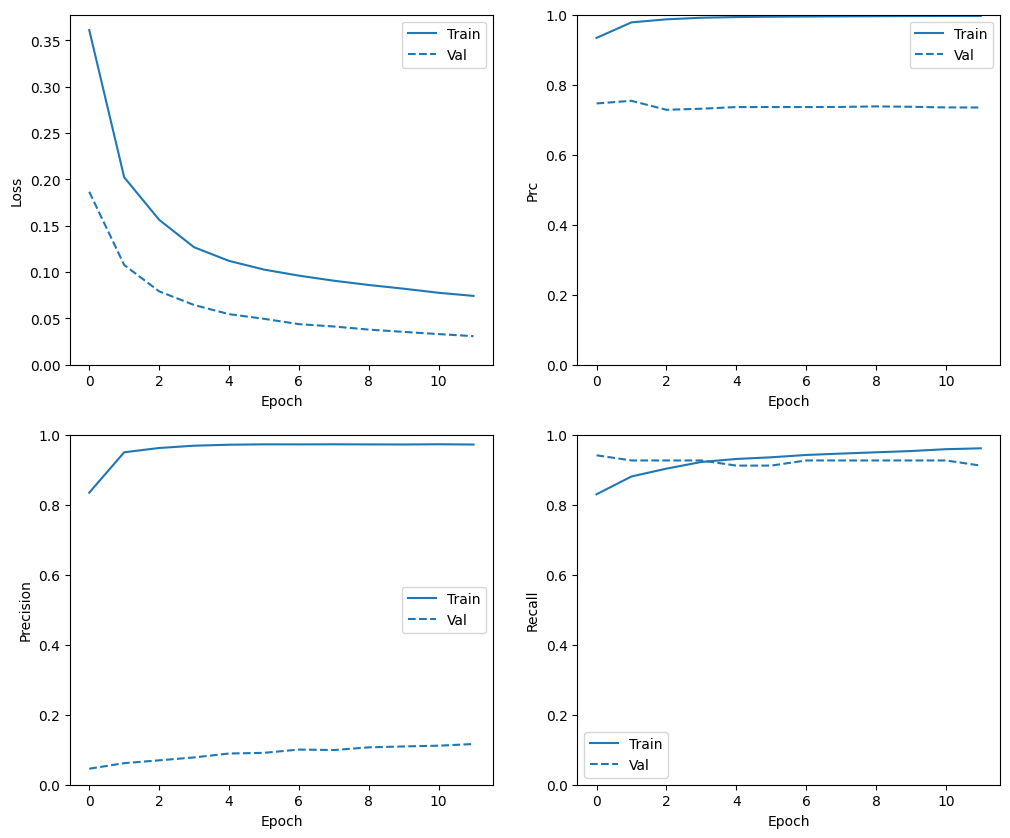

In [57]:
plot_metrics(resampled_history)

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `tf.keras.callbacks.EarlyStopping` finer control over when to stop training.

In [58]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 2s 39ms/step - loss: 0.6927 - cross entropy: 0.3441 - Brier score: 0.1171 - tp: 12552.0000 - fp: 8094.0000 - tn: 57845.0000 - fn: 8038.0000 - accuracy: 0.8136 - precision: 0.6080 - recall: 0.6096 - auc: 0.8888 - prc: 0.7130 - val_loss: 0.5936 - val_cross entropy: 0.5936 - val_Brier score: 0.2029 - val_tp: 61.0000 - val_fp: 14589.0000 - val_tn: 30912.0000 - val_fn: 7.0000 - val_accuracy: 0.6797 - val_precision: 0.0042 - val_recall: 0.8971 - val_auc: 0.8927 - val_prc: 0.0656
Epoch 2/1000
20/20 [==============================] - 0s 17ms/step - loss: 0.5305 - cross entropy: 0.5305 - Brier score: 0.1792 - tp: 15450.0000 - fp: 6597.0000 - tn: 13932.0000 - fn: 4981.0000 - accuracy: 0.7173 - precision: 0.7008 - recall: 0.7562 - auc: 0.8121 - prc: 0.8466 - val_loss: 0.5437 - val_cross entropy: 0.5437 - val_Brier score: 0.1810 - val_tp: 64.0000 - val_fp: 11839.0000 - val_tn: 33662.0000 - val_fn: 4.0000 - val_accuracy: 0.7401 - val_precision: 

 6/20 [========>.....................] - ETA: 0s - loss: 0.7205 - cross entropy: 0.1768 - Brier score: 0.0597 - tp: 5494.0000 - fp: 4759.0000 - tn: 46808.0000 - fn: 796.0000 - accuracy: 0.9040 - precision: 0.5358 - recall: 0.8734 - auc: 0.9741 - prc: 0.8549

 9/20 [============>.................] - ETA: 0s - loss: 0.7088 - cross entropy: 0.2256 - Brier score: 0.0772 - tp: 8302.0000 - fp: 6836.0000 - tn: 47697.0000 - fn: 1166.0000 - accuracy: 0.8750 - precision: 0.5484 - recall: 0.8768 - auc: 0.9660 - prc: 0.8634

12/20 [=================>............] - ETA: 0s - loss: 0.7014 - cross entropy: 0.2654 - Brier score: 0.0912 - tp: 11069.0000 - fp: 8952.0000 - tn: 48641.0000 - fn: 1483.0000 - accuracy: 0.8512 - precision: 0.5529 - recall: 0.8819 - auc: 0.9597 - prc: 0.8695

15/20 [=====================>........] - ETA: 0s - loss: 0.6949 - cross entropy: 0.2978 - Brier score: 0.1028 - tp: 13848.0000 - fp: 11041.0000 - tn: 49593.0000 - fn: 1807.0000 - accuracy: 0.8316 - precision: 0.5564 - recall: 0.8846 - auc: 0.9540 - prc: 0.8741

18/20 [==========================>...] - ETA: 0s - loss: 0.6875 - cross entropy: 0.3241 - Brier score: 0.1123 - tp: 16616.0000 - fp: 13109.0000 - tn: 50589.0000 - fn: 2119.0000 - accuracy: 0.8153 - precision: 0.5590 - recall: 0.8869 - auc: 0.9491 - prc: 0.8774

20/20 [==============================] - 2s 47ms/step - loss: 0.6826 - cross entropy: 0.3390 - Brier score: 0.1176 - tp: 18430.0000 - fp: 14493.0000 - tn: 51299.0000 - fn: 2307.0000 - accuracy: 0.8058 - precision: 0.5598 - recall: 0.8887 - auc: 0.9464 - prc: 0.8794 - val_loss: 1.0004 - val_cross entropy: 1.0004 - val_Brier score: 0.3825 - val_tp: 79.0000 - val_fp: 36434.0000 - val_tn: 9053.0000 - val_fn: 3.0000 - val_accuracy: 0.2004 - val_precision: 0.0022 - val_recall: 0.9634 - val_auc: 0.9261 - val_prc: 0.5749


Epoch 2/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.6128 - cross entropy: 0.6128 - Brier score: 0.2166 - tp: 932.0000 - fp: 649.0000 - tn: 366.0000 - fn: 101.0000 - accuracy: 0.6338 - precision: 0.5895 - recall: 0.9022 - auc: 0.8640 - prc: 0.9046

 5/20 [======>.......................] - ETA: 0s - loss: 0.6238 - cross entropy: 0.6238 - Brier score: 0.2204 - tp: 4636.0000 - fp: 3318.0000 - tn: 1790.0000 - fn: 496.0000 - accuracy: 0.6275 - precision: 0.5829 - recall: 0.9034 - auc: 0.8643 - prc: 0.9036

 8/20 [===========>..................] - ETA: 0s - loss: 0.6121 - cross entropy: 0.6121 - Brier score: 0.2165 - tp: 7455.0000 - fp: 5232.0000 - tn: 2909.0000 - fn: 788.0000 - accuracy: 0.6326 - precision: 0.5876 - recall: 0.9044 - auc: 0.8675 - prc: 0.9065

11/20 [===============>..............] - ETA: 0s - loss: 0.6076 - cross entropy: 0.6076 - Brier score: 0.2152 - tp: 10247.0000 - fp: 7162.0000 - tn: 4030.0000 - fn: 1089.0000 - accuracy: 0.6337 - precision: 0.5886 - recall: 0.9039 - auc: 0.8690 - prc: 0.9080

14/20 [====================>.........] - ETA: 0s - loss: 0.6016 - cross entropy: 0.6016 - Brier score: 0.2133 - tp: 12980.0000 - fp: 9064.0000 - tn: 5258.0000 - fn: 1370.0000 - accuracy: 0.6361 - precision: 0.5888 - recall: 0.9045 - auc: 0.8720 - prc: 0.9097

17/20 [========================>.....] - ETA: 0s - loss: 0.5947 - cross entropy: 0.5947 - Brier score: 0.2111 - tp: 15732.0000 - fp: 10890.0000 - tn: 6532.0000 - fn: 1662.0000 - accuracy: 0.6395 - precision: 0.5909 - recall: 0.9044 - auc: 0.8739 - prc: 0.9110

20/20 [==============================] - ETA: 0s - loss: 0.5885 - cross entropy: 0.5885 - Brier score: 0.2089 - tp: 18504.0000 - fp: 12626.0000 - tn: 7862.0000 - fn: 1968.0000 - accuracy: 0.6437 - precision: 0.5944 - recall: 0.9039 - auc: 0.8752 - prc: 0.9121

20/20 [==============================] - 0s 24ms/step - loss: 0.5885 - cross entropy: 0.5885 - Brier score: 0.2089 - tp: 18504.0000 - fp: 12626.0000 - tn: 7862.0000 - fn: 1968.0000 - accuracy: 0.6437 - precision: 0.5944 - recall: 0.9039 - auc: 0.8752 - prc: 0.9121 - val_loss: 0.8348 - val_cross entropy: 0.8348 - val_Brier score: 0.3117 - val_tp: 79.0000 - val_fp: 28884.0000 - val_tn: 16603.0000 - val_fn: 3.0000 - val_accuracy: 0.3661 - val_precision: 0.0027 - val_recall: 0.9634 - val_auc: 0.9395 - val_prc: 0.6709


Epoch 3/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.5246 - cross entropy: 0.5246 - Brier score: 0.1866 - tp: 906.0000 - fp: 571.0000 - tn: 488.0000 - fn: 83.0000 - accuracy: 0.6807 - precision: 0.6134 - recall: 0.9161 - auc: 0.9045 - prc: 0.9290

 5/20 [======>.......................] - ETA: 0s - loss: 0.5325 - cross entropy: 0.5325 - Brier score: 0.1885 - tp: 4596.0000 - fp: 2791.0000 - tn: 2394.0000 - fn: 459.0000 - accuracy: 0.6826 - precision: 0.6222 - recall: 0.9092 - auc: 0.8941 - prc: 0.9239

 8/20 [===========>..................] - ETA: 0s - loss: 0.5312 - cross entropy: 0.5312 - Brier score: 0.1875 - tp: 7353.0000 - fp: 4428.0000 - tn: 3859.0000 - fn: 744.0000 - accuracy: 0.6843 - precision: 0.6241 - recall: 0.9081 - auc: 0.8950 - prc: 0.9239

11/20 [===============>..............] - ETA: 0s - loss: 0.5231 - cross entropy: 0.5231 - Brier score: 0.1848 - tp: 10128.0000 - fp: 5984.0000 - tn: 5402.0000 - fn: 1014.0000 - accuracy: 0.6894 - precision: 0.6286 - recall: 0.9090 - auc: 0.8971 - prc: 0.9259

14/20 [====================>.........] - ETA: 0s - loss: 0.5156 - cross entropy: 0.5156 - Brier score: 0.1822 - tp: 12908.0000 - fp: 7499.0000 - tn: 6945.0000 - fn: 1320.0000 - accuracy: 0.6924 - precision: 0.6325 - recall: 0.9072 - auc: 0.8981 - prc: 0.9273

17/20 [========================>.....] - ETA: 0s - loss: 0.5103 - cross entropy: 0.5103 - Brier score: 0.1804 - tp: 15667.0000 - fp: 8963.0000 - tn: 8551.0000 - fn: 1635.0000 - accuracy: 0.6956 - precision: 0.6361 - recall: 0.9055 - auc: 0.8983 - prc: 0.9276

20/20 [==============================] - ETA: 0s - loss: 0.5070 - cross entropy: 0.5070 - Brier score: 0.1790 - tp: 18418.0000 - fp: 10425.0000 - tn: 10193.0000 - fn: 1924.0000 - accuracy: 0.6985 - precision: 0.6386 - recall: 0.9054 - auc: 0.8991 - prc: 0.9280

20/20 [==============================] - 1s 27ms/step - loss: 0.5070 - cross entropy: 0.5070 - Brier score: 0.1790 - tp: 18418.0000 - fp: 10425.0000 - tn: 10193.0000 - fn: 1924.0000 - accuracy: 0.6985 - precision: 0.6386 - recall: 0.9054 - auc: 0.8991 - prc: 0.9280 - val_loss: 0.6975 - val_cross entropy: 0.6975 - val_Brier score: 0.2495 - val_tp: 78.0000 - val_fp: 19535.0000 - val_tn: 25952.0000 - val_fn: 4.0000 - val_accuracy: 0.5712 - val_precision: 0.0040 - val_recall: 0.9512 - val_auc: 0.9499 - val_prc: 0.7048


Epoch 4/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.4699 - cross entropy: 0.4699 - Brier score: 0.1640 - tp: 906.0000 - fp: 438.0000 - tn: 609.0000 - fn: 95.0000 - accuracy: 0.7397 - precision: 0.6741 - recall: 0.9051 - auc: 0.9091 - prc: 0.9322

 5/20 [======>.......................] - ETA: 0s - loss: 0.4656 - cross entropy: 0.4656 - Brier score: 0.1626 - tp: 4636.0000 - fp: 2254.0000 - tn: 2873.0000 - fn: 477.0000 - accuracy: 0.7333 - precision: 0.6729 - recall: 0.9067 - auc: 0.9108 - prc: 0.9361

 8/20 [===========>..................] - ETA: 0s - loss: 0.4578 - cross entropy: 0.4578 - Brier score: 0.1596 - tp: 7376.0000 - fp: 3512.0000 - tn: 4708.0000 - fn: 788.0000 - accuracy: 0.7375 - precision: 0.6774 - recall: 0.9035 - auc: 0.9124 - prc: 0.9370

11/20 [===============>..............] - ETA: 0s - loss: 0.4541 - cross entropy: 0.4541 - Brier score: 0.1580 - tp: 10164.0000 - fp: 4769.0000 - tn: 6524.0000 - fn: 1071.0000 - accuracy: 0.7408 - precision: 0.6806 - recall: 0.9047 - auc: 0.9137 - prc: 0.9379

14/20 [====================>.........] - ETA: 0s - loss: 0.4493 - cross entropy: 0.4493 - Brier score: 0.1561 - tp: 12951.0000 - fp: 5954.0000 - tn: 8422.0000 - fn: 1345.0000 - accuracy: 0.7454 - precision: 0.6851 - recall: 0.9059 - auc: 0.9155 - prc: 0.9390

17/20 [========================>.....] - ETA: 0s - loss: 0.4474 - cross entropy: 0.4474 - Brier score: 0.1554 - tp: 15685.0000 - fp: 7181.0000 - tn: 10320.0000 - fn: 1630.0000 - accuracy: 0.7469 - precision: 0.6860 - recall: 0.9059 - auc: 0.9159 - prc: 0.9392

20/20 [==============================] - ETA: 0s - loss: 0.4413 - cross entropy: 0.4413 - Brier score: 0.1530 - tp: 18483.0000 - fp: 8228.0000 - tn: 12349.0000 - fn: 1900.0000 - accuracy: 0.7527 - precision: 0.6920 - recall: 0.9068 - auc: 0.9179 - prc: 0.9406

20/20 [==============================] - 0s 25ms/step - loss: 0.4413 - cross entropy: 0.4413 - Brier score: 0.1530 - tp: 18483.0000 - fp: 8228.0000 - tn: 12349.0000 - fn: 1900.0000 - accuracy: 0.7527 - precision: 0.6920 - recall: 0.9068 - auc: 0.9179 - prc: 0.9406 - val_loss: 0.5893 - val_cross entropy: 0.5893 - val_Brier score: 0.1998 - val_tp: 77.0000 - val_fp: 11782.0000 - val_tn: 33705.0000 - val_fn: 5.0000 - val_accuracy: 0.7413 - val_precision: 0.0065 - val_recall: 0.9390 - val_auc: 0.9552 - val_prc: 0.7246


Epoch 5/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.4369 - cross entropy: 0.4369 - Brier score: 0.1502 - tp: 904.0000 - fp: 388.0000 - tn: 655.0000 - fn: 101.0000 - accuracy: 0.7612 - precision: 0.6997 - recall: 0.8995 - auc: 0.9153 - prc: 0.9360

 5/20 [======>.......................] - ETA: 0s - loss: 0.4129 - cross entropy: 0.4129 - Brier score: 0.1424 - tp: 4635.0000 - fp: 1829.0000 - tn: 3300.0000 - fn: 476.0000 - accuracy: 0.7749 - precision: 0.7170 - recall: 0.9069 - auc: 0.9237 - prc: 0.9453

 8/20 [===========>..................] - ETA: 0s - loss: 0.4054 - cross entropy: 0.4054 - Brier score: 0.1393 - tp: 7435.0000 - fp: 2818.0000 - tn: 5358.0000 - fn: 773.0000 - accuracy: 0.7808 - precision: 0.7252 - recall: 0.9058 - auc: 0.9257 - prc: 0.9469

11/20 [===============>..............] - ETA: 0s - loss: 0.4003 - cross entropy: 0.4003 - Brier score: 0.1373 - tp: 10222.0000 - fp: 3798.0000 - tn: 7469.0000 - fn: 1039.0000 - accuracy: 0.7853 - precision: 0.7291 - recall: 0.9077 - auc: 0.9286 - prc: 0.9487

14/20 [====================>.........] - ETA: 0s - loss: 0.3972 - cross entropy: 0.3972 - Brier score: 0.1358 - tp: 13023.0000 - fp: 4750.0000 - tn: 9584.0000 - fn: 1315.0000 - accuracy: 0.7885 - precision: 0.7327 - recall: 0.9083 - auc: 0.9295 - prc: 0.9492

17/20 [========================>.....] - ETA: 0s - loss: 0.3952 - cross entropy: 0.3952 - Brier score: 0.1350 - tp: 15786.0000 - fp: 5679.0000 - tn: 11737.0000 - fn: 1614.0000 - accuracy: 0.7905 - precision: 0.7354 - recall: 0.9072 - auc: 0.9297 - prc: 0.9493

20/20 [==============================] - ETA: 0s - loss: 0.3914 - cross entropy: 0.3914 - Brier score: 0.1335 - tp: 18615.0000 - fp: 6548.0000 - tn: 13896.0000 - fn: 1901.0000 - accuracy: 0.7937 - precision: 0.7398 - recall: 0.9073 - auc: 0.9304 - prc: 0.9500

20/20 [==============================] - 0s 25ms/step - loss: 0.3914 - cross entropy: 0.3914 - Brier score: 0.1335 - tp: 18615.0000 - fp: 6548.0000 - tn: 13896.0000 - fn: 1901.0000 - accuracy: 0.7937 - precision: 0.7398 - recall: 0.9073 - auc: 0.9304 - prc: 0.9500 - val_loss: 0.5045 - val_cross entropy: 0.5045 - val_Brier score: 0.1613 - val_tp: 77.0000 - val_fp: 7135.0000 - val_tn: 38352.0000 - val_fn: 5.0000 - val_accuracy: 0.8433 - val_precision: 0.0107 - val_recall: 0.9390 - val_auc: 0.9595 - val_prc: 0.7424


Epoch 6/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3905 - cross entropy: 0.3905 - Brier score: 0.1313 - tp: 888.0000 - fp: 310.0000 - tn: 752.0000 - fn: 98.0000 - accuracy: 0.8008 - precision: 0.7412 - recall: 0.9006 - auc: 0.9300 - prc: 0.9456

 5/20 [======>.......................] - ETA: 0s - loss: 0.3700 - cross entropy: 0.3700 - Brier score: 0.1242 - tp: 4549.0000 - fp: 1371.0000 - tn: 3820.0000 - fn: 500.0000 - accuracy: 0.8173 - precision: 0.7684 - recall: 0.9010 - auc: 0.9351 - prc: 0.9523

 8/20 [===========>..................] - ETA: 0s - loss: 0.3683 - cross entropy: 0.3683 - Brier score: 0.1233 - tp: 7302.0000 - fp: 2156.0000 - tn: 6116.0000 - fn: 810.0000 - accuracy: 0.8190 - precision: 0.7720 - recall: 0.9001 - auc: 0.9354 - prc: 0.9524

11/20 [===============>..............] - ETA: 0s - loss: 0.3638 - cross entropy: 0.3638 - Brier score: 0.1214 - tp: 10094.0000 - fp: 2888.0000 - tn: 8442.0000 - fn: 1104.0000 - accuracy: 0.8228 - precision: 0.7775 - recall: 0.9014 - auc: 0.9366 - prc: 0.9534

14/20 [====================>.........] - ETA: 0s - loss: 0.3600 - cross entropy: 0.3600 - Brier score: 0.1197 - tp: 12885.0000 - fp: 3573.0000 - tn: 10820.0000 - fn: 1394.0000 - accuracy: 0.8268 - precision: 0.7829 - recall: 0.9024 - auc: 0.9378 - prc: 0.9544

17/20 [========================>.....] - ETA: 0s - loss: 0.3584 - cross entropy: 0.3584 - Brier score: 0.1191 - tp: 15675.0000 - fp: 4318.0000 - tn: 13145.0000 - fn: 1678.0000 - accuracy: 0.8278 - precision: 0.7840 - recall: 0.9033 - auc: 0.9382 - prc: 0.9547

20/20 [==============================] - ETA: 0s - loss: 0.3563 - cross entropy: 0.3563 - Brier score: 0.1183 - tp: 18429.0000 - fp: 5050.0000 - tn: 15533.0000 - fn: 1948.0000 - accuracy: 0.8292 - precision: 0.7849 - recall: 0.9044 - auc: 0.9391 - prc: 0.9552

20/20 [==============================] - 0s 26ms/step - loss: 0.3563 - cross entropy: 0.3563 - Brier score: 0.1183 - tp: 18429.0000 - fp: 5050.0000 - tn: 15533.0000 - fn: 1948.0000 - accuracy: 0.8292 - precision: 0.7849 - recall: 0.9044 - auc: 0.9391 - prc: 0.9552 - val_loss: 0.4395 - val_cross entropy: 0.4395 - val_Brier score: 0.1328 - val_tp: 77.0000 - val_fp: 4727.0000 - val_tn: 40760.0000 - val_fn: 5.0000 - val_accuracy: 0.8962 - val_precision: 0.0160 - val_recall: 0.9390 - val_auc: 0.9616 - val_prc: 0.7625


Epoch 7/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3345 - cross entropy: 0.3345 - Brier score: 0.1103 - tp: 951.0000 - fp: 232.0000 - tn: 782.0000 - fn: 83.0000 - accuracy: 0.8462 - precision: 0.8039 - recall: 0.9197 - auc: 0.9474 - prc: 0.9627

 5/20 [======>.......................] - ETA: 0s - loss: 0.3381 - cross entropy: 0.3381 - Brier score: 0.1108 - tp: 4716.0000 - fp: 1140.0000 - tn: 3932.0000 - fn: 452.0000 - accuracy: 0.8445 - precision: 0.8053 - recall: 0.9125 - auc: 0.9451 - prc: 0.9605

 8/20 [===========>..................] - ETA: 0s - loss: 0.3337 - cross entropy: 0.3337 - Brier score: 0.1090 - tp: 7548.0000 - fp: 1741.0000 - tn: 6356.0000 - fn: 739.0000 - accuracy: 0.8486 - precision: 0.8126 - recall: 0.9108 - auc: 0.9456 - prc: 0.9611

11/20 [===============>..............] - ETA: 0s - loss: 0.3315 - cross entropy: 0.3315 - Brier score: 0.1082 - tp: 10338.0000 - fp: 2384.0000 - tn: 8790.0000 - fn: 1016.0000 - accuracy: 0.8491 - precision: 0.8126 - recall: 0.9105 - auc: 0.9461 - prc: 0.9612

14/20 [====================>.........] - ETA: 0s - loss: 0.3271 - cross entropy: 0.3271 - Brier score: 0.1065 - tp: 13146.0000 - fp: 2958.0000 - tn: 11273.0000 - fn: 1295.0000 - accuracy: 0.8517 - precision: 0.8163 - recall: 0.9103 - auc: 0.9474 - prc: 0.9621

17/20 [========================>.....] - ETA: 0s - loss: 0.3246 - cross entropy: 0.3246 - Brier score: 0.1057 - tp: 15976.0000 - fp: 3537.0000 - tn: 13733.0000 - fn: 1570.0000 - accuracy: 0.8533 - precision: 0.8187 - recall: 0.9105 - auc: 0.9481 - prc: 0.9626

20/20 [==============================] - ETA: 0s - loss: 0.3220 - cross entropy: 0.3220 - Brier score: 0.1047 - tp: 18807.0000 - fp: 4065.0000 - tn: 16241.0000 - fn: 1847.0000 - accuracy: 0.8557 - precision: 0.8223 - recall: 0.9106 - auc: 0.9485 - prc: 0.9631

20/20 [==============================] - 0s 25ms/step - loss: 0.3220 - cross entropy: 0.3220 - Brier score: 0.1047 - tp: 18807.0000 - fp: 4065.0000 - tn: 16241.0000 - fn: 1847.0000 - accuracy: 0.8557 - precision: 0.8223 - recall: 0.9106 - auc: 0.9485 - prc: 0.9631 - val_loss: 0.3867 - val_cross entropy: 0.3867 - val_Brier score: 0.1105 - val_tp: 77.0000 - val_fp: 3192.0000 - val_tn: 42295.0000 - val_fn: 5.0000 - val_accuracy: 0.9298 - val_precision: 0.0236 - val_recall: 0.9390 - val_auc: 0.9635 - val_prc: 0.7711


Epoch 8/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3170 - cross entropy: 0.3170 - Brier score: 0.1032 - tp: 952.0000 - fp: 185.0000 - tn: 814.0000 - fn: 97.0000 - accuracy: 0.8623 - precision: 0.8373 - recall: 0.9075 - auc: 0.9477 - prc: 0.9643

 5/20 [======>.......................] - ETA: 0s - loss: 0.3135 - cross entropy: 0.3135 - Brier score: 0.1014 - tp: 4605.0000 - fp: 934.0000 - tn: 4221.0000 - fn: 480.0000 - accuracy: 0.8619 - precision: 0.8314 - recall: 0.9056 - auc: 0.9493 - prc: 0.9629

 8/20 [===========>..................] - ETA: 0s - loss: 0.3077 - cross entropy: 0.3077 - Brier score: 0.0990 - tp: 7427.0000 - fp: 1455.0000 - tn: 6758.0000 - fn: 744.0000 - accuracy: 0.8658 - precision: 0.8362 - recall: 0.9089 - auc: 0.9521 - prc: 0.9649

11/20 [===============>..............] - ETA: 0s - loss: 0.3056 - cross entropy: 0.3056 - Brier score: 0.0980 - tp: 10267.0000 - fp: 1970.0000 - tn: 9292.0000 - fn: 999.0000 - accuracy: 0.8682 - precision: 0.8390 - recall: 0.9113 - auc: 0.9531 - prc: 0.9655

14/20 [====================>.........] - ETA: 0s - loss: 0.3053 - cross entropy: 0.3053 - Brier score: 0.0976 - tp: 13066.0000 - fp: 2471.0000 - tn: 11857.0000 - fn: 1278.0000 - accuracy: 0.8692 - precision: 0.8410 - recall: 0.9109 - auc: 0.9532 - prc: 0.9655

17/20 [========================>.....] - ETA: 0s - loss: 0.3040 - cross entropy: 0.3040 - Brier score: 0.0970 - tp: 15844.0000 - fp: 2933.0000 - tn: 14486.0000 - fn: 1553.0000 - accuracy: 0.8712 - precision: 0.8438 - recall: 0.9107 - auc: 0.9534 - prc: 0.9655

20/20 [==============================] - ETA: 0s - loss: 0.3012 - cross entropy: 0.3012 - Brier score: 0.0959 - tp: 18607.0000 - fp: 3384.0000 - tn: 17165.0000 - fn: 1804.0000 - accuracy: 0.8733 - precision: 0.8461 - recall: 0.9116 - auc: 0.9545 - prc: 0.9661

20/20 [==============================] - 0s 25ms/step - loss: 0.3012 - cross entropy: 0.3012 - Brier score: 0.0959 - tp: 18607.0000 - fp: 3384.0000 - tn: 17165.0000 - fn: 1804.0000 - accuracy: 0.8733 - precision: 0.8461 - recall: 0.9116 - auc: 0.9545 - prc: 0.9661 - val_loss: 0.3438 - val_cross entropy: 0.3438 - val_Brier score: 0.0932 - val_tp: 77.0000 - val_fp: 2361.0000 - val_tn: 43126.0000 - val_fn: 5.0000 - val_accuracy: 0.9481 - val_precision: 0.0316 - val_recall: 0.9390 - val_auc: 0.9644 - val_prc: 0.7748


Epoch 9/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2832 - cross entropy: 0.2832 - Brier score: 0.0901 - tp: 985.0000 - fp: 161.0000 - tn: 810.0000 - fn: 92.0000 - accuracy: 0.8765 - precision: 0.8595 - recall: 0.9146 - auc: 0.9567 - prc: 0.9708

 5/20 [======>.......................] - ETA: 0s - loss: 0.2837 - cross entropy: 0.2837 - Brier score: 0.0892 - tp: 4717.0000 - fp: 742.0000 - tn: 4338.0000 - fn: 443.0000 - accuracy: 0.8843 - precision: 0.8641 - recall: 0.9141 - auc: 0.9584 - prc: 0.9692

 8/20 [===========>..................] - ETA: 0s - loss: 0.2852 - cross entropy: 0.2852 - Brier score: 0.0896 - tp: 7534.0000 - fp: 1210.0000 - tn: 6942.0000 - fn: 698.0000 - accuracy: 0.8835 - precision: 0.8616 - recall: 0.9152 - auc: 0.9581 - prc: 0.9690

11/20 [===============>..............] - ETA: 0s - loss: 0.2840 - cross entropy: 0.2840 - Brier score: 0.0894 - tp: 10342.0000 - fp: 1648.0000 - tn: 9549.0000 - fn: 989.0000 - accuracy: 0.8829 - precision: 0.8626 - recall: 0.9127 - auc: 0.9579 - prc: 0.9688

14/20 [====================>.........] - ETA: 0s - loss: 0.2819 - cross entropy: 0.2819 - Brier score: 0.0889 - tp: 13142.0000 - fp: 2082.0000 - tn: 12170.0000 - fn: 1278.0000 - accuracy: 0.8828 - precision: 0.8632 - recall: 0.9114 - auc: 0.9581 - prc: 0.9690

17/20 [========================>.....] - ETA: 0s - loss: 0.2806 - cross entropy: 0.2806 - Brier score: 0.0883 - tp: 15864.0000 - fp: 2477.0000 - tn: 14931.0000 - fn: 1544.0000 - accuracy: 0.8845 - precision: 0.8649 - recall: 0.9113 - auc: 0.9588 - prc: 0.9692

20/20 [==============================] - ETA: 0s - loss: 0.2795 - cross entropy: 0.2795 - Brier score: 0.0880 - tp: 18636.0000 - fp: 2891.0000 - tn: 17616.0000 - fn: 1817.0000 - accuracy: 0.8851 - precision: 0.8657 - recall: 0.9112 - auc: 0.9589 - prc: 0.9692

20/20 [==============================] - 0s 25ms/step - loss: 0.2795 - cross entropy: 0.2795 - Brier score: 0.0880 - tp: 18636.0000 - fp: 2891.0000 - tn: 17616.0000 - fn: 1817.0000 - accuracy: 0.8851 - precision: 0.8657 - recall: 0.9112 - auc: 0.9589 - prc: 0.9692 - val_loss: 0.3087 - val_cross entropy: 0.3087 - val_Brier score: 0.0799 - val_tp: 76.0000 - val_fp: 1892.0000 - val_tn: 43595.0000 - val_fn: 6.0000 - val_accuracy: 0.9583 - val_precision: 0.0386 - val_recall: 0.9268 - val_auc: 0.9658 - val_prc: 0.7797


Epoch 10/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2733 - cross entropy: 0.2733 - Brier score: 0.0859 - tp: 923.0000 - fp: 141.0000 - tn: 896.0000 - fn: 88.0000 - accuracy: 0.8882 - precision: 0.8675 - recall: 0.9130 - auc: 0.9612 - prc: 0.9711

 5/20 [======>.......................] - ETA: 0s - loss: 0.2667 - cross entropy: 0.2667 - Brier score: 0.0830 - tp: 4705.0000 - fp: 642.0000 - tn: 4441.0000 - fn: 452.0000 - accuracy: 0.8932 - precision: 0.8799 - recall: 0.9124 - auc: 0.9617 - prc: 0.9717

 8/20 [===========>..................] - ETA: 0s - loss: 0.2664 - cross entropy: 0.2664 - Brier score: 0.0829 - tp: 7464.0000 - fp: 1013.0000 - tn: 7174.0000 - fn: 733.0000 - accuracy: 0.8934 - precision: 0.8805 - recall: 0.9106 - auc: 0.9614 - prc: 0.9713

11/20 [===============>..............] - ETA: 0s - loss: 0.2650 - cross entropy: 0.2650 - Brier score: 0.0825 - tp: 10305.0000 - fp: 1400.0000 - tn: 9811.0000 - fn: 1012.0000 - accuracy: 0.8929 - precision: 0.8804 - recall: 0.9106 - auc: 0.9618 - prc: 0.9719

14/20 [====================>.........] - ETA: 0s - loss: 0.2643 - cross entropy: 0.2643 - Brier score: 0.0822 - tp: 13135.0000 - fp: 1756.0000 - tn: 12495.0000 - fn: 1286.0000 - accuracy: 0.8939 - precision: 0.8821 - recall: 0.9108 - auc: 0.9620 - prc: 0.9720

17/20 [========================>.....] - ETA: 0s - loss: 0.2626 - cross entropy: 0.2626 - Brier score: 0.0815 - tp: 15955.0000 - fp: 2100.0000 - tn: 15203.0000 - fn: 1558.0000 - accuracy: 0.8949 - precision: 0.8837 - recall: 0.9110 - auc: 0.9624 - prc: 0.9724

20/20 [==============================] - ETA: 0s - loss: 0.2620 - cross entropy: 0.2620 - Brier score: 0.0812 - tp: 18743.0000 - fp: 2432.0000 - tn: 17955.0000 - fn: 1830.0000 - accuracy: 0.8959 - precision: 0.8851 - recall: 0.9110 - auc: 0.9625 - prc: 0.9724

20/20 [==============================] - 0s 25ms/step - loss: 0.2620 - cross entropy: 0.2620 - Brier score: 0.0812 - tp: 18743.0000 - fp: 2432.0000 - tn: 17955.0000 - fn: 1830.0000 - accuracy: 0.8959 - precision: 0.8851 - recall: 0.9110 - auc: 0.9625 - prc: 0.9724 - val_loss: 0.2798 - val_cross entropy: 0.2798 - val_Brier score: 0.0695 - val_tp: 76.0000 - val_fp: 1615.0000 - val_tn: 43872.0000 - val_fn: 6.0000 - val_accuracy: 0.9644 - val_precision: 0.0449 - val_recall: 0.9268 - val_auc: 0.9674 - val_prc: 0.7834


Epoch 11/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2736 - cross entropy: 0.2736 - Brier score: 0.0842 - tp: 885.0000 - fp: 133.0000 - tn: 939.0000 - fn: 91.0000 - accuracy: 0.8906 - precision: 0.8694 - recall: 0.9068 - auc: 0.9611 - prc: 0.9675

 5/20 [======>.......................] - ETA: 0s - loss: 0.2560 - cross entropy: 0.2560 - Brier score: 0.0786 - tp: 4601.0000 - fp: 574.0000 - tn: 4612.0000 - fn: 453.0000 - accuracy: 0.8997 - precision: 0.8891 - recall: 0.9104 - auc: 0.9649 - prc: 0.9730

 8/20 [===========>..................] - ETA: 0s - loss: 0.2519 - cross entropy: 0.2519 - Brier score: 0.0773 - tp: 7440.0000 - fp: 903.0000 - tn: 7329.0000 - fn: 712.0000 - accuracy: 0.9014 - precision: 0.8918 - recall: 0.9127 - auc: 0.9662 - prc: 0.9743

11/20 [===============>..............] - ETA: 0s - loss: 0.2514 - cross entropy: 0.2514 - Brier score: 0.0770 - tp: 10151.0000 - fp: 1235.0000 - tn: 10160.0000 - fn: 982.0000 - accuracy: 0.9016 - precision: 0.8915 - recall: 0.9118 - auc: 0.9663 - prc: 0.9742

14/20 [====================>.........] - ETA: 0s - loss: 0.2514 - cross entropy: 0.2514 - Brier score: 0.0769 - tp: 12983.0000 - fp: 1544.0000 - tn: 12887.0000 - fn: 1258.0000 - accuracy: 0.9023 - precision: 0.8937 - recall: 0.9117 - auc: 0.9660 - prc: 0.9741

17/20 [========================>.....] - ETA: 0s - loss: 0.2504 - cross entropy: 0.2504 - Brier score: 0.0765 - tp: 15799.0000 - fp: 1860.0000 - tn: 15636.0000 - fn: 1521.0000 - accuracy: 0.9029 - precision: 0.8947 - recall: 0.9122 - auc: 0.9662 - prc: 0.9744

20/20 [==============================] - ETA: 0s - loss: 0.2480 - cross entropy: 0.2480 - Brier score: 0.0757 - tp: 18645.0000 - fp: 2154.0000 - tn: 18383.0000 - fn: 1778.0000 - accuracy: 0.9040 - precision: 0.8964 - recall: 0.9129 - auc: 0.9668 - prc: 0.9748

20/20 [==============================] - 0s 25ms/step - loss: 0.2480 - cross entropy: 0.2480 - Brier score: 0.0757 - tp: 18645.0000 - fp: 2154.0000 - tn: 18383.0000 - fn: 1778.0000 - accuracy: 0.9040 - precision: 0.8964 - recall: 0.9129 - auc: 0.9668 - prc: 0.9748 - val_loss: 0.2551 - val_cross entropy: 0.2551 - val_Brier score: 0.0611 - val_tp: 76.0000 - val_fp: 1428.0000 - val_tn: 44059.0000 - val_fn: 6.0000 - val_accuracy: 0.9685 - val_precision: 0.0505 - val_recall: 0.9268 - val_auc: 0.9691 - val_prc: 0.7858


Epoch 12/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2437 - cross entropy: 0.2437 - Brier score: 0.0743 - tp: 936.0000 - fp: 96.0000 - tn: 928.0000 - fn: 88.0000 - accuracy: 0.9102 - precision: 0.9070 - recall: 0.9141 - auc: 0.9654 - prc: 0.9748

 5/20 [======>.......................] - ETA: 0s - loss: 0.2428 - cross entropy: 0.2428 - Brier score: 0.0738 - tp: 4637.0000 - fp: 522.0000 - tn: 4654.0000 - fn: 427.0000 - accuracy: 0.9073 - precision: 0.8988 - recall: 0.9157 - auc: 0.9679 - prc: 0.9752

 8/20 [===========>..................] - ETA: 0s - loss: 0.2414 - cross entropy: 0.2414 - Brier score: 0.0734 - tp: 7425.0000 - fp: 784.0000 - tn: 7467.0000 - fn: 708.0000 - accuracy: 0.9089 - precision: 0.9045 - recall: 0.9129 - auc: 0.9672 - prc: 0.9749

11/20 [===============>..............] - ETA: 0s - loss: 0.2401 - cross entropy: 0.2401 - Brier score: 0.0731 - tp: 10207.0000 - fp: 1076.0000 - tn: 10267.0000 - fn: 978.0000 - accuracy: 0.9088 - precision: 0.9046 - recall: 0.9126 - auc: 0.9672 - prc: 0.9749

14/20 [====================>.........] - ETA: 0s - loss: 0.2389 - cross entropy: 0.2389 - Brier score: 0.0728 - tp: 13027.0000 - fp: 1371.0000 - tn: 13040.0000 - fn: 1234.0000 - accuracy: 0.9091 - precision: 0.9048 - recall: 0.9135 - auc: 0.9678 - prc: 0.9754

17/20 [========================>.....] - ETA: 0s - loss: 0.2375 - cross entropy: 0.2375 - Brier score: 0.0723 - tp: 15857.0000 - fp: 1663.0000 - tn: 15809.0000 - fn: 1487.0000 - accuracy: 0.9095 - precision: 0.9051 - recall: 0.9143 - auc: 0.9683 - prc: 0.9758

20/20 [==============================] - ETA: 0s - loss: 0.2368 - cross entropy: 0.2368 - Brier score: 0.0722 - tp: 18706.0000 - fp: 1922.0000 - tn: 18565.0000 - fn: 1767.0000 - accuracy: 0.9099 - precision: 0.9068 - recall: 0.9137 - auc: 0.9682 - prc: 0.9759

20/20 [==============================] - 0s 25ms/step - loss: 0.2368 - cross entropy: 0.2368 - Brier score: 0.0722 - tp: 18706.0000 - fp: 1922.0000 - tn: 18565.0000 - fn: 1767.0000 - accuracy: 0.9099 - precision: 0.9068 - recall: 0.9137 - auc: 0.9682 - prc: 0.9759 - val_loss: 0.2341 - val_cross entropy: 0.2341 - val_Brier score: 0.0543 - val_tp: 75.0000 - val_fp: 1301.0000 - val_tn: 44186.0000 - val_fn: 7.0000 - val_accuracy: 0.9713 - val_precision: 0.0545 - val_recall: 0.9146 - val_auc: 0.9710 - val_prc: 0.7888


Epoch 13/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2240 - cross entropy: 0.2240 - Brier score: 0.0675 - tp: 947.0000 - fp: 81.0000 - tn: 933.0000 - fn: 87.0000 - accuracy: 0.9180 - precision: 0.9212 - recall: 0.9159 - auc: 0.9721 - prc: 0.9792

 5/20 [======>.......................] - ETA: 0s - loss: 0.2247 - cross entropy: 0.2247 - Brier score: 0.0675 - tp: 4736.0000 - fp: 430.0000 - tn: 4654.0000 - fn: 420.0000 - accuracy: 0.9170 - precision: 0.9168 - recall: 0.9185 - auc: 0.9721 - prc: 0.9785

 8/20 [===========>..................] - ETA: 0s - loss: 0.2241 - cross entropy: 0.2241 - Brier score: 0.0675 - tp: 7514.0000 - fp: 718.0000 - tn: 7483.0000 - fn: 669.0000 - accuracy: 0.9153 - precision: 0.9128 - recall: 0.9182 - auc: 0.9721 - prc: 0.9782

11/20 [===============>..............] - ETA: 0s - loss: 0.2246 - cross entropy: 0.2246 - Brier score: 0.0677 - tp: 10377.0000 - fp: 992.0000 - tn: 10227.0000 - fn: 932.0000 - accuracy: 0.9146 - precision: 0.9127 - recall: 0.9176 - auc: 0.9719 - prc: 0.9782

14/20 [====================>.........] - ETA: 0s - loss: 0.2244 - cross entropy: 0.2244 - Brier score: 0.0674 - tp: 13200.0000 - fp: 1220.0000 - tn: 13052.0000 - fn: 1200.0000 - accuracy: 0.9156 - precision: 0.9154 - recall: 0.9167 - auc: 0.9718 - prc: 0.9782

17/20 [========================>.....] - ETA: 0s - loss: 0.2237 - cross entropy: 0.2237 - Brier score: 0.0672 - tp: 16025.0000 - fp: 1463.0000 - tn: 15861.0000 - fn: 1467.0000 - accuracy: 0.9158 - precision: 0.9163 - recall: 0.9161 - auc: 0.9718 - prc: 0.9782

20/20 [==============================] - ETA: 0s - loss: 0.2223 - cross entropy: 0.2223 - Brier score: 0.0667 - tp: 18874.0000 - fp: 1694.0000 - tn: 18675.0000 - fn: 1717.0000 - accuracy: 0.9167 - precision: 0.9176 - recall: 0.9166 - auc: 0.9720 - prc: 0.9785

20/20 [==============================] - 0s 25ms/step - loss: 0.2223 - cross entropy: 0.2223 - Brier score: 0.0667 - tp: 18874.0000 - fp: 1694.0000 - tn: 18675.0000 - fn: 1717.0000 - accuracy: 0.9167 - precision: 0.9176 - recall: 0.9166 - auc: 0.9720 - prc: 0.9785 - val_loss: 0.2162 - val_cross entropy: 0.2162 - val_Brier score: 0.0488 - val_tp: 75.0000 - val_fp: 1235.0000 - val_tn: 44252.0000 - val_fn: 7.0000 - val_accuracy: 0.9727 - val_precision: 0.0573 - val_recall: 0.9146 - val_auc: 0.9732 - val_prc: 0.7912


Epoch 14/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2184 - cross entropy: 0.2184 - Brier score: 0.0651 - tp: 945.0000 - fp: 86.0000 - tn: 924.0000 - fn: 93.0000 - accuracy: 0.9126 - precision: 0.9166 - recall: 0.9104 - auc: 0.9728 - prc: 0.9787

 5/20 [======>.......................] - ETA: 0s - loss: 0.2202 - cross entropy: 0.2202 - Brier score: 0.0656 - tp: 4675.0000 - fp: 421.0000 - tn: 4703.0000 - fn: 441.0000 - accuracy: 0.9158 - precision: 0.9174 - recall: 0.9138 - auc: 0.9727 - prc: 0.9785

 8/20 [===========>..................] - ETA: 0s - loss: 0.2219 - cross entropy: 0.2219 - Brier score: 0.0662 - tp: 7469.0000 - fp: 689.0000 - tn: 7516.0000 - fn: 710.0000 - accuracy: 0.9146 - precision: 0.9155 - recall: 0.9132 - auc: 0.9722 - prc: 0.9782

11/20 [===============>..............] - ETA: 0s - loss: 0.2191 - cross entropy: 0.2191 - Brier score: 0.0654 - tp: 10312.0000 - fp: 924.0000 - tn: 10321.0000 - fn: 971.0000 - accuracy: 0.9159 - precision: 0.9178 - recall: 0.9139 - auc: 0.9726 - prc: 0.9787

14/20 [====================>.........] - ETA: 0s - loss: 0.2198 - cross entropy: 0.2198 - Brier score: 0.0655 - tp: 13098.0000 - fp: 1182.0000 - tn: 13161.0000 - fn: 1231.0000 - accuracy: 0.9158 - precision: 0.9172 - recall: 0.9141 - auc: 0.9724 - prc: 0.9785

17/20 [========================>.....] - ETA: 0s - loss: 0.2186 - cross entropy: 0.2186 - Brier score: 0.0652 - tp: 15884.0000 - fp: 1425.0000 - tn: 16024.0000 - fn: 1483.0000 - accuracy: 0.9165 - precision: 0.9177 - recall: 0.9146 - auc: 0.9728 - prc: 0.9787

20/20 [==============================] - ETA: 0s - loss: 0.2172 - cross entropy: 0.2172 - Brier score: 0.0648 - tp: 18681.0000 - fp: 1627.0000 - tn: 18898.0000 - fn: 1754.0000 - accuracy: 0.9175 - precision: 0.9199 - recall: 0.9142 - auc: 0.9732 - prc: 0.9789

20/20 [==============================] - 1s 27ms/step - loss: 0.2172 - cross entropy: 0.2172 - Brier score: 0.0648 - tp: 18681.0000 - fp: 1627.0000 - tn: 18898.0000 - fn: 1754.0000 - accuracy: 0.9175 - precision: 0.9199 - recall: 0.9142 - auc: 0.9732 - prc: 0.9789 - val_loss: 0.2011 - val_cross entropy: 0.2011 - val_Brier score: 0.0444 - val_tp: 75.0000 - val_fp: 1167.0000 - val_tn: 44320.0000 - val_fn: 7.0000 - val_accuracy: 0.9742 - val_precision: 0.0604 - val_recall: 0.9146 - val_auc: 0.9748 - val_prc: 0.7927


Epoch 15/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2164 - cross entropy: 0.2164 - Brier score: 0.0648 - tp: 915.0000 - fp: 68.0000 - tn: 973.0000 - fn: 92.0000 - accuracy: 0.9219 - precision: 0.9308 - recall: 0.9086 - auc: 0.9708 - prc: 0.9775

 5/20 [======>.......................] - ETA: 0s - loss: 0.2111 - cross entropy: 0.2111 - Brier score: 0.0627 - tp: 4768.0000 - fp: 386.0000 - tn: 4670.0000 - fn: 416.0000 - accuracy: 0.9217 - precision: 0.9251 - recall: 0.9198 - auc: 0.9745 - prc: 0.9802

 8/20 [===========>..................] - ETA: 0s - loss: 0.2111 - cross entropy: 0.2111 - Brier score: 0.0628 - tp: 7589.0000 - fp: 608.0000 - tn: 7506.0000 - fn: 681.0000 - accuracy: 0.9213 - precision: 0.9258 - recall: 0.9177 - auc: 0.9742 - prc: 0.9801

11/20 [===============>..............] - ETA: 0s - loss: 0.2093 - cross entropy: 0.2093 - Brier score: 0.0622 - tp: 10425.0000 - fp: 810.0000 - tn: 10362.0000 - fn: 931.0000 - accuracy: 0.9227 - precision: 0.9279 - recall: 0.9180 - auc: 0.9749 - prc: 0.9806

14/20 [====================>.........] - ETA: 0s - loss: 0.2099 - cross entropy: 0.2099 - Brier score: 0.0622 - tp: 13226.0000 - fp: 1034.0000 - tn: 13236.0000 - fn: 1176.0000 - accuracy: 0.9229 - precision: 0.9275 - recall: 0.9183 - auc: 0.9747 - prc: 0.9804

17/20 [========================>.....] - ETA: 0s - loss: 0.2094 - cross entropy: 0.2094 - Brier score: 0.0620 - tp: 16041.0000 - fp: 1272.0000 - tn: 16093.0000 - fn: 1410.0000 - accuracy: 0.9230 - precision: 0.9265 - recall: 0.9192 - auc: 0.9749 - prc: 0.9805

20/20 [==============================] - ETA: 0s - loss: 0.2088 - cross entropy: 0.2088 - Brier score: 0.0619 - tp: 18878.0000 - fp: 1484.0000 - tn: 18949.0000 - fn: 1649.0000 - accuracy: 0.9235 - precision: 0.9271 - recall: 0.9197 - auc: 0.9749 - prc: 0.9806

20/20 [==============================] - 0s 25ms/step - loss: 0.2088 - cross entropy: 0.2088 - Brier score: 0.0619 - tp: 18878.0000 - fp: 1484.0000 - tn: 18949.0000 - fn: 1649.0000 - accuracy: 0.9235 - precision: 0.9271 - recall: 0.9197 - auc: 0.9749 - prc: 0.9806 - val_loss: 0.1872 - val_cross entropy: 0.1872 - val_Brier score: 0.0405 - val_tp: 75.0000 - val_fp: 1100.0000 - val_tn: 44387.0000 - val_fn: 7.0000 - val_accuracy: 0.9757 - val_precision: 0.0638 - val_recall: 0.9146 - val_auc: 0.9760 - val_prc: 0.7931


Epoch 16/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1957 - cross entropy: 0.1957 - Brier score: 0.0583 - tp: 967.0000 - fp: 68.0000 - tn: 925.0000 - fn: 88.0000 - accuracy: 0.9238 - precision: 0.9343 - recall: 0.9166 - auc: 0.9777 - prc: 0.9834

 5/20 [======>.......................] - ETA: 0s - loss: 0.2061 - cross entropy: 0.2061 - Brier score: 0.0613 - tp: 4662.0000 - fp: 391.0000 - tn: 4770.0000 - fn: 417.0000 - accuracy: 0.9211 - precision: 0.9226 - recall: 0.9179 - auc: 0.9766 - prc: 0.9811

 8/20 [===========>..................] - ETA: 0s - loss: 0.2061 - cross entropy: 0.2061 - Brier score: 0.0612 - tp: 7489.0000 - fp: 618.0000 - tn: 7600.0000 - fn: 677.0000 - accuracy: 0.9210 - precision: 0.9238 - recall: 0.9171 - auc: 0.9760 - prc: 0.9810

11/20 [===============>..............] - ETA: 0s - loss: 0.2042 - cross entropy: 0.2042 - Brier score: 0.0606 - tp: 10350.0000 - fp: 824.0000 - tn: 10449.0000 - fn: 905.0000 - accuracy: 0.9233 - precision: 0.9263 - recall: 0.9196 - auc: 0.9766 - prc: 0.9816

14/20 [====================>.........] - ETA: 0s - loss: 0.2026 - cross entropy: 0.2026 - Brier score: 0.0599 - tp: 13135.0000 - fp: 1039.0000 - tn: 13371.0000 - fn: 1127.0000 - accuracy: 0.9245 - precision: 0.9267 - recall: 0.9210 - auc: 0.9770 - prc: 0.9818

17/20 [========================>.....] - ETA: 0s - loss: 0.2015 - cross entropy: 0.2015 - Brier score: 0.0596 - tp: 15938.0000 - fp: 1236.0000 - tn: 16245.0000 - fn: 1397.0000 - accuracy: 0.9244 - precision: 0.9280 - recall: 0.9194 - auc: 0.9769 - prc: 0.9818

20/20 [==============================] - ETA: 0s - loss: 0.2011 - cross entropy: 0.2011 - Brier score: 0.0596 - tp: 18797.0000 - fp: 1439.0000 - tn: 19068.0000 - fn: 1656.0000 - accuracy: 0.9244 - precision: 0.9289 - recall: 0.9190 - auc: 0.9768 - prc: 0.9818

20/20 [==============================] - 0s 25ms/step - loss: 0.2011 - cross entropy: 0.2011 - Brier score: 0.0596 - tp: 18797.0000 - fp: 1439.0000 - tn: 19068.0000 - fn: 1656.0000 - accuracy: 0.9244 - precision: 0.9289 - recall: 0.9190 - auc: 0.9768 - prc: 0.9818 - val_loss: 0.1743 - val_cross entropy: 0.1743 - val_Brier score: 0.0369 - val_tp: 75.0000 - val_fp: 1029.0000 - val_tn: 44458.0000 - val_fn: 7.0000 - val_accuracy: 0.9773 - val_precision: 0.0679 - val_recall: 0.9146 - val_auc: 0.9769 - val_prc: 0.7935


Epoch 17/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1930 - cross entropy: 0.1930 - Brier score: 0.0566 - tp: 964.0000 - fp: 54.0000 - tn: 948.0000 - fn: 82.0000 - accuracy: 0.9336 - precision: 0.9470 - recall: 0.9216 - auc: 0.9779 - prc: 0.9832

 5/20 [======>.......................] - ETA: 0s - loss: 0.1979 - cross entropy: 0.1979 - Brier score: 0.0587 - tp: 4693.0000 - fp: 349.0000 - tn: 4800.0000 - fn: 398.0000 - accuracy: 0.9271 - precision: 0.9308 - recall: 0.9218 - auc: 0.9769 - prc: 0.9820

 8/20 [===========>..................] - ETA: 0s - loss: 0.1955 - cross entropy: 0.1955 - Brier score: 0.0577 - tp: 7518.0000 - fp: 541.0000 - tn: 7683.0000 - fn: 642.0000 - accuracy: 0.9278 - precision: 0.9329 - recall: 0.9213 - auc: 0.9775 - prc: 0.9826

11/20 [===============>..............] - ETA: 0s - loss: 0.1963 - cross entropy: 0.1963 - Brier score: 0.0578 - tp: 10305.0000 - fp: 739.0000 - tn: 10603.0000 - fn: 881.0000 - accuracy: 0.9281 - precision: 0.9331 - recall: 0.9212 - auc: 0.9773 - prc: 0.9822

14/20 [====================>.........] - ETA: 0s - loss: 0.1964 - cross entropy: 0.1964 - Brier score: 0.0577 - tp: 13104.0000 - fp: 944.0000 - tn: 13497.0000 - fn: 1127.0000 - accuracy: 0.9278 - precision: 0.9328 - recall: 0.9208 - auc: 0.9773 - prc: 0.9822

17/20 [========================>.....] - ETA: 0s - loss: 0.1964 - cross entropy: 0.1964 - Brier score: 0.0575 - tp: 15924.0000 - fp: 1131.0000 - tn: 16391.0000 - fn: 1370.0000 - accuracy: 0.9282 - precision: 0.9337 - recall: 0.9208 - auc: 0.9773 - prc: 0.9820

20/20 [==============================] - ETA: 0s - loss: 0.1961 - cross entropy: 0.1961 - Brier score: 0.0575 - tp: 18762.0000 - fp: 1337.0000 - tn: 19238.0000 - fn: 1623.0000 - accuracy: 0.9277 - precision: 0.9335 - recall: 0.9204 - auc: 0.9773 - prc: 0.9821

20/20 [==============================] - 0s 26ms/step - loss: 0.1961 - cross entropy: 0.1961 - Brier score: 0.0575 - tp: 18762.0000 - fp: 1337.0000 - tn: 19238.0000 - fn: 1623.0000 - accuracy: 0.9277 - precision: 0.9335 - recall: 0.9204 - auc: 0.9773 - prc: 0.9821 - val_loss: 0.1636 - val_cross entropy: 0.1636 - val_Brier score: 0.0342 - val_tp: 75.0000 - val_fp: 997.0000 - val_tn: 44490.0000 - val_fn: 7.0000 - val_accuracy: 0.9780 - val_precision: 0.0700 - val_recall: 0.9146 - val_auc: 0.9777 - val_prc: 0.7943


Epoch 18/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1872 - cross entropy: 0.1872 - Brier score: 0.0549 - tp: 916.0000 - fp: 55.0000 - tn: 990.0000 - fn: 87.0000 - accuracy: 0.9307 - precision: 0.9434 - recall: 0.9133 - auc: 0.9791 - prc: 0.9833

 5/20 [======>.......................] - ETA: 0s - loss: 0.1886 - cross entropy: 0.1886 - Brier score: 0.0557 - tp: 4658.0000 - fp: 325.0000 - tn: 4846.0000 - fn: 411.0000 - accuracy: 0.9281 - precision: 0.9348 - recall: 0.9189 - auc: 0.9791 - prc: 0.9834

 8/20 [===========>..................] - ETA: 0s - loss: 0.1893 - cross entropy: 0.1893 - Brier score: 0.0552 - tp: 7474.0000 - fp: 497.0000 - tn: 7753.0000 - fn: 660.0000 - accuracy: 0.9294 - precision: 0.9376 - recall: 0.9189 - auc: 0.9790 - prc: 0.9832

11/20 [===============>..............] - ETA: 0s - loss: 0.1888 - cross entropy: 0.1888 - Brier score: 0.0550 - tp: 10210.0000 - fp: 678.0000 - tn: 10730.0000 - fn: 910.0000 - accuracy: 0.9295 - precision: 0.9377 - recall: 0.9182 - auc: 0.9790 - prc: 0.9831

14/20 [====================>.........] - ETA: 0s - loss: 0.1893 - cross entropy: 0.1893 - Brier score: 0.0553 - tp: 13031.0000 - fp: 871.0000 - tn: 13597.0000 - fn: 1173.0000 - accuracy: 0.9287 - precision: 0.9373 - recall: 0.9174 - auc: 0.9787 - prc: 0.9830

17/20 [========================>.....] - ETA: 0s - loss: 0.1882 - cross entropy: 0.1882 - Brier score: 0.0550 - tp: 15886.0000 - fp: 1060.0000 - tn: 16476.0000 - fn: 1394.0000 - accuracy: 0.9295 - precision: 0.9374 - recall: 0.9193 - auc: 0.9791 - prc: 0.9834

20/20 [==============================] - ETA: 0s - loss: 0.1891 - cross entropy: 0.1891 - Brier score: 0.0554 - tp: 18751.0000 - fp: 1286.0000 - tn: 19292.0000 - fn: 1631.0000 - accuracy: 0.9288 - precision: 0.9358 - recall: 0.9200 - auc: 0.9789 - prc: 0.9833

20/20 [==============================] - 0s 26ms/step - loss: 0.1891 - cross entropy: 0.1891 - Brier score: 0.0554 - tp: 18751.0000 - fp: 1286.0000 - tn: 19292.0000 - fn: 1631.0000 - accuracy: 0.9288 - precision: 0.9358 - recall: 0.9200 - auc: 0.9789 - prc: 0.9833 - val_loss: 0.1544 - val_cross entropy: 0.1544 - val_Brier score: 0.0320 - val_tp: 75.0000 - val_fp: 981.0000 - val_tn: 44506.0000 - val_fn: 7.0000 - val_accuracy: 0.9783 - val_precision: 0.0710 - val_recall: 0.9146 - val_auc: 0.9780 - val_prc: 0.7971


Epoch 19/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1790 - cross entropy: 0.1790 - Brier score: 0.0520 - tp: 956.0000 - fp: 47.0000 - tn: 962.0000 - fn: 83.0000 - accuracy: 0.9365 - precision: 0.9531 - recall: 0.9201 - auc: 0.9801 - prc: 0.9851

 5/20 [======>.......................] - ETA: 0s - loss: 0.1836 - cross entropy: 0.1836 - Brier score: 0.0539 - tp: 4653.0000 - fp: 305.0000 - tn: 4882.0000 - fn: 400.0000 - accuracy: 0.9312 - precision: 0.9385 - recall: 0.9208 - auc: 0.9798 - prc: 0.9839

 8/20 [===========>..................] - ETA: 0s - loss: 0.1855 - cross entropy: 0.1855 - Brier score: 0.0542 - tp: 7463.0000 - fp: 482.0000 - tn: 7808.0000 - fn: 631.0000 - accuracy: 0.9321 - precision: 0.9393 - recall: 0.9220 - auc: 0.9796 - prc: 0.9837

11/20 [===============>..............] - ETA: 0s - loss: 0.1844 - cross entropy: 0.1844 - Brier score: 0.0541 - tp: 10346.0000 - fp: 652.0000 - tn: 10651.0000 - fn: 879.0000 - accuracy: 0.9320 - precision: 0.9407 - recall: 0.9217 - auc: 0.9799 - prc: 0.9841

14/20 [====================>.........] - ETA: 0s - loss: 0.1846 - cross entropy: 0.1846 - Brier score: 0.0540 - tp: 13130.0000 - fp: 814.0000 - tn: 13605.0000 - fn: 1123.0000 - accuracy: 0.9324 - precision: 0.9416 - recall: 0.9212 - auc: 0.9797 - prc: 0.9839

17/20 [========================>.....] - ETA: 0s - loss: 0.1841 - cross entropy: 0.1841 - Brier score: 0.0538 - tp: 15971.0000 - fp: 989.0000 - tn: 16502.0000 - fn: 1354.0000 - accuracy: 0.9327 - precision: 0.9417 - recall: 0.9218 - auc: 0.9800 - prc: 0.9841

20/20 [==============================] - ETA: 0s - loss: 0.1833 - cross entropy: 0.1833 - Brier score: 0.0534 - tp: 18789.0000 - fp: 1144.0000 - tn: 19432.0000 - fn: 1595.0000 - accuracy: 0.9331 - precision: 0.9426 - recall: 0.9218 - auc: 0.9802 - prc: 0.9842

20/20 [==============================] - 1s 27ms/step - loss: 0.1833 - cross entropy: 0.1833 - Brier score: 0.0534 - tp: 18789.0000 - fp: 1144.0000 - tn: 19432.0000 - fn: 1595.0000 - accuracy: 0.9331 - precision: 0.9426 - recall: 0.9218 - auc: 0.9802 - prc: 0.9842 - val_loss: 0.1461 - val_cross entropy: 0.1461 - val_Brier score: 0.0300 - val_tp: 76.0000 - val_fp: 949.0000 - val_tn: 44538.0000 - val_fn: 6.0000 - val_accuracy: 0.9790 - val_precision: 0.0741 - val_recall: 0.9268 - val_auc: 0.9782 - val_prc: 0.7972


Epoch 20/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1858 - cross entropy: 0.1858 - Brier score: 0.0552 - tp: 985.0000 - fp: 59.0000 - tn: 918.0000 - fn: 86.0000 - accuracy: 0.9292 - precision: 0.9435 - recall: 0.9197 - auc: 0.9779 - prc: 0.9841

 4/20 [=====>........................] - ETA: 0s - loss: 0.1835 - cross entropy: 0.1835 - Brier score: 0.0532 - tp: 3797.0000 - fp: 244.0000 - tn: 3829.0000 - fn: 322.0000 - accuracy: 0.9309 - precision: 0.9396 - recall: 0.9218 - auc: 0.9801 - prc: 0.9841

 7/20 [=========>....................] - ETA: 0s - loss: 0.1814 - cross entropy: 0.1814 - Brier score: 0.0528 - tp: 6612.0000 - fp: 409.0000 - tn: 6761.0000 - fn: 554.0000 - accuracy: 0.9328 - precision: 0.9417 - recall: 0.9227 - auc: 0.9801 - prc: 0.9842

10/20 [==============>...............] - ETA: 0s - loss: 0.1808 - cross entropy: 0.1808 - Brier score: 0.0527 - tp: 9480.0000 - fp: 574.0000 - tn: 9640.0000 - fn: 786.0000 - accuracy: 0.9336 - precision: 0.9429 - recall: 0.9234 - auc: 0.9804 - prc: 0.9843

13/20 [==================>...........] - ETA: 0s - loss: 0.1791 - cross entropy: 0.1791 - Brier score: 0.0521 - tp: 12358.0000 - fp: 723.0000 - tn: 12543.0000 - fn: 1000.0000 - accuracy: 0.9353 - precision: 0.9447 - recall: 0.9251 - auc: 0.9809 - prc: 0.9847

16/20 [=======================>......] - ETA: 0s - loss: 0.1795 - cross entropy: 0.1795 - Brier score: 0.0524 - tp: 15169.0000 - fp: 913.0000 - tn: 15455.0000 - fn: 1231.0000 - accuracy: 0.9346 - precision: 0.9432 - recall: 0.9249 - auc: 0.9808 - prc: 0.9846

19/20 [===========================>..] - ETA: 0s - loss: 0.1785 - cross entropy: 0.1785 - Brier score: 0.0520 - tp: 17912.0000 - fp: 1077.0000 - tn: 18460.0000 - fn: 1463.0000 - accuracy: 0.9347 - precision: 0.9433 - recall: 0.9245 - auc: 0.9811 - prc: 0.9847

20/20 [==============================] - 1s 27ms/step - loss: 0.1775 - cross entropy: 0.1775 - Brier score: 0.0517 - tp: 18845.0000 - fp: 1120.0000 - tn: 19463.0000 - fn: 1532.0000 - accuracy: 0.9353 - precision: 0.9439 - recall: 0.9248 - auc: 0.9814 - prc: 0.9849 - val_loss: 0.1394 - val_cross entropy: 0.1394 - val_Brier score: 0.0287 - val_tp: 76.0000 - val_fp: 969.0000 - val_tn: 44518.0000 - val_fn: 6.0000 - val_accuracy: 0.9786 - val_precision: 0.0727 - val_recall: 0.9268 - val_auc: 0.9788 - val_prc: 0.7971


Epoch 21/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1581 - cross entropy: 0.1581 - Brier score: 0.0463 - tp: 964.0000 - fp: 52.0000 - tn: 968.0000 - fn: 64.0000 - accuracy: 0.9434 - precision: 0.9488 - recall: 0.9377 - auc: 0.9855 - prc: 0.9881

 5/20 [======>.......................] - ETA: 0s - loss: 0.1717 - cross entropy: 0.1717 - Brier score: 0.0505 - tp: 4717.0000 - fp: 270.0000 - tn: 4864.0000 - fn: 389.0000 - accuracy: 0.9356 - precision: 0.9459 - recall: 0.9238 - auc: 0.9823 - prc: 0.9857

 8/20 [===========>..................] - ETA: 0s - loss: 0.1712 - cross entropy: 0.1712 - Brier score: 0.0501 - tp: 7649.0000 - fp: 413.0000 - tn: 7703.0000 - fn: 619.0000 - accuracy: 0.9370 - precision: 0.9488 - recall: 0.9251 - auc: 0.9824 - prc: 0.9860

11/20 [===============>..............] - ETA: 0s - loss: 0.1723 - cross entropy: 0.1723 - Brier score: 0.0507 - tp: 10487.0000 - fp: 589.0000 - tn: 10605.0000 - fn: 847.0000 - accuracy: 0.9363 - precision: 0.9468 - recall: 0.9253 - auc: 0.9822 - prc: 0.9857

14/20 [====================>.........] - ETA: 0s - loss: 0.1730 - cross entropy: 0.1730 - Brier score: 0.0507 - tp: 13292.0000 - fp: 754.0000 - tn: 13539.0000 - fn: 1087.0000 - accuracy: 0.9358 - precision: 0.9463 - recall: 0.9244 - auc: 0.9820 - prc: 0.9855

17/20 [========================>.....] - ETA: 0s - loss: 0.1729 - cross entropy: 0.1729 - Brier score: 0.0507 - tp: 16163.0000 - fp: 910.0000 - tn: 16418.0000 - fn: 1325.0000 - accuracy: 0.9358 - precision: 0.9467 - recall: 0.9242 - auc: 0.9819 - prc: 0.9854

20/20 [==============================] - ETA: 0s - loss: 0.1727 - cross entropy: 0.1727 - Brier score: 0.0506 - tp: 19042.0000 - fp: 1056.0000 - tn: 19310.0000 - fn: 1552.0000 - accuracy: 0.9363 - precision: 0.9475 - recall: 0.9246 - auc: 0.9818 - prc: 0.9855

20/20 [==============================] - 1s 26ms/step - loss: 0.1727 - cross entropy: 0.1727 - Brier score: 0.0506 - tp: 19042.0000 - fp: 1056.0000 - tn: 19310.0000 - fn: 1552.0000 - accuracy: 0.9363 - precision: 0.9475 - recall: 0.9246 - auc: 0.9818 - prc: 0.9855 - val_loss: 0.1331 - val_cross entropy: 0.1331 - val_Brier score: 0.0274 - val_tp: 76.0000 - val_fp: 965.0000 - val_tn: 44522.0000 - val_fn: 6.0000 - val_accuracy: 0.9787 - val_precision: 0.0730 - val_recall: 0.9268 - val_auc: 0.9789 - val_prc: 0.7973


Epoch 22/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1731 - cross entropy: 0.1731 - Brier score: 0.0511 - tp: 916.0000 - fp: 60.0000 - tn: 1002.0000 - fn: 70.0000 - accuracy: 0.9365 - precision: 0.9385 - recall: 0.9290 - auc: 0.9826 - prc: 0.9851

 5/20 [======>.......................] - ETA: 0s - loss: 0.1685 - cross entropy: 0.1685 - Brier score: 0.0495 - tp: 4705.0000 - fp: 258.0000 - tn: 4900.0000 - fn: 377.0000 - accuracy: 0.9380 - precision: 0.9480 - recall: 0.9258 - auc: 0.9828 - prc: 0.9861

 8/20 [===========>..................] - ETA: 0s - loss: 0.1713 - cross entropy: 0.1713 - Brier score: 0.0501 - tp: 7541.0000 - fp: 437.0000 - tn: 7805.0000 - fn: 601.0000 - accuracy: 0.9366 - precision: 0.9452 - recall: 0.9262 - auc: 0.9825 - prc: 0.9856

11/20 [===============>..............] - ETA: 0s - loss: 0.1729 - cross entropy: 0.1729 - Brier score: 0.0504 - tp: 10448.0000 - fp: 608.0000 - tn: 10635.0000 - fn: 837.0000 - accuracy: 0.9359 - precision: 0.9450 - recall: 0.9258 - auc: 0.9823 - prc: 0.9856

14/20 [====================>.........] - ETA: 0s - loss: 0.1713 - cross entropy: 0.1713 - Brier score: 0.0501 - tp: 13336.0000 - fp: 765.0000 - tn: 13501.0000 - fn: 1070.0000 - accuracy: 0.9360 - precision: 0.9457 - recall: 0.9257 - auc: 0.9826 - prc: 0.9859

17/20 [========================>.....] - ETA: 0s - loss: 0.1717 - cross entropy: 0.1717 - Brier score: 0.0503 - tp: 16168.0000 - fp: 943.0000 - tn: 16406.0000 - fn: 1299.0000 - accuracy: 0.9356 - precision: 0.9449 - recall: 0.9256 - auc: 0.9825 - prc: 0.9858

20/20 [==============================] - ETA: 0s - loss: 0.1711 - cross entropy: 0.1711 - Brier score: 0.0501 - tp: 19041.0000 - fp: 1102.0000 - tn: 19283.0000 - fn: 1534.0000 - accuracy: 0.9356 - precision: 0.9453 - recall: 0.9254 - auc: 0.9826 - prc: 0.9859

20/20 [==============================] - 0s 25ms/step - loss: 0.1711 - cross entropy: 0.1711 - Brier score: 0.0501 - tp: 19041.0000 - fp: 1102.0000 - tn: 19283.0000 - fn: 1534.0000 - accuracy: 0.9356 - precision: 0.9453 - recall: 0.9254 - auc: 0.9826 - prc: 0.9859 - val_loss: 0.1275 - val_cross entropy: 0.1275 - val_Brier score: 0.0262 - val_tp: 76.0000 - val_fp: 965.0000 - val_tn: 44522.0000 - val_fn: 6.0000 - val_accuracy: 0.9787 - val_precision: 0.0730 - val_recall: 0.9268 - val_auc: 0.9784 - val_prc: 0.7879


Epoch 23/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1728 - cross entropy: 0.1728 - Brier score: 0.0502 - tp: 932.0000 - fp: 54.0000 - tn: 989.0000 - fn: 73.0000 - accuracy: 0.9380 - precision: 0.9452 - recall: 0.9274 - auc: 0.9817 - prc: 0.9850

 5/20 [======>.......................] - ETA: 0s - loss: 0.1703 - cross entropy: 0.1703 - Brier score: 0.0491 - tp: 4747.0000 - fp: 280.0000 - tn: 4848.0000 - fn: 365.0000 - accuracy: 0.9370 - precision: 0.9443 - recall: 0.9286 - auc: 0.9829 - prc: 0.9856

 8/20 [===========>..................] - ETA: 0s - loss: 0.1672 - cross entropy: 0.1672 - Brier score: 0.0484 - tp: 7613.0000 - fp: 429.0000 - tn: 7762.0000 - fn: 580.0000 - accuracy: 0.9384 - precision: 0.9467 - recall: 0.9292 - auc: 0.9836 - prc: 0.9864

11/20 [===============>..............] - ETA: 0s - loss: 0.1689 - cross entropy: 0.1689 - Brier score: 0.0487 - tp: 10433.0000 - fp: 585.0000 - tn: 10701.0000 - fn: 809.0000 - accuracy: 0.9381 - precision: 0.9469 - recall: 0.9280 - auc: 0.9832 - prc: 0.9860

14/20 [====================>.........] - ETA: 0s - loss: 0.1666 - cross entropy: 0.1666 - Brier score: 0.0481 - tp: 13334.0000 - fp: 746.0000 - tn: 13579.0000 - fn: 1013.0000 - accuracy: 0.9387 - precision: 0.9470 - recall: 0.9294 - auc: 0.9837 - prc: 0.9865

17/20 [========================>.....] - ETA: 0s - loss: 0.1657 - cross entropy: 0.1657 - Brier score: 0.0479 - tp: 16223.0000 - fp: 902.0000 - tn: 16451.0000 - fn: 1240.0000 - accuracy: 0.9385 - precision: 0.9473 - recall: 0.9290 - auc: 0.9838 - prc: 0.9867

20/20 [==============================] - ETA: 0s - loss: 0.1657 - cross entropy: 0.1657 - Brier score: 0.0479 - tp: 19074.0000 - fp: 1045.0000 - tn: 19372.0000 - fn: 1469.0000 - accuracy: 0.9386 - precision: 0.9481 - recall: 0.9285 - auc: 0.9838 - prc: 0.9867

20/20 [==============================] - 1s 27ms/step - loss: 0.1657 - cross entropy: 0.1657 - Brier score: 0.0479 - tp: 19074.0000 - fp: 1045.0000 - tn: 19372.0000 - fn: 1469.0000 - accuracy: 0.9386 - precision: 0.9481 - recall: 0.9285 - auc: 0.9838 - prc: 0.9867 - val_loss: 0.1215 - val_cross entropy: 0.1215 - val_Brier score: 0.0249 - val_tp: 76.0000 - val_fp: 939.0000 - val_tn: 44548.0000 - val_fn: 6.0000 - val_accuracy: 0.9793 - val_precision: 0.0749 - val_recall: 0.9268 - val_auc: 0.9785 - val_prc: 0.7882


Epoch 24/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1599 - cross entropy: 0.1599 - Brier score: 0.0460 - tp: 964.0000 - fp: 56.0000 - tn: 963.0000 - fn: 65.0000 - accuracy: 0.9409 - precision: 0.9451 - recall: 0.9368 - auc: 0.9856 - prc: 0.9882

 5/20 [======>.......................] - ETA: 0s - loss: 0.1633 - cross entropy: 0.1633 - Brier score: 0.0479 - tp: 4841.0000 - fp: 269.0000 - tn: 4779.0000 - fn: 351.0000 - accuracy: 0.9395 - precision: 0.9474 - recall: 0.9324 - auc: 0.9842 - prc: 0.9875

 8/20 [===========>..................] - ETA: 0s - loss: 0.1620 - cross entropy: 0.1620 - Brier score: 0.0473 - tp: 7736.0000 - fp: 410.0000 - tn: 7672.0000 - fn: 566.0000 - accuracy: 0.9404 - precision: 0.9497 - recall: 0.9318 - auc: 0.9843 - prc: 0.9875

11/20 [===============>..............] - ETA: 0s - loss: 0.1611 - cross entropy: 0.1611 - Brier score: 0.0471 - tp: 10555.0000 - fp: 545.0000 - tn: 10645.0000 - fn: 783.0000 - accuracy: 0.9411 - precision: 0.9509 - recall: 0.9309 - auc: 0.9844 - prc: 0.9875

14/20 [====================>.........] - ETA: 0s - loss: 0.1627 - cross entropy: 0.1627 - Brier score: 0.0476 - tp: 13376.0000 - fp: 729.0000 - tn: 13557.0000 - fn: 1010.0000 - accuracy: 0.9393 - precision: 0.9483 - recall: 0.9298 - auc: 0.9840 - prc: 0.9871

17/20 [========================>.....] - ETA: 0s - loss: 0.1629 - cross entropy: 0.1629 - Brier score: 0.0478 - tp: 16196.0000 - fp: 902.0000 - tn: 16479.0000 - fn: 1239.0000 - accuracy: 0.9385 - precision: 0.9472 - recall: 0.9289 - auc: 0.9840 - prc: 0.9870

20/20 [==============================] - ETA: 0s - loss: 0.1631 - cross entropy: 0.1631 - Brier score: 0.0478 - tp: 19006.0000 - fp: 1055.0000 - tn: 19442.0000 - fn: 1457.0000 - accuracy: 0.9387 - precision: 0.9474 - recall: 0.9288 - auc: 0.9839 - prc: 0.9868

20/20 [==============================] - 0s 26ms/step - loss: 0.1631 - cross entropy: 0.1631 - Brier score: 0.0478 - tp: 19006.0000 - fp: 1055.0000 - tn: 19442.0000 - fn: 1457.0000 - accuracy: 0.9387 - precision: 0.9474 - recall: 0.9288 - auc: 0.9839 - prc: 0.9868 - val_loss: 0.1166 - val_cross entropy: 0.1166 - val_Brier score: 0.0239 - val_tp: 76.0000 - val_fp: 924.0000 - val_tn: 44563.0000 - val_fn: 6.0000 - val_accuracy: 0.9796 - val_precision: 0.0760 - val_recall: 0.9268 - val_auc: 0.9780 - val_prc: 0.7886


Epoch 25/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1668 - cross entropy: 0.1668 - Brier score: 0.0495 - tp: 918.0000 - fp: 61.0000 - tn: 990.0000 - fn: 79.0000 - accuracy: 0.9316 - precision: 0.9377 - recall: 0.9208 - auc: 0.9834 - prc: 0.9858

 5/20 [======>.......................] - ETA: 0s - loss: 0.1606 - cross entropy: 0.1606 - Brier score: 0.0473 - tp: 4775.0000 - fp: 273.0000 - tn: 4828.0000 - fn: 364.0000 - accuracy: 0.9378 - precision: 0.9459 - recall: 0.9292 - auc: 0.9844 - prc: 0.9872

 8/20 [===========>..................] - ETA: 0s - loss: 0.1592 - cross entropy: 0.1592 - Brier score: 0.0467 - tp: 7588.0000 - fp: 407.0000 - tn: 7795.0000 - fn: 594.0000 - accuracy: 0.9389 - precision: 0.9491 - recall: 0.9274 - auc: 0.9846 - prc: 0.9874

11/20 [===============>..............] - ETA: 0s - loss: 0.1597 - cross entropy: 0.1597 - Brier score: 0.0467 - tp: 10496.0000 - fp: 548.0000 - tn: 10674.0000 - fn: 810.0000 - accuracy: 0.9397 - precision: 0.9504 - recall: 0.9284 - auc: 0.9845 - prc: 0.9874

14/20 [====================>.........] - ETA: 0s - loss: 0.1610 - cross entropy: 0.1610 - Brier score: 0.0472 - tp: 13357.0000 - fp: 706.0000 - tn: 13574.0000 - fn: 1035.0000 - accuracy: 0.9393 - precision: 0.9498 - recall: 0.9281 - auc: 0.9842 - prc: 0.9871

17/20 [========================>.....] - ETA: 0s - loss: 0.1605 - cross entropy: 0.1605 - Brier score: 0.0470 - tp: 16160.0000 - fp: 856.0000 - tn: 16552.0000 - fn: 1248.0000 - accuracy: 0.9396 - precision: 0.9497 - recall: 0.9283 - auc: 0.9843 - prc: 0.9871

20/20 [==============================] - ETA: 0s - loss: 0.1586 - cross entropy: 0.1586 - Brier score: 0.0464 - tp: 19058.0000 - fp: 971.0000 - tn: 19476.0000 - fn: 1455.0000 - accuracy: 0.9408 - precision: 0.9515 - recall: 0.9291 - auc: 0.9847 - prc: 0.9875

20/20 [==============================] - 0s 25ms/step - loss: 0.1586 - cross entropy: 0.1586 - Brier score: 0.0464 - tp: 19058.0000 - fp: 971.0000 - tn: 19476.0000 - fn: 1455.0000 - accuracy: 0.9408 - precision: 0.9515 - recall: 0.9291 - auc: 0.9847 - prc: 0.9875 - val_loss: 0.1119 - val_cross entropy: 0.1119 - val_Brier score: 0.0229 - val_tp: 76.0000 - val_fp: 908.0000 - val_tn: 44579.0000 - val_fn: 6.0000 - val_accuracy: 0.9799 - val_precision: 0.0772 - val_recall: 0.9268 - val_auc: 0.9783 - val_prc: 0.7886


Epoch 26/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1626 - cross entropy: 0.1626 - Brier score: 0.0477 - tp: 957.0000 - fp: 63.0000 - tn: 966.0000 - fn: 62.0000 - accuracy: 0.9390 - precision: 0.9382 - recall: 0.9392 - auc: 0.9848 - prc: 0.9874

 5/20 [======>.......................] - ETA: 0s - loss: 0.1584 - cross entropy: 0.1584 - Brier score: 0.0467 - tp: 4702.0000 - fp: 267.0000 - tn: 4911.0000 - fn: 360.0000 - accuracy: 0.9388 - precision: 0.9463 - recall: 0.9289 - auc: 0.9853 - prc: 0.9875

 8/20 [===========>..................] - ETA: 0s - loss: 0.1608 - cross entropy: 0.1608 - Brier score: 0.0473 - tp: 7474.0000 - fp: 435.0000 - tn: 7888.0000 - fn: 587.0000 - accuracy: 0.9376 - precision: 0.9450 - recall: 0.9272 - auc: 0.9847 - prc: 0.9868

11/20 [===============>..............] - ETA: 0s - loss: 0.1583 - cross entropy: 0.1583 - Brier score: 0.0465 - tp: 10305.0000 - fp: 561.0000 - tn: 10858.0000 - fn: 804.0000 - accuracy: 0.9394 - precision: 0.9484 - recall: 0.9276 - auc: 0.9850 - prc: 0.9872

14/20 [====================>.........] - ETA: 0s - loss: 0.1581 - cross entropy: 0.1581 - Brier score: 0.0464 - tp: 13134.0000 - fp: 711.0000 - tn: 13817.0000 - fn: 1010.0000 - accuracy: 0.9400 - precision: 0.9486 - recall: 0.9286 - auc: 0.9850 - prc: 0.9873

17/20 [========================>.....] - ETA: 0s - loss: 0.1570 - cross entropy: 0.1570 - Brier score: 0.0459 - tp: 15980.0000 - fp: 842.0000 - tn: 16778.0000 - fn: 1216.0000 - accuracy: 0.9409 - precision: 0.9499 - recall: 0.9293 - auc: 0.9852 - prc: 0.9874

20/20 [==============================] - ETA: 0s - loss: 0.1568 - cross entropy: 0.1568 - Brier score: 0.0459 - tp: 18807.0000 - fp: 974.0000 - tn: 19740.0000 - fn: 1439.0000 - accuracy: 0.9411 - precision: 0.9508 - recall: 0.9289 - auc: 0.9851 - prc: 0.9874

20/20 [==============================] - 0s 26ms/step - loss: 0.1568 - cross entropy: 0.1568 - Brier score: 0.0459 - tp: 18807.0000 - fp: 974.0000 - tn: 19740.0000 - fn: 1439.0000 - accuracy: 0.9411 - precision: 0.9508 - recall: 0.9289 - auc: 0.9851 - prc: 0.9874 - val_loss: 0.1072 - val_cross entropy: 0.1072 - val_Brier score: 0.0219 - val_tp: 76.0000 - val_fp: 881.0000 - val_tn: 44606.0000 - val_fn: 6.0000 - val_accuracy: 0.9805 - val_precision: 0.0794 - val_recall: 0.9268 - val_auc: 0.9779 - val_prc: 0.7889


Epoch 27/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1744 - cross entropy: 0.1744 - Brier score: 0.0526 - tp: 916.0000 - fp: 68.0000 - tn: 981.0000 - fn: 83.0000 - accuracy: 0.9263 - precision: 0.9309 - recall: 0.9169 - auc: 0.9813 - prc: 0.9836

 5/20 [======>.......................] - ETA: 0s - loss: 0.1585 - cross entropy: 0.1585 - Brier score: 0.0464 - tp: 4708.0000 - fp: 267.0000 - tn: 4892.0000 - fn: 373.0000 - accuracy: 0.9375 - precision: 0.9463 - recall: 0.9266 - auc: 0.9850 - prc: 0.9871

 8/20 [===========>..................] - ETA: 0s - loss: 0.1595 - cross entropy: 0.1595 - Brier score: 0.0464 - tp: 7601.0000 - fp: 421.0000 - tn: 7774.0000 - fn: 588.0000 - accuracy: 0.9384 - precision: 0.9475 - recall: 0.9282 - auc: 0.9848 - prc: 0.9870

11/20 [===============>..............] - ETA: 0s - loss: 0.1584 - cross entropy: 0.1584 - Brier score: 0.0463 - tp: 10458.0000 - fp: 573.0000 - tn: 10695.0000 - fn: 802.0000 - accuracy: 0.9390 - precision: 0.9481 - recall: 0.9288 - auc: 0.9850 - prc: 0.9871

14/20 [====================>.........] - ETA: 0s - loss: 0.1585 - cross entropy: 0.1585 - Brier score: 0.0464 - tp: 13277.0000 - fp: 728.0000 - tn: 13635.0000 - fn: 1032.0000 - accuracy: 0.9386 - precision: 0.9480 - recall: 0.9279 - auc: 0.9849 - prc: 0.9871

17/20 [========================>.....] - ETA: 0s - loss: 0.1578 - cross entropy: 0.1578 - Brier score: 0.0462 - tp: 16188.0000 - fp: 871.0000 - tn: 16519.0000 - fn: 1238.0000 - accuracy: 0.9394 - precision: 0.9489 - recall: 0.9290 - auc: 0.9850 - prc: 0.9873

20/20 [==============================] - ETA: 0s - loss: 0.1562 - cross entropy: 0.1562 - Brier score: 0.0457 - tp: 19045.0000 - fp: 1010.0000 - tn: 19477.0000 - fn: 1428.0000 - accuracy: 0.9405 - precision: 0.9496 - recall: 0.9302 - auc: 0.9854 - prc: 0.9876

20/20 [==============================] - 0s 25ms/step - loss: 0.1562 - cross entropy: 0.1562 - Brier score: 0.0457 - tp: 19045.0000 - fp: 1010.0000 - tn: 19477.0000 - fn: 1428.0000 - accuracy: 0.9405 - precision: 0.9496 - recall: 0.9302 - auc: 0.9854 - prc: 0.9876 - val_loss: 0.1032 - val_cross entropy: 0.1032 - val_Brier score: 0.0211 - val_tp: 76.0000 - val_fp: 864.0000 - val_tn: 44623.0000 - val_fn: 6.0000 - val_accuracy: 0.9809 - val_precision: 0.0809 - val_recall: 0.9268 - val_auc: 0.9774 - val_prc: 0.7704


Epoch 28/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1554 - cross entropy: 0.1554 - Brier score: 0.0457 - tp: 972.0000 - fp: 39.0000 - tn: 963.0000 - fn: 74.0000 - accuracy: 0.9448 - precision: 0.9614 - recall: 0.9293 - auc: 0.9850 - prc: 0.9882

 5/20 [======>.......................] - ETA: 0s - loss: 0.1550 - cross entropy: 0.1550 - Brier score: 0.0456 - tp: 4741.0000 - fp: 231.0000 - tn: 4895.0000 - fn: 373.0000 - accuracy: 0.9410 - precision: 0.9535 - recall: 0.9271 - auc: 0.9854 - prc: 0.9878

 8/20 [===========>..................] - ETA: 0s - loss: 0.1555 - cross entropy: 0.1555 - Brier score: 0.0452 - tp: 7636.0000 - fp: 346.0000 - tn: 7817.0000 - fn: 585.0000 - accuracy: 0.9432 - precision: 0.9567 - recall: 0.9288 - auc: 0.9854 - prc: 0.9876

11/20 [===============>..............] - ETA: 0s - loss: 0.1546 - cross entropy: 0.1546 - Brier score: 0.0447 - tp: 10505.0000 - fp: 481.0000 - tn: 10748.0000 - fn: 794.0000 - accuracy: 0.9434 - precision: 0.9562 - recall: 0.9297 - auc: 0.9858 - prc: 0.9878

14/20 [====================>.........] - ETA: 0s - loss: 0.1534 - cross entropy: 0.1534 - Brier score: 0.0445 - tp: 13382.0000 - fp: 615.0000 - tn: 13681.0000 - fn: 994.0000 - accuracy: 0.9439 - precision: 0.9561 - recall: 0.9309 - auc: 0.9861 - prc: 0.9881

17/20 [========================>.....] - ETA: 0s - loss: 0.1530 - cross entropy: 0.1530 - Brier score: 0.0444 - tp: 16179.0000 - fp: 755.0000 - tn: 16667.0000 - fn: 1215.0000 - accuracy: 0.9434 - precision: 0.9554 - recall: 0.9301 - auc: 0.9862 - prc: 0.9881

20/20 [==============================] - ETA: 0s - loss: 0.1525 - cross entropy: 0.1525 - Brier score: 0.0442 - tp: 19016.0000 - fp: 881.0000 - tn: 19650.0000 - fn: 1413.0000 - accuracy: 0.9440 - precision: 0.9557 - recall: 0.9308 - auc: 0.9862 - prc: 0.9882

20/20 [==============================] - 0s 25ms/step - loss: 0.1525 - cross entropy: 0.1525 - Brier score: 0.0442 - tp: 19016.0000 - fp: 881.0000 - tn: 19650.0000 - fn: 1413.0000 - accuracy: 0.9440 - precision: 0.9557 - recall: 0.9308 - auc: 0.9862 - prc: 0.9882 - val_loss: 0.0998 - val_cross entropy: 0.0998 - val_Brier score: 0.0205 - val_tp: 76.0000 - val_fp: 866.0000 - val_tn: 44621.0000 - val_fn: 6.0000 - val_accuracy: 0.9809 - val_precision: 0.0807 - val_recall: 0.9268 - val_auc: 0.9778 - val_prc: 0.7706


Epoch 29/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1483 - cross entropy: 0.1483 - Brier score: 0.0421 - tp: 962.0000 - fp: 42.0000 - tn: 975.0000 - fn: 69.0000 - accuracy: 0.9458 - precision: 0.9582 - recall: 0.9331 - auc: 0.9856 - prc: 0.9890

 5/20 [======>.......................] - ETA: 0s - loss: 0.1483 - cross entropy: 0.1483 - Brier score: 0.0433 - tp: 4735.0000 - fp: 218.0000 - tn: 4956.0000 - fn: 331.0000 - accuracy: 0.9464 - precision: 0.9560 - recall: 0.9347 - auc: 0.9867 - prc: 0.9889

 8/20 [===========>..................] - ETA: 0s - loss: 0.1463 - cross entropy: 0.1463 - Brier score: 0.0427 - tp: 7612.0000 - fp: 329.0000 - tn: 7902.0000 - fn: 541.0000 - accuracy: 0.9469 - precision: 0.9586 - recall: 0.9336 - auc: 0.9871 - prc: 0.9893

11/20 [===============>..............] - ETA: 0s - loss: 0.1448 - cross entropy: 0.1448 - Brier score: 0.0423 - tp: 10503.0000 - fp: 444.0000 - tn: 10837.0000 - fn: 744.0000 - accuracy: 0.9473 - precision: 0.9594 - recall: 0.9338 - auc: 0.9875 - prc: 0.9896

14/20 [====================>.........] - ETA: 0s - loss: 0.1456 - cross entropy: 0.1456 - Brier score: 0.0424 - tp: 13362.0000 - fp: 580.0000 - tn: 13785.0000 - fn: 945.0000 - accuracy: 0.9468 - precision: 0.9584 - recall: 0.9339 - auc: 0.9873 - prc: 0.9893

17/20 [========================>.....] - ETA: 0s - loss: 0.1460 - cross entropy: 0.1460 - Brier score: 0.0427 - tp: 16262.0000 - fp: 713.0000 - tn: 16657.0000 - fn: 1184.0000 - accuracy: 0.9455 - precision: 0.9580 - recall: 0.9321 - auc: 0.9871 - prc: 0.9892

20/20 [==============================] - ETA: 0s - loss: 0.1465 - cross entropy: 0.1465 - Brier score: 0.0429 - tp: 19105.0000 - fp: 852.0000 - tn: 19596.0000 - fn: 1407.0000 - accuracy: 0.9448 - precision: 0.9573 - recall: 0.9314 - auc: 0.9870 - prc: 0.9891

20/20 [==============================] - 0s 24ms/step - loss: 0.1465 - cross entropy: 0.1465 - Brier score: 0.0429 - tp: 19105.0000 - fp: 852.0000 - tn: 19596.0000 - fn: 1407.0000 - accuracy: 0.9448 - precision: 0.9573 - recall: 0.9314 - auc: 0.9870 - prc: 0.9891 - val_loss: 0.0968 - val_cross entropy: 0.0968 - val_Brier score: 0.0200 - val_tp: 76.0000 - val_fp: 868.0000 - val_tn: 44619.0000 - val_fn: 6.0000 - val_accuracy: 0.9808 - val_precision: 0.0805 - val_recall: 0.9268 - val_auc: 0.9770 - val_prc: 0.7709


Epoch 30/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1380 - cross entropy: 0.1380 - Brier score: 0.0402 - tp: 944.0000 - fp: 36.0000 - tn: 1000.0000 - fn: 68.0000 - accuracy: 0.9492 - precision: 0.9633 - recall: 0.9328 - auc: 0.9884 - prc: 0.9901

 5/20 [======>.......................] - ETA: 0s - loss: 0.1441 - cross entropy: 0.1441 - Brier score: 0.0425 - tp: 4759.0000 - fp: 208.0000 - tn: 4922.0000 - fn: 351.0000 - accuracy: 0.9454 - precision: 0.9581 - recall: 0.9313 - auc: 0.9872 - prc: 0.9893

 8/20 [===========>..................] - ETA: 0s - loss: 0.1440 - cross entropy: 0.1440 - Brier score: 0.0423 - tp: 7676.0000 - fp: 334.0000 - tn: 7826.0000 - fn: 548.0000 - accuracy: 0.9462 - precision: 0.9583 - recall: 0.9334 - auc: 0.9872 - prc: 0.9894

11/20 [===============>..............] - ETA: 0s - loss: 0.1440 - cross entropy: 0.1440 - Brier score: 0.0422 - tp: 10532.0000 - fp: 457.0000 - tn: 10777.0000 - fn: 762.0000 - accuracy: 0.9459 - precision: 0.9584 - recall: 0.9325 - auc: 0.9872 - prc: 0.9892

14/20 [====================>.........] - ETA: 0s - loss: 0.1452 - cross entropy: 0.1452 - Brier score: 0.0426 - tp: 13370.0000 - fp: 570.0000 - tn: 13742.0000 - fn: 990.0000 - accuracy: 0.9456 - precision: 0.9591 - recall: 0.9311 - auc: 0.9868 - prc: 0.9890

17/20 [========================>.....] - ETA: 0s - loss: 0.1461 - cross entropy: 0.1461 - Brier score: 0.0429 - tp: 16214.0000 - fp: 701.0000 - tn: 16692.0000 - fn: 1209.0000 - accuracy: 0.9451 - precision: 0.9586 - recall: 0.9306 - auc: 0.9867 - prc: 0.9888

20/20 [==============================] - ETA: 0s - loss: 0.1465 - cross entropy: 0.1465 - Brier score: 0.0431 - tp: 19112.0000 - fp: 860.0000 - tn: 19584.0000 - fn: 1404.0000 - accuracy: 0.9447 - precision: 0.9569 - recall: 0.9316 - auc: 0.9867 - prc: 0.9888

20/20 [==============================] - 0s 25ms/step - loss: 0.1465 - cross entropy: 0.1465 - Brier score: 0.0431 - tp: 19112.0000 - fp: 860.0000 - tn: 19584.0000 - fn: 1404.0000 - accuracy: 0.9447 - precision: 0.9569 - recall: 0.9316 - auc: 0.9867 - prc: 0.9888 - val_loss: 0.0941 - val_cross entropy: 0.0941 - val_Brier score: 0.0195 - val_tp: 76.0000 - val_fp: 850.0000 - val_tn: 44637.0000 - val_fn: 6.0000 - val_accuracy: 0.9812 - val_precision: 0.0821 - val_recall: 0.9268 - val_auc: 0.9774 - val_prc: 0.7712


Epoch 31/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1451 - cross entropy: 0.1451 - Brier score: 0.0428 - tp: 959.0000 - fp: 46.0000 - tn: 978.0000 - fn: 65.0000 - accuracy: 0.9458 - precision: 0.9542 - recall: 0.9365 - auc: 0.9875 - prc: 0.9894

 5/20 [======>.......................] - ETA: 0s - loss: 0.1433 - cross entropy: 0.1433 - Brier score: 0.0421 - tp: 4751.0000 - fp: 214.0000 - tn: 4944.0000 - fn: 331.0000 - accuracy: 0.9468 - precision: 0.9569 - recall: 0.9349 - auc: 0.9875 - prc: 0.9892

 8/20 [===========>..................] - ETA: 0s - loss: 0.1423 - cross entropy: 0.1423 - Brier score: 0.0415 - tp: 7616.0000 - fp: 317.0000 - tn: 7910.0000 - fn: 541.0000 - accuracy: 0.9476 - precision: 0.9600 - recall: 0.9337 - auc: 0.9878 - prc: 0.9894

11/20 [===============>..............] - ETA: 0s - loss: 0.1422 - cross entropy: 0.1422 - Brier score: 0.0415 - tp: 10461.0000 - fp: 453.0000 - tn: 10878.0000 - fn: 736.0000 - accuracy: 0.9472 - precision: 0.9585 - recall: 0.9343 - auc: 0.9879 - prc: 0.9895

14/20 [====================>.........] - ETA: 0s - loss: 0.1439 - cross entropy: 0.1439 - Brier score: 0.0421 - tp: 13298.0000 - fp: 596.0000 - tn: 13823.0000 - fn: 955.0000 - accuracy: 0.9459 - precision: 0.9571 - recall: 0.9330 - auc: 0.9875 - prc: 0.9892

17/20 [========================>.....] - ETA: 0s - loss: 0.1434 - cross entropy: 0.1434 - Brier score: 0.0419 - tp: 16172.0000 - fp: 721.0000 - tn: 16761.0000 - fn: 1162.0000 - accuracy: 0.9459 - precision: 0.9573 - recall: 0.9330 - auc: 0.9877 - prc: 0.9894

20/20 [==============================] - ETA: 0s - loss: 0.1436 - cross entropy: 0.1436 - Brier score: 0.0420 - tp: 19077.0000 - fp: 857.0000 - tn: 19655.0000 - fn: 1371.0000 - accuracy: 0.9456 - precision: 0.9570 - recall: 0.9330 - auc: 0.9876 - prc: 0.9893

Restoring model weights from the end of the best epoch: 21.


20/20 [==============================] - 0s 25ms/step - loss: 0.1436 - cross entropy: 0.1436 - Brier score: 0.0420 - tp: 19077.0000 - fp: 857.0000 - tn: 19655.0000 - fn: 1371.0000 - accuracy: 0.9456 - precision: 0.9570 - recall: 0.9330 - auc: 0.9876 - prc: 0.9893 - val_loss: 0.0912 - val_cross entropy: 0.0912 - val_Brier score: 0.0189 - val_tp: 76.0000 - val_fp: 826.0000 - val_tn: 44661.0000 - val_fn: 6.0000 - val_accuracy: 0.9817 - val_precision: 0.0843 - val_recall: 0.9268 - val_auc: 0.9767 - val_prc: 0.7622


Epoch 31: early stopping


### Re-check training history

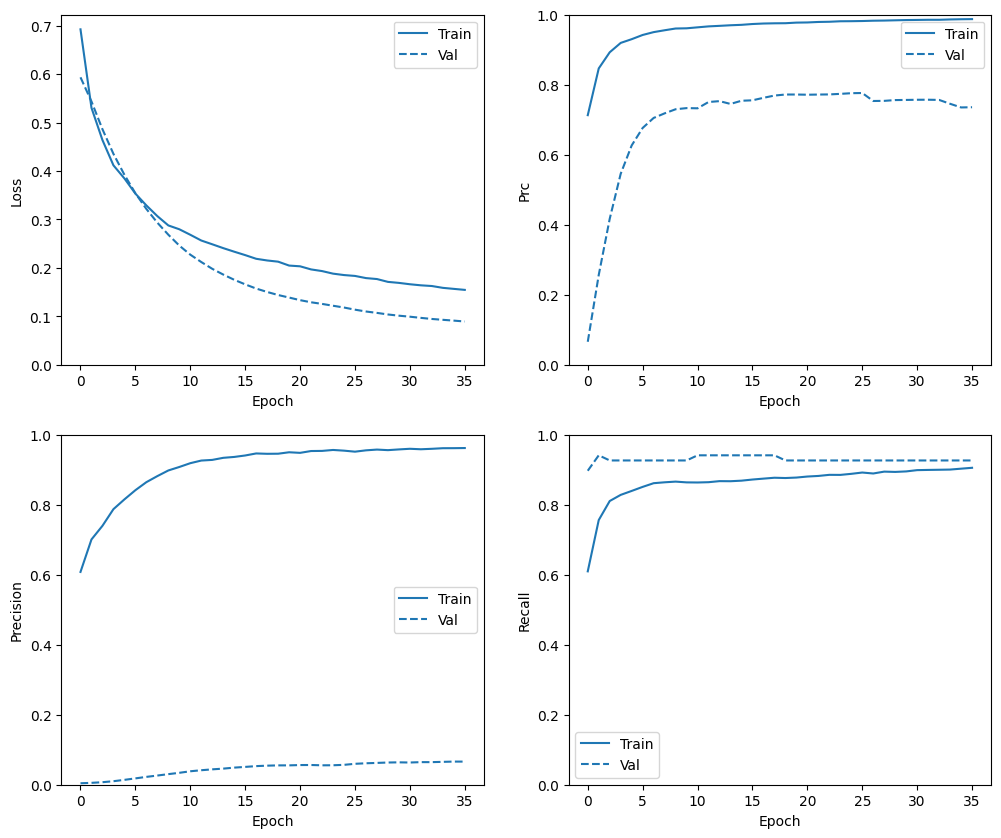

In [59]:
plot_metrics(resampled_history)

### Evaluate metrics

In [60]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 1ms/step


81/90 [==========================>...] - ETA: 0s

90/90 [==============================] - 0s 1ms/step


 1/28 [>.............................] - ETA: 1s

28/28 [==============================] - 0s 1ms/step


loss :  0.11373044550418854
cross entropy :  0.11373044550418854
Brier score :  0.023760084062814713
tp :  84.0
fp :  1212.0
tn :  55656.0
fn :  10.0
accuracy :  0.9785470962524414
precision :  0.06481481343507767
recall :  0.8936170339584351
auc :  0.9732301831245422
prc :  0.7026198506355286

Legitimate Transactions Detected (True Negatives):  55656
Legitimate Transactions Incorrectly Detected (False Positives):  1212
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  84
Total Fraudulent Transactions:  94


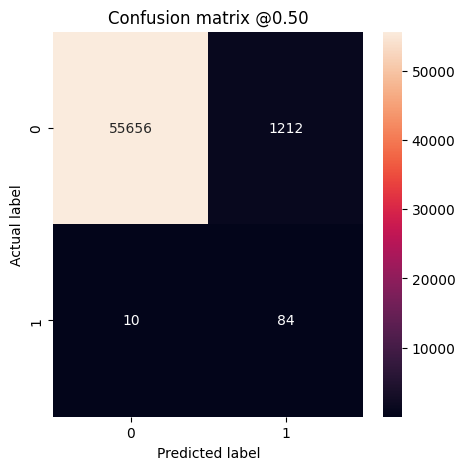

In [61]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()
plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

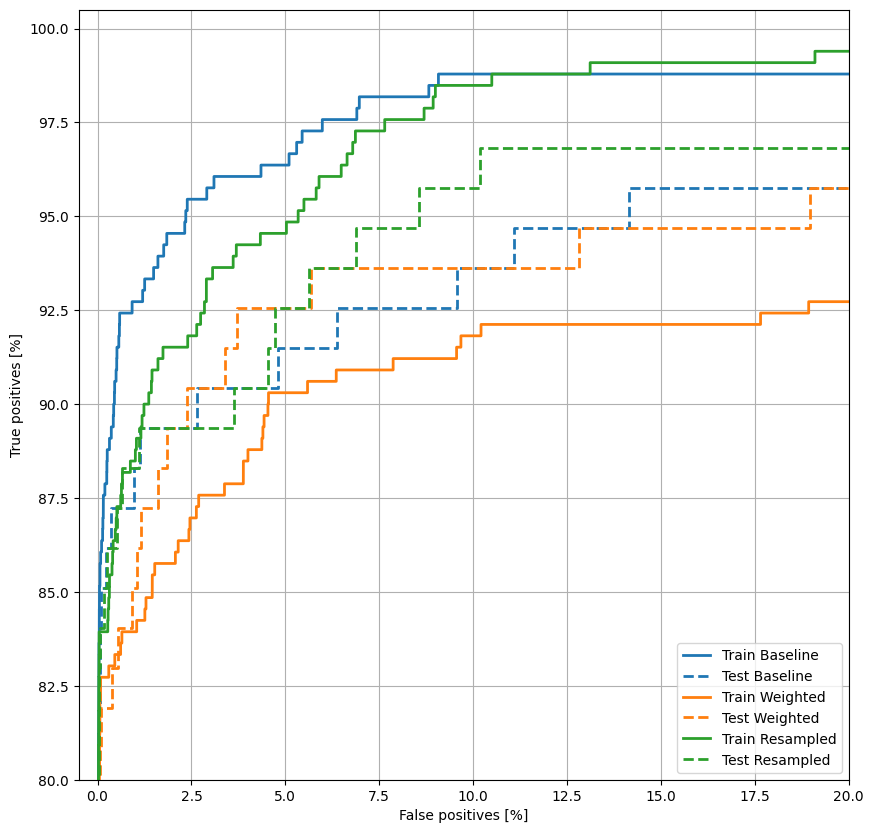

In [62]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')
plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC


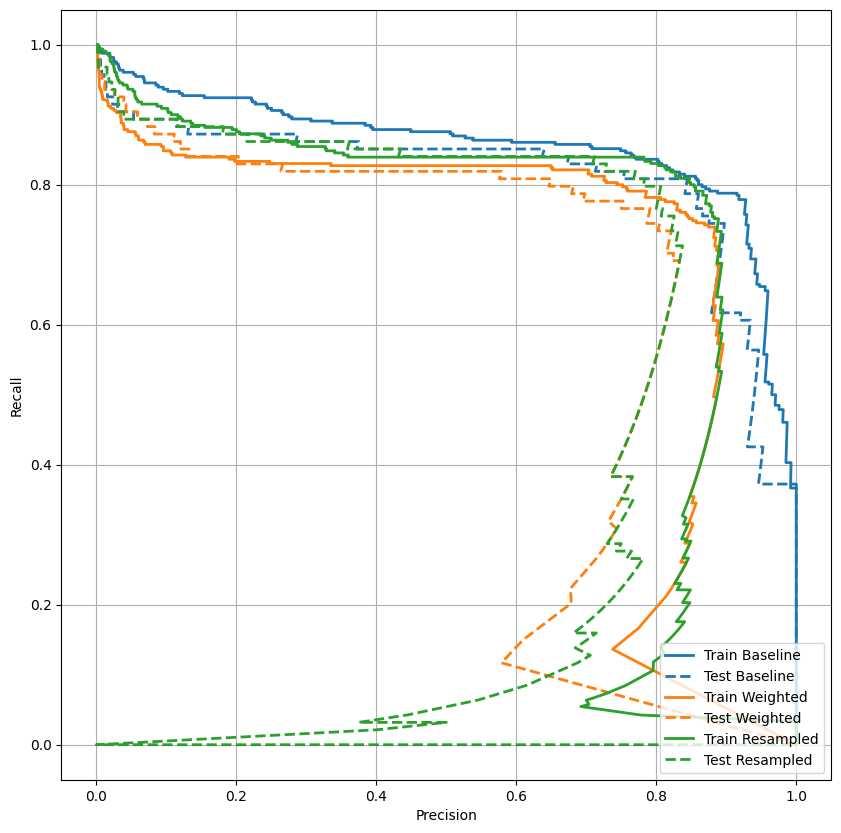

In [63]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

## Applying this tutorial to your problem

Imbalanced data classification is an inherently difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.

Классификация несбалансированных данных по своей сути является сложной задачей, поскольку примеров для изучения очень мало. Вы всегда должны сначала начать с данных и сделать все возможное, чтобы собрать как можно больше выборок и тщательно продумать, какие функции могут быть релевантными, чтобы модель могла максимально использовать возможности вашего малого класса. В какой-то момент ваша модель может с трудом улучшиться и дать желаемые результаты, поэтому важно учитывать контекст вашей проблемы и компромиссы между различными типами ошибок.